![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Forecasting and Nowcasting with Text as Data

# Assignment 1: Marcelo Emilio Ghia Salazar Ante


# Application Forecasting Devaluation



This code is an example of a rolling forecast. It produces two data slices in a program called prepare_slice which also produces three models (top: just text, aug: text + history, jut: just history).

The main idea here is to predict whether there was a jump in devaluation of LATAM currencies compared to USD, similar to forecasting conflict. 

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from pathlib import Path

from sklearn.linear_model import Lasso

import os
import sys

import csv
import subprocess

#put your paths here. 
#spitout='C:\\Dropbox\\teaching\\DSDM Forecasting 2023\\Session 2\\'
#readin = 'C:\\Dropbox\\teaching\\DSDM Forecasting 2023\\Session 1\\'



# Panel Data and Onset/Incidence to Forecast

The panel data was built by extracting from Google Trend different key words that could be signal for devaluation. In this context, I extract the quantity of searchs in a weekly basis of "economic crisis", "default", "devaluation", "dolar price", "inflation", "exchange rate" from 9 different countries in LATAM (Argentina, Bolivia, Brasil, Chile, Colombia, Paraguay, Peru and Uruguay). On the other hand, I also extracted the currency price in terms of USD of each week of each country. I added the variation of the price of each currency in terms of percentage week by week an stablish a cut-off of 7.5% by adding Jump column indicating whether there was a "jump devaluation" bigger than the cutoff or not.

In [11]:
# Read in your panel data as a pandas dataframe
panel_data = pd.read_csv('all_countries_final.csv')

In [26]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler

# # Read in your panel data as a pandas dataframe
# panel_data = pd.read_csv('all_countries_final.csv')

# # Select the columns to be scaled
# columns_to_scale = ['economic crisis', 'default', 'devaluation', 'dolar price', 'inflation', 'exchange rate']

# # Create a scaler object
# scaler = StandardScaler()

# # Scale the selected columns
# panel_data[columns_to_scale] = scaler.fit_transform(panel_data[columns_to_scale])


Scaling the data did not improve performance, so I left it comment

In [13]:
panel_data

Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4307   2/04/2023   3/04/2023    14  2023        -0.972708  0.448559   
4308   9/04/2023  10/04/2023    15  2023        -0.972708  0.023343   
4309  16/04/2023  17/04/2023    16  2023        -0.972708  0.175206   
4310  23/04/2023  24/04/2023    17  2023        -0.491113 -0.219638   
4311  30/04/2023   1/05/2023    18  2023         2.467260 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1.412540      -1.636971      AR   4.9285   
1        1.320318    -1.141808  -1.412540      -1.636971      AR   4.9510   
2        1.153308    -0.523762  -1.412540      -0.313084      AR   4.9550   
3        0.952896    -0.400153  -1.412540      -0.487279      AR   4.9710   
4        1.520730    -0.194138  -1.412540      -1.636971      AR   4.9830   
...           ...          ...        ...            ...     ...      ...   
4307    -0.951021     1.041953   0.306915       0.348860      UY  38.6500   
4308     0.251453     1.000750  -0.394903       1.777265      UY  38.7000   
4309     0.685679     1.495187  -0.500176      -0.591797      UY  38.9500   
4310    -0.951021     1.618796   0.412188      -0.591797      UY  38.9600   
4311    -0.951021    -0.729777  -1.412540      -1.636971      UY  38.7800   

         Var  Jump  Jump_dp  
0     0.0000     0        0  
1     0.0046     0        0  
2     0.0008     0        0  
3     0.0032     0        0  
4     0.0024     0        0  
...      ...   ...      ...  
4307 -0.0074     0        0  
4308  0.0013     0        0  
4309  0.0065     0        0  
4310  0.0003     0        0  
4311 -0.0046     0        0  

[4312 rows x 15 columns]

## Make the dependent variable(s) 

I will experiment with one dependent variables, the incidence - which are moved by t periods so that we are forecasting t periods ahead. In this case, weekly.

In [14]:
#this makes the onset variable following the code in the prelude
def make_target(df, t):
    # t is the number of periods for the shift

    # loop through each period and generate the shift variables
    for i in range(1, t+1):
        col_name = f'Jump_f{i}'
        df[col_name] = df.groupby('ISOCODE')['Jump'].shift(-i)

    # take the maximum for t periods forward and create the new variable
    df['target_f{}'.format(t)] = df[[f'Jump_f{i}' for i in range(1, t+1)]].max(axis=1, skipna=False)

    # drop the shift variables
    df = df.drop(columns=[f'Jump_f{i}' for i in range(1, t+1)])

    #make the onset variable which ignores periods of ongoing conflict
    df['ons_target_f{}'.format(t)]=df['target_f{}'.format(t)]

    df.loc[df['Jump'] == 1, 'ons_target_f{}'.format(t)] = np.nan

    return(df)

## Preparing the data slices for training and forecast.

In [15]:
#key part of code - produces 3 models 
def prepare_slice(topics, year, Week, dep, forward):
    
    data=panel_data
    
    print(dep)
    

    print('pre drop ', len(data))
    
    #the future data is the data we use to produce the fitted values that are stored
    future = data.drop(data[(data.year != year) | (data.Week != Week)].index)			
    data = data.drop(data[((data.year > year)) | ((data.year == year) & (data.Week >= Week))].index)
    #make the target variable through the function above
    #important: this will set to NA the last "forward" observations each country
    data = make_target(data, forward)
    print(data)
    print(year)
    print(Week)


    #making three models
    historymodel = []
    fullmodel = []
    textmodel=[]

         
    historymodel.append('Var')
    
    historymodel.append('Price')
    
       
    for thang in historymodel:
        fullmodel.append(thang)
        
    
    for z in ['economic crisis', 'default', 'devaluation', 'dolar price', 'inflation', 'exchange rate']:
        this = z
        textmodel.append(this)
        fullmodel.append(this)
    
    together=[]
    for thang in fullmodel:
        together.append(thang)
    for dep in deps:
        together.append(dep)
    together.append('ISOCODE')
    together.append('year')
    together.append('Week')

    together_topics=[]
    for thang in textmodel:
        together_topics.append(thang)
    for dep in deps:
        together_topics.append(dep)
    together_topics.append('ISOCODE')
    together_topics.append('year')
    together_topics.append('Week')

    together_history=[]
    for thang in historymodel:
        together_history.append(thang)
    for dep in deps:
        together_history.append(dep)
    together_history.append('ISOCODE')
    together_history.append('year')
    together_history.append('Week')
    
    #model 1 is the full or augmented model
    data2 = data[together]
    df1 = data2.dropna(how='any')
    print('post drop model 1', len(df1))
    df2 = df1[deps]
    #dependent variable for full model
    ys = df2.values.ravel()
    
    #model 2 just contains the text features
    data2_t = data[together_topics]
    df1_t = data2_t.dropna(how='any')
    print('post drop model 2', len(df1_t))
    df2_t = df1_t[deps]
    #dependent variable for text only
    ys_t = df2_t.values.ravel()
    
    #model 3 is the model with just conflict history (and population)
    data2_j = data[together_history]
    df1_j = data2_j.dropna(how='any')
    print('post drop model 3', len(df1_j))
    df2_j = df1_j[deps]
    #dependent variable for history only
    ys_j = df2_j.values.ravel()
    
    #now get the model back
    together.remove(dep)
    together_topics.remove(dep)
    together_history.remove(dep)
    
    #prepare out of sample for the models
    future2 = future[together]
    future_df1 = future2.dropna(how='any')

    future2_t = future[together_topics]
    future_df1_t = future2_t.dropna(how='any')
        
    future2_j = future[together_history]
    future_df1_j = future2_j.dropna(how='any')

    #training data
    X = df1[fullmodel]
    X_t = df1_t[textmodel]
    X_j = df1_j[historymodel]
    
    #data at time T for producing fitted values
    X_future = future_df1[fullmodel]
    X_future_t = future_df1_t[textmodel]
    X_future_j = future_df1_j[historymodel]
    
    #the order here is a bit odd as I added the j (history) model later
    return ys, ys_t, X, X_t, X_future, X_future_t, future_df1, future_df1_t, ys_j, X_j, X_future_j, future_df1_j



In [16]:
#this function is not used but just given for exmpleteness
def runsearch(Xs, ys):   
    print("going in")

    model = RandomForestClassifier()
    parameters = {'max_depth'         : [4, 8],
                  'min_samples_leaf'    : [50, 100],
                  'n_estimators': [700]}

    grid = GridSearchCV(return_train_score=True, estimator=model, param_grid = parameters, cv = 3, n_jobs=-1, scoring='roc_auc', verbose=2)
    grid.fit(Xs, ys)

    print(grid.best_params_)
    print(grid.best_score_)
    print(grid.cv_results_)
    
    clf=RandomForestClassifier(**grid.best_params_)
    
    return clf

In [17]:
def setparams(treenumber, depthnumber, min_samples_number, min_samples_leaf_number):  
    print("setting parameters")
    print("they are:", treenumber, depthnumber, min_samples_number, min_samples_leaf_number)
    
    clf=RandomForestClassifier(n_estimators=treenumber,  max_depth =depthnumber, 
                               min_samples_split =min_samples_number, min_samples_leaf =  min_samples_leaf_number
                             ,n_jobs=8)
    return clf

In [18]:
gendata=1

for depths in [8]:
    for min_samples_leafs in [100]:
        print(f'Checking forward depth {depths} and minleafs {min_samples_leafs}')

        trees=700
        min_samples_splits=2
        
        
        forward=4
        topics=6
        startyearid=2014
        deps=['ons_target_f{}'.format(forward)]

        search=0
        
        initialize=1

        if initialize==1:
            weekid=2
            my_file = 'all_countries_final.csv'
            #my_file = Path(readin + "forecast_data_forstudents.csv")
            #my_file = pd.read_csv('forecast_data_forstudents_2.csv')
            data = pd.read_table(my_file, sep=',')
            future = data.drop(data[(data.year != startyearid) | (data.Week != weekid)].index)			

            fittedvalues=[]
            fittedvalues.append('ISOCODE')
            fittedvalues.append('year')
            fittedvalues.append('Week')
            fittedframe=future[fittedvalues]

            print(startyearid)
            print(weekid)
            dataslices=prepare_slice(topics, startyearid, weekid, deps, forward)
            df1_future_top=dataslices[7]
            df1_future_aug=dataslices[6]
            df1_future_jut=dataslices[11]

            fittedvalues=[]
            fittedvalues.append('ISOCODE')
            fittedvalues.append('year')
            fittedvalues.append('Week') 
            fittedframe_future_top=df1_future_top[fittedvalues]
            fittedframe_future_aug=df1_future_aug[fittedvalues]
            fittedframe_future_jut=df1_future_jut[fittedvalues]

Checking forward depth 8 and minleafs 100
2014
2
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3821   8/12/2013   9/12/2013    49  2013        -0.078317  0.205578   
3822  15/12/2013  16/12/2013    50  2013        -0.972708 -0.705599   
3823  22/12/2013  23/12/2013    51  2013        -0.972708  0.053716   
3824  29/12/2013  30/12/2013    52  2013        -0.972708 -0.280383   
3825   5/01/2014   6/01/2014     1  2014        -0.972708 -0.978952   

      devaluation  dolar price  inflation  exchange rate ISOCODE 

# The Loop

In [19]:
gendata=1

i = [4]
j = [[8]]


for forward,d1 in zip(i,j):
    for depths in d1:
        print(f'Checking forward {forward} with depth {depths}')
        for deps in [['ons_target_f{}'.format(forward)],['target_f{}'.format(forward)]]:
            print("depth:",depths)
            for min_samples_leafs in [100]:

                trees=700

                print("trees:",trees)
                print("forward:", forward)


                topics=6

                startyearid=2014
                initialize=1

                min_samples_splits=2

                search=0

                if initialize==1:
                    weekid=1
                    yearid=startyearid
                    dataslices=prepare_slice(topics, yearid, weekid, deps, forward)
                    
                    fittedvalues=[]
                    fittedvalues.append('ISOCODE')
                    fittedvalues.append('year')
                    fittedvalues.append('Week')
                    fittedframe= pd.DataFrame(columns=['ISOCODE','year','Week'])
                    fittedframe_future_top=pd.DataFrame(columns=['ISOCODE','year','Week'])
                    fittedframe_future_aug=pd.DataFrame(columns=['ISOCODE','year','Week'])
                    fittedframe_future_jut=pd.DataFrame(columns=['ISOCODE','year','Week'])
                
                #setting parameters defined above of doing search
                if search==1:
                    print("entering search")
                    clf_top=runsearch(dataslices[3], dataslices[1])
                    clf_aug=runsearch(dataslices[2], dataslices[0])
                    clf_jut=runsearch(dataslices[9], dataslices[8])
                else:
                    clf_top=setparams(trees,depths,min_samples_splits,min_samples_leafs)
                    clf_aug=setparams(trees,depths,min_samples_splits,min_samples_leafs)
                    clf_jut=setparams(trees,depths,min_samples_splits,min_samples_leafs)


                #enter loop
                startyearid=startyearid
                for yearid in range(startyearid, 2024):
                    if yearid<2023 and yearid!=2018:
                        maxweek=52
                        print("before 2023, going till", maxweek)
                    elif yearid<2023 and yearid==2018:
                        maxweek=53
                        print("before 2023, going till", maxweek)
                    else:
                        maxweek=18
                        print("in 2023, going till", maxweek)
                    for weekid in range(1, maxweek):
                        print(yearid)
                        print(weekid)

                        dataslices=prepare_slice(topics, yearid, weekid, deps, forward)
                        
                        df1_future_top=dataslices[7]
                        df1_future_aug=dataslices[6]
                        df1_future_jut=dataslices[11]

                        fittedvalues=[]
                        fittedvalues.append('ISOCODE')
                        fittedvalues.append('year')
                        fittedvalues.append('Week')  
                        fittedframe_future_top=df1_future_top[fittedvalues]
                        fittedframe_future_aug=df1_future_aug[fittedvalues]
                        fittedframe_future_jut=df1_future_jut[fittedvalues]
    
                       
                        clf_top.fit(dataslices[3], dataslices[1])
                        res = clf_top.predict_proba(dataslices[5])
                        fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]

                        clf_aug.fit(dataslices[2], dataslices[0])
                        res = clf_aug.predict_proba(dataslices[4])
                        fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]

                        clf_jut.fit(dataslices[9], dataslices[8])
                        res = clf_jut.predict_proba(dataslices[10])
                        fittedframe_future_jut[deps[0]+'_pred_jut'] = res[:,1]

                        fittedframe_future=pd.merge(fittedframe_future_jut, fittedframe_future_top, how='outer', left_on=['ISOCODE','year', 'Week'], right_on = ['ISOCODE','year', 'Week'])
                        fittedframe_future=pd.merge(fittedframe_future, fittedframe_future_aug, how='outer', left_on=['ISOCODE','year', 'Week'], right_on = ['ISOCODE','year', 'Week'])

                        fittedframe=pd.concat([fittedframe,fittedframe_future])
                gendata=1
                #fittedframe.to_csv(spitout+"{}_predictions.csv".format(deps[0]))
                fittedframe.to_csv("{}_predictions.csv".format(deps[0]))
                break

Checking forward 4 with depth 8
depth: 8
trees: 700
forward: 4
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3820   1/12/2013   2/12/2013    48  2013        -0.972708 -0.644854   
3821   8/12/2013   9/12/2013    49  2013        -0.078317  0.205578   
3822  15/12/2013  16/12/2013    50  2013        -0.972708 -0.705599   
3823  22/12/2013  23/12/2013    51  2013        -0.972708  0.053716   
3824  29/12/2013  30/12/2013    52  2013        -0.972708 -0.280383   

      devaluation  dolar price  inflation  exchange

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
2
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3821   8/12/2013   9/12/2013    49  2013        -0.078317  0.205578   
3822  15/12/2013  16/12/2013    50  2013        -0.972708 -0.705599   
3823  22/12/2013  23/12/2013    51  2013        -0.972708  0.053716   
3824  29/12/2013  30/12/2013    52  2013        -0.972708 -0.280383   
3825   5/01/2014   6/01/2014     1  2014        -0.972708 -0.978952   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
3
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3822  15/12/2013  16/12/2013    50  2013        -0.972708 -0.705599   
3823  22/12/2013  23/12/2013    51  2013        -0.972708  0.053716   
3824  29/12/2013  30/12/2013    52  2013        -0.972708 -0.280383   
3825   5/01/2014   6/01/2014     1  2014        -0.972708 -0.978952   
3826  12/01/2014  13/01/2014     2  2014         2.467260 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
4
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3823  22/12/2013  23/12/2013    51  2013        -0.972708  0.053716   
3824  29/12/2013  30/12/2013    52  2013        -0.972708 -0.280383   
3825   5/01/2014   6/01/2014     1  2014        -0.972708 -0.978952   
3826  12/01/2014  13/01/2014     2  2014         2.467260 -1.221933   
3827  19/01/2014  20/01/2014     3  2014        -0.972708 -0.948580   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
5
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3824  29/12/2013  30/12/2013    52  2013        -0.972708 -0.280383   
3825   5/01/2014   6/01/2014     1  2014        -0.972708 -0.978952   
3826  12/01/2014  13/01/2014     2  2014         2.467260 -1.221933   
3827  19/01/2014  20/01/2014     3  2014        -0.972708 -0.948580   
3828  26/01/2014  27/01/2014     4  2014        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
6
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3825   5/01/2014   6/01/2014     1  2014        -0.972708 -0.978952   
3826  12/01/2014  13/01/2014     2  2014         2.467260 -1.221933   
3827  19/01/2014  20/01/2014     3  2014        -0.972708 -0.948580   
3828  26/01/2014  27/01/2014     4  2014        -0.972708 -0.857462   
3829   2/02/2014   3/02/2014     5  2014         1.091272 -1.039697   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
7
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3826  12/01/2014  13/01/2014     2  2014         2.467260 -1.221933   
3827  19/01/2014  20/01/2014     3  2014        -0.972708 -0.948580   
3828  26/01/2014  27/01/2014     4  2014        -0.972708 -0.857462   
3829   2/02/2014   3/02/2014     5  2014         1.091272 -1.039697   
3830   9/02/2014  10/02/2014     6  2014        -0.972708 -0.827089   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
8
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3827  19/01/2014  20/01/2014     3  2014        -0.972708 -0.948580   
3828  26/01/2014  27/01/2014     4  2014        -0.972708 -0.857462   
3829   2/02/2014   3/02/2014     5  2014         1.091272 -1.039697   
3830   9/02/2014  10/02/2014     6  2014        -0.972708 -0.827089   
3831  16/02/2014  17/02/2014     7  2014        -0.972708 -1.009325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
9
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3828  26/01/2014  27/01/2014     4  2014        -0.972708 -0.857462   
3829   2/02/2014   3/02/2014     5  2014         1.091272 -1.039697   
3830   9/02/2014  10/02/2014     6  2014        -0.972708 -0.827089   
3831  16/02/2014  17/02/2014     7  2014        -0.972708 -1.009325   
3832  23/02/2014  24/02/2014     8  2014        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
10
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3829   2/02/2014   3/02/2014     5  2014         1.091272 -1.039697   
3830   9/02/2014  10/02/2014     6  2014        -0.972708 -0.827089   
3831  16/02/2014  17/02/2014     7  2014        -0.972708 -1.009325   
3832  23/02/2014  24/02/2014     8  2014        -0.972708 -1.221933   
3833   2/03/2014   3/03/2014     9  2014        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
11
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3830   9/02/2014  10/02/2014     6  2014        -0.972708 -0.827089   
3831  16/02/2014  17/02/2014     7  2014        -0.972708 -1.009325   
3832  23/02/2014  24/02/2014     8  2014        -0.972708 -1.221933   
3833   2/03/2014   3/03/2014     9  2014        -0.972708 -1.221933   
3834   9/03/2014  10/03/2014    10  2014        -0.972708 -1.009325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
12
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3831  16/02/2014  17/02/2014     7  2014        -0.972708 -1.009325   
3832  23/02/2014  24/02/2014     8  2014        -0.972708 -1.221933   
3833   2/03/2014   3/03/2014     9  2014        -0.972708 -1.221933   
3834   9/03/2014  10/03/2014    10  2014        -0.972708 -1.009325   
3835  16/03/2014  17/03/2014    11  2014         2.226462 -0.948580   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
13
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3832  23/02/2014  24/02/2014     8  2014        -0.972708 -1.221933   
3833   2/03/2014   3/03/2014     9  2014        -0.972708 -1.221933   
3834   9/03/2014  10/03/2014    10  2014        -0.972708 -1.009325   
3835  16/03/2014  17/03/2014    11  2014         2.226462 -0.948580   
3836  23/03/2014  24/03/2014    12  2014         1.366470 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
14
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3833   2/03/2014   3/03/2014     9  2014        -0.972708 -1.221933   
3834   9/03/2014  10/03/2014    10  2014        -0.972708 -1.009325   
3835  16/03/2014  17/03/2014    11  2014         2.226462 -0.948580   
3836  23/03/2014  24/03/2014    12  2014         1.366470 -0.857462   
3837  30/03/2014  31/03/2014    13  2014        -0.972708 -0.978952   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
15
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3834   9/03/2014  10/03/2014    10  2014        -0.972708 -1.009325   
3835  16/03/2014  17/03/2014    11  2014         2.226462 -0.948580   
3836  23/03/2014  24/03/2014    12  2014         1.366470 -0.857462   
3837  30/03/2014  31/03/2014    13  2014        -0.972708 -0.978952   
3838   6/04/2014   7/04/2014    14  2014        -0.972708 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
16
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3835  16/03/2014  17/03/2014    11  2014         2.226462 -0.948580   
3836  23/03/2014  24/03/2014    12  2014         1.366470 -0.857462   
3837  30/03/2014  31/03/2014    13  2014        -0.972708 -0.978952   
3838   6/04/2014   7/04/2014    14  2014        -0.972708 -0.887834   
3839  13/04/2014  14/04/2014    15  2014        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
17
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3836  23/03/2014  24/03/2014    12  2014         1.366470 -0.857462   
3837  30/03/2014  31/03/2014    13  2014        -0.972708 -0.978952   
3838   6/04/2014   7/04/2014    14  2014        -0.972708 -0.887834   
3839  13/04/2014  14/04/2014    15  2014        -0.972708 -1.221933   
3840  20/04/2014  21/04/2014    16  2014        -0.972708 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
18
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3837  30/03/2014  31/03/2014    13  2014        -0.972708 -0.978952   
3838   6/04/2014   7/04/2014    14  2014        -0.972708 -0.887834   
3839  13/04/2014  14/04/2014    15  2014        -0.972708 -1.221933   
3840  20/04/2014  21/04/2014    16  2014        -0.972708 -0.887834   
3841  27/04/2014  28/04/2014    17  2014        -0.972708 -0.918207   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
19
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3838   6/04/2014   7/04/2014    14  2014        -0.972708 -0.887834   
3839  13/04/2014  14/04/2014    15  2014        -0.972708 -1.221933   
3840  20/04/2014  21/04/2014    16  2014        -0.972708 -0.887834   
3841  27/04/2014  28/04/2014    17  2014        -0.972708 -0.918207   
3842   4/05/2014   5/05/2014    18  2014        -0.972708 -1.009325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
20
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3839  13/04/2014  14/04/2014    15  2014        -0.972708 -1.221933   
3840  20/04/2014  21/04/2014    16  2014        -0.972708 -0.887834   
3841  27/04/2014  28/04/2014    17  2014        -0.972708 -0.918207   
3842   4/05/2014   5/05/2014    18  2014        -0.972708 -1.009325   
3843  11/05/2014  12/05/2014    19  2014        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
21
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3840  20/04/2014  21/04/2014    16  2014        -0.972708 -0.887834   
3841  27/04/2014  28/04/2014    17  2014        -0.972708 -0.918207   
3842   4/05/2014   5/05/2014    18  2014        -0.972708 -1.009325   
3843  11/05/2014  12/05/2014    19  2014        -0.972708 -0.857462   
3844  18/05/2014  19/05/2014    20  2014         0.988073 -1.009325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
22
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3841  27/04/2014  28/04/2014    17  2014        -0.972708 -0.918207   
3842   4/05/2014   5/05/2014    18  2014        -0.972708 -1.009325   
3843  11/05/2014  12/05/2014    19  2014        -0.972708 -0.857462   
3844  18/05/2014  19/05/2014    20  2014         0.988073 -1.009325   
3845  25/05/2014  26/05/2014    21  2014         0.850475 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
23
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3842   4/05/2014   5/05/2014    18  2014        -0.972708 -1.009325   
3843  11/05/2014  12/05/2014    19  2014        -0.972708 -0.857462   
3844  18/05/2014  19/05/2014    20  2014         0.988073 -1.009325   
3845  25/05/2014  26/05/2014    21  2014         0.850475 -0.887834   
3846   1/06/2014   2/06/2014    22  2014        -0.972708 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
24
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3843  11/05/2014  12/05/2014    19  2014        -0.972708 -0.857462   
3844  18/05/2014  19/05/2014    20  2014         0.988073 -1.009325   
3845  25/05/2014  26/05/2014    21  2014         0.850475 -0.887834   
3846   1/06/2014   2/06/2014    22  2014        -0.972708 -0.887834   
3847   8/06/2014   9/06/2014    23  2014        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
25
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3844  18/05/2014  19/05/2014    20  2014         0.988073 -1.009325   
3845  25/05/2014  26/05/2014    21  2014         0.850475 -0.887834   
3846   1/06/2014   2/06/2014    22  2014        -0.972708 -0.887834   
3847   8/06/2014   9/06/2014    23  2014        -0.972708 -1.221933   
3848  15/06/2014  16/06/2014    24  2014        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
26
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3845  25/05/2014  26/05/2014    21  2014         0.850475 -0.887834   
3846   1/06/2014   2/06/2014    22  2014        -0.972708 -0.887834   
3847   8/06/2014   9/06/2014    23  2014        -0.972708 -1.221933   
3848  15/06/2014  16/06/2014    24  2014        -0.972708 -0.310755   
3849  22/06/2014  23/06/2014    25  2014        -0.972708 -0.766344   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
27
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3846   1/06/2014   2/06/2014    22  2014        -0.972708 -0.887834   
3847   8/06/2014   9/06/2014    23  2014        -0.972708 -1.221933   
3848  15/06/2014  16/06/2014    24  2014        -0.972708 -0.310755   
3849  22/06/2014  23/06/2014    25  2014        -0.972708 -0.766344   
3850  29/06/2014  30/06/2014    26  2014        -0.972708 -1.130815   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
28
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3847   8/06/2014   9/06/2014    23  2014        -0.972708 -1.221933   
3848  15/06/2014  16/06/2014    24  2014        -0.972708 -0.310755   
3849  22/06/2014  23/06/2014    25  2014        -0.972708 -0.766344   
3850  29/06/2014  30/06/2014    26  2014        -0.972708 -1.130815   
3851   6/07/2014   7/07/2014    27  2014        -0.972708 -0.766344   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
29
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3848  15/06/2014  16/06/2014    24  2014        -0.972708 -0.310755   
3849  22/06/2014  23/06/2014    25  2014        -0.972708 -0.766344   
3850  29/06/2014  30/06/2014    26  2014        -0.972708 -1.130815   
3851   6/07/2014   7/07/2014    27  2014        -0.972708 -0.766344   
3852  13/07/2014  14/07/2014    28  2014        -0.972708 -0.948580   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
30
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3849  22/06/2014  23/06/2014    25  2014        -0.972708 -0.766344   
3850  29/06/2014  30/06/2014    26  2014        -0.972708 -1.130815   
3851   6/07/2014   7/07/2014    27  2014        -0.972708 -0.766344   
3852  13/07/2014  14/07/2014    28  2014        -0.972708 -0.948580   
3853  20/07/2014  21/07/2014    29  2014         0.575277 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
31
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3850  29/06/2014  30/06/2014    26  2014        -0.972708 -1.130815   
3851   6/07/2014   7/07/2014    27  2014        -0.972708 -0.766344   
3852  13/07/2014  14/07/2014    28  2014        -0.972708 -0.948580   
3853  20/07/2014  21/07/2014    29  2014         0.575277 -0.735972   
3854  27/07/2014  28/07/2014    30  2014         0.403279  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
32
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3851   6/07/2014   7/07/2014    27  2014        -0.972708 -0.766344   
3852  13/07/2014  14/07/2014    28  2014        -0.972708 -0.948580   
3853  20/07/2014  21/07/2014    29  2014         0.575277 -0.735972   
3854  27/07/2014  28/07/2014    30  2014         0.403279  1.815325   
3855   3/08/2014   4/08/2014    31  2014        -0.972708 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
33
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3852  13/07/2014  14/07/2014    28  2014        -0.972708 -0.948580   
3853  20/07/2014  21/07/2014    29  2014         0.575277 -0.735972   
3854  27/07/2014  28/07/2014    30  2014         0.403279  1.815325   
3855   3/08/2014   4/08/2014    31  2014        -0.972708 -0.401873   
3856  10/08/2014  11/08/2014    32  2014        -0.972708 -0.978952   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
34
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3853  20/07/2014  21/07/2014    29  2014         0.575277 -0.735972   
3854  27/07/2014  28/07/2014    30  2014         0.403279  1.815325   
3855   3/08/2014   4/08/2014    31  2014        -0.972708 -0.401873   
3856  10/08/2014  11/08/2014    32  2014        -0.972708 -0.978952   
3857  17/08/2014  18/08/2014    33  2014         0.506478 -0.827089   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
35
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3854  27/07/2014  28/07/2014    30  2014         0.403279  1.815325   
3855   3/08/2014   4/08/2014    31  2014        -0.972708 -0.401873   
3856  10/08/2014  11/08/2014    32  2014        -0.972708 -0.978952   
3857  17/08/2014  18/08/2014    33  2014         0.506478 -0.827089   
3858  24/08/2014  25/08/2014    34  2014         1.779266 -0.978952   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
36
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3855   3/08/2014   4/08/2014    31  2014        -0.972708 -0.401873   
3856  10/08/2014  11/08/2014    32  2014        -0.972708 -0.978952   
3857  17/08/2014  18/08/2014    33  2014         0.506478 -0.827089   
3858  24/08/2014  25/08/2014    34  2014         1.779266 -0.978952   
3859  31/08/2014   1/09/2014    35  2014         0.437679 -0.766344   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
37
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3856  10/08/2014  11/08/2014    32  2014        -0.972708 -0.978952   
3857  17/08/2014  18/08/2014    33  2014         0.506478 -0.827089   
3858  24/08/2014  25/08/2014    34  2014         1.779266 -0.978952   
3859  31/08/2014   1/09/2014    35  2014         0.437679 -0.766344   
3860   7/09/2014   8/09/2014    36  2014        -0.972708 -1.039697   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
38
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3857  17/08/2014  18/08/2014    33  2014         0.506478 -0.827089   
3858  24/08/2014  25/08/2014    34  2014         1.779266 -0.978952   
3859  31/08/2014   1/09/2014    35  2014         0.437679 -0.766344   
3860   7/09/2014   8/09/2014    36  2014        -0.972708 -1.039697   
3861  14/09/2014  15/09/2014    37  2014         0.368879 -1.009325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
39
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3858  24/08/2014  25/08/2014    34  2014         1.779266 -0.978952   
3859  31/08/2014   1/09/2014    35  2014         0.437679 -0.766344   
3860   7/09/2014   8/09/2014    36  2014        -0.972708 -1.039697   
3861  14/09/2014  15/09/2014    37  2014         0.368879 -1.009325   
3862  21/09/2014  22/09/2014    38  2014        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
40
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3859  31/08/2014   1/09/2014    35  2014         0.437679 -0.766344   
3860   7/09/2014   8/09/2014    36  2014        -0.972708 -1.039697   
3861  14/09/2014  15/09/2014    37  2014         0.368879 -1.009325   
3862  21/09/2014  22/09/2014    38  2014        -0.972708 -0.735972   
3863  28/09/2014  29/09/2014    39  2014        -0.972708 -0.918207   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
41
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3860   7/09/2014   8/09/2014    36  2014        -0.972708 -1.039697   
3861  14/09/2014  15/09/2014    37  2014         0.368879 -1.009325   
3862  21/09/2014  22/09/2014    38  2014        -0.972708 -0.735972   
3863  28/09/2014  29/09/2014    39  2014        -0.972708 -0.918207   
3864   5/10/2014   6/10/2014    40  2014         0.334479 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
42
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3861  14/09/2014  15/09/2014    37  2014         0.368879 -1.009325   
3862  21/09/2014  22/09/2014    38  2014        -0.972708 -0.735972   
3863  28/09/2014  29/09/2014    39  2014        -0.972708 -0.918207   
3864   5/10/2014   6/10/2014    40  2014         0.334479 -0.887834   
3865  12/10/2014  13/10/2014    41  2014        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
43
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3862  21/09/2014  22/09/2014    38  2014        -0.972708 -0.735972   
3863  28/09/2014  29/09/2014    39  2014        -0.972708 -0.918207   
3864   5/10/2014   6/10/2014    40  2014         0.334479 -0.887834   
3865  12/10/2014  13/10/2014    41  2014        -0.972708 -0.735972   
3866  19/10/2014  20/10/2014    42  2014         1.228871 -1.100443   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
44
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3863  28/09/2014  29/09/2014    39  2014        -0.972708 -0.918207   
3864   5/10/2014   6/10/2014    40  2014         0.334479 -0.887834   
3865  12/10/2014  13/10/2014    41  2014        -0.972708 -0.735972   
3866  19/10/2014  20/10/2014    42  2014         1.228871 -1.100443   
3867  26/10/2014  27/10/2014    43  2014         0.712876 -0.948580   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
45
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3864   5/10/2014   6/10/2014    40  2014         0.334479 -0.887834   
3865  12/10/2014  13/10/2014    41  2014        -0.972708 -0.735972   
3866  19/10/2014  20/10/2014    42  2014         1.228871 -1.100443   
3867  26/10/2014  27/10/2014    43  2014         0.712876 -0.948580   
3868   2/11/2014   3/11/2014    44  2014        -0.972708 -1.100443   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
46
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3865  12/10/2014  13/10/2014    41  2014        -0.972708 -0.735972   
3866  19/10/2014  20/10/2014    42  2014         1.228871 -1.100443   
3867  26/10/2014  27/10/2014    43  2014         0.712876 -0.948580   
3868   2/11/2014   3/11/2014    44  2014        -0.972708 -1.100443   
3869   9/11/2014  10/11/2014    45  2014         1.710467 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
47
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3866  19/10/2014  20/10/2014    42  2014         1.228871 -1.100443   
3867  26/10/2014  27/10/2014    43  2014         0.712876 -0.948580   
3868   2/11/2014   3/11/2014    44  2014        -0.972708 -1.100443   
3869   9/11/2014  10/11/2014    45  2014         1.710467 -0.887834   
3870  16/11/2014  17/11/2014    46  2014        -0.972708 -0.796717   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
48
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3867  26/10/2014  27/10/2014    43  2014         0.712876 -0.948580   
3868   2/11/2014   3/11/2014    44  2014        -0.972708 -1.100443   
3869   9/11/2014  10/11/2014    45  2014         1.710467 -0.887834   
3870  16/11/2014  17/11/2014    46  2014        -0.972708 -0.796717   
3871  23/11/2014  24/11/2014    47  2014        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
49
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3868   2/11/2014   3/11/2014    44  2014        -0.972708 -1.100443   
3869   9/11/2014  10/11/2014    45  2014         1.710467 -0.887834   
3870  16/11/2014  17/11/2014    46  2014        -0.972708 -0.796717   
3871  23/11/2014  24/11/2014    47  2014        -0.972708 -0.857462   
3872  30/11/2014   1/12/2014    48  2014        -0.972708 -0.948580   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
50
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3869   9/11/2014  10/11/2014    45  2014         1.710467 -0.887834   
3870  16/11/2014  17/11/2014    46  2014        -0.972708 -0.796717   
3871  23/11/2014  24/11/2014    47  2014        -0.972708 -0.857462   
3872  30/11/2014   1/12/2014    48  2014        -0.972708 -0.948580   
3873   7/12/2014   8/12/2014    49  2014        -0.972708 -1.009325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
51
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3870  16/11/2014  17/11/2014    46  2014        -0.972708 -0.796717   
3871  23/11/2014  24/11/2014    47  2014        -0.972708 -0.857462   
3872  30/11/2014   1/12/2014    48  2014        -0.972708 -0.948580   
3873   7/12/2014   8/12/2014    49  2014        -0.972708 -1.009325   
3874  14/12/2014  15/12/2014    50  2014         0.747276 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2015
1
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3872  30/11/2014   1/12/2014    48  2014        -0.972708 -0.948580   
3873   7/12/2014   8/12/2014    49  2014        -0.972708 -1.009325   
3874  14/12/2014  15/12/2014    50  2014         0.747276 -1.221933   
3875  21/12/2014  22/12/2014    51  2014        -0.972708 -0.978952   
3876  28/12/2014  29/12/2014    52  2014        -0.972708 -0.948580   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0  

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
2
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3873   7/12/2014   8/12/2014    49  2014        -0.972708 -1.009325   
3874  14/12/2014  15/12/2014    50  2014         0.747276 -1.221933   
3875  21/12/2014  22/12/2014    51  2014        -0.972708 -0.978952   
3876  28/12/2014  29/12/2014    52  2014        -0.972708 -0.948580   
3877   4/01/2015   5/01/2015     1  2015         0.403279  0.266324   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
3
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3874  14/12/2014  15/12/2014    50  2014         0.747276 -1.221933   
3875  21/12/2014  22/12/2014    51  2014        -0.972708 -0.978952   
3876  28/12/2014  29/12/2014    52  2014        -0.972708 -0.948580   
3877   4/01/2015   5/01/2015     1  2015         0.403279  0.266324   
3878  11/01/2015  12/01/2015     2  2015        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
4
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3875  21/12/2014  22/12/2014    51  2014        -0.972708 -0.978952   
3876  28/12/2014  29/12/2014    52  2014        -0.972708 -0.948580   
3877   4/01/2015   5/01/2015     1  2015         0.403279  0.266324   
3878  11/01/2015  12/01/2015     2  2015        -0.972708 -0.341128   
3879  18/01/2015  19/01/2015     3  2015         2.295261 -0.007030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
5
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3876  28/12/2014  29/12/2014    52  2014        -0.972708 -0.948580   
3877   4/01/2015   5/01/2015     1  2015         0.403279  0.266324   
3878  11/01/2015  12/01/2015     2  2015        -0.972708 -0.341128   
3879  18/01/2015  19/01/2015     3  2015         2.295261 -0.007030   
3880  25/01/2015  26/01/2015     4  2015        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
6
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3877   4/01/2015   5/01/2015     1  2015         0.403279  0.266324   
3878  11/01/2015  12/01/2015     2  2015        -0.972708 -0.341128   
3879  18/01/2015  19/01/2015     3  2015         2.295261 -0.007030   
3880  25/01/2015  26/01/2015     4  2015        -0.972708  0.327069   
3881   1/02/2015   2/02/2015     5  2015         2.467260  0.144833   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
7
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3878  11/01/2015  12/01/2015     2  2015        -0.972708 -0.341128   
3879  18/01/2015  19/01/2015     3  2015         2.295261 -0.007030   
3880  25/01/2015  26/01/2015     4  2015        -0.972708  0.327069   
3881   1/02/2015   2/02/2015     5  2015         2.467260  0.144833   
3882   8/02/2015   9/02/2015     6  2015        -0.972708  0.873775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
8
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3879  18/01/2015  19/01/2015     3  2015         2.295261 -0.007030   
3880  25/01/2015  26/01/2015     4  2015        -0.972708  0.327069   
3881   1/02/2015   2/02/2015     5  2015         2.467260  0.144833   
3882   8/02/2015   9/02/2015     6  2015        -0.972708  0.873775   
3883  15/02/2015  16/02/2015     7  2015         0.816075  0.813030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
9
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3880  25/01/2015  26/01/2015     4  2015        -0.972708  0.327069   
3881   1/02/2015   2/02/2015     5  2015         2.467260  0.144833   
3882   8/02/2015   9/02/2015     6  2015        -0.972708  0.873775   
3883  15/02/2015  16/02/2015     7  2015         0.816075  0.813030   
3884  22/02/2015  23/02/2015     8  2015        -0.972708  0.539677   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
10
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3881   1/02/2015   2/02/2015     5  2015         2.467260  0.144833   
3882   8/02/2015   9/02/2015     6  2015        -0.972708  0.873775   
3883  15/02/2015  16/02/2015     7  2015         0.816075  0.813030   
3884  22/02/2015  23/02/2015     8  2015        -0.972708  0.539677   
3885   1/03/2015   2/03/2015     9  2015        -0.972708  1.329364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
11
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3882   8/02/2015   9/02/2015     6  2015        -0.972708  0.873775   
3883  15/02/2015  16/02/2015     7  2015         0.816075  0.813030   
3884  22/02/2015  23/02/2015     8  2015        -0.972708  0.539677   
3885   1/03/2015   2/03/2015     9  2015        -0.972708  1.329364   
3886   8/03/2015   9/03/2015    10  2015        -0.972708 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
12
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3883  15/02/2015  16/02/2015     7  2015         0.816075  0.813030   
3884  22/02/2015  23/02/2015     8  2015        -0.972708  0.539677   
3885   1/03/2015   2/03/2015     9  2015        -0.972708  1.329364   
3886   8/03/2015   9/03/2015    10  2015        -0.972708 -0.644854   
3887  15/03/2015  16/03/2015    11  2015        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
13
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3884  22/02/2015  23/02/2015     8  2015        -0.972708  0.539677   
3885   1/03/2015   2/03/2015     9  2015        -0.972708  1.329364   
3886   8/03/2015   9/03/2015    10  2015        -0.972708 -0.644854   
3887  15/03/2015  16/03/2015    11  2015        -0.972708 -0.310755   
3888  22/03/2015  23/03/2015    12  2015        -0.972708  0.509304   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
14
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3885   1/03/2015   2/03/2015     9  2015        -0.972708  1.329364   
3886   8/03/2015   9/03/2015    10  2015        -0.972708 -0.644854   
3887  15/03/2015  16/03/2015    11  2015        -0.972708 -0.310755   
3888  22/03/2015  23/03/2015    12  2015        -0.972708  0.509304   
3889  29/03/2015  30/03/2015    13  2015        -0.972708  1.207874   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
15
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3886   8/03/2015   9/03/2015    10  2015        -0.972708 -0.644854   
3887  15/03/2015  16/03/2015    11  2015        -0.972708 -0.310755   
3888  22/03/2015  23/03/2015    12  2015        -0.972708  0.509304   
3889  29/03/2015  30/03/2015    13  2015        -0.972708  1.207874   
3890   5/04/2015   6/04/2015    14  2015        -0.972708 -0.250010   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
16
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3887  15/03/2015  16/03/2015    11  2015        -0.972708 -0.310755   
3888  22/03/2015  23/03/2015    12  2015        -0.972708  0.509304   
3889  29/03/2015  30/03/2015    13  2015        -0.972708  1.207874   
3890   5/04/2015   6/04/2015    14  2015        -0.972708 -0.250010   
3891  12/04/2015  13/04/2015    15  2015        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
17
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3888  22/03/2015  23/03/2015    12  2015        -0.972708  0.509304   
3889  29/03/2015  30/03/2015    13  2015        -0.972708  1.207874   
3890   5/04/2015   6/04/2015    14  2015        -0.972708 -0.250010   
3891  12/04/2015  13/04/2015    15  2015        -0.972708  0.023343   
3892  19/04/2015  20/04/2015    16  2015         0.884874  0.630795   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
18
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3889  29/03/2015  30/03/2015    13  2015        -0.972708  1.207874   
3890   5/04/2015   6/04/2015    14  2015        -0.972708 -0.250010   
3891  12/04/2015  13/04/2015    15  2015        -0.972708  0.023343   
3892  19/04/2015  20/04/2015    16  2015         0.884874  0.630795   
3893  26/04/2015  27/04/2015    17  2015        -0.972708  0.630795   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
19
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3890   5/04/2015   6/04/2015    14  2015        -0.972708 -0.250010   
3891  12/04/2015  13/04/2015    15  2015        -0.972708  0.023343   
3892  19/04/2015  20/04/2015    16  2015         0.884874  0.630795   
3893  26/04/2015  27/04/2015    17  2015        -0.972708  0.630795   
3894   3/05/2015   4/05/2015    18  2015        -0.972708  1.147128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
20
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3891  12/04/2015  13/04/2015    15  2015        -0.972708  0.023343   
3892  19/04/2015  20/04/2015    16  2015         0.884874  0.630795   
3893  26/04/2015  27/04/2015    17  2015        -0.972708  0.630795   
3894   3/05/2015   4/05/2015    18  2015        -0.972708  1.147128   
3895  10/05/2015  11/05/2015    19  2015         0.506478  1.056011   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
21
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3892  19/04/2015  20/04/2015    16  2015         0.884874  0.630795   
3893  26/04/2015  27/04/2015    17  2015        -0.972708  0.630795   
3894   3/05/2015   4/05/2015    18  2015        -0.972708  1.147128   
3895  10/05/2015  11/05/2015    19  2015         0.506478  1.056011   
3896  17/05/2015  18/05/2015    20  2015        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
22
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3893  26/04/2015  27/04/2015    17  2015        -0.972708  0.630795   
3894   3/05/2015   4/05/2015    18  2015        -0.972708  1.147128   
3895  10/05/2015  11/05/2015    19  2015         0.506478  1.056011   
3896  17/05/2015  18/05/2015    20  2015        -0.972708 -1.221933   
3897  24/05/2015  25/05/2015    21  2015        -0.972708 -0.462618   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
23
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3894   3/05/2015   4/05/2015    18  2015        -0.972708  1.147128   
3895  10/05/2015  11/05/2015    19  2015         0.506478  1.056011   
3896  17/05/2015  18/05/2015    20  2015        -0.972708 -1.221933   
3897  24/05/2015  25/05/2015    21  2015        -0.972708 -0.462618   
3898  31/05/2015   1/06/2015    22  2015        -0.972708  1.450854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
24
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3895  10/05/2015  11/05/2015    19  2015         0.506478  1.056011   
3896  17/05/2015  18/05/2015    20  2015        -0.972708 -1.221933   
3897  24/05/2015  25/05/2015    21  2015        -0.972708 -0.462618   
3898  31/05/2015   1/06/2015    22  2015        -0.972708  1.450854   
3899   7/06/2015   8/06/2015    23  2015        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
25
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3896  17/05/2015  18/05/2015    20  2015        -0.972708 -1.221933   
3897  24/05/2015  25/05/2015    21  2015        -0.972708 -0.462618   
3898  31/05/2015   1/06/2015    22  2015        -0.972708  1.450854   
3899   7/06/2015   8/06/2015    23  2015        -0.972708 -0.067775   
3900  14/06/2015  15/06/2015    24  2015         1.228871  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
26
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3897  24/05/2015  25/05/2015    21  2015        -0.972708 -0.462618   
3898  31/05/2015   1/06/2015    22  2015        -0.972708  1.450854   
3899   7/06/2015   8/06/2015    23  2015        -0.972708 -0.067775   
3900  14/06/2015  15/06/2015    24  2015         1.228871  0.023343   
3901  21/06/2015  22/06/2015    25  2015         2.329661  0.570049   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
27
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3898  31/05/2015   1/06/2015    22  2015        -0.972708  1.450854   
3899   7/06/2015   8/06/2015    23  2015        -0.972708 -0.067775   
3900  14/06/2015  15/06/2015    24  2015         1.228871  0.023343   
3901  21/06/2015  22/06/2015    25  2015         2.329661  0.570049   
3902  28/06/2015  29/06/2015    26  2015        -0.972708  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
28
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3899   7/06/2015   8/06/2015    23  2015        -0.972708 -0.067775   
3900  14/06/2015  15/06/2015    24  2015         1.228871  0.023343   
3901  21/06/2015  22/06/2015    25  2015         2.329661  0.570049   
3902  28/06/2015  29/06/2015    26  2015        -0.972708  0.661167   
3903   5/07/2015   6/07/2015    27  2015        -0.972708  0.053716   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
29
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3900  14/06/2015  15/06/2015    24  2015         1.228871  0.023343   
3901  21/06/2015  22/06/2015    25  2015         2.329661  0.570049   
3902  28/06/2015  29/06/2015    26  2015        -0.972708  0.661167   
3903   5/07/2015   6/07/2015    27  2015        -0.972708  0.053716   
3904  12/07/2015  13/07/2015    28  2015         0.368879  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
30
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3901  21/06/2015  22/06/2015    25  2015         2.329661  0.570049   
3902  28/06/2015  29/06/2015    26  2015        -0.972708  0.661167   
3903   5/07/2015   6/07/2015    27  2015        -0.972708  0.053716   
3904  12/07/2015  13/07/2015    28  2015         0.368879  0.721912   
3905  19/07/2015  20/07/2015    29  2015        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
31
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3902  28/06/2015  29/06/2015    26  2015        -0.972708  0.661167   
3903   5/07/2015   6/07/2015    27  2015        -0.972708  0.053716   
3904  12/07/2015  13/07/2015    28  2015         0.368879  0.721912   
3905  19/07/2015  20/07/2015    29  2015        -0.972708 -0.310755   
3906  26/07/2015  27/07/2015    30  2015        -0.972708 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
32
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3903   5/07/2015   6/07/2015    27  2015        -0.972708  0.053716   
3904  12/07/2015  13/07/2015    28  2015         0.368879  0.721912   
3905  19/07/2015  20/07/2015    29  2015        -0.972708 -0.310755   
3906  26/07/2015  27/07/2015    30  2015        -0.972708 -0.098147   
3907   2/08/2015   3/08/2015    31  2015        -0.972708  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
33
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3904  12/07/2015  13/07/2015    28  2015         0.368879  0.721912   
3905  19/07/2015  20/07/2015    29  2015        -0.972708 -0.310755   
3906  26/07/2015  27/07/2015    30  2015        -0.972708 -0.098147   
3907   2/08/2015   3/08/2015    31  2015        -0.972708  1.815325   
3908   9/08/2015  10/08/2015    32  2015         0.609677 -0.037402   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
34
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3905  19/07/2015  20/07/2015    29  2015        -0.972708 -0.310755   
3906  26/07/2015  27/07/2015    30  2015        -0.972708 -0.098147   
3907   2/08/2015   3/08/2015    31  2015        -0.972708  1.815325   
3908   9/08/2015  10/08/2015    32  2015         0.609677 -0.037402   
3909  16/08/2015  17/08/2015    33  2015        -0.972708 -0.037402   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
35
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3906  26/07/2015  27/07/2015    30  2015        -0.972708 -0.098147   
3907   2/08/2015   3/08/2015    31  2015        -0.972708  1.815325   
3908   9/08/2015  10/08/2015    32  2015         0.609677 -0.037402   
3909  16/08/2015  17/08/2015    33  2015        -0.972708 -0.037402   
3910  23/08/2015  24/08/2015    34  2015        -0.972708  0.084088   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
36
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3907   2/08/2015   3/08/2015    31  2015        -0.972708  1.815325   
3908   9/08/2015  10/08/2015    32  2015         0.609677 -0.037402   
3909  16/08/2015  17/08/2015    33  2015        -0.972708 -0.037402   
3910  23/08/2015  24/08/2015    34  2015        -0.972708  0.084088   
3911  30/08/2015  31/08/2015    35  2015        -0.972708  1.329364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
37
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3908   9/08/2015  10/08/2015    32  2015         0.609677 -0.037402   
3909  16/08/2015  17/08/2015    33  2015        -0.972708 -0.037402   
3910  23/08/2015  24/08/2015    34  2015        -0.972708  0.084088   
3911  30/08/2015  31/08/2015    35  2015        -0.972708  1.329364   
3912   6/09/2015   7/09/2015    36  2015        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
38
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3909  16/08/2015  17/08/2015    33  2015        -0.972708 -0.037402   
3910  23/08/2015  24/08/2015    34  2015        -0.972708  0.084088   
3911  30/08/2015  31/08/2015    35  2015        -0.972708  1.329364   
3912   6/09/2015   7/09/2015    36  2015        -0.972708  0.327069   
3913  13/09/2015  14/09/2015    37  2015         0.093682  0.357441   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
39
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3910  23/08/2015  24/08/2015    34  2015        -0.972708  0.084088   
3911  30/08/2015  31/08/2015    35  2015        -0.972708  1.329364   
3912   6/09/2015   7/09/2015    36  2015        -0.972708  0.327069   
3913  13/09/2015  14/09/2015    37  2015         0.093682  0.357441   
3914  20/09/2015  21/09/2015    38  2015         1.951265 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
40
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3911  30/08/2015  31/08/2015    35  2015        -0.972708  1.329364   
3912   6/09/2015   7/09/2015    36  2015        -0.972708  0.327069   
3913  13/09/2015  14/09/2015    37  2015         0.093682  0.357441   
3914  20/09/2015  21/09/2015    38  2015         1.951265 -1.221933   
3915  27/09/2015  28/09/2015    39  2015        -0.972708 -0.796717   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
41
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3912   6/09/2015   7/09/2015    36  2015        -0.972708  0.327069   
3913  13/09/2015  14/09/2015    37  2015         0.093682  0.357441   
3914  20/09/2015  21/09/2015    38  2015         1.951265 -1.221933   
3915  27/09/2015  28/09/2015    39  2015        -0.972708 -0.796717   
3916   4/10/2015   5/10/2015    40  2015        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
42
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3913  13/09/2015  14/09/2015    37  2015         0.093682  0.357441   
3914  20/09/2015  21/09/2015    38  2015         1.951265 -1.221933   
3915  27/09/2015  28/09/2015    39  2015        -0.972708 -0.796717   
3916   4/10/2015   5/10/2015    40  2015        -0.972708 -0.128520   
3917  11/10/2015  12/10/2015    41  2015        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
43
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3914  20/09/2015  21/09/2015    38  2015         1.951265 -1.221933   
3915  27/09/2015  28/09/2015    39  2015        -0.972708 -0.796717   
3916   4/10/2015   5/10/2015    40  2015        -0.972708 -0.128520   
3917  11/10/2015  12/10/2015    41  2015        -0.972708  0.023343   
3918  18/10/2015  19/10/2015    42  2015        -0.972708 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
44
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3915  27/09/2015  28/09/2015    39  2015        -0.972708 -0.796717   
3916   4/10/2015   5/10/2015    40  2015        -0.972708 -0.128520   
3917  11/10/2015  12/10/2015    41  2015        -0.972708  0.023343   
3918  18/10/2015  19/10/2015    42  2015        -0.972708 -0.887834   
3919  25/10/2015  26/10/2015    43  2015         0.059282  0.813030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
45
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3916   4/10/2015   5/10/2015    40  2015        -0.972708 -0.128520   
3917  11/10/2015  12/10/2015    41  2015        -0.972708  0.023343   
3918  18/10/2015  19/10/2015    42  2015        -0.972708 -0.887834   
3919  25/10/2015  26/10/2015    43  2015         0.059282  0.813030   
3920   1/11/2015   2/11/2015    44  2015         0.024882 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
46
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3917  11/10/2015  12/10/2015    41  2015        -0.972708  0.023343   
3918  18/10/2015  19/10/2015    42  2015        -0.972708 -0.887834   
3919  25/10/2015  26/10/2015    43  2015         0.059282  0.813030   
3920   1/11/2015   2/11/2015    44  2015         0.024882 -0.098147   
3921   8/11/2015   9/11/2015    45  2015        -0.972708  1.238246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
47
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3918  18/10/2015  19/10/2015    42  2015        -0.972708 -0.887834   
3919  25/10/2015  26/10/2015    43  2015         0.059282  0.813030   
3920   1/11/2015   2/11/2015    44  2015         0.024882 -0.098147   
3921   8/11/2015   9/11/2015    45  2015        -0.972708  1.238246   
3922  15/11/2015  16/11/2015    46  2015         1.400870 -0.189265   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
48
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3919  25/10/2015  26/10/2015    43  2015         0.059282  0.813030   
3920   1/11/2015   2/11/2015    44  2015         0.024882 -0.098147   
3921   8/11/2015   9/11/2015    45  2015        -0.972708  1.238246   
3922  15/11/2015  16/11/2015    46  2015         1.400870 -0.189265   
3923  22/11/2015  23/11/2015    47  2015        -0.972708  0.904148   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
49
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3920   1/11/2015   2/11/2015    44  2015         0.024882 -0.098147   
3921   8/11/2015   9/11/2015    45  2015        -0.972708  1.238246   
3922  15/11/2015  16/11/2015    46  2015         1.400870 -0.189265   
3923  22/11/2015  23/11/2015    47  2015        -0.972708  0.904148   
3924  29/11/2015  30/11/2015    48  2015         0.128081 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
50
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3921   8/11/2015   9/11/2015    45  2015        -0.972708  1.238246   
3922  15/11/2015  16/11/2015    46  2015         1.400870 -0.189265   
3923  22/11/2015  23/11/2015    47  2015        -0.972708  0.904148   
3924  29/11/2015  30/11/2015    48  2015         0.128081 -0.401873   
3925   6/12/2015   7/12/2015    49  2015        -0.972708 -0.523364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
51
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3922  15/11/2015  16/11/2015    46  2015         1.400870 -0.189265   
3923  22/11/2015  23/11/2015    47  2015        -0.972708  0.904148   
3924  29/11/2015  30/11/2015    48  2015         0.128081 -0.401873   
3925   6/12/2015   7/12/2015    49  2015        -0.972708 -0.523364   
3926  13/12/2015  14/12/2015    50  2015        -0.972708 -0.189265   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2016
1
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3924  29/11/2015  30/11/2015    48  2015         0.128081 -0.401873   
3925   6/12/2015   7/12/2015    49  2015        -0.972708 -0.523364   
3926  13/12/2015  14/12/2015    50  2015        -0.972708 -0.189265   
3927  20/12/2015  21/12/2015    51  2015        -0.972708 -1.221933   
3928  27/12/2015  28/12/2015    52  2015        -0.972708  0.084088   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0  

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
2
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3925   6/12/2015   7/12/2015    49  2015        -0.972708 -0.523364   
3926  13/12/2015  14/12/2015    50  2015        -0.972708 -0.189265   
3927  20/12/2015  21/12/2015    51  2015        -0.972708 -1.221933   
3928  27/12/2015  28/12/2015    52  2015        -0.972708  0.084088   
3929   3/01/2016   4/01/2016     1  2016        -0.972708  0.600422   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
3
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3926  13/12/2015  14/12/2015    50  2015        -0.972708 -0.189265   
3927  20/12/2015  21/12/2015    51  2015        -0.972708 -1.221933   
3928  27/12/2015  28/12/2015    52  2015        -0.972708  0.084088   
3929   3/01/2016   4/01/2016     1  2016        -0.972708  0.600422   
3930  10/01/2016  11/01/2016     2  2016        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
4
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3927  20/12/2015  21/12/2015    51  2015        -0.972708 -1.221933   
3928  27/12/2015  28/12/2015    52  2015        -0.972708  0.084088   
3929   3/01/2016   4/01/2016     1  2016        -0.972708  0.600422   
3930  10/01/2016  11/01/2016     2  2016        -0.972708 -0.735972   
3931  17/01/2016  18/01/2016     3  2016        -0.972708  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
5
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3928  27/12/2015  28/12/2015    52  2015        -0.972708  0.084088   
3929   3/01/2016   4/01/2016     1  2016        -0.972708  0.600422   
3930  10/01/2016  11/01/2016     2  2016        -0.972708 -0.735972   
3931  17/01/2016  18/01/2016     3  2016        -0.972708  0.205578   
3932  24/01/2016  25/01/2016     4  2016        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
6
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3929   3/01/2016   4/01/2016     1  2016        -0.972708  0.600422   
3930  10/01/2016  11/01/2016     2  2016        -0.972708 -0.735972   
3931  17/01/2016  18/01/2016     3  2016        -0.972708  0.205578   
3932  24/01/2016  25/01/2016     4  2016        -0.972708 -1.221933   
3933  31/01/2016   1/02/2016     5  2016         1.916865  0.114461   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
7
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3930  10/01/2016  11/01/2016     2  2016        -0.972708 -0.735972   
3931  17/01/2016  18/01/2016     3  2016        -0.972708  0.205578   
3932  24/01/2016  25/01/2016     4  2016        -0.972708 -1.221933   
3933  31/01/2016   1/02/2016     5  2016         1.916865  0.114461   
3934   7/02/2016   8/02/2016     6  2016        -0.972708  1.298991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
8
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3931  17/01/2016  18/01/2016     3  2016        -0.972708  0.205578   
3932  24/01/2016  25/01/2016     4  2016        -0.972708 -1.221933   
3933  31/01/2016   1/02/2016     5  2016         1.916865  0.114461   
3934   7/02/2016   8/02/2016     6  2016        -0.972708  1.298991   
3935  14/02/2016  15/02/2016     7  2016        -0.972708  0.296696   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
9
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3932  24/01/2016  25/01/2016     4  2016        -0.972708 -1.221933   
3933  31/01/2016   1/02/2016     5  2016         1.916865  0.114461   
3934   7/02/2016   8/02/2016     6  2016        -0.972708  1.298991   
3935  14/02/2016  15/02/2016     7  2016        -0.972708  0.296696   
3936  21/02/2016  22/02/2016     8  2016        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
10
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3933  31/01/2016   1/02/2016     5  2016         1.916865  0.114461   
3934   7/02/2016   8/02/2016     6  2016        -0.972708  1.298991   
3935  14/02/2016  15/02/2016     7  2016        -0.972708  0.296696   
3936  21/02/2016  22/02/2016     8  2016        -0.972708 -0.341128   
3937  28/02/2016  29/02/2016     9  2016         2.467260 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
11
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3934   7/02/2016   8/02/2016     6  2016        -0.972708  1.298991   
3935  14/02/2016  15/02/2016     7  2016        -0.972708  0.296696   
3936  21/02/2016  22/02/2016     8  2016        -0.972708 -0.341128   
3937  28/02/2016  29/02/2016     9  2016         2.467260 -0.128520   
3938   6/03/2016   7/03/2016    10  2016        -0.972708  0.387814   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
12
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3935  14/02/2016  15/02/2016     7  2016        -0.972708  0.296696   
3936  21/02/2016  22/02/2016     8  2016        -0.972708 -0.341128   
3937  28/02/2016  29/02/2016     9  2016         2.467260 -0.128520   
3938   6/03/2016   7/03/2016    10  2016        -0.972708  0.387814   
3939  13/03/2016  14/03/2016    11  2016         0.093682 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
13
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3936  21/02/2016  22/02/2016     8  2016        -0.972708 -0.341128   
3937  28/02/2016  29/02/2016     9  2016         2.467260 -0.128520   
3938   6/03/2016   7/03/2016    10  2016        -0.972708  0.387814   
3939  13/03/2016  14/03/2016    11  2016         0.093682 -0.310755   
3940  20/03/2016  21/03/2016    12  2016        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
14
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3937  28/02/2016  29/02/2016     9  2016         2.467260 -0.128520   
3938   6/03/2016   7/03/2016    10  2016        -0.972708  0.387814   
3939  13/03/2016  14/03/2016    11  2016         0.093682 -0.310755   
3940  20/03/2016  21/03/2016    12  2016        -0.972708 -0.735972   
3941  27/03/2016  28/03/2016    13  2016         0.231280 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
15
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3938   6/03/2016   7/03/2016    10  2016        -0.972708  0.387814   
3939  13/03/2016  14/03/2016    11  2016         0.093682 -0.310755   
3940  20/03/2016  21/03/2016    12  2016        -0.972708 -0.735972   
3941  27/03/2016  28/03/2016    13  2016         0.231280 -0.644854   
3942   3/04/2016   4/04/2016    14  2016        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
16
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3939  13/03/2016  14/03/2016    11  2016         0.093682 -0.310755   
3940  20/03/2016  21/03/2016    12  2016        -0.972708 -0.735972   
3941  27/03/2016  28/03/2016    13  2016         0.231280 -0.644854   
3942   3/04/2016   4/04/2016    14  2016        -0.972708 -1.221933   
3943  10/04/2016  11/04/2016    15  2016        -0.972708 -0.827089   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
17
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3940  20/03/2016  21/03/2016    12  2016        -0.972708 -0.735972   
3941  27/03/2016  28/03/2016    13  2016         0.231280 -0.644854   
3942   3/04/2016   4/04/2016    14  2016        -0.972708 -1.221933   
3943  10/04/2016  11/04/2016    15  2016        -0.972708 -0.827089   
3944  17/04/2016  18/04/2016    16  2016        -0.972708 -0.219638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
18
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3941  27/03/2016  28/03/2016    13  2016         0.231280 -0.644854   
3942   3/04/2016   4/04/2016    14  2016        -0.972708 -1.221933   
3943  10/04/2016  11/04/2016    15  2016        -0.972708 -0.827089   
3944  17/04/2016  18/04/2016    16  2016        -0.972708 -0.219638   
3945  24/04/2016  25/04/2016    17  2016        -0.972708  0.539677   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
19
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3942   3/04/2016   4/04/2016    14  2016        -0.972708 -1.221933   
3943  10/04/2016  11/04/2016    15  2016        -0.972708 -0.827089   
3944  17/04/2016  18/04/2016    16  2016        -0.972708 -0.219638   
3945  24/04/2016  25/04/2016    17  2016        -0.972708  0.539677   
3946   1/05/2016   2/05/2016    18  2016        -0.972708  0.570049   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
20
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3943  10/04/2016  11/04/2016    15  2016        -0.972708 -0.827089   
3944  17/04/2016  18/04/2016    16  2016        -0.972708 -0.219638   
3945  24/04/2016  25/04/2016    17  2016        -0.972708  0.539677   
3946   1/05/2016   2/05/2016    18  2016        -0.972708  0.570049   
3947   8/05/2016   9/05/2016    19  2016        -0.972708  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
21
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3944  17/04/2016  18/04/2016    16  2016        -0.972708 -0.219638   
3945  24/04/2016  25/04/2016    17  2016        -0.972708  0.539677   
3946   1/05/2016   2/05/2016    18  2016        -0.972708  0.570049   
3947   8/05/2016   9/05/2016    19  2016        -0.972708  1.815325   
3948  15/05/2016  16/05/2016    20  2016         1.710467  0.691540   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
22
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3945  24/04/2016  25/04/2016    17  2016        -0.972708  0.539677   
3946   1/05/2016   2/05/2016    18  2016        -0.972708  0.570049   
3947   8/05/2016   9/05/2016    19  2016        -0.972708  1.815325   
3948  15/05/2016  16/05/2016    20  2016         1.710467  0.691540   
3949  22/05/2016  23/05/2016    21  2016        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
23
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3946   1/05/2016   2/05/2016    18  2016        -0.972708  0.570049   
3947   8/05/2016   9/05/2016    19  2016        -0.972708  1.815325   
3948  15/05/2016  16/05/2016    20  2016         1.710467  0.691540   
3949  22/05/2016  23/05/2016    21  2016        -0.972708 -0.128520   
3950  29/05/2016  30/05/2016    22  2016        -0.972708 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
24
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3947   8/05/2016   9/05/2016    19  2016        -0.972708  1.815325   
3948  15/05/2016  16/05/2016    20  2016         1.710467  0.691540   
3949  22/05/2016  23/05/2016    21  2016        -0.972708 -0.128520   
3950  29/05/2016  30/05/2016    22  2016        -0.972708 -0.098147   
3951   5/06/2016   6/06/2016    23  2016         0.162481  0.114461   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
25
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3948  15/05/2016  16/05/2016    20  2016         1.710467  0.691540   
3949  22/05/2016  23/05/2016    21  2016        -0.972708 -0.128520   
3950  29/05/2016  30/05/2016    22  2016        -0.972708 -0.098147   
3951   5/06/2016   6/06/2016    23  2016         0.162481  0.114461   
3952  12/06/2016  13/06/2016    24  2016         0.162481  0.691540   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
26
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3949  22/05/2016  23/05/2016    21  2016        -0.972708 -0.128520   
3950  29/05/2016  30/05/2016    22  2016        -0.972708 -0.098147   
3951   5/06/2016   6/06/2016    23  2016         0.162481  0.114461   
3952  12/06/2016  13/06/2016    24  2016         0.162481  0.691540   
3953  19/06/2016  20/06/2016    25  2016         0.196881 -0.037402   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
27
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3950  29/05/2016  30/05/2016    22  2016        -0.972708 -0.098147   
3951   5/06/2016   6/06/2016    23  2016         0.162481  0.114461   
3952  12/06/2016  13/06/2016    24  2016         0.162481  0.691540   
3953  19/06/2016  20/06/2016    25  2016         0.196881 -0.037402   
3954  26/06/2016  27/06/2016    26  2016         0.368879  0.418186   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
28
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3951   5/06/2016   6/06/2016    23  2016         0.162481  0.114461   
3952  12/06/2016  13/06/2016    24  2016         0.162481  0.691540   
3953  19/06/2016  20/06/2016    25  2016         0.196881 -0.037402   
3954  26/06/2016  27/06/2016    26  2016         0.368879  0.418186   
3955   3/07/2016   4/07/2016    27  2016        -0.972708 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
29
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3952  12/06/2016  13/06/2016    24  2016         0.162481  0.691540   
3953  19/06/2016  20/06/2016    25  2016         0.196881 -0.037402   
3954  26/06/2016  27/06/2016    26  2016         0.368879  0.418186   
3955   3/07/2016   4/07/2016    27  2016        -0.972708 -0.432246   
3956  10/07/2016  11/07/2016    28  2016         0.712876  0.175206   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
30
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3953  19/06/2016  20/06/2016    25  2016         0.196881 -0.037402   
3954  26/06/2016  27/06/2016    26  2016         0.368879  0.418186   
3955   3/07/2016   4/07/2016    27  2016        -0.972708 -0.432246   
3956  10/07/2016  11/07/2016    28  2016         0.712876  0.175206   
3957  17/07/2016  18/07/2016    29  2016         0.953674  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
31
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3954  26/06/2016  27/06/2016    26  2016         0.368879  0.418186   
3955   3/07/2016   4/07/2016    27  2016        -0.972708 -0.432246   
3956  10/07/2016  11/07/2016    28  2016         0.712876  0.175206   
3957  17/07/2016  18/07/2016    29  2016         0.953674  0.721912   
3958  24/07/2016  25/07/2016    30  2016        -0.972708  0.904148   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
32
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3955   3/07/2016   4/07/2016    27  2016        -0.972708 -0.432246   
3956  10/07/2016  11/07/2016    28  2016         0.712876  0.175206   
3957  17/07/2016  18/07/2016    29  2016         0.953674  0.721912   
3958  24/07/2016  25/07/2016    30  2016        -0.972708  0.904148   
3959  31/07/2016   1/08/2016    31  2016        -0.972708  0.630795   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
33
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3956  10/07/2016  11/07/2016    28  2016         0.712876  0.175206   
3957  17/07/2016  18/07/2016    29  2016         0.953674  0.721912   
3958  24/07/2016  25/07/2016    30  2016        -0.972708  0.904148   
3959  31/07/2016   1/08/2016    31  2016        -0.972708  0.630795   
3960   7/08/2016   8/08/2016    32  2016        -0.972708  0.357441   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
34
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3957  17/07/2016  18/07/2016    29  2016         0.953674  0.721912   
3958  24/07/2016  25/07/2016    30  2016        -0.972708  0.904148   
3959  31/07/2016   1/08/2016    31  2016        -0.972708  0.630795   
3960   7/08/2016   8/08/2016    32  2016        -0.972708  0.357441   
3961  14/08/2016  15/08/2016    33  2016         0.196881 -0.007030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
35
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3958  24/07/2016  25/07/2016    30  2016        -0.972708  0.904148   
3959  31/07/2016   1/08/2016    31  2016        -0.972708  0.630795   
3960   7/08/2016   8/08/2016    32  2016        -0.972708  0.357441   
3961  14/08/2016  15/08/2016    33  2016         0.196881 -0.007030   
3962  21/08/2016  22/08/2016    34  2016        -0.972708 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
36
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3959  31/07/2016   1/08/2016    31  2016        -0.972708  0.630795   
3960   7/08/2016   8/08/2016    32  2016        -0.972708  0.357441   
3961  14/08/2016  15/08/2016    33  2016         0.196881 -0.007030   
3962  21/08/2016  22/08/2016    34  2016        -0.972708 -0.158893   
3963  28/08/2016  29/08/2016    35  2016        -0.972708  0.266324   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
37
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3960   7/08/2016   8/08/2016    32  2016        -0.972708  0.357441   
3961  14/08/2016  15/08/2016    33  2016         0.196881 -0.007030   
3962  21/08/2016  22/08/2016    34  2016        -0.972708 -0.158893   
3963  28/08/2016  29/08/2016    35  2016        -0.972708  0.266324   
3964   4/09/2016   5/09/2016    36  2016        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
38
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3961  14/08/2016  15/08/2016    33  2016         0.196881 -0.007030   
3962  21/08/2016  22/08/2016    34  2016        -0.972708 -0.158893   
3963  28/08/2016  29/08/2016    35  2016        -0.972708  0.266324   
3964   4/09/2016   5/09/2016    36  2016        -0.972708 -0.067775   
3965  11/09/2016  12/09/2016    37  2016        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
39
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3962  21/08/2016  22/08/2016    34  2016        -0.972708 -0.158893   
3963  28/08/2016  29/08/2016    35  2016        -0.972708  0.266324   
3964   4/09/2016   5/09/2016    36  2016        -0.972708 -0.067775   
3965  11/09/2016  12/09/2016    37  2016        -0.972708 -0.341128   
3966  18/09/2016  19/09/2016    38  2016        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
40
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3963  28/08/2016  29/08/2016    35  2016        -0.972708  0.266324   
3964   4/09/2016   5/09/2016    36  2016        -0.972708 -0.067775   
3965  11/09/2016  12/09/2016    37  2016        -0.972708 -0.341128   
3966  18/09/2016  19/09/2016    38  2016        -0.972708 -0.128520   
3967  25/09/2016  26/09/2016    39  2016         0.644077  0.691540   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
41
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3964   4/09/2016   5/09/2016    36  2016        -0.972708 -0.067775   
3965  11/09/2016  12/09/2016    37  2016        -0.972708 -0.341128   
3966  18/09/2016  19/09/2016    38  2016        -0.972708 -0.128520   
3967  25/09/2016  26/09/2016    39  2016         0.644077  0.691540   
3968   2/10/2016   3/10/2016    40  2016        -0.972708  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
42
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3965  11/09/2016  12/09/2016    37  2016        -0.972708 -0.341128   
3966  18/09/2016  19/09/2016    38  2016        -0.972708 -0.128520   
3967  25/09/2016  26/09/2016    39  2016         0.644077  0.691540   
3968   2/10/2016   3/10/2016    40  2016        -0.972708  0.448559   
3969   9/10/2016  10/10/2016    41  2016         1.985664  0.053716   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
43
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3966  18/09/2016  19/09/2016    38  2016        -0.972708 -0.128520   
3967  25/09/2016  26/09/2016    39  2016         0.644077  0.691540   
3968   2/10/2016   3/10/2016    40  2016        -0.972708  0.448559   
3969   9/10/2016  10/10/2016    41  2016         1.985664  0.053716   
3970  16/10/2016  17/10/2016    42  2016        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
44
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3967  25/09/2016  26/09/2016    39  2016         0.644077  0.691540   
3968   2/10/2016   3/10/2016    40  2016        -0.972708  0.448559   
3969   9/10/2016  10/10/2016    41  2016         1.985664  0.053716   
3970  16/10/2016  17/10/2016    42  2016        -0.972708 -1.221933   
3971  23/10/2016  24/10/2016    43  2016        -0.972708  0.873775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
45
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3968   2/10/2016   3/10/2016    40  2016        -0.972708  0.448559   
3969   9/10/2016  10/10/2016    41  2016         1.985664  0.053716   
3970  16/10/2016  17/10/2016    42  2016        -0.972708 -1.221933   
3971  23/10/2016  24/10/2016    43  2016        -0.972708  0.873775   
3972  30/10/2016  31/10/2016    44  2016         0.816075  0.387814   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
46
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3969   9/10/2016  10/10/2016    41  2016         1.985664  0.053716   
3970  16/10/2016  17/10/2016    42  2016        -0.972708 -1.221933   
3971  23/10/2016  24/10/2016    43  2016        -0.972708  0.873775   
3972  30/10/2016  31/10/2016    44  2016         0.816075  0.387814   
3973   6/11/2016   7/11/2016    45  2016         0.781675 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
47
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3970  16/10/2016  17/10/2016    42  2016        -0.972708 -1.221933   
3971  23/10/2016  24/10/2016    43  2016        -0.972708  0.873775   
3972  30/10/2016  31/10/2016    44  2016         0.816075  0.387814   
3973   6/11/2016   7/11/2016    45  2016         0.781675 -0.341128   
3974  13/11/2016  14/11/2016    46  2016        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
48
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3971  23/10/2016  24/10/2016    43  2016        -0.972708  0.873775   
3972  30/10/2016  31/10/2016    44  2016         0.816075  0.387814   
3973   6/11/2016   7/11/2016    45  2016         0.781675 -0.341128   
3974  13/11/2016  14/11/2016    46  2016        -0.972708 -1.221933   
3975  20/11/2016  21/11/2016    47  2016         1.641667 -0.371501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
49
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3972  30/10/2016  31/10/2016    44  2016         0.816075  0.387814   
3973   6/11/2016   7/11/2016    45  2016         0.781675 -0.341128   
3974  13/11/2016  14/11/2016    46  2016        -0.972708 -1.221933   
3975  20/11/2016  21/11/2016    47  2016         1.641667 -0.371501   
3976  27/11/2016  28/11/2016    48  2016        -0.972708 -0.219638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
50
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3973   6/11/2016   7/11/2016    45  2016         0.781675 -0.341128   
3974  13/11/2016  14/11/2016    46  2016        -0.972708 -1.221933   
3975  20/11/2016  21/11/2016    47  2016         1.641667 -0.371501   
3976  27/11/2016  28/11/2016    48  2016        -0.972708 -0.219638   
3977   4/12/2016   5/12/2016    49  2016        -0.972708  0.843403   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
51
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3974  13/11/2016  14/11/2016    46  2016        -0.972708 -1.221933   
3975  20/11/2016  21/11/2016    47  2016         1.641667 -0.371501   
3976  27/11/2016  28/11/2016    48  2016        -0.972708 -0.219638   
3977   4/12/2016   5/12/2016    49  2016        -0.972708  0.843403   
3978  11/12/2016  12/12/2016    50  2016        -0.972708 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2017
1
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3976  27/11/2016  28/11/2016    48  2016        -0.972708 -0.219638   
3977   4/12/2016   5/12/2016    49  2016        -0.972708  0.843403   
3978  11/12/2016  12/12/2016    50  2016        -0.972708 -0.401873   
3979  18/12/2016  19/12/2016    51  2016         0.747276  0.205578   
3980  25/12/2016  26/12/2016    52  2016        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0  

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
2
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3977   4/12/2016   5/12/2016    49  2016        -0.972708  0.843403   
3978  11/12/2016  12/12/2016    50  2016        -0.972708 -0.401873   
3979  18/12/2016  19/12/2016    51  2016         0.747276  0.205578   
3980  25/12/2016  26/12/2016    52  2016        -0.972708  0.023343   
3981   1/01/2017   2/01/2017     1  2017        -0.043917  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
3
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3978  11/12/2016  12/12/2016    50  2016        -0.972708 -0.401873   
3979  18/12/2016  19/12/2016    51  2016         0.747276  0.205578   
3980  25/12/2016  26/12/2016    52  2016        -0.972708  0.023343   
3981   1/01/2017   2/01/2017     1  2017        -0.043917  0.023343   
3982   8/01/2017   9/01/2017     2  2017        -0.009517  0.934520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
4
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3979  18/12/2016  19/12/2016    51  2016         0.747276  0.205578   
3980  25/12/2016  26/12/2016    52  2016        -0.972708  0.023343   
3981   1/01/2017   2/01/2017     1  2017        -0.043917  0.023343   
3982   8/01/2017   9/01/2017     2  2017        -0.009517  0.934520   
3983  15/01/2017  16/01/2017     3  2017         1.228871 -0.584109   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
5
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3980  25/12/2016  26/12/2016    52  2016        -0.972708  0.023343   
3981   1/01/2017   2/01/2017     1  2017        -0.043917  0.023343   
3982   8/01/2017   9/01/2017     2  2017        -0.009517  0.934520   
3983  15/01/2017  16/01/2017     3  2017         1.228871 -0.584109   
3984  22/01/2017  23/01/2017     4  2017        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
6
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3981   1/01/2017   2/01/2017     1  2017        -0.043917  0.023343   
3982   8/01/2017   9/01/2017     2  2017        -0.009517  0.934520   
3983  15/01/2017  16/01/2017     3  2017         1.228871 -0.584109   
3984  22/01/2017  23/01/2017     4  2017        -0.972708  0.721912   
3985  29/01/2017  30/01/2017     5  2017        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
7
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3982   8/01/2017   9/01/2017     2  2017        -0.009517  0.934520   
3983  15/01/2017  16/01/2017     3  2017         1.228871 -0.584109   
3984  22/01/2017  23/01/2017     4  2017        -0.972708  0.721912   
3985  29/01/2017  30/01/2017     5  2017        -0.972708 -1.221933   
3986   5/02/2017   6/02/2017     6  2017        -0.972708 -0.523364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
8
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3983  15/01/2017  16/01/2017     3  2017         1.228871 -0.584109   
3984  22/01/2017  23/01/2017     4  2017        -0.972708  0.721912   
3985  29/01/2017  30/01/2017     5  2017        -0.972708 -1.221933   
3986   5/02/2017   6/02/2017     6  2017        -0.972708 -0.523364   
3987  12/02/2017  13/02/2017     7  2017        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
9
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3984  22/01/2017  23/01/2017     4  2017        -0.972708  0.721912   
3985  29/01/2017  30/01/2017     5  2017        -0.972708 -1.221933   
3986   5/02/2017   6/02/2017     6  2017        -0.972708 -0.523364   
3987  12/02/2017  13/02/2017     7  2017        -0.972708 -0.128520   
3988  19/02/2017  20/02/2017     8  2017        -0.972708 -0.250010   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
10
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3985  29/01/2017  30/01/2017     5  2017        -0.972708 -1.221933   
3986   5/02/2017   6/02/2017     6  2017        -0.972708 -0.523364   
3987  12/02/2017  13/02/2017     7  2017        -0.972708 -0.128520   
3988  19/02/2017  20/02/2017     8  2017        -0.972708 -0.250010   
3989  26/02/2017  27/02/2017     9  2017         0.781675  1.116756   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
11
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3986   5/02/2017   6/02/2017     6  2017        -0.972708 -0.523364   
3987  12/02/2017  13/02/2017     7  2017        -0.972708 -0.128520   
3988  19/02/2017  20/02/2017     8  2017        -0.972708 -0.250010   
3989  26/02/2017  27/02/2017     9  2017         0.781675  1.116756   
3990   5/03/2017   6/03/2017    10  2017        -0.972708  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
12
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3987  12/02/2017  13/02/2017     7  2017        -0.972708 -0.128520   
3988  19/02/2017  20/02/2017     8  2017        -0.972708 -0.250010   
3989  26/02/2017  27/02/2017     9  2017         0.781675  1.116756   
3990   5/03/2017   6/03/2017    10  2017        -0.972708  0.661167   
3991  12/03/2017  13/03/2017    11  2017        -0.972708  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
13
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3988  19/02/2017  20/02/2017     8  2017        -0.972708 -0.250010   
3989  26/02/2017  27/02/2017     9  2017         0.781675  1.116756   
3990   5/03/2017   6/03/2017    10  2017        -0.972708  0.661167   
3991  12/03/2017  13/03/2017    11  2017        -0.972708  0.205578   
3992  19/03/2017  20/03/2017    12  2017         0.403279 -0.523364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
14
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3989  26/02/2017  27/02/2017     9  2017         0.781675  1.116756   
3990   5/03/2017   6/03/2017    10  2017        -0.972708  0.661167   
3991  12/03/2017  13/03/2017    11  2017        -0.972708  0.205578   
3992  19/03/2017  20/03/2017    12  2017         0.403279 -0.523364   
3993  26/03/2017  27/03/2017    13  2017        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
15
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3990   5/03/2017   6/03/2017    10  2017        -0.972708  0.661167   
3991  12/03/2017  13/03/2017    11  2017        -0.972708  0.205578   
3992  19/03/2017  20/03/2017    12  2017         0.403279 -0.523364   
3993  26/03/2017  27/03/2017    13  2017        -0.972708  0.721912   
3994   2/04/2017   3/04/2017    14  2017        -0.972708  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
16
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3991  12/03/2017  13/03/2017    11  2017        -0.972708  0.205578   
3992  19/03/2017  20/03/2017    12  2017         0.403279 -0.523364   
3993  26/03/2017  27/03/2017    13  2017        -0.972708  0.721912   
3994   2/04/2017   3/04/2017    14  2017        -0.972708  0.205578   
3995   9/04/2017  10/04/2017    15  2017        -0.972708  0.296696   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
17
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3992  19/03/2017  20/03/2017    12  2017         0.403279 -0.523364   
3993  26/03/2017  27/03/2017    13  2017        -0.972708  0.721912   
3994   2/04/2017   3/04/2017    14  2017        -0.972708  0.205578   
3995   9/04/2017  10/04/2017    15  2017        -0.972708  0.296696   
3996  16/04/2017  17/04/2017    16  2017         0.368879  1.116756   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
18
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3993  26/03/2017  27/03/2017    13  2017        -0.972708  0.721912   
3994   2/04/2017   3/04/2017    14  2017        -0.972708  0.205578   
3995   9/04/2017  10/04/2017    15  2017        -0.972708  0.296696   
3996  16/04/2017  17/04/2017    16  2017         0.368879  1.116756   
3997  23/04/2017  24/04/2017    17  2017        -0.284715 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
19
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3994   2/04/2017   3/04/2017    14  2017        -0.972708  0.205578   
3995   9/04/2017  10/04/2017    15  2017        -0.972708  0.296696   
3996  16/04/2017  17/04/2017    16  2017         0.368879  1.116756   
3997  23/04/2017  24/04/2017    17  2017        -0.284715 -0.067775   
3998  30/04/2017   1/05/2017    18  2017        -0.972708 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
20
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3995   9/04/2017  10/04/2017    15  2017        -0.972708  0.296696   
3996  16/04/2017  17/04/2017    16  2017         0.368879  1.116756   
3997  23/04/2017  24/04/2017    17  2017        -0.284715 -0.067775   
3998  30/04/2017   1/05/2017    18  2017        -0.972708 -0.432246   
3999   7/05/2017   8/05/2017    19  2017         0.196881  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
21
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3996  16/04/2017  17/04/2017    16  2017         0.368879  1.116756   
3997  23/04/2017  24/04/2017    17  2017        -0.284715 -0.067775   
3998  30/04/2017   1/05/2017    18  2017        -0.972708 -0.432246   
3999   7/05/2017   8/05/2017    19  2017         0.196881  0.448559   
4000  14/05/2017  15/05/2017    20  2017        -0.972708  1.177501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
22
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3997  23/04/2017  24/04/2017    17  2017        -0.284715 -0.067775   
3998  30/04/2017   1/05/2017    18  2017        -0.972708 -0.432246   
3999   7/05/2017   8/05/2017    19  2017         0.196881  0.448559   
4000  14/05/2017  15/05/2017    20  2017        -0.972708  1.177501   
4001  21/05/2017  22/05/2017    21  2017        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
23
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3998  30/04/2017   1/05/2017    18  2017        -0.972708 -0.432246   
3999   7/05/2017   8/05/2017    19  2017         0.196881  0.448559   
4000  14/05/2017  15/05/2017    20  2017        -0.972708  1.177501   
4001  21/05/2017  22/05/2017    21  2017        -0.972708 -1.221933   
4002  28/05/2017  29/05/2017    22  2017        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
24
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3999   7/05/2017   8/05/2017    19  2017         0.196881  0.448559   
4000  14/05/2017  15/05/2017    20  2017        -0.972708  1.177501   
4001  21/05/2017  22/05/2017    21  2017        -0.972708 -1.221933   
4002  28/05/2017  29/05/2017    22  2017        -0.972708 -1.221933   
4003   4/06/2017   5/06/2017    23  2017        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
25
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4000  14/05/2017  15/05/2017    20  2017        -0.972708  1.177501   
4001  21/05/2017  22/05/2017    21  2017        -0.972708 -1.221933   
4002  28/05/2017  29/05/2017    22  2017        -0.972708 -1.221933   
4003   4/06/2017   5/06/2017    23  2017        -0.972708 -1.221933   
4004  11/06/2017  12/06/2017    24  2017        -0.972708  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
26
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4001  21/05/2017  22/05/2017    21  2017        -0.972708 -1.221933   
4002  28/05/2017  29/05/2017    22  2017        -0.972708 -1.221933   
4003   4/06/2017   5/06/2017    23  2017        -0.972708 -1.221933   
4004  11/06/2017  12/06/2017    24  2017        -0.972708  0.661167   
4005  18/06/2017  19/06/2017    25  2017        -0.147116 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
27
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4002  28/05/2017  29/05/2017    22  2017        -0.972708 -1.221933   
4003   4/06/2017   5/06/2017    23  2017        -0.972708 -1.221933   
4004  11/06/2017  12/06/2017    24  2017        -0.972708  0.661167   
4005  18/06/2017  19/06/2017    25  2017        -0.147116 -1.221933   
4006  25/06/2017  26/06/2017    26  2017        -0.972708  0.144833   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
28
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4003   4/06/2017   5/06/2017    23  2017        -0.972708 -1.221933   
4004  11/06/2017  12/06/2017    24  2017        -0.972708  0.661167   
4005  18/06/2017  19/06/2017    25  2017        -0.147116 -1.221933   
4006  25/06/2017  26/06/2017    26  2017        -0.972708  0.144833   
4007   2/07/2017   3/07/2017    27  2017        -0.972708  0.084088   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
29
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4004  11/06/2017  12/06/2017    24  2017        -0.972708  0.661167   
4005  18/06/2017  19/06/2017    25  2017        -0.147116 -1.221933   
4006  25/06/2017  26/06/2017    26  2017        -0.972708  0.144833   
4007   2/07/2017   3/07/2017    27  2017        -0.972708  0.084088   
4008   9/07/2017  10/07/2017    28  2017        -0.284715 -0.614481   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
30
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4005  18/06/2017  19/06/2017    25  2017        -0.147116 -1.221933   
4006  25/06/2017  26/06/2017    26  2017        -0.972708  0.144833   
4007   2/07/2017   3/07/2017    27  2017        -0.972708  0.084088   
4008   9/07/2017  10/07/2017    28  2017        -0.284715 -0.614481   
4009  16/07/2017  17/07/2017    29  2017        -0.972708  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
31
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4006  25/06/2017  26/06/2017    26  2017        -0.972708  0.144833   
4007   2/07/2017   3/07/2017    27  2017        -0.972708  0.084088   
4008   9/07/2017  10/07/2017    28  2017        -0.284715 -0.614481   
4009  16/07/2017  17/07/2017    29  2017        -0.972708  0.205578   
4010  23/07/2017  24/07/2017    30  2017        -0.972708  1.784953   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
32
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4007   2/07/2017   3/07/2017    27  2017        -0.972708  0.084088   
4008   9/07/2017  10/07/2017    28  2017        -0.284715 -0.614481   
4009  16/07/2017  17/07/2017    29  2017        -0.972708  0.205578   
4010  23/07/2017  24/07/2017    30  2017        -0.972708  1.784953   
4011  30/07/2017  31/07/2017    31  2017        -0.319114  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
33
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4008   9/07/2017  10/07/2017    28  2017        -0.284715 -0.614481   
4009  16/07/2017  17/07/2017    29  2017        -0.972708  0.205578   
4010  23/07/2017  24/07/2017    30  2017        -0.972708  1.784953   
4011  30/07/2017  31/07/2017    31  2017        -0.319114  0.205578   
4012   6/08/2017   7/08/2017    32  2017         0.196881 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
34
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4009  16/07/2017  17/07/2017    29  2017        -0.972708  0.205578   
4010  23/07/2017  24/07/2017    30  2017        -0.972708  1.784953   
4011  30/07/2017  31/07/2017    31  2017        -0.319114  0.205578   
4012   6/08/2017   7/08/2017    32  2017         0.196881 -0.735972   
4013  13/08/2017  14/08/2017    33  2017         2.467260 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
35
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4010  23/07/2017  24/07/2017    30  2017        -0.972708  1.784953   
4011  30/07/2017  31/07/2017    31  2017        -0.319114  0.205578   
4012   6/08/2017   7/08/2017    32  2017         0.196881 -0.735972   
4013  13/08/2017  14/08/2017    33  2017         2.467260 -0.158893   
4014  20/08/2017  21/08/2017    34  2017        -0.147116 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
36
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4011  30/07/2017  31/07/2017    31  2017        -0.319114  0.205578   
4012   6/08/2017   7/08/2017    32  2017         0.196881 -0.735972   
4013  13/08/2017  14/08/2017    33  2017         2.467260 -0.158893   
4014  20/08/2017  21/08/2017    34  2017        -0.147116 -0.553736   
4015  27/08/2017  28/08/2017    35  2017        -0.972708  0.296696   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
37
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4012   6/08/2017   7/08/2017    32  2017         0.196881 -0.735972   
4013  13/08/2017  14/08/2017    33  2017         2.467260 -0.158893   
4014  20/08/2017  21/08/2017    34  2017        -0.147116 -0.553736   
4015  27/08/2017  28/08/2017    35  2017        -0.972708  0.296696   
4016   3/09/2017   4/09/2017    36  2017        -0.972708  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
38
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4013  13/08/2017  14/08/2017    33  2017         2.467260 -0.158893   
4014  20/08/2017  21/08/2017    34  2017        -0.147116 -0.553736   
4015  27/08/2017  28/08/2017    35  2017        -0.972708  0.296696   
4016   3/09/2017   4/09/2017    36  2017        -0.972708  1.815325   
4017  10/09/2017  11/09/2017    37  2017        -0.972708 -0.462618   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
39
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4014  20/08/2017  21/08/2017    34  2017        -0.147116 -0.553736   
4015  27/08/2017  28/08/2017    35  2017        -0.972708  0.296696   
4016   3/09/2017   4/09/2017    36  2017        -0.972708  1.815325   
4017  10/09/2017  11/09/2017    37  2017        -0.972708 -0.462618   
4018  17/09/2017  18/09/2017    38  2017        -0.972708  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
40
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4015  27/08/2017  28/08/2017    35  2017        -0.972708  0.296696   
4016   3/09/2017   4/09/2017    36  2017        -0.972708  1.815325   
4017  10/09/2017  11/09/2017    37  2017        -0.972708 -0.462618   
4018  17/09/2017  18/09/2017    38  2017        -0.972708  0.448559   
4019  24/09/2017  25/09/2017    39  2017        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
41
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4016   3/09/2017   4/09/2017    36  2017        -0.972708  1.815325   
4017  10/09/2017  11/09/2017    37  2017        -0.972708 -0.462618   
4018  17/09/2017  18/09/2017    38  2017        -0.972708  0.448559   
4019  24/09/2017  25/09/2017    39  2017        -0.972708  0.327069   
4020   1/10/2017   2/10/2017    40  2017        -0.972708  0.235951   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
42
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4017  10/09/2017  11/09/2017    37  2017        -0.972708 -0.462618   
4018  17/09/2017  18/09/2017    38  2017        -0.972708  0.448559   
4019  24/09/2017  25/09/2017    39  2017        -0.972708  0.327069   
4020   1/10/2017   2/10/2017    40  2017        -0.972708  0.235951   
4021   8/10/2017   9/10/2017    41  2017        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
43
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4018  17/09/2017  18/09/2017    38  2017        -0.972708  0.448559   
4019  24/09/2017  25/09/2017    39  2017        -0.972708  0.327069   
4020   1/10/2017   2/10/2017    40  2017        -0.972708  0.235951   
4021   8/10/2017   9/10/2017    41  2017        -0.972708  0.327069   
4022  15/10/2017  16/10/2017    42  2017        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
44
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4019  24/09/2017  25/09/2017    39  2017        -0.972708  0.327069   
4020   1/10/2017   2/10/2017    40  2017        -0.972708  0.235951   
4021   8/10/2017   9/10/2017    41  2017        -0.972708  0.327069   
4022  15/10/2017  16/10/2017    42  2017        -0.972708 -0.128520   
4023  22/10/2017  23/10/2017    43  2017        -0.972708  0.387814   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
45
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4020   1/10/2017   2/10/2017    40  2017        -0.972708  0.235951   
4021   8/10/2017   9/10/2017    41  2017        -0.972708  0.327069   
4022  15/10/2017  16/10/2017    42  2017        -0.972708 -0.128520   
4023  22/10/2017  23/10/2017    43  2017        -0.972708  0.387814   
4024  29/10/2017  30/10/2017    44  2017        -0.972708 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
46
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4021   8/10/2017   9/10/2017    41  2017        -0.972708  0.327069   
4022  15/10/2017  16/10/2017    42  2017        -0.972708 -0.128520   
4023  22/10/2017  23/10/2017    43  2017        -0.972708  0.387814   
4024  29/10/2017  30/10/2017    44  2017        -0.972708 -0.432246   
4025   5/11/2017   6/11/2017    45  2017        -0.972708  0.387814   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
47
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4022  15/10/2017  16/10/2017    42  2017        -0.972708 -0.128520   
4023  22/10/2017  23/10/2017    43  2017        -0.972708  0.387814   
4024  29/10/2017  30/10/2017    44  2017        -0.972708 -0.432246   
4025   5/11/2017   6/11/2017    45  2017        -0.972708  0.387814   
4026  12/11/2017  13/11/2017    46  2017         0.884874  1.481227   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
48
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4023  22/10/2017  23/10/2017    43  2017        -0.972708  0.387814   
4024  29/10/2017  30/10/2017    44  2017        -0.972708 -0.432246   
4025   5/11/2017   6/11/2017    45  2017        -0.972708  0.387814   
4026  12/11/2017  13/11/2017    46  2017         0.884874  1.481227   
4027  19/11/2017  20/11/2017    47  2017        -0.972708  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
49
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4024  29/10/2017  30/10/2017    44  2017        -0.972708 -0.432246   
4025   5/11/2017   6/11/2017    45  2017        -0.972708  0.387814   
4026  12/11/2017  13/11/2017    46  2017         0.884874  1.481227   
4027  19/11/2017  20/11/2017    47  2017        -0.972708  0.448559   
4028  26/11/2017  27/11/2017    48  2017        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
50
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4025   5/11/2017   6/11/2017    45  2017        -0.972708  0.387814   
4026  12/11/2017  13/11/2017    46  2017         0.884874  1.481227   
4027  19/11/2017  20/11/2017    47  2017        -0.972708  0.448559   
4028  26/11/2017  27/11/2017    48  2017        -0.972708  0.721912   
4029   3/12/2017   4/12/2017    49  2017        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
51
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4026  12/11/2017  13/11/2017    46  2017         0.884874  1.481227   
4027  19/11/2017  20/11/2017    47  2017        -0.972708  0.448559   
4028  26/11/2017  27/11/2017    48  2017        -0.972708  0.721912   
4029   3/12/2017   4/12/2017    49  2017        -0.972708  0.327069   
4030  10/12/2017  11/12/2017    50  2017        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 53
2018
1
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4028  26/11/2017  27/11/2017    48  2017        -0.972708  0.721912   
4029   3/12/2017   4/12/2017    49  2017        -0.972708  0.327069   
4030  10/12/2017  11/12/2017    50  2017        -0.972708 -1.221933   
4031  17/12/2017  18/12/2017    51  2017        -0.972708 -0.280383   
4032  24/12/2017  25/12/2017    52  2017        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0  

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
2
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4029   3/12/2017   4/12/2017    49  2017        -0.972708  0.327069   
4030  10/12/2017  11/12/2017    50  2017        -0.972708 -1.221933   
4031  17/12/2017  18/12/2017    51  2017        -0.972708 -0.280383   
4032  24/12/2017  25/12/2017    52  2017        -0.972708  0.023343   
4033  31/12/2017   1/01/2018     1  2018        -0.972708  0.144833   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
3
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4030  10/12/2017  11/12/2017    50  2017        -0.972708 -1.221933   
4031  17/12/2017  18/12/2017    51  2017        -0.972708 -0.280383   
4032  24/12/2017  25/12/2017    52  2017        -0.972708  0.023343   
4033  31/12/2017   1/01/2018     1  2018        -0.972708  0.144833   
4034   7/01/2018   8/01/2018     2  2018        -0.972708  0.114461   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
4
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4031  17/12/2017  18/12/2017    51  2017        -0.972708 -0.280383   
4032  24/12/2017  25/12/2017    52  2017        -0.972708  0.023343   
4033  31/12/2017   1/01/2018     1  2018        -0.972708  0.144833   
4034   7/01/2018   8/01/2018     2  2018        -0.972708  0.114461   
4035  14/01/2018  15/01/2018     3  2018         2.467260 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
5
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4032  24/12/2017  25/12/2017    52  2017        -0.972708  0.023343   
4033  31/12/2017   1/01/2018     1  2018        -0.972708  0.144833   
4034   7/01/2018   8/01/2018     2  2018        -0.972708  0.114461   
4035  14/01/2018  15/01/2018     3  2018         2.467260 -1.221933   
4036  21/01/2018  22/01/2018     4  2018        -0.972708  0.843403   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
6
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4033  31/12/2017   1/01/2018     1  2018        -0.972708  0.144833   
4034   7/01/2018   8/01/2018     2  2018        -0.972708  0.114461   
4035  14/01/2018  15/01/2018     3  2018         2.467260 -1.221933   
4036  21/01/2018  22/01/2018     4  2018        -0.972708  0.843403   
4037  28/01/2018  29/01/2018     5  2018        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
7
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4034   7/01/2018   8/01/2018     2  2018        -0.972708  0.114461   
4035  14/01/2018  15/01/2018     3  2018         2.467260 -1.221933   
4036  21/01/2018  22/01/2018     4  2018        -0.972708  0.843403   
4037  28/01/2018  29/01/2018     5  2018        -0.972708  0.721912   
4038   4/02/2018   5/02/2018     6  2018        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
8
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4035  14/01/2018  15/01/2018     3  2018         2.467260 -1.221933   
4036  21/01/2018  22/01/2018     4  2018        -0.972708  0.843403   
4037  28/01/2018  29/01/2018     5  2018        -0.972708  0.721912   
4038   4/02/2018   5/02/2018     6  2018        -0.972708 -1.221933   
4039  11/02/2018  12/02/2018     7  2018        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
9
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4036  21/01/2018  22/01/2018     4  2018        -0.972708  0.843403   
4037  28/01/2018  29/01/2018     5  2018        -0.972708  0.721912   
4038   4/02/2018   5/02/2018     6  2018        -0.972708 -1.221933   
4039  11/02/2018  12/02/2018     7  2018        -0.972708 -0.310755   
4040  18/02/2018  19/02/2018     8  2018        -0.972708 -0.705599   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
10
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4037  28/01/2018  29/01/2018     5  2018        -0.972708  0.721912   
4038   4/02/2018   5/02/2018     6  2018        -0.972708 -1.221933   
4039  11/02/2018  12/02/2018     7  2018        -0.972708 -0.310755   
4040  18/02/2018  19/02/2018     8  2018        -0.972708 -0.705599   
4041  25/02/2018  26/02/2018     9  2018        -0.972708  0.418186   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
11
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4038   4/02/2018   5/02/2018     6  2018        -0.972708 -1.221933   
4039  11/02/2018  12/02/2018     7  2018        -0.972708 -0.310755   
4040  18/02/2018  19/02/2018     8  2018        -0.972708 -0.705599   
4041  25/02/2018  26/02/2018     9  2018        -0.972708  0.418186   
4042   4/03/2018   5/03/2018    10  2018        -0.972708  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
12
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4039  11/02/2018  12/02/2018     7  2018        -0.972708 -0.310755   
4040  18/02/2018  19/02/2018     8  2018        -0.972708 -0.705599   
4041  25/02/2018  26/02/2018     9  2018        -0.972708  0.418186   
4042   4/03/2018   5/03/2018    10  2018        -0.972708  0.448559   
4043  11/03/2018  12/03/2018    11  2018        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
13
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4040  18/02/2018  19/02/2018     8  2018        -0.972708 -0.705599   
4041  25/02/2018  26/02/2018     9  2018        -0.972708  0.418186   
4042   4/03/2018   5/03/2018    10  2018        -0.972708  0.448559   
4043  11/03/2018  12/03/2018    11  2018        -0.972708 -1.221933   
4044  18/03/2018  19/03/2018    12  2018        -0.972708  0.387814   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
14
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4041  25/02/2018  26/02/2018     9  2018        -0.972708  0.418186   
4042   4/03/2018   5/03/2018    10  2018        -0.972708  0.448559   
4043  11/03/2018  12/03/2018    11  2018        -0.972708 -1.221933   
4044  18/03/2018  19/03/2018    12  2018        -0.972708  0.387814   
4045  25/03/2018  26/03/2018    13  2018         0.334479 -0.007030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
15
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4042   4/03/2018   5/03/2018    10  2018        -0.972708  0.448559   
4043  11/03/2018  12/03/2018    11  2018        -0.972708 -1.221933   
4044  18/03/2018  19/03/2018    12  2018        -0.972708  0.387814   
4045  25/03/2018  26/03/2018    13  2018         0.334479 -0.007030   
4046   1/04/2018   2/04/2018    14  2018        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
16
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4043  11/03/2018  12/03/2018    11  2018        -0.972708 -1.221933   
4044  18/03/2018  19/03/2018    12  2018        -0.972708  0.387814   
4045  25/03/2018  26/03/2018    13  2018         0.334479 -0.007030   
4046   1/04/2018   2/04/2018    14  2018        -0.972708  0.721912   
4047   8/04/2018   9/04/2018    15  2018         0.128081  1.329364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
17
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4044  18/03/2018  19/03/2018    12  2018        -0.972708  0.387814   
4045  25/03/2018  26/03/2018    13  2018         0.334479 -0.007030   
4046   1/04/2018   2/04/2018    14  2018        -0.972708  0.721912   
4047   8/04/2018   9/04/2018    15  2018         0.128081  1.329364   
4048  15/04/2018  16/04/2018    16  2018        -0.972708 -0.371501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
18
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4045  25/03/2018  26/03/2018    13  2018         0.334479 -0.007030   
4046   1/04/2018   2/04/2018    14  2018        -0.972708  0.721912   
4047   8/04/2018   9/04/2018    15  2018         0.128081  1.329364   
4048  15/04/2018  16/04/2018    16  2018        -0.972708 -0.371501   
4049  22/04/2018  23/04/2018    17  2018        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
19
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4046   1/04/2018   2/04/2018    14  2018        -0.972708  0.721912   
4047   8/04/2018   9/04/2018    15  2018         0.128081  1.329364   
4048  15/04/2018  16/04/2018    16  2018        -0.972708 -0.371501   
4049  22/04/2018  23/04/2018    17  2018        -0.972708 -1.221933   
4050  29/04/2018  30/04/2018    18  2018        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
20
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4047   8/04/2018   9/04/2018    15  2018         0.128081  1.329364   
4048  15/04/2018  16/04/2018    16  2018        -0.972708 -0.371501   
4049  22/04/2018  23/04/2018    17  2018        -0.972708 -1.221933   
4050  29/04/2018  30/04/2018    18  2018        -0.972708 -0.310755   
4051   6/05/2018   7/05/2018    19  2018        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
21
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4048  15/04/2018  16/04/2018    16  2018        -0.972708 -0.371501   
4049  22/04/2018  23/04/2018    17  2018        -0.972708 -1.221933   
4050  29/04/2018  30/04/2018    18  2018        -0.972708 -0.310755   
4051   6/05/2018   7/05/2018    19  2018        -0.972708 -0.128520   
4052  13/05/2018  14/05/2018    20  2018         1.504069 -0.280383   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
22
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4049  22/04/2018  23/04/2018    17  2018        -0.972708 -1.221933   
4050  29/04/2018  30/04/2018    18  2018        -0.972708 -0.310755   
4051   6/05/2018   7/05/2018    19  2018        -0.972708 -0.128520   
4052  13/05/2018  14/05/2018    20  2018         1.504069 -0.280383   
4053  20/05/2018  21/05/2018    21  2018        -0.972708 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
23
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4050  29/04/2018  30/04/2018    18  2018        -0.972708 -0.310755   
4051   6/05/2018   7/05/2018    19  2018        -0.972708 -0.128520   
4052  13/05/2018  14/05/2018    20  2018         1.504069 -0.280383   
4053  20/05/2018  21/05/2018    21  2018        -0.972708 -0.158893   
4054  27/05/2018  28/05/2018    22  2018        -0.972708 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
24
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4051   6/05/2018   7/05/2018    19  2018        -0.972708 -0.128520   
4052  13/05/2018  14/05/2018    20  2018         1.504069 -0.280383   
4053  20/05/2018  21/05/2018    21  2018        -0.972708 -0.158893   
4054  27/05/2018  28/05/2018    22  2018        -0.972708 -0.401873   
4055   3/06/2018   4/06/2018    23  2018        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
25
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4052  13/05/2018  14/05/2018    20  2018         1.504069 -0.280383   
4053  20/05/2018  21/05/2018    21  2018        -0.972708 -0.158893   
4054  27/05/2018  28/05/2018    22  2018        -0.972708 -0.401873   
4055   3/06/2018   4/06/2018    23  2018        -0.972708 -0.341128   
4056  10/06/2018  11/06/2018    24  2018        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
26
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4053  20/05/2018  21/05/2018    21  2018        -0.972708 -0.158893   
4054  27/05/2018  28/05/2018    22  2018        -0.972708 -0.401873   
4055   3/06/2018   4/06/2018    23  2018        -0.972708 -0.341128   
4056  10/06/2018  11/06/2018    24  2018        -0.972708  0.721912   
4057  17/06/2018  18/06/2018    25  2018        -0.972708  0.752285   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
27
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4054  27/05/2018  28/05/2018    22  2018        -0.972708 -0.401873   
4055   3/06/2018   4/06/2018    23  2018        -0.972708 -0.341128   
4056  10/06/2018  11/06/2018    24  2018        -0.972708  0.721912   
4057  17/06/2018  18/06/2018    25  2018        -0.972708  0.752285   
4058  24/06/2018  25/06/2018    26  2018        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
28
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4055   3/06/2018   4/06/2018    23  2018        -0.972708 -0.341128   
4056  10/06/2018  11/06/2018    24  2018        -0.972708  0.721912   
4057  17/06/2018  18/06/2018    25  2018        -0.972708  0.752285   
4058  24/06/2018  25/06/2018    26  2018        -0.972708 -0.067775   
4059   1/07/2018   2/07/2018    27  2018        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
29
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4056  10/06/2018  11/06/2018    24  2018        -0.972708  0.721912   
4057  17/06/2018  18/06/2018    25  2018        -0.972708  0.752285   
4058  24/06/2018  25/06/2018    26  2018        -0.972708 -0.067775   
4059   1/07/2018   2/07/2018    27  2018        -0.972708 -0.675226   
4060   8/07/2018   9/07/2018    28  2018        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
30
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4057  17/06/2018  18/06/2018    25  2018        -0.972708  0.752285   
4058  24/06/2018  25/06/2018    26  2018        -0.972708 -0.067775   
4059   1/07/2018   2/07/2018    27  2018        -0.972708 -0.675226   
4060   8/07/2018   9/07/2018    28  2018        -0.972708 -1.221933   
4061  15/07/2018  16/07/2018    29  2018        -0.972708  0.084088   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
31
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4058  24/06/2018  25/06/2018    26  2018        -0.972708 -0.067775   
4059   1/07/2018   2/07/2018    27  2018        -0.972708 -0.675226   
4060   8/07/2018   9/07/2018    28  2018        -0.972708 -1.221933   
4061  15/07/2018  16/07/2018    29  2018        -0.972708  0.084088   
4062  22/07/2018  23/07/2018    30  2018        -0.972708  1.238246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
32
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4059   1/07/2018   2/07/2018    27  2018        -0.972708 -0.675226   
4060   8/07/2018   9/07/2018    28  2018        -0.972708 -1.221933   
4061  15/07/2018  16/07/2018    29  2018        -0.972708  0.084088   
4062  22/07/2018  23/07/2018    30  2018        -0.972708  1.238246   
4063  29/07/2018  30/07/2018    31  2018         0.231280  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
33
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4060   8/07/2018   9/07/2018    28  2018        -0.972708 -1.221933   
4061  15/07/2018  16/07/2018    29  2018        -0.972708  0.084088   
4062  22/07/2018  23/07/2018    30  2018        -0.972708  1.238246   
4063  29/07/2018  30/07/2018    31  2018         0.231280  1.815325   
4064   5/08/2018   6/08/2018    32  2018        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
34
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4061  15/07/2018  16/07/2018    29  2018        -0.972708  0.084088   
4062  22/07/2018  23/07/2018    30  2018        -0.972708  1.238246   
4063  29/07/2018  30/07/2018    31  2018         0.231280  1.815325   
4064   5/08/2018   6/08/2018    32  2018        -0.972708 -1.221933   
4065  12/08/2018  13/08/2018    33  2018        -0.972708  0.752285   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
35
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4062  22/07/2018  23/07/2018    30  2018        -0.972708  1.238246   
4063  29/07/2018  30/07/2018    31  2018         0.231280  1.815325   
4064   5/08/2018   6/08/2018    32  2018        -0.972708 -1.221933   
4065  12/08/2018  13/08/2018    33  2018        -0.972708  0.752285   
4066  19/08/2018  20/08/2018    34  2018        -0.972708  1.298991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
36
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4063  29/07/2018  30/07/2018    31  2018         0.231280  1.815325   
4064   5/08/2018   6/08/2018    32  2018        -0.972708 -1.221933   
4065  12/08/2018  13/08/2018    33  2018        -0.972708  0.752285   
4066  19/08/2018  20/08/2018    34  2018        -0.972708  1.298991   
4067  26/08/2018  27/08/2018    35  2018        -0.972708  0.509304   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
37
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4064   5/08/2018   6/08/2018    32  2018        -0.972708 -1.221933   
4065  12/08/2018  13/08/2018    33  2018        -0.972708  0.752285   
4066  19/08/2018  20/08/2018    34  2018        -0.972708  1.298991   
4067  26/08/2018  27/08/2018    35  2018        -0.972708  0.509304   
4068   2/09/2018   3/09/2018    36  2018         1.538468  0.752285   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
38
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4065  12/08/2018  13/08/2018    33  2018        -0.972708  0.752285   
4066  19/08/2018  20/08/2018    34  2018        -0.972708  1.298991   
4067  26/08/2018  27/08/2018    35  2018        -0.972708  0.509304   
4068   2/09/2018   3/09/2018    36  2018         1.538468  0.752285   
4069   9/09/2018  10/09/2018    37  2018        -0.972708 -0.371501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
39
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4066  19/08/2018  20/08/2018    34  2018        -0.972708  1.298991   
4067  26/08/2018  27/08/2018    35  2018        -0.972708  0.509304   
4068   2/09/2018   3/09/2018    36  2018         1.538468  0.752285   
4069   9/09/2018  10/09/2018    37  2018        -0.972708 -0.371501   
4070  16/09/2018  17/09/2018    38  2018         0.644077 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
40
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4067  26/08/2018  27/08/2018    35  2018        -0.972708  0.509304   
4068   2/09/2018   3/09/2018    36  2018         1.538468  0.752285   
4069   9/09/2018  10/09/2018    37  2018        -0.972708 -0.371501   
4070  16/09/2018  17/09/2018    38  2018         0.644077 -0.128520   
4071  23/09/2018  24/09/2018    39  2018         0.231280  0.296696   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
41
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4068   2/09/2018   3/09/2018    36  2018         1.538468  0.752285   
4069   9/09/2018  10/09/2018    37  2018        -0.972708 -0.371501   
4070  16/09/2018  17/09/2018    38  2018         0.644077 -0.128520   
4071  23/09/2018  24/09/2018    39  2018         0.231280  0.296696   
4072  30/09/2018   1/10/2018    40  2018        -0.972708  1.177501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
42
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4069   9/09/2018  10/09/2018    37  2018        -0.972708 -0.371501   
4070  16/09/2018  17/09/2018    38  2018         0.644077 -0.128520   
4071  23/09/2018  24/09/2018    39  2018         0.231280  0.296696   
4072  30/09/2018   1/10/2018    40  2018        -0.972708  1.177501   
4073   7/10/2018   8/10/2018    41  2018        -0.972708  1.298991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
43
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4070  16/09/2018  17/09/2018    38  2018         0.644077 -0.128520   
4071  23/09/2018  24/09/2018    39  2018         0.231280  0.296696   
4072  30/09/2018   1/10/2018    40  2018        -0.972708  1.177501   
4073   7/10/2018   8/10/2018    41  2018        -0.972708  1.298991   
4074  14/10/2018  15/10/2018    42  2018        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
44
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4071  23/09/2018  24/09/2018    39  2018         0.231280  0.296696   
4072  30/09/2018   1/10/2018    40  2018        -0.972708  1.177501   
4073   7/10/2018   8/10/2018    41  2018        -0.972708  1.298991   
4074  14/10/2018  15/10/2018    42  2018        -0.972708 -0.735972   
4075  21/10/2018  22/10/2018    43  2018        -0.972708  1.298991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
45
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4072  30/09/2018   1/10/2018    40  2018        -0.972708  1.177501   
4073   7/10/2018   8/10/2018    41  2018        -0.972708  1.298991   
4074  14/10/2018  15/10/2018    42  2018        -0.972708 -0.735972   
4075  21/10/2018  22/10/2018    43  2018        -0.972708  1.298991   
4076  28/10/2018  29/10/2018    44  2018        -0.972708  0.570049   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
46
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4073   7/10/2018   8/10/2018    41  2018        -0.972708  1.298991   
4074  14/10/2018  15/10/2018    42  2018        -0.972708 -0.735972   
4075  21/10/2018  22/10/2018    43  2018        -0.972708  1.298991   
4076  28/10/2018  29/10/2018    44  2018        -0.972708  0.570049   
4077   4/11/2018   5/11/2018    45  2018        -0.972708  0.539677   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
47
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4074  14/10/2018  15/10/2018    42  2018        -0.972708 -0.735972   
4075  21/10/2018  22/10/2018    43  2018        -0.972708  1.298991   
4076  28/10/2018  29/10/2018    44  2018        -0.972708  0.570049   
4077   4/11/2018   5/11/2018    45  2018        -0.972708  0.539677   
4078  11/11/2018  12/11/2018    46  2018        -0.972708  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
48
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4075  21/10/2018  22/10/2018    43  2018        -0.972708  1.298991   
4076  28/10/2018  29/10/2018    44  2018        -0.972708  0.570049   
4077   4/11/2018   5/11/2018    45  2018        -0.972708  0.539677   
4078  11/11/2018  12/11/2018    46  2018        -0.972708  0.661167   
4079  18/11/2018  19/11/2018    47  2018        -0.972708 -0.584109   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
49
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4076  28/10/2018  29/10/2018    44  2018        -0.972708  0.570049   
4077   4/11/2018   5/11/2018    45  2018        -0.972708  0.539677   
4078  11/11/2018  12/11/2018    46  2018        -0.972708  0.661167   
4079  18/11/2018  19/11/2018    47  2018        -0.972708 -0.584109   
4080  25/11/2018  26/11/2018    48  2018        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
50
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4077   4/11/2018   5/11/2018    45  2018        -0.972708  0.539677   
4078  11/11/2018  12/11/2018    46  2018        -0.972708  0.661167   
4079  18/11/2018  19/11/2018    47  2018        -0.972708 -0.584109   
4080  25/11/2018  26/11/2018    48  2018        -0.972708 -0.067775   
4081   2/12/2018   3/12/2018    49  2018         0.059282 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
51
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4078  11/11/2018  12/11/2018    46  2018        -0.972708  0.661167   
4079  18/11/2018  19/11/2018    47  2018        -0.972708 -0.584109   
4080  25/11/2018  26/11/2018    48  2018        -0.972708 -0.067775   
4081   2/12/2018   3/12/2018    49  2018         0.059282 -1.221933   
4082   9/12/2018  10/12/2018    50  2018        -0.972708  0.509304   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
52
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4079  18/11/2018  19/11/2018    47  2018        -0.972708 -0.584109   
4080  25/11/2018  26/11/2018    48  2018        -0.972708 -0.067775   
4081   2/12/2018   3/12/2018    49  2018         0.059282 -1.221933   
4082   9/12/2018  10/12/2018    50  2018        -0.972708  0.509304   
4083  16/12/2018  17/12/2018    51  2018        -0.972708 -0.523364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2019
1
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4081   2/12/2018   3/12/2018    49  2018         0.059282 -1.221933   
4082   9/12/2018  10/12/2018    50  2018        -0.972708  0.509304   
4083  16/12/2018  17/12/2018    51  2018        -0.972708 -0.523364   
4084  23/12/2018  24/12/2018    52  2018        -0.972708 -1.221933   
4085  30/12/2018  31/12/2018    53  2018        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0  

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
2
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4082   9/12/2018  10/12/2018    50  2018        -0.972708  0.509304   
4083  16/12/2018  17/12/2018    51  2018        -0.972708 -0.523364   
4084  23/12/2018  24/12/2018    52  2018        -0.972708 -1.221933   
4085  30/12/2018  31/12/2018    53  2018        -0.972708 -1.221933   
4086   6/01/2019   7/01/2019     1  2019         0.472078 -0.492991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
3
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4083  16/12/2018  17/12/2018    51  2018        -0.972708 -0.523364   
4084  23/12/2018  24/12/2018    52  2018        -0.972708 -1.221933   
4085  30/12/2018  31/12/2018    53  2018        -0.972708 -1.221933   
4086   6/01/2019   7/01/2019     1  2019         0.472078 -0.492991   
4087  13/01/2019  14/01/2019     2  2019         0.093682 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
4
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4084  23/12/2018  24/12/2018    52  2018        -0.972708 -1.221933   
4085  30/12/2018  31/12/2018    53  2018        -0.972708 -1.221933   
4086   6/01/2019   7/01/2019     1  2019         0.472078 -0.492991   
4087  13/01/2019  14/01/2019     2  2019         0.093682 -0.401873   
4088  20/01/2019  21/01/2019     3  2019        -0.319114 -0.219638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
5
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4085  30/12/2018  31/12/2018    53  2018        -0.972708 -1.221933   
4086   6/01/2019   7/01/2019     1  2019         0.472078 -0.492991   
4087  13/01/2019  14/01/2019     2  2019         0.093682 -0.401873   
4088  20/01/2019  21/01/2019     3  2019        -0.319114 -0.219638   
4089  27/01/2019  28/01/2019     4  2019         0.988073 -0.523364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
6
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4086   6/01/2019   7/01/2019     1  2019         0.472078 -0.492991   
4087  13/01/2019  14/01/2019     2  2019         0.093682 -0.401873   
4088  20/01/2019  21/01/2019     3  2019        -0.319114 -0.219638   
4089  27/01/2019  28/01/2019     4  2019         0.988073 -0.523364   
4090   3/02/2019   4/02/2019     5  2019        -0.972708 -0.827089   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
7
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4087  13/01/2019  14/01/2019     2  2019         0.093682 -0.401873   
4088  20/01/2019  21/01/2019     3  2019        -0.319114 -0.219638   
4089  27/01/2019  28/01/2019     4  2019         0.988073 -0.523364   
4090   3/02/2019   4/02/2019     5  2019        -0.972708 -0.827089   
4091  10/02/2019  11/02/2019     6  2019        -0.972708 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
8
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4088  20/01/2019  21/01/2019     3  2019        -0.319114 -0.219638   
4089  27/01/2019  28/01/2019     4  2019         0.988073 -0.523364   
4090   3/02/2019   4/02/2019     5  2019        -0.972708 -0.827089   
4091  10/02/2019  11/02/2019     6  2019        -0.972708 -0.553736   
4092  17/02/2019  18/02/2019     7  2019        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
9
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4089  27/01/2019  28/01/2019     4  2019         0.988073 -0.523364   
4090   3/02/2019   4/02/2019     5  2019        -0.972708 -0.827089   
4091  10/02/2019  11/02/2019     6  2019        -0.972708 -0.553736   
4092  17/02/2019  18/02/2019     7  2019        -0.972708 -0.341128   
4093  24/02/2019  25/02/2019     8  2019        -0.972708 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
10
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4090   3/02/2019   4/02/2019     5  2019        -0.972708 -0.827089   
4091  10/02/2019  11/02/2019     6  2019        -0.972708 -0.553736   
4092  17/02/2019  18/02/2019     7  2019        -0.972708 -0.341128   
4093  24/02/2019  25/02/2019     8  2019        -0.972708 -0.401873   
4094   3/03/2019   4/03/2019     9  2019        -0.972708  0.357441   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
11
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4091  10/02/2019  11/02/2019     6  2019        -0.972708 -0.553736   
4092  17/02/2019  18/02/2019     7  2019        -0.972708 -0.341128   
4093  24/02/2019  25/02/2019     8  2019        -0.972708 -0.401873   
4094   3/03/2019   4/03/2019     9  2019        -0.972708  0.357441   
4095  10/03/2019  11/03/2019    10  2019        -0.972708 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
12
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4092  17/02/2019  18/02/2019     7  2019        -0.972708 -0.341128   
4093  24/02/2019  25/02/2019     8  2019        -0.972708 -0.401873   
4094   3/03/2019   4/03/2019     9  2019        -0.972708  0.357441   
4095  10/03/2019  11/03/2019    10  2019        -0.972708 -0.098147   
4096  17/03/2019  18/03/2019    11  2019        -0.972708 -0.462618   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
13
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4093  24/02/2019  25/02/2019     8  2019        -0.972708 -0.401873   
4094   3/03/2019   4/03/2019     9  2019        -0.972708  0.357441   
4095  10/03/2019  11/03/2019    10  2019        -0.972708 -0.098147   
4096  17/03/2019  18/03/2019    11  2019        -0.972708 -0.462618   
4097  24/03/2019  25/03/2019    12  2019        -0.972708 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
14
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4094   3/03/2019   4/03/2019     9  2019        -0.972708  0.357441   
4095  10/03/2019  11/03/2019    10  2019        -0.972708 -0.098147   
4096  17/03/2019  18/03/2019    11  2019        -0.972708 -0.462618   
4097  24/03/2019  25/03/2019    12  2019        -0.972708 -0.401873   
4098  31/03/2019   1/04/2019    13  2019        -0.972708 -0.371501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
15
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4095  10/03/2019  11/03/2019    10  2019        -0.972708 -0.098147   
4096  17/03/2019  18/03/2019    11  2019        -0.972708 -0.462618   
4097  24/03/2019  25/03/2019    12  2019        -0.972708 -0.401873   
4098  31/03/2019   1/04/2019    13  2019        -0.972708 -0.371501   
4099   7/04/2019   8/04/2019    14  2019        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
16
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4096  17/03/2019  18/03/2019    11  2019        -0.972708 -0.462618   
4097  24/03/2019  25/03/2019    12  2019        -0.972708 -0.401873   
4098  31/03/2019   1/04/2019    13  2019        -0.972708 -0.371501   
4099   7/04/2019   8/04/2019    14  2019        -0.972708  0.023343   
4100  14/04/2019  15/04/2019    15  2019        -0.972708 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
17
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4097  24/03/2019  25/03/2019    12  2019        -0.972708 -0.401873   
4098  31/03/2019   1/04/2019    13  2019        -0.972708 -0.371501   
4099   7/04/2019   8/04/2019    14  2019        -0.972708  0.023343   
4100  14/04/2019  15/04/2019    15  2019        -0.972708 -0.887834   
4101  21/04/2019  22/04/2019    16  2019         0.162481 -0.219638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
18
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4098  31/03/2019   1/04/2019    13  2019        -0.972708 -0.371501   
4099   7/04/2019   8/04/2019    14  2019        -0.972708  0.023343   
4100  14/04/2019  15/04/2019    15  2019        -0.972708 -0.887834   
4101  21/04/2019  22/04/2019    16  2019         0.162481 -0.219638   
4102  28/04/2019  29/04/2019    17  2019        -0.972708 -0.371501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
19
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4099   7/04/2019   8/04/2019    14  2019        -0.972708  0.023343   
4100  14/04/2019  15/04/2019    15  2019        -0.972708 -0.887834   
4101  21/04/2019  22/04/2019    16  2019         0.162481 -0.219638   
4102  28/04/2019  29/04/2019    17  2019        -0.972708 -0.371501   
4103   5/05/2019   6/05/2019    18  2019        -0.009517 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
20
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4100  14/04/2019  15/04/2019    15  2019        -0.972708 -0.887834   
4101  21/04/2019  22/04/2019    16  2019         0.162481 -0.219638   
4102  28/04/2019  29/04/2019    17  2019        -0.972708 -0.371501   
4103   5/05/2019   6/05/2019    18  2019        -0.009517 -0.310755   
4104  12/05/2019  13/05/2019    19  2019        -0.972708  0.296696   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
21
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4101  21/04/2019  22/04/2019    16  2019         0.162481 -0.219638   
4102  28/04/2019  29/04/2019    17  2019        -0.972708 -0.371501   
4103   5/05/2019   6/05/2019    18  2019        -0.009517 -0.310755   
4104  12/05/2019  13/05/2019    19  2019        -0.972708  0.296696   
4105  19/05/2019  20/05/2019    20  2019        -0.009517  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
22
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4102  28/04/2019  29/04/2019    17  2019        -0.972708 -0.371501   
4103   5/05/2019   6/05/2019    18  2019        -0.009517 -0.310755   
4104  12/05/2019  13/05/2019    19  2019        -0.972708  0.296696   
4105  19/05/2019  20/05/2019    20  2019        -0.009517  0.205578   
4106  26/05/2019  27/05/2019    21  2019        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
23
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4103   5/05/2019   6/05/2019    18  2019        -0.009517 -0.310755   
4104  12/05/2019  13/05/2019    19  2019        -0.972708  0.296696   
4105  19/05/2019  20/05/2019    20  2019        -0.009517  0.205578   
4106  26/05/2019  27/05/2019    21  2019        -0.972708 -1.221933   
4107   2/06/2019   3/06/2019    22  2019        -0.972708  0.478932   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
24
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4104  12/05/2019  13/05/2019    19  2019        -0.972708  0.296696   
4105  19/05/2019  20/05/2019    20  2019        -0.009517  0.205578   
4106  26/05/2019  27/05/2019    21  2019        -0.972708 -1.221933   
4107   2/06/2019   3/06/2019    22  2019        -0.972708  0.478932   
4108   9/06/2019  10/06/2019    23  2019        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
25
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4105  19/05/2019  20/05/2019    20  2019        -0.009517  0.205578   
4106  26/05/2019  27/05/2019    21  2019        -0.972708 -1.221933   
4107   2/06/2019   3/06/2019    22  2019        -0.972708  0.478932   
4108   9/06/2019  10/06/2019    23  2019        -0.972708 -1.221933   
4109  16/06/2019  17/06/2019    24  2019        -0.972708 -0.523364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
26
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4106  26/05/2019  27/05/2019    21  2019        -0.972708 -1.221933   
4107   2/06/2019   3/06/2019    22  2019        -0.972708  0.478932   
4108   9/06/2019  10/06/2019    23  2019        -0.972708 -1.221933   
4109  16/06/2019  17/06/2019    24  2019        -0.972708 -0.523364   
4110  23/06/2019  24/06/2019    25  2019        -0.972708 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
27
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4107   2/06/2019   3/06/2019    22  2019        -0.972708  0.478932   
4108   9/06/2019  10/06/2019    23  2019        -0.972708 -1.221933   
4109  16/06/2019  17/06/2019    24  2019        -0.972708 -0.523364   
4110  23/06/2019  24/06/2019    25  2019        -0.972708 -0.553736   
4111  30/06/2019   1/07/2019    26  2019        -0.353514 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
28
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4108   9/06/2019  10/06/2019    23  2019        -0.972708 -1.221933   
4109  16/06/2019  17/06/2019    24  2019        -0.972708 -0.523364   
4110  23/06/2019  24/06/2019    25  2019        -0.972708 -0.553736   
4111  30/06/2019   1/07/2019    26  2019        -0.353514 -0.857462   
4112   7/07/2019   8/07/2019    27  2019        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
29
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4109  16/06/2019  17/06/2019    24  2019        -0.972708 -0.523364   
4110  23/06/2019  24/06/2019    25  2019        -0.972708 -0.553736   
4111  30/06/2019   1/07/2019    26  2019        -0.353514 -0.857462   
4112   7/07/2019   8/07/2019    27  2019        -0.972708 -0.067775   
4113  14/07/2019  15/07/2019    28  2019        -0.972708 -0.280383   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
30
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4110  23/06/2019  24/06/2019    25  2019        -0.972708 -0.553736   
4111  30/06/2019   1/07/2019    26  2019        -0.353514 -0.857462   
4112   7/07/2019   8/07/2019    27  2019        -0.972708 -0.067775   
4113  14/07/2019  15/07/2019    28  2019        -0.972708 -0.280383   
4114  21/07/2019  22/07/2019    29  2019        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
31
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4111  30/06/2019   1/07/2019    26  2019        -0.353514 -0.857462   
4112   7/07/2019   8/07/2019    27  2019        -0.972708 -0.067775   
4113  14/07/2019  15/07/2019    28  2019        -0.972708 -0.280383   
4114  21/07/2019  22/07/2019    29  2019        -0.972708 -1.221933   
4115  28/07/2019  29/07/2019    30  2019        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
32
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4112   7/07/2019   8/07/2019    27  2019        -0.972708 -0.067775   
4113  14/07/2019  15/07/2019    28  2019        -0.972708 -0.280383   
4114  21/07/2019  22/07/2019    29  2019        -0.972708 -1.221933   
4115  28/07/2019  29/07/2019    30  2019        -0.972708 -0.067775   
4116   4/08/2019   5/08/2019    31  2019        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
33
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4113  14/07/2019  15/07/2019    28  2019        -0.972708 -0.280383   
4114  21/07/2019  22/07/2019    29  2019        -0.972708 -1.221933   
4115  28/07/2019  29/07/2019    30  2019        -0.972708 -0.067775   
4116   4/08/2019   5/08/2019    31  2019        -0.972708 -0.067775   
4117  11/08/2019  12/08/2019    32  2019        -0.972708 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
34
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4114  21/07/2019  22/07/2019    29  2019        -0.972708 -1.221933   
4115  28/07/2019  29/07/2019    30  2019        -0.972708 -0.067775   
4116   4/08/2019   5/08/2019    31  2019        -0.972708 -0.067775   
4117  11/08/2019  12/08/2019    32  2019        -0.972708 -0.553736   
4118  18/08/2019  19/08/2019    33  2019         1.297671 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
35
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4115  28/07/2019  29/07/2019    30  2019        -0.972708 -0.067775   
4116   4/08/2019   5/08/2019    31  2019        -0.972708 -0.067775   
4117  11/08/2019  12/08/2019    32  2019        -0.972708 -0.553736   
4118  18/08/2019  19/08/2019    33  2019         1.297671 -0.644854   
4119  25/08/2019  26/08/2019    34  2019        -0.284715  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
36
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4116   4/08/2019   5/08/2019    31  2019        -0.972708 -0.067775   
4117  11/08/2019  12/08/2019    32  2019        -0.972708 -0.553736   
4118  18/08/2019  19/08/2019    33  2019         1.297671 -0.644854   
4119  25/08/2019  26/08/2019    34  2019        -0.284715  1.815325   
4120   1/09/2019   2/09/2019    35  2019        -0.972708  0.843403   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
37
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4117  11/08/2019  12/08/2019    32  2019        -0.972708 -0.553736   
4118  18/08/2019  19/08/2019    33  2019         1.297671 -0.644854   
4119  25/08/2019  26/08/2019    34  2019        -0.284715  1.815325   
4120   1/09/2019   2/09/2019    35  2019        -0.972708  0.843403   
4121   8/09/2019   9/09/2019    36  2019        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
38
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4118  18/08/2019  19/08/2019    33  2019         1.297671 -0.644854   
4119  25/08/2019  26/08/2019    34  2019        -0.284715  1.815325   
4120   1/09/2019   2/09/2019    35  2019        -0.972708  0.843403   
4121   8/09/2019   9/09/2019    36  2019        -0.972708 -0.341128   
4122  15/09/2019  16/09/2019    37  2019         0.368879 -0.796717   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
39
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4119  25/08/2019  26/08/2019    34  2019        -0.284715  1.815325   
4120   1/09/2019   2/09/2019    35  2019        -0.972708  0.843403   
4121   8/09/2019   9/09/2019    36  2019        -0.972708 -0.341128   
4122  15/09/2019  16/09/2019    37  2019         0.368879 -0.796717   
4123  22/09/2019  23/09/2019    38  2019        -0.972708 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
40
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4120   1/09/2019   2/09/2019    35  2019        -0.972708  0.843403   
4121   8/09/2019   9/09/2019    36  2019        -0.972708 -0.341128   
4122  15/09/2019  16/09/2019    37  2019         0.368879 -0.796717   
4123  22/09/2019  23/09/2019    38  2019        -0.972708 -0.158893   
4124  29/09/2019  30/09/2019    39  2019         2.467260 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
41
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4121   8/09/2019   9/09/2019    36  2019        -0.972708 -0.341128   
4122  15/09/2019  16/09/2019    37  2019         0.368879 -0.796717   
4123  22/09/2019  23/09/2019    38  2019        -0.972708 -0.158893   
4124  29/09/2019  30/09/2019    39  2019         2.467260 -0.887834   
4125   6/10/2019   7/10/2019    40  2019        -0.972708  0.053716   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
42
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4122  15/09/2019  16/09/2019    37  2019         0.368879 -0.796717   
4123  22/09/2019  23/09/2019    38  2019        -0.972708 -0.158893   
4124  29/09/2019  30/09/2019    39  2019         2.467260 -0.887834   
4125   6/10/2019   7/10/2019    40  2019        -0.972708  0.053716   
4126  13/10/2019  14/10/2019    41  2019        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
43
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4123  22/09/2019  23/09/2019    38  2019        -0.972708 -0.158893   
4124  29/09/2019  30/09/2019    39  2019         2.467260 -0.887834   
4125   6/10/2019   7/10/2019    40  2019        -0.972708  0.053716   
4126  13/10/2019  14/10/2019    41  2019        -0.972708 -0.735972   
4127  20/10/2019  21/10/2019    42  2019        -0.972708 -0.189265   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
44
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4124  29/09/2019  30/09/2019    39  2019         2.467260 -0.887834   
4125   6/10/2019   7/10/2019    40  2019        -0.972708  0.053716   
4126  13/10/2019  14/10/2019    41  2019        -0.972708 -0.735972   
4127  20/10/2019  21/10/2019    42  2019        -0.972708 -0.189265   
4128  27/10/2019  28/10/2019    43  2019        -0.387914 -0.189265   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
45
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4125   6/10/2019   7/10/2019    40  2019        -0.972708  0.053716   
4126  13/10/2019  14/10/2019    41  2019        -0.972708 -0.735972   
4127  20/10/2019  21/10/2019    42  2019        -0.972708 -0.189265   
4128  27/10/2019  28/10/2019    43  2019        -0.387914 -0.189265   
4129   3/11/2019   4/11/2019    44  2019         0.368879 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
46
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4126  13/10/2019  14/10/2019    41  2019        -0.972708 -0.735972   
4127  20/10/2019  21/10/2019    42  2019        -0.972708 -0.189265   
4128  27/10/2019  28/10/2019    43  2019        -0.387914 -0.189265   
4129   3/11/2019   4/11/2019    44  2019         0.368879 -1.221933   
4130  10/11/2019  11/11/2019    45  2019        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
47
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4127  20/10/2019  21/10/2019    42  2019        -0.972708 -0.189265   
4128  27/10/2019  28/10/2019    43  2019        -0.387914 -0.189265   
4129   3/11/2019   4/11/2019    44  2019         0.368879 -1.221933   
4130  10/11/2019  11/11/2019    45  2019        -0.972708  0.023343   
4131  17/11/2019  18/11/2019    46  2019        -0.972708 -0.614481   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
48
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4128  27/10/2019  28/10/2019    43  2019        -0.387914 -0.189265   
4129   3/11/2019   4/11/2019    44  2019         0.368879 -1.221933   
4130  10/11/2019  11/11/2019    45  2019        -0.972708  0.023343   
4131  17/11/2019  18/11/2019    46  2019        -0.972708 -0.614481   
4132  24/11/2019  25/11/2019    47  2019        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
49
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4129   3/11/2019   4/11/2019    44  2019         0.368879 -1.221933   
4130  10/11/2019  11/11/2019    45  2019        -0.972708  0.023343   
4131  17/11/2019  18/11/2019    46  2019        -0.972708 -0.614481   
4132  24/11/2019  25/11/2019    47  2019        -0.972708 -0.675226   
4133   1/12/2019   2/12/2019    48  2019        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
50
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4130  10/11/2019  11/11/2019    45  2019        -0.972708  0.023343   
4131  17/11/2019  18/11/2019    46  2019        -0.972708 -0.614481   
4132  24/11/2019  25/11/2019    47  2019        -0.972708 -0.675226   
4133   1/12/2019   2/12/2019    48  2019        -0.972708 -0.341128   
4134   8/12/2019   9/12/2019    49  2019        -0.215915  0.053716   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
51
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4131  17/11/2019  18/11/2019    46  2019        -0.972708 -0.614481   
4132  24/11/2019  25/11/2019    47  2019        -0.972708 -0.675226   
4133   1/12/2019   2/12/2019    48  2019        -0.972708 -0.341128   
4134   8/12/2019   9/12/2019    49  2019        -0.215915  0.053716   
4135  15/12/2019  16/12/2019    50  2019        -0.972708 -0.978952   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2020
1
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4133   1/12/2019   2/12/2019    48  2019        -0.972708 -0.341128   
4134   8/12/2019   9/12/2019    49  2019        -0.215915  0.053716   
4135  15/12/2019  16/12/2019    50  2019        -0.972708 -0.978952   
4136  22/12/2019  23/12/2019    51  2019        -0.972708 -0.887834   
4137  29/12/2019  30/12/2019    52  2019        -0.972708 -0.705599   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0  

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
2
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4134   8/12/2019   9/12/2019    49  2019        -0.215915  0.053716   
4135  15/12/2019  16/12/2019    50  2019        -0.972708 -0.978952   
4136  22/12/2019  23/12/2019    51  2019        -0.972708 -0.887834   
4137  29/12/2019  30/12/2019    52  2019        -0.972708 -0.705599   
4138   5/01/2020   6/01/2020     1  2020        -0.972708 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
3
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4135  15/12/2019  16/12/2019    50  2019        -0.972708 -0.978952   
4136  22/12/2019  23/12/2019    51  2019        -0.972708 -0.887834   
4137  29/12/2019  30/12/2019    52  2019        -0.972708 -0.705599   
4138   5/01/2020   6/01/2020     1  2020        -0.972708 -0.158893   
4139  12/01/2020  13/01/2020     2  2020        -0.972708 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
4
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4136  22/12/2019  23/12/2019    51  2019        -0.972708 -0.887834   
4137  29/12/2019  30/12/2019    52  2019        -0.972708 -0.705599   
4138   5/01/2020   6/01/2020     1  2020        -0.972708 -0.158893   
4139  12/01/2020  13/01/2020     2  2020        -0.972708 -0.644854   
4140  19/01/2020  20/01/2020     3  2020        -0.972708  0.357441   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
5
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4137  29/12/2019  30/12/2019    52  2019        -0.972708 -0.705599   
4138   5/01/2020   6/01/2020     1  2020        -0.972708 -0.158893   
4139  12/01/2020  13/01/2020     2  2020        -0.972708 -0.644854   
4140  19/01/2020  20/01/2020     3  2020        -0.972708  0.357441   
4141  26/01/2020  27/01/2020     4  2020        -0.972708 -0.037402   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
6
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4138   5/01/2020   6/01/2020     1  2020        -0.972708 -0.158893   
4139  12/01/2020  13/01/2020     2  2020        -0.972708 -0.644854   
4140  19/01/2020  20/01/2020     3  2020        -0.972708  0.357441   
4141  26/01/2020  27/01/2020     4  2020        -0.972708 -0.037402   
4142   2/02/2020   3/02/2020     5  2020         1.125672 -0.492991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
7
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4139  12/01/2020  13/01/2020     2  2020        -0.972708 -0.644854   
4140  19/01/2020  20/01/2020     3  2020        -0.972708  0.357441   
4141  26/01/2020  27/01/2020     4  2020        -0.972708 -0.037402   
4142   2/02/2020   3/02/2020     5  2020         1.125672 -0.492991   
4143   9/02/2020  10/02/2020     6  2020        -0.972708 -0.007030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
8
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4140  19/01/2020  20/01/2020     3  2020        -0.972708  0.357441   
4141  26/01/2020  27/01/2020     4  2020        -0.972708 -0.037402   
4142   2/02/2020   3/02/2020     5  2020         1.125672 -0.492991   
4143   9/02/2020  10/02/2020     6  2020        -0.972708 -0.007030   
4144  16/02/2020  17/02/2020     7  2020        -0.972708  0.084088   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
9
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4141  26/01/2020  27/01/2020     4  2020        -0.972708 -0.037402   
4142   2/02/2020   3/02/2020     5  2020         1.125672 -0.492991   
4143   9/02/2020  10/02/2020     6  2020        -0.972708 -0.007030   
4144  16/02/2020  17/02/2020     7  2020        -0.972708  0.084088   
4145  23/02/2020  24/02/2020     8  2020        -0.972708 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
10
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4142   2/02/2020   3/02/2020     5  2020         1.125672 -0.492991   
4143   9/02/2020  10/02/2020     6  2020        -0.972708 -0.007030   
4144  16/02/2020  17/02/2020     7  2020        -0.972708  0.084088   
4145  23/02/2020  24/02/2020     8  2020        -0.972708 -0.644854   
4146   1/03/2020   2/03/2020     9  2020        -0.972708 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
11
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4143   9/02/2020  10/02/2020     6  2020        -0.972708 -0.007030   
4144  16/02/2020  17/02/2020     7  2020        -0.972708  0.084088   
4145  23/02/2020  24/02/2020     8  2020        -0.972708 -0.644854   
4146   1/03/2020   2/03/2020     9  2020        -0.972708 -0.432246   
4147   8/03/2020   9/03/2020    10  2020         1.056873  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
12
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4144  16/02/2020  17/02/2020     7  2020        -0.972708  0.084088   
4145  23/02/2020  24/02/2020     8  2020        -0.972708 -0.644854   
4146   1/03/2020   2/03/2020     9  2020        -0.972708 -0.432246   
4147   8/03/2020   9/03/2020    10  2020         1.056873  0.327069   
4148  15/03/2020  16/03/2020    11  2020        -0.147116 -0.918207   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
13
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4145  23/02/2020  24/02/2020     8  2020        -0.972708 -0.644854   
4146   1/03/2020   2/03/2020     9  2020        -0.972708 -0.432246   
4147   8/03/2020   9/03/2020    10  2020         1.056873  0.327069   
4148  15/03/2020  16/03/2020    11  2020        -0.147116 -0.918207   
4149  22/03/2020  23/03/2020    12  2020         1.366470 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
14
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4146   1/03/2020   2/03/2020     9  2020        -0.972708 -0.432246   
4147   8/03/2020   9/03/2020    10  2020         1.056873  0.327069   
4148  15/03/2020  16/03/2020    11  2020        -0.147116 -0.918207   
4149  22/03/2020  23/03/2020    12  2020         1.366470 -0.432246   
4150  29/03/2020  30/03/2020    13  2020        -0.972708 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
15
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4147   8/03/2020   9/03/2020    10  2020         1.056873  0.327069   
4148  15/03/2020  16/03/2020    11  2020        -0.147116 -0.918207   
4149  22/03/2020  23/03/2020    12  2020         1.366470 -0.432246   
4150  29/03/2020  30/03/2020    13  2020        -0.972708 -0.158893   
4151   5/04/2020   6/04/2020    14  2020        -0.972708  1.329364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
16
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4148  15/03/2020  16/03/2020    11  2020        -0.147116 -0.918207   
4149  22/03/2020  23/03/2020    12  2020         1.366470 -0.432246   
4150  29/03/2020  30/03/2020    13  2020        -0.972708 -0.158893   
4151   5/04/2020   6/04/2020    14  2020        -0.972708  1.329364   
4152  12/04/2020  13/04/2020    15  2020        -0.972708  1.025638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
17
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4149  22/03/2020  23/03/2020    12  2020         1.366470 -0.432246   
4150  29/03/2020  30/03/2020    13  2020        -0.972708 -0.158893   
4151   5/04/2020   6/04/2020    14  2020        -0.972708  1.329364   
4152  12/04/2020  13/04/2020    15  2020        -0.972708  1.025638   
4153  19/04/2020  20/04/2020    16  2020        -0.972708  0.570049   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
18
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4150  29/03/2020  30/03/2020    13  2020        -0.972708 -0.158893   
4151   5/04/2020   6/04/2020    14  2020        -0.972708  1.329364   
4152  12/04/2020  13/04/2020    15  2020        -0.972708  1.025638   
4153  19/04/2020  20/04/2020    16  2020        -0.972708  0.570049   
4154  26/04/2020  27/04/2020    17  2020        -0.147116 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
19
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4151   5/04/2020   6/04/2020    14  2020        -0.972708  1.329364   
4152  12/04/2020  13/04/2020    15  2020        -0.972708  1.025638   
4153  19/04/2020  20/04/2020    16  2020        -0.972708  0.570049   
4154  26/04/2020  27/04/2020    17  2020        -0.147116 -0.310755   
4155   3/05/2020   4/05/2020    18  2020        -0.972708  1.147128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
20
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4152  12/04/2020  13/04/2020    15  2020        -0.972708  1.025638   
4153  19/04/2020  20/04/2020    16  2020        -0.972708  0.570049   
4154  26/04/2020  27/04/2020    17  2020        -0.147116 -0.310755   
4155   3/05/2020   4/05/2020    18  2020        -0.972708  1.147128   
4156  10/05/2020  11/05/2020    19  2020        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
21
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4153  19/04/2020  20/04/2020    16  2020        -0.972708  0.570049   
4154  26/04/2020  27/04/2020    17  2020        -0.147116 -0.310755   
4155   3/05/2020   4/05/2020    18  2020        -0.972708  1.147128   
4156  10/05/2020  11/05/2020    19  2020        -0.972708  0.327069   
4157  17/05/2020  18/05/2020    20  2020         0.300080  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
22
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4154  26/04/2020  27/04/2020    17  2020        -0.147116 -0.310755   
4155   3/05/2020   4/05/2020    18  2020        -0.972708  1.147128   
4156  10/05/2020  11/05/2020    19  2020        -0.972708  0.327069   
4157  17/05/2020  18/05/2020    20  2020         0.300080  1.815325   
4158  24/05/2020  25/05/2020    21  2020        -0.972708  0.296696   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
23
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4155   3/05/2020   4/05/2020    18  2020        -0.972708  1.147128   
4156  10/05/2020  11/05/2020    19  2020        -0.972708  0.327069   
4157  17/05/2020  18/05/2020    20  2020         0.300080  1.815325   
4158  24/05/2020  25/05/2020    21  2020        -0.972708  0.296696   
4159  31/05/2020   1/06/2020    22  2020         0.024882 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
24
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4156  10/05/2020  11/05/2020    19  2020        -0.972708  0.327069   
4157  17/05/2020  18/05/2020    20  2020         0.300080  1.815325   
4158  24/05/2020  25/05/2020    21  2020        -0.972708  0.296696   
4159  31/05/2020   1/06/2020    22  2020         0.024882 -0.735972   
4160   7/06/2020   8/06/2020    23  2020        -0.972708 -0.219638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
25
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4157  17/05/2020  18/05/2020    20  2020         0.300080  1.815325   
4158  24/05/2020  25/05/2020    21  2020        -0.972708  0.296696   
4159  31/05/2020   1/06/2020    22  2020         0.024882 -0.735972   
4160   7/06/2020   8/06/2020    23  2020        -0.972708 -0.219638   
4161  14/06/2020  15/06/2020    24  2020        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
26
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4158  24/05/2020  25/05/2020    21  2020        -0.972708  0.296696   
4159  31/05/2020   1/06/2020    22  2020         0.024882 -0.735972   
4160   7/06/2020   8/06/2020    23  2020        -0.972708 -0.219638   
4161  14/06/2020  15/06/2020    24  2020        -0.972708 -0.341128   
4162  21/06/2020  22/06/2020    25  2020        -0.972708 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
27
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4159  31/05/2020   1/06/2020    22  2020         0.024882 -0.735972   
4160   7/06/2020   8/06/2020    23  2020        -0.972708 -0.219638   
4161  14/06/2020  15/06/2020    24  2020        -0.972708 -0.341128   
4162  21/06/2020  22/06/2020    25  2020        -0.972708 -0.401873   
4163  28/06/2020  29/06/2020    26  2020        -0.972708  0.114461   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
28
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4160   7/06/2020   8/06/2020    23  2020        -0.972708 -0.219638   
4161  14/06/2020  15/06/2020    24  2020        -0.972708 -0.341128   
4162  21/06/2020  22/06/2020    25  2020        -0.972708 -0.401873   
4163  28/06/2020  29/06/2020    26  2020        -0.972708  0.114461   
4164   5/07/2020   6/07/2020    27  2020        -0.972708 -0.189265   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
29
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4161  14/06/2020  15/06/2020    24  2020        -0.972708 -0.341128   
4162  21/06/2020  22/06/2020    25  2020        -0.972708 -0.401873   
4163  28/06/2020  29/06/2020    26  2020        -0.972708  0.114461   
4164   5/07/2020   6/07/2020    27  2020        -0.972708 -0.189265   
4165  12/07/2020  13/07/2020    28  2020        -0.972708  0.084088   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
30
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4162  21/06/2020  22/06/2020    25  2020        -0.972708 -0.401873   
4163  28/06/2020  29/06/2020    26  2020        -0.972708  0.114461   
4164   5/07/2020   6/07/2020    27  2020        -0.972708 -0.189265   
4165  12/07/2020  13/07/2020    28  2020        -0.972708  0.084088   
4166  19/07/2020  20/07/2020    29  2020        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
31
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4163  28/06/2020  29/06/2020    26  2020        -0.972708  0.114461   
4164   5/07/2020   6/07/2020    27  2020        -0.972708 -0.189265   
4165  12/07/2020  13/07/2020    28  2020        -0.972708  0.084088   
4166  19/07/2020  20/07/2020    29  2020        -0.972708 -0.310755   
4167  26/07/2020  27/07/2020    30  2020         2.467260  0.144833   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
32
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4164   5/07/2020   6/07/2020    27  2020        -0.972708 -0.189265   
4165  12/07/2020  13/07/2020    28  2020        -0.972708  0.084088   
4166  19/07/2020  20/07/2020    29  2020        -0.972708 -0.310755   
4167  26/07/2020  27/07/2020    30  2020         2.467260  0.144833   
4168   2/08/2020   3/08/2020    31  2020        -0.112716  0.266324   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
33
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4165  12/07/2020  13/07/2020    28  2020        -0.972708  0.084088   
4166  19/07/2020  20/07/2020    29  2020        -0.972708 -0.310755   
4167  26/07/2020  27/07/2020    30  2020         2.467260  0.144833   
4168   2/08/2020   3/08/2020    31  2020        -0.112716  0.266324   
4169   9/08/2020  10/08/2020    32  2020         0.059282 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
34
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4166  19/07/2020  20/07/2020    29  2020        -0.972708 -0.310755   
4167  26/07/2020  27/07/2020    30  2020         2.467260  0.144833   
4168   2/08/2020   3/08/2020    31  2020        -0.112716  0.266324   
4169   9/08/2020  10/08/2020    32  2020         0.059282 -0.098147   
4170  16/08/2020  17/08/2020    33  2020        -0.972708 -0.918207   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
35
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4167  26/07/2020  27/07/2020    30  2020         2.467260  0.144833   
4168   2/08/2020   3/08/2020    31  2020        -0.112716  0.266324   
4169   9/08/2020  10/08/2020    32  2020         0.059282 -0.098147   
4170  16/08/2020  17/08/2020    33  2020        -0.972708 -0.918207   
4171  23/08/2020  24/08/2020    34  2020        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
36
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4168   2/08/2020   3/08/2020    31  2020        -0.112716  0.266324   
4169   9/08/2020  10/08/2020    32  2020         0.059282 -0.098147   
4170  16/08/2020  17/08/2020    33  2020        -0.972708 -0.918207   
4171  23/08/2020  24/08/2020    34  2020        -0.972708 -0.735972   
4172  30/08/2020  31/08/2020    35  2020        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
37
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4169   9/08/2020  10/08/2020    32  2020         0.059282 -0.098147   
4170  16/08/2020  17/08/2020    33  2020        -0.972708 -0.918207   
4171  23/08/2020  24/08/2020    34  2020        -0.972708 -0.735972   
4172  30/08/2020  31/08/2020    35  2020        -0.972708 -0.310755   
4173   6/09/2020   7/09/2020    36  2020        -0.972708 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
38
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4170  16/08/2020  17/08/2020    33  2020        -0.972708 -0.918207   
4171  23/08/2020  24/08/2020    34  2020        -0.972708 -0.735972   
4172  30/08/2020  31/08/2020    35  2020        -0.972708 -0.310755   
4173   6/09/2020   7/09/2020    36  2020        -0.972708 -0.432246   
4174  13/09/2020  14/09/2020    37  2020        -0.972708  0.418186   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
39
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4171  23/08/2020  24/08/2020    34  2020        -0.972708 -0.735972   
4172  30/08/2020  31/08/2020    35  2020        -0.972708 -0.310755   
4173   6/09/2020   7/09/2020    36  2020        -0.972708 -0.432246   
4174  13/09/2020  14/09/2020    37  2020        -0.972708  0.418186   
4175  20/09/2020  21/09/2020    38  2020        -0.972708 -0.007030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
40
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4172  30/08/2020  31/08/2020    35  2020        -0.972708 -0.310755   
4173   6/09/2020   7/09/2020    36  2020        -0.972708 -0.432246   
4174  13/09/2020  14/09/2020    37  2020        -0.972708  0.418186   
4175  20/09/2020  21/09/2020    38  2020        -0.972708 -0.007030   
4176  27/09/2020  28/09/2020    39  2020         1.435269 -0.796717   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
41
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4173   6/09/2020   7/09/2020    36  2020        -0.972708 -0.432246   
4174  13/09/2020  14/09/2020    37  2020        -0.972708  0.418186   
4175  20/09/2020  21/09/2020    38  2020        -0.972708 -0.007030   
4176  27/09/2020  28/09/2020    39  2020         1.435269 -0.796717   
4177   4/10/2020   5/10/2020    40  2020        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
42
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4174  13/09/2020  14/09/2020    37  2020        -0.972708  0.418186   
4175  20/09/2020  21/09/2020    38  2020        -0.972708 -0.007030   
4176  27/09/2020  28/09/2020    39  2020         1.435269 -0.796717   
4177   4/10/2020   5/10/2020    40  2020        -0.972708 -0.675226   
4178  11/10/2020  12/10/2020    41  2020        -0.972708 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
43
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4175  20/09/2020  21/09/2020    38  2020        -0.972708 -0.007030   
4176  27/09/2020  28/09/2020    39  2020         1.435269 -0.796717   
4177   4/10/2020   5/10/2020    40  2020        -0.972708 -0.675226   
4178  11/10/2020  12/10/2020    41  2020        -0.972708 -0.432246   
4179  18/10/2020  19/10/2020    42  2020        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
44
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4176  27/09/2020  28/09/2020    39  2020         1.435269 -0.796717   
4177   4/10/2020   5/10/2020    40  2020        -0.972708 -0.675226   
4178  11/10/2020  12/10/2020    41  2020        -0.972708 -0.432246   
4179  18/10/2020  19/10/2020    42  2020        -0.972708 -0.675226   
4180  25/10/2020  26/10/2020    43  2020        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
45
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4177   4/10/2020   5/10/2020    40  2020        -0.972708 -0.675226   
4178  11/10/2020  12/10/2020    41  2020        -0.972708 -0.432246   
4179  18/10/2020  19/10/2020    42  2020        -0.972708 -0.675226   
4180  25/10/2020  26/10/2020    43  2020        -0.972708 -1.221933   
4181   1/11/2020   2/11/2020    44  2020        -0.972708  0.114461   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
46
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4178  11/10/2020  12/10/2020    41  2020        -0.972708 -0.432246   
4179  18/10/2020  19/10/2020    42  2020        -0.972708 -0.675226   
4180  25/10/2020  26/10/2020    43  2020        -0.972708 -1.221933   
4181   1/11/2020   2/11/2020    44  2020        -0.972708  0.114461   
4182   8/11/2020   9/11/2020    45  2020        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
47
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4179  18/10/2020  19/10/2020    42  2020        -0.972708 -0.675226   
4180  25/10/2020  26/10/2020    43  2020        -0.972708 -1.221933   
4181   1/11/2020   2/11/2020    44  2020        -0.972708  0.114461   
4182   8/11/2020   9/11/2020    45  2020        -0.972708 -0.675226   
4183  15/11/2020  16/11/2020    46  2020        -0.972708 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
48
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4180  25/10/2020  26/10/2020    43  2020        -0.972708 -1.221933   
4181   1/11/2020   2/11/2020    44  2020        -0.972708  0.114461   
4182   8/11/2020   9/11/2020    45  2020        -0.972708 -0.675226   
4183  15/11/2020  16/11/2020    46  2020        -0.972708 -0.158893   
4184  22/11/2020  23/11/2020    47  2020        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
49
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4181   1/11/2020   2/11/2020    44  2020        -0.972708  0.114461   
4182   8/11/2020   9/11/2020    45  2020        -0.972708 -0.675226   
4183  15/11/2020  16/11/2020    46  2020        -0.972708 -0.158893   
4184  22/11/2020  23/11/2020    47  2020        -0.972708 -1.221933   
4185  29/11/2020  30/11/2020    48  2020        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
50
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4182   8/11/2020   9/11/2020    45  2020        -0.972708 -0.675226   
4183  15/11/2020  16/11/2020    46  2020        -0.972708 -0.158893   
4184  22/11/2020  23/11/2020    47  2020        -0.972708 -1.221933   
4185  29/11/2020  30/11/2020    48  2020        -0.972708 -1.221933   
4186   6/12/2020   7/12/2020    49  2020        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
51
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4183  15/11/2020  16/11/2020    46  2020        -0.972708 -0.158893   
4184  22/11/2020  23/11/2020    47  2020        -0.972708 -1.221933   
4185  29/11/2020  30/11/2020    48  2020        -0.972708 -1.221933   
4186   6/12/2020   7/12/2020    49  2020        -0.972708 -1.221933   
4187  13/12/2020  14/12/2020    50  2020        -0.078317 -0.492991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2021
1
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4185  29/11/2020  30/11/2020    48  2020        -0.972708 -1.221933   
4186   6/12/2020   7/12/2020    49  2020        -0.972708 -1.221933   
4187  13/12/2020  14/12/2020    50  2020        -0.078317 -0.492991   
4188  20/12/2020  21/12/2020    51  2020         0.196881 -0.219638   
4189  27/12/2020  28/12/2020    52  2020        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0  

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
2
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4186   6/12/2020   7/12/2020    49  2020        -0.972708 -1.221933   
4187  13/12/2020  14/12/2020    50  2020        -0.078317 -0.492991   
4188  20/12/2020  21/12/2020    51  2020         0.196881 -0.219638   
4189  27/12/2020  28/12/2020    52  2020        -0.972708 -0.735972   
4190   3/01/2021   4/01/2021     1  2021        -0.972708 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
3
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4187  13/12/2020  14/12/2020    50  2020        -0.078317 -0.492991   
4188  20/12/2020  21/12/2020    51  2020         0.196881 -0.219638   
4189  27/12/2020  28/12/2020    52  2020        -0.972708 -0.735972   
4190   3/01/2021   4/01/2021     1  2021        -0.972708 -0.644854   
4191  10/01/2021  11/01/2021     2  2021        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
4
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4188  20/12/2020  21/12/2020    51  2020         0.196881 -0.219638   
4189  27/12/2020  28/12/2020    52  2020        -0.972708 -0.735972   
4190   3/01/2021   4/01/2021     1  2021        -0.972708 -0.644854   
4191  10/01/2021  11/01/2021     2  2021        -0.972708 -0.341128   
4192  17/01/2021  18/01/2021     3  2021        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
5
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4189  27/12/2020  28/12/2020    52  2020        -0.972708 -0.735972   
4190   3/01/2021   4/01/2021     1  2021        -0.972708 -0.644854   
4191  10/01/2021  11/01/2021     2  2021        -0.972708 -0.341128   
4192  17/01/2021  18/01/2021     3  2021        -0.972708 -0.675226   
4193  24/01/2021  25/01/2021     4  2021         1.160072 -0.584109   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
6
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4190   3/01/2021   4/01/2021     1  2021        -0.972708 -0.644854   
4191  10/01/2021  11/01/2021     2  2021        -0.972708 -0.341128   
4192  17/01/2021  18/01/2021     3  2021        -0.972708 -0.675226   
4193  24/01/2021  25/01/2021     4  2021         1.160072 -0.584109   
4194  31/01/2021   1/02/2021     5  2021         0.988073 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
7
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4191  10/01/2021  11/01/2021     2  2021        -0.972708 -0.341128   
4192  17/01/2021  18/01/2021     3  2021        -0.972708 -0.675226   
4193  24/01/2021  25/01/2021     4  2021         1.160072 -0.584109   
4194  31/01/2021   1/02/2021     5  2021         0.988073 -0.553736   
4195   7/02/2021   8/02/2021     6  2021        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
8
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4192  17/01/2021  18/01/2021     3  2021        -0.972708 -0.675226   
4193  24/01/2021  25/01/2021     4  2021         1.160072 -0.584109   
4194  31/01/2021   1/02/2021     5  2021         0.988073 -0.553736   
4195   7/02/2021   8/02/2021     6  2021        -0.972708  0.023343   
4196  14/02/2021  15/02/2021     7  2021        -0.009517 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
9
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4193  24/01/2021  25/01/2021     4  2021         1.160072 -0.584109   
4194  31/01/2021   1/02/2021     5  2021         0.988073 -0.553736   
4195   7/02/2021   8/02/2021     6  2021        -0.972708  0.023343   
4196  14/02/2021  15/02/2021     7  2021        -0.009517 -0.644854   
4197  21/02/2021  22/02/2021     8  2021        -0.972708 -0.584109   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
10
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4194  31/01/2021   1/02/2021     5  2021         0.988073 -0.553736   
4195   7/02/2021   8/02/2021     6  2021        -0.972708  0.023343   
4196  14/02/2021  15/02/2021     7  2021        -0.009517 -0.644854   
4197  21/02/2021  22/02/2021     8  2021        -0.972708 -0.584109   
4198  28/02/2021   1/03/2021     9  2021        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
11
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4195   7/02/2021   8/02/2021     6  2021        -0.972708  0.023343   
4196  14/02/2021  15/02/2021     7  2021        -0.009517 -0.644854   
4197  21/02/2021  22/02/2021     8  2021        -0.972708 -0.584109   
4198  28/02/2021   1/03/2021     9  2021        -0.972708 -1.221933   
4199   7/03/2021   8/03/2021    10  2021         0.403279 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
12
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4196  14/02/2021  15/02/2021     7  2021        -0.009517 -0.644854   
4197  21/02/2021  22/02/2021     8  2021        -0.972708 -0.584109   
4198  28/02/2021   1/03/2021     9  2021        -0.972708 -1.221933   
4199   7/03/2021   8/03/2021    10  2021         0.403279 -0.432246   
4200  14/03/2021  15/03/2021    11  2021        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
13
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4197  21/02/2021  22/02/2021     8  2021        -0.972708 -0.584109   
4198  28/02/2021   1/03/2021     9  2021        -0.972708 -1.221933   
4199   7/03/2021   8/03/2021    10  2021         0.403279 -0.432246   
4200  14/03/2021  15/03/2021    11  2021        -0.972708 -1.221933   
4201  21/03/2021  22/03/2021    12  2021         0.334479 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
14
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4198  28/02/2021   1/03/2021     9  2021        -0.972708 -1.221933   
4199   7/03/2021   8/03/2021    10  2021         0.403279 -0.432246   
4200  14/03/2021  15/03/2021    11  2021        -0.972708 -1.221933   
4201  21/03/2021  22/03/2021    12  2021         0.334479 -1.221933   
4202  28/03/2021  29/03/2021    13  2021         0.024882  0.053716   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
15
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4199   7/03/2021   8/03/2021    10  2021         0.403279 -0.432246   
4200  14/03/2021  15/03/2021    11  2021        -0.972708 -1.221933   
4201  21/03/2021  22/03/2021    12  2021         0.334479 -1.221933   
4202  28/03/2021  29/03/2021    13  2021         0.024882  0.053716   
4203   4/04/2021   5/04/2021    14  2021         0.781675  0.266324   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
16
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4200  14/03/2021  15/03/2021    11  2021        -0.972708 -1.221933   
4201  21/03/2021  22/03/2021    12  2021         0.334479 -1.221933   
4202  28/03/2021  29/03/2021    13  2021         0.024882  0.053716   
4203   4/04/2021   5/04/2021    14  2021         0.781675  0.266324   
4204  11/04/2021  12/04/2021    15  2021        -0.043917 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
17
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4201  21/03/2021  22/03/2021    12  2021         0.334479 -1.221933   
4202  28/03/2021  29/03/2021    13  2021         0.024882  0.053716   
4203   4/04/2021   5/04/2021    14  2021         0.781675  0.266324   
4204  11/04/2021  12/04/2021    15  2021        -0.043917 -0.401873   
4205  18/04/2021  19/04/2021    16  2021        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
18
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4202  28/03/2021  29/03/2021    13  2021         0.024882  0.053716   
4203   4/04/2021   5/04/2021    14  2021         0.781675  0.266324   
4204  11/04/2021  12/04/2021    15  2021        -0.043917 -0.401873   
4205  18/04/2021  19/04/2021    16  2021        -0.972708 -0.857462   
4206  25/04/2021  26/04/2021    17  2021        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
19
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4203   4/04/2021   5/04/2021    14  2021         0.781675  0.266324   
4204  11/04/2021  12/04/2021    15  2021        -0.043917 -0.401873   
4205  18/04/2021  19/04/2021    16  2021        -0.972708 -0.857462   
4206  25/04/2021  26/04/2021    17  2021        -0.972708 -0.857462   
4207   2/05/2021   3/05/2021    18  2021         0.334479 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
20
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4204  11/04/2021  12/04/2021    15  2021        -0.043917 -0.401873   
4205  18/04/2021  19/04/2021    16  2021        -0.972708 -0.857462   
4206  25/04/2021  26/04/2021    17  2021        -0.972708 -0.857462   
4207   2/05/2021   3/05/2021    18  2021         0.334479 -0.310755   
4208   9/05/2021  10/05/2021    19  2021        -0.972708 -0.614481   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
21
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4205  18/04/2021  19/04/2021    16  2021        -0.972708 -0.857462   
4206  25/04/2021  26/04/2021    17  2021        -0.972708 -0.857462   
4207   2/05/2021   3/05/2021    18  2021         0.334479 -0.310755   
4208   9/05/2021  10/05/2021    19  2021        -0.972708 -0.614481   
4209  16/05/2021  17/05/2021    20  2021        -0.972708 -0.462618   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
22
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4206  25/04/2021  26/04/2021    17  2021        -0.972708 -0.857462   
4207   2/05/2021   3/05/2021    18  2021         0.334479 -0.310755   
4208   9/05/2021  10/05/2021    19  2021        -0.972708 -0.614481   
4209  16/05/2021  17/05/2021    20  2021        -0.972708 -0.462618   
4210  23/05/2021  24/05/2021    21  2021        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
23
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4207   2/05/2021   3/05/2021    18  2021         0.334479 -0.310755   
4208   9/05/2021  10/05/2021    19  2021        -0.972708 -0.614481   
4209  16/05/2021  17/05/2021    20  2021        -0.972708 -0.462618   
4210  23/05/2021  24/05/2021    21  2021        -0.972708 -0.675226   
4211  30/05/2021  31/05/2021    22  2021        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
24
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4208   9/05/2021  10/05/2021    19  2021        -0.972708 -0.614481   
4209  16/05/2021  17/05/2021    20  2021        -0.972708 -0.462618   
4210  23/05/2021  24/05/2021    21  2021        -0.972708 -0.675226   
4211  30/05/2021  31/05/2021    22  2021        -0.972708 -0.857462   
4212   6/06/2021   7/06/2021    23  2021         0.162481 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
25
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4209  16/05/2021  17/05/2021    20  2021        -0.972708 -0.462618   
4210  23/05/2021  24/05/2021    21  2021        -0.972708 -0.675226   
4211  30/05/2021  31/05/2021    22  2021        -0.972708 -0.857462   
4212   6/06/2021   7/06/2021    23  2021         0.162481 -0.553736   
4213  13/06/2021  14/06/2021    24  2021         0.472078 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
26
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4210  23/05/2021  24/05/2021    21  2021        -0.972708 -0.675226   
4211  30/05/2021  31/05/2021    22  2021        -0.972708 -0.857462   
4212   6/06/2021   7/06/2021    23  2021         0.162481 -0.553736   
4213  13/06/2021  14/06/2021    24  2021         0.472078 -0.401873   
4214  20/06/2021  21/06/2021    25  2021         1.160072 -0.462618   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
27
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4211  30/05/2021  31/05/2021    22  2021        -0.972708 -0.857462   
4212   6/06/2021   7/06/2021    23  2021         0.162481 -0.553736   
4213  13/06/2021  14/06/2021    24  2021         0.472078 -0.401873   
4214  20/06/2021  21/06/2021    25  2021         1.160072 -0.462618   
4215  27/06/2021  28/06/2021    26  2021        -0.972708 -0.371501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
28
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4212   6/06/2021   7/06/2021    23  2021         0.162481 -0.553736   
4213  13/06/2021  14/06/2021    24  2021         0.472078 -0.401873   
4214  20/06/2021  21/06/2021    25  2021         1.160072 -0.462618   
4215  27/06/2021  28/06/2021    26  2021        -0.972708 -0.371501   
4216   4/07/2021   5/07/2021    27  2021        -0.972708 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
29
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4213  13/06/2021  14/06/2021    24  2021         0.472078 -0.401873   
4214  20/06/2021  21/06/2021    25  2021         1.160072 -0.462618   
4215  27/06/2021  28/06/2021    26  2021        -0.972708 -0.371501   
4216   4/07/2021   5/07/2021    27  2021        -0.972708 -0.553736   
4217  11/07/2021  12/07/2021    28  2021        -0.112716 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
30
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4214  20/06/2021  21/06/2021    25  2021         1.160072 -0.462618   
4215  27/06/2021  28/06/2021    26  2021        -0.972708 -0.371501   
4216   4/07/2021   5/07/2021    27  2021        -0.972708 -0.553736   
4217  11/07/2021  12/07/2021    28  2021        -0.112716 -1.221933   
4218  18/07/2021  19/07/2021    29  2021        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
31
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4215  27/06/2021  28/06/2021    26  2021        -0.972708 -0.371501   
4216   4/07/2021   5/07/2021    27  2021        -0.972708 -0.553736   
4217  11/07/2021  12/07/2021    28  2021        -0.112716 -1.221933   
4218  18/07/2021  19/07/2021    29  2021        -0.972708 -0.857462   
4219  25/07/2021  26/07/2021    30  2021        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
32
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4216   4/07/2021   5/07/2021    27  2021        -0.972708 -0.553736   
4217  11/07/2021  12/07/2021    28  2021        -0.112716 -1.221933   
4218  18/07/2021  19/07/2021    29  2021        -0.972708 -0.857462   
4219  25/07/2021  26/07/2021    30  2021        -0.972708 -0.857462   
4220   1/08/2021   2/08/2021    31  2021        -0.972708 -0.614481   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
33
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4217  11/07/2021  12/07/2021    28  2021        -0.112716 -1.221933   
4218  18/07/2021  19/07/2021    29  2021        -0.972708 -0.857462   
4219  25/07/2021  26/07/2021    30  2021        -0.972708 -0.857462   
4220   1/08/2021   2/08/2021    31  2021        -0.972708 -0.614481   
4221   8/08/2021   9/08/2021    32  2021        -0.215915 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
34
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4218  18/07/2021  19/07/2021    29  2021        -0.972708 -0.857462   
4219  25/07/2021  26/07/2021    30  2021        -0.972708 -0.857462   
4220   1/08/2021   2/08/2021    31  2021        -0.972708 -0.614481   
4221   8/08/2021   9/08/2021    32  2021        -0.215915 -1.221933   
4222  15/08/2021  16/08/2021    33  2021        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
35
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4219  25/07/2021  26/07/2021    30  2021        -0.972708 -0.857462   
4220   1/08/2021   2/08/2021    31  2021        -0.972708 -0.614481   
4221   8/08/2021   9/08/2021    32  2021        -0.215915 -1.221933   
4222  15/08/2021  16/08/2021    33  2021        -0.972708 -0.735972   
4223  22/08/2021  23/08/2021    34  2021        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
36
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4220   1/08/2021   2/08/2021    31  2021        -0.972708 -0.614481   
4221   8/08/2021   9/08/2021    32  2021        -0.215915 -1.221933   
4222  15/08/2021  16/08/2021    33  2021        -0.972708 -0.735972   
4223  22/08/2021  23/08/2021    34  2021        -0.972708 -0.675226   
4224  29/08/2021  30/08/2021    35  2021        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
37
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4221   8/08/2021   9/08/2021    32  2021        -0.215915 -1.221933   
4222  15/08/2021  16/08/2021    33  2021        -0.972708 -0.735972   
4223  22/08/2021  23/08/2021    34  2021        -0.972708 -0.675226   
4224  29/08/2021  30/08/2021    35  2021        -0.972708 -1.221933   
4225   5/09/2021   6/09/2021    36  2021        -0.972708 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
38
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4222  15/08/2021  16/08/2021    33  2021        -0.972708 -0.735972   
4223  22/08/2021  23/08/2021    34  2021        -0.972708 -0.675226   
4224  29/08/2021  30/08/2021    35  2021        -0.972708 -1.221933   
4225   5/09/2021   6/09/2021    36  2021        -0.972708 -0.098147   
4226  12/09/2021  13/09/2021    37  2021        -0.972708 -0.462618   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
39
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4223  22/08/2021  23/08/2021    34  2021        -0.972708 -0.675226   
4224  29/08/2021  30/08/2021    35  2021        -0.972708 -1.221933   
4225   5/09/2021   6/09/2021    36  2021        -0.972708 -0.098147   
4226  12/09/2021  13/09/2021    37  2021        -0.972708 -0.462618   
4227  19/09/2021  20/09/2021    38  2021        -0.972708 -0.219638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
40
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4224  29/08/2021  30/08/2021    35  2021        -0.972708 -1.221933   
4225   5/09/2021   6/09/2021    36  2021        -0.972708 -0.098147   
4226  12/09/2021  13/09/2021    37  2021        -0.972708 -0.462618   
4227  19/09/2021  20/09/2021    38  2021        -0.972708 -0.219638   
4228  26/09/2021  27/09/2021    39  2021        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
41
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4225   5/09/2021   6/09/2021    36  2021        -0.972708 -0.098147   
4226  12/09/2021  13/09/2021    37  2021        -0.972708 -0.462618   
4227  19/09/2021  20/09/2021    38  2021        -0.972708 -0.219638   
4228  26/09/2021  27/09/2021    39  2021        -0.972708 -0.128520   
4229   3/10/2021   4/10/2021    40  2021         2.467260 -0.007030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
42
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4226  12/09/2021  13/09/2021    37  2021        -0.972708 -0.462618   
4227  19/09/2021  20/09/2021    38  2021        -0.972708 -0.219638   
4228  26/09/2021  27/09/2021    39  2021        -0.972708 -0.128520   
4229   3/10/2021   4/10/2021    40  2021         2.467260 -0.007030   
4230  10/10/2021  11/10/2021    41  2021         1.400870 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
43
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4227  19/09/2021  20/09/2021    38  2021        -0.972708 -0.219638   
4228  26/09/2021  27/09/2021    39  2021        -0.972708 -0.128520   
4229   3/10/2021   4/10/2021    40  2021         2.467260 -0.007030   
4230  10/10/2021  11/10/2021    41  2021         1.400870 -0.553736   
4231  17/10/2021  18/10/2021    42  2021         0.059282 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
44
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4228  26/09/2021  27/09/2021    39  2021        -0.972708 -0.128520   
4229   3/10/2021   4/10/2021    40  2021         2.467260 -0.007030   
4230  10/10/2021  11/10/2021    41  2021         1.400870 -0.553736   
4231  17/10/2021  18/10/2021    42  2021         0.059282 -1.221933   
4232  24/10/2021  25/10/2021    43  2021         0.403279 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
45
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4229   3/10/2021   4/10/2021    40  2021         2.467260 -0.007030   
4230  10/10/2021  11/10/2021    41  2021         1.400870 -0.553736   
4231  17/10/2021  18/10/2021    42  2021         0.059282 -1.221933   
4232  24/10/2021  25/10/2021    43  2021         0.403279 -0.887834   
4233  31/10/2021   1/11/2021    44  2021        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
46
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4230  10/10/2021  11/10/2021    41  2021         1.400870 -0.553736   
4231  17/10/2021  18/10/2021    42  2021         0.059282 -1.221933   
4232  24/10/2021  25/10/2021    43  2021         0.403279 -0.887834   
4233  31/10/2021   1/11/2021    44  2021        -0.972708 -0.341128   
4234   7/11/2021   8/11/2021    45  2021        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
47
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4231  17/10/2021  18/10/2021    42  2021         0.059282 -1.221933   
4232  24/10/2021  25/10/2021    43  2021         0.403279 -0.887834   
4233  31/10/2021   1/11/2021    44  2021        -0.972708 -0.341128   
4234   7/11/2021   8/11/2021    45  2021        -0.972708 -0.128520   
4235  14/11/2021  15/11/2021    46  2021        -0.972708 -0.250010   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
48
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4232  24/10/2021  25/10/2021    43  2021         0.403279 -0.887834   
4233  31/10/2021   1/11/2021    44  2021        -0.972708 -0.341128   
4234   7/11/2021   8/11/2021    45  2021        -0.972708 -0.128520   
4235  14/11/2021  15/11/2021    46  2021        -0.972708 -0.250010   
4236  21/11/2021  22/11/2021    47  2021        -0.972708 -0.584109   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
49
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4233  31/10/2021   1/11/2021    44  2021        -0.972708 -0.341128   
4234   7/11/2021   8/11/2021    45  2021        -0.972708 -0.128520   
4235  14/11/2021  15/11/2021    46  2021        -0.972708 -0.250010   
4236  21/11/2021  22/11/2021    47  2021        -0.972708 -0.584109   
4237  28/11/2021  29/11/2021    48  2021        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
50
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4234   7/11/2021   8/11/2021    45  2021        -0.972708 -0.128520   
4235  14/11/2021  15/11/2021    46  2021        -0.972708 -0.250010   
4236  21/11/2021  22/11/2021    47  2021        -0.972708 -0.584109   
4237  28/11/2021  29/11/2021    48  2021        -0.972708 -0.067775   
4238   5/12/2021   6/12/2021    49  2021        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
51
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4235  14/11/2021  15/11/2021    46  2021        -0.972708 -0.250010   
4236  21/11/2021  22/11/2021    47  2021        -0.972708 -0.584109   
4237  28/11/2021  29/11/2021    48  2021        -0.972708 -0.067775   
4238   5/12/2021   6/12/2021    49  2021        -0.972708 -1.221933   
4239  12/12/2021  13/12/2021    50  2021        -0.972708  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2022
1
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4237  28/11/2021  29/11/2021    48  2021        -0.972708 -0.067775   
4238   5/12/2021   6/12/2021    49  2021        -0.972708 -1.221933   
4239  12/12/2021  13/12/2021    50  2021        -0.972708  0.205578   
4240  19/12/2021  20/12/2021    51  2021        -0.972708 -1.221933   
4241  26/12/2021  27/12/2021    52  2021        -0.972708  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0  

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
2
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4238   5/12/2021   6/12/2021    49  2021        -0.972708 -1.221933   
4239  12/12/2021  13/12/2021    50  2021        -0.972708  0.205578   
4240  19/12/2021  20/12/2021    51  2021        -0.972708 -1.221933   
4241  26/12/2021  27/12/2021    52  2021        -0.972708  1.815325   
4242   2/01/2022   3/01/2022     1  2022        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
3
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4239  12/12/2021  13/12/2021    50  2021        -0.972708  0.205578   
4240  19/12/2021  20/12/2021    51  2021        -0.972708 -1.221933   
4241  26/12/2021  27/12/2021    52  2021        -0.972708  1.815325   
4242   2/01/2022   3/01/2022     1  2022        -0.972708 -1.221933   
4243   9/01/2022  10/01/2022     2  2022         0.816075  0.904148   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
4
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4240  19/12/2021  20/12/2021    51  2021        -0.972708 -1.221933   
4241  26/12/2021  27/12/2021    52  2021        -0.972708  1.815325   
4242   2/01/2022   3/01/2022     1  2022        -0.972708 -1.221933   
4243   9/01/2022  10/01/2022     2  2022         0.816075  0.904148   
4244  16/01/2022  17/01/2022     3  2022        -0.972708  0.175206   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
5
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4241  26/12/2021  27/12/2021    52  2021        -0.972708  1.815325   
4242   2/01/2022   3/01/2022     1  2022        -0.972708 -1.221933   
4243   9/01/2022  10/01/2022     2  2022         0.816075  0.904148   
4244  16/01/2022  17/01/2022     3  2022        -0.972708  0.175206   
4245  23/01/2022  24/01/2022     4  2022        -0.972708  1.238246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
6
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4242   2/01/2022   3/01/2022     1  2022        -0.972708 -1.221933   
4243   9/01/2022  10/01/2022     2  2022         0.816075  0.904148   
4244  16/01/2022  17/01/2022     3  2022        -0.972708  0.175206   
4245  23/01/2022  24/01/2022     4  2022        -0.972708  1.238246   
4246  30/01/2022  31/01/2022     5  2022        -0.972708 -0.250010   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
7
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4243   9/01/2022  10/01/2022     2  2022         0.816075  0.904148   
4244  16/01/2022  17/01/2022     3  2022        -0.972708  0.175206   
4245  23/01/2022  24/01/2022     4  2022        -0.972708  1.238246   
4246  30/01/2022  31/01/2022     5  2022        -0.972708 -0.250010   
4247   6/02/2022   7/02/2022     6  2022         1.263271  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
8
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4244  16/01/2022  17/01/2022     3  2022        -0.972708  0.175206   
4245  23/01/2022  24/01/2022     4  2022        -0.972708  1.238246   
4246  30/01/2022  31/01/2022     5  2022        -0.972708 -0.250010   
4247   6/02/2022   7/02/2022     6  2022         1.263271  0.661167   
4248  13/02/2022  14/02/2022     7  2022        -0.972708  0.570049   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
9
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4245  23/01/2022  24/01/2022     4  2022        -0.972708  1.238246   
4246  30/01/2022  31/01/2022     5  2022        -0.972708 -0.250010   
4247   6/02/2022   7/02/2022     6  2022         1.263271  0.661167   
4248  13/02/2022  14/02/2022     7  2022        -0.972708  0.570049   
4249  20/02/2022  21/02/2022     8  2022        -0.387914  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
10
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4246  30/01/2022  31/01/2022     5  2022        -0.972708 -0.250010   
4247   6/02/2022   7/02/2022     6  2022         1.263271  0.661167   
4248  13/02/2022  14/02/2022     7  2022        -0.972708  0.570049   
4249  20/02/2022  21/02/2022     8  2022        -0.387914  0.327069   
4250  27/02/2022  28/02/2022     9  2022         0.128081  0.995266   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
11
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4247   6/02/2022   7/02/2022     6  2022         1.263271  0.661167   
4248  13/02/2022  14/02/2022     7  2022        -0.972708  0.570049   
4249  20/02/2022  21/02/2022     8  2022        -0.387914  0.327069   
4250  27/02/2022  28/02/2022     9  2022         0.128081  0.995266   
4251   6/03/2022   7/03/2022    10  2022        -0.972708  1.147128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
12
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4248  13/02/2022  14/02/2022     7  2022        -0.972708  0.570049   
4249  20/02/2022  21/02/2022     8  2022        -0.387914  0.327069   
4250  27/02/2022  28/02/2022     9  2022         0.128081  0.995266   
4251   6/03/2022   7/03/2022    10  2022        -0.972708  1.147128   
4252  13/03/2022  14/03/2022    11  2022         0.093682  0.995266   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
13
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4249  20/02/2022  21/02/2022     8  2022        -0.387914  0.327069   
4250  27/02/2022  28/02/2022     9  2022         0.128081  0.995266   
4251   6/03/2022   7/03/2022    10  2022        -0.972708  1.147128   
4252  13/03/2022  14/03/2022    11  2022         0.093682  0.995266   
4253  20/03/2022  21/03/2022    12  2022        -0.972708  0.843403   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
14
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4250  27/02/2022  28/02/2022     9  2022         0.128081  0.995266   
4251   6/03/2022   7/03/2022    10  2022        -0.972708  1.147128   
4252  13/03/2022  14/03/2022    11  2022         0.093682  0.995266   
4253  20/03/2022  21/03/2022    12  2022        -0.972708  0.843403   
4254  27/03/2022  28/03/2022    13  2022        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
15
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4251   6/03/2022   7/03/2022    10  2022        -0.972708  1.147128   
4252  13/03/2022  14/03/2022    11  2022         0.093682  0.995266   
4253  20/03/2022  21/03/2022    12  2022        -0.972708  0.843403   
4254  27/03/2022  28/03/2022    13  2022        -0.972708 -0.067775   
4255   3/04/2022   4/04/2022    14  2022         0.472078  1.207874   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
16
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4252  13/03/2022  14/03/2022    11  2022         0.093682  0.995266   
4253  20/03/2022  21/03/2022    12  2022        -0.972708  0.843403   
4254  27/03/2022  28/03/2022    13  2022        -0.972708 -0.067775   
4255   3/04/2022   4/04/2022    14  2022         0.472078  1.207874   
4256  10/04/2022  11/04/2022    15  2022        -0.972708  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
17
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4253  20/03/2022  21/03/2022    12  2022        -0.972708  0.843403   
4254  27/03/2022  28/03/2022    13  2022        -0.972708 -0.067775   
4255   3/04/2022   4/04/2022    14  2022         0.472078  1.207874   
4256  10/04/2022  11/04/2022    15  2022        -0.972708  1.815325   
4257  17/04/2022  18/04/2022    16  2022        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
18
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4254  27/03/2022  28/03/2022    13  2022        -0.972708 -0.067775   
4255   3/04/2022   4/04/2022    14  2022         0.472078  1.207874   
4256  10/04/2022  11/04/2022    15  2022        -0.972708  1.815325   
4257  17/04/2022  18/04/2022    16  2022        -0.972708  0.023343   
4258  24/04/2022  25/04/2022    17  2022        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
19
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4255   3/04/2022   4/04/2022    14  2022         0.472078  1.207874   
4256  10/04/2022  11/04/2022    15  2022        -0.972708  1.815325   
4257  17/04/2022  18/04/2022    16  2022        -0.972708  0.023343   
4258  24/04/2022  25/04/2022    17  2022        -0.972708  0.721912   
4259   1/05/2022   2/05/2022    18  2022         2.467260  1.147128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
20
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4256  10/04/2022  11/04/2022    15  2022        -0.972708  1.815325   
4257  17/04/2022  18/04/2022    16  2022        -0.972708  0.023343   
4258  24/04/2022  25/04/2022    17  2022        -0.972708  0.721912   
4259   1/05/2022   2/05/2022    18  2022         2.467260  1.147128   
4260   8/05/2022   9/05/2022    19  2022        -0.353514 -0.037402   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
21
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4257  17/04/2022  18/04/2022    16  2022        -0.972708  0.023343   
4258  24/04/2022  25/04/2022    17  2022        -0.972708  0.721912   
4259   1/05/2022   2/05/2022    18  2022         2.467260  1.147128   
4260   8/05/2022   9/05/2022    19  2022        -0.353514 -0.037402   
4261  15/05/2022  16/05/2022    20  2022        -0.972708  0.539677   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
22
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4258  24/04/2022  25/04/2022    17  2022        -0.972708  0.721912   
4259   1/05/2022   2/05/2022    18  2022         2.467260  1.147128   
4260   8/05/2022   9/05/2022    19  2022        -0.353514 -0.037402   
4261  15/05/2022  16/05/2022    20  2022        -0.972708  0.539677   
4262  22/05/2022  23/05/2022    21  2022        -0.972708  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
23
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4259   1/05/2022   2/05/2022    18  2022         2.467260  1.147128   
4260   8/05/2022   9/05/2022    19  2022        -0.353514 -0.037402   
4261  15/05/2022  16/05/2022    20  2022        -0.972708  0.539677   
4262  22/05/2022  23/05/2022    21  2022        -0.972708  0.661167   
4263  29/05/2022  30/05/2022    22  2022        -0.972708  1.177501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
24
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4260   8/05/2022   9/05/2022    19  2022        -0.353514 -0.037402   
4261  15/05/2022  16/05/2022    20  2022        -0.972708  0.539677   
4262  22/05/2022  23/05/2022    21  2022        -0.972708  0.661167   
4263  29/05/2022  30/05/2022    22  2022        -0.972708  1.177501   
4264   5/06/2022   6/06/2022    23  2022        -0.972708  1.056011   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
25
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4261  15/05/2022  16/05/2022    20  2022        -0.972708  0.539677   
4262  22/05/2022  23/05/2022    21  2022        -0.972708  0.661167   
4263  29/05/2022  30/05/2022    22  2022        -0.972708  1.177501   
4264   5/06/2022   6/06/2022    23  2022        -0.972708  1.056011   
4265  12/06/2022  13/06/2022    24  2022        -0.353514  0.509304   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
26
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4262  22/05/2022  23/05/2022    21  2022        -0.972708  0.661167   
4263  29/05/2022  30/05/2022    22  2022        -0.972708  1.177501   
4264   5/06/2022   6/06/2022    23  2022        -0.972708  1.056011   
4265  12/06/2022  13/06/2022    24  2022        -0.353514  0.509304   
4266  19/06/2022  20/06/2022    25  2022         0.609677  1.420482   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
27
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4263  29/05/2022  30/05/2022    22  2022        -0.972708  1.177501   
4264   5/06/2022   6/06/2022    23  2022        -0.972708  1.056011   
4265  12/06/2022  13/06/2022    24  2022        -0.353514  0.509304   
4266  19/06/2022  20/06/2022    25  2022         0.609677  1.420482   
4267  26/06/2022  27/06/2022    26  2022        -0.972708  1.511599   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
28
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4264   5/06/2022   6/06/2022    23  2022        -0.972708  1.056011   
4265  12/06/2022  13/06/2022    24  2022        -0.353514  0.509304   
4266  19/06/2022  20/06/2022    25  2022         0.609677  1.420482   
4267  26/06/2022  27/06/2022    26  2022        -0.972708  1.511599   
4268   3/07/2022   4/07/2022    27  2022        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
29
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4265  12/06/2022  13/06/2022    24  2022        -0.353514  0.509304   
4266  19/06/2022  20/06/2022    25  2022         0.609677  1.420482   
4267  26/06/2022  27/06/2022    26  2022        -0.972708  1.511599   
4268   3/07/2022   4/07/2022    27  2022        -0.972708 -1.221933   
4269  10/07/2022  11/07/2022    28  2022         0.472078  1.541972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
30
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4266  19/06/2022  20/06/2022    25  2022         0.609677  1.420482   
4267  26/06/2022  27/06/2022    26  2022        -0.972708  1.511599   
4268   3/07/2022   4/07/2022    27  2022        -0.972708 -1.221933   
4269  10/07/2022  11/07/2022    28  2022         0.472078  1.541972   
4270  17/07/2022  19/07/2022    29  2022        -0.972708  0.934520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
31
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4267  26/06/2022  27/06/2022    26  2022        -0.972708  1.511599   
4268   3/07/2022   4/07/2022    27  2022        -0.972708 -1.221933   
4269  10/07/2022  11/07/2022    28  2022         0.472078  1.541972   
4270  17/07/2022  19/07/2022    29  2022        -0.972708  0.934520   
4271  24/07/2022  25/07/2022    30  2022        -0.972708  0.600422   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
32
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4268   3/07/2022   4/07/2022    27  2022        -0.972708 -1.221933   
4269  10/07/2022  11/07/2022    28  2022         0.472078  1.541972   
4270  17/07/2022  19/07/2022    29  2022        -0.972708  0.934520   
4271  24/07/2022  25/07/2022    30  2022        -0.972708  0.600422   
4272  31/07/2022   1/08/2022    31  2022        -0.972708  0.478932   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
33
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4269  10/07/2022  11/07/2022    28  2022         0.472078  1.541972   
4270  17/07/2022  19/07/2022    29  2022        -0.972708  0.934520   
4271  24/07/2022  25/07/2022    30  2022        -0.972708  0.600422   
4272  31/07/2022   1/08/2022    31  2022        -0.972708  0.478932   
4273   7/08/2022   8/08/2022    32  2022        -0.319114  1.784953   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
34
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4270  17/07/2022  19/07/2022    29  2022        -0.972708  0.934520   
4271  24/07/2022  25/07/2022    30  2022        -0.972708  0.600422   
4272  31/07/2022   1/08/2022    31  2022        -0.972708  0.478932   
4273   7/08/2022   8/08/2022    32  2022        -0.319114  1.784953   
4274  14/08/2022  15/08/2022    33  2022         0.368879  1.784953   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
35
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4271  24/07/2022  25/07/2022    30  2022        -0.972708  0.600422   
4272  31/07/2022   1/08/2022    31  2022        -0.972708  0.478932   
4273   7/08/2022   8/08/2022    32  2022        -0.319114  1.784953   
4274  14/08/2022  15/08/2022    33  2022         0.368879  1.784953   
4275  21/08/2022  22/08/2022    34  2022        -0.972708 -0.705599   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
36
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4272  31/07/2022   1/08/2022    31  2022        -0.972708  0.478932   
4273   7/08/2022   8/08/2022    32  2022        -0.319114  1.784953   
4274  14/08/2022  15/08/2022    33  2022         0.368879  1.784953   
4275  21/08/2022  22/08/2022    34  2022        -0.972708 -0.705599   
4276  28/08/2022  29/08/2022    35  2022        -0.250315  1.633090   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
37
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4273   7/08/2022   8/08/2022    32  2022        -0.319114  1.784953   
4274  14/08/2022  15/08/2022    33  2022         0.368879  1.784953   
4275  21/08/2022  22/08/2022    34  2022        -0.972708 -0.705599   
4276  28/08/2022  29/08/2022    35  2022        -0.250315  1.633090   
4277   4/09/2022   5/09/2022    36  2022        -0.972708  0.873775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
38
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4274  14/08/2022  15/08/2022    33  2022         0.368879  1.784953   
4275  21/08/2022  22/08/2022    34  2022        -0.972708 -0.705599   
4276  28/08/2022  29/08/2022    35  2022        -0.250315  1.633090   
4277   4/09/2022   5/09/2022    36  2022        -0.972708  0.873775   
4278  11/09/2022  12/09/2022    37  2022         1.366470  0.509304   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
39
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4275  21/08/2022  22/08/2022    34  2022        -0.972708 -0.705599   
4276  28/08/2022  29/08/2022    35  2022        -0.250315  1.633090   
4277   4/09/2022   5/09/2022    36  2022        -0.972708  0.873775   
4278  11/09/2022  12/09/2022    37  2022         1.366470  0.509304   
4279  18/09/2022  19/09/2022    38  2022         0.300080 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
40
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4276  28/08/2022  29/08/2022    35  2022        -0.250315  1.633090   
4277   4/09/2022   5/09/2022    36  2022        -0.972708  0.873775   
4278  11/09/2022  12/09/2022    37  2022         1.366470  0.509304   
4279  18/09/2022  19/09/2022    38  2022         0.300080 -0.098147   
4280  25/09/2022  26/09/2022    39  2022        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
41
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4277   4/09/2022   5/09/2022    36  2022        -0.972708  0.873775   
4278  11/09/2022  12/09/2022    37  2022         1.366470  0.509304   
4279  18/09/2022  19/09/2022    38  2022         0.300080 -0.098147   
4280  25/09/2022  26/09/2022    39  2022        -0.972708  0.023343   
4281   2/10/2022   3/10/2022    40  2022        -0.972708  0.570049   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
42
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4278  11/09/2022  12/09/2022    37  2022         1.366470  0.509304   
4279  18/09/2022  19/09/2022    38  2022         0.300080 -0.098147   
4280  25/09/2022  26/09/2022    39  2022        -0.972708  0.023343   
4281   2/10/2022   3/10/2022    40  2022        -0.972708  0.570049   
4282   9/10/2022  10/10/2022    41  2022         0.093682  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
43
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4279  18/09/2022  19/09/2022    38  2022         0.300080 -0.098147   
4280  25/09/2022  26/09/2022    39  2022        -0.972708  0.023343   
4281   2/10/2022   3/10/2022    40  2022        -0.972708  0.570049   
4282   9/10/2022  10/10/2022    41  2022         0.093682  0.661167   
4283  16/10/2022  17/10/2022    42  2022        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
44
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4280  25/09/2022  26/09/2022    39  2022        -0.972708  0.023343   
4281   2/10/2022   3/10/2022    40  2022        -0.972708  0.570049   
4282   9/10/2022  10/10/2022    41  2022         0.093682  0.661167   
4283  16/10/2022  17/10/2022    42  2022        -0.972708 -1.221933   
4284  23/10/2022  24/10/2022    43  2022        -0.972708  0.691540   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
45
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4281   2/10/2022   3/10/2022    40  2022        -0.972708  0.570049   
4282   9/10/2022  10/10/2022    41  2022         0.093682  0.661167   
4283  16/10/2022  17/10/2022    42  2022        -0.972708 -1.221933   
4284  23/10/2022  24/10/2022    43  2022        -0.972708  0.691540   
4285  30/10/2022  31/10/2022    44  2022         0.059282  0.114461   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
46
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4282   9/10/2022  10/10/2022    41  2022         0.093682  0.661167   
4283  16/10/2022  17/10/2022    42  2022        -0.972708 -1.221933   
4284  23/10/2022  24/10/2022    43  2022        -0.972708  0.691540   
4285  30/10/2022  31/10/2022    44  2022         0.059282  0.114461   
4286   6/11/2022   7/11/2022    45  2022        -0.215915  1.207874   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
47
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4283  16/10/2022  17/10/2022    42  2022        -0.972708 -1.221933   
4284  23/10/2022  24/10/2022    43  2022        -0.972708  0.691540   
4285  30/10/2022  31/10/2022    44  2022         0.059282  0.114461   
4286   6/11/2022   7/11/2022    45  2022        -0.215915  1.207874   
4287  13/11/2022  14/11/2022    46  2022        -0.972708  1.359736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
48
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4284  23/10/2022  24/10/2022    43  2022        -0.972708  0.691540   
4285  30/10/2022  31/10/2022    44  2022         0.059282  0.114461   
4286   6/11/2022   7/11/2022    45  2022        -0.215915  1.207874   
4287  13/11/2022  14/11/2022    46  2022        -0.972708  1.359736   
4288  20/11/2022  21/11/2022    47  2022        -0.972708  0.175206   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
49
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4285  30/10/2022  31/10/2022    44  2022         0.059282  0.114461   
4286   6/11/2022   7/11/2022    45  2022        -0.215915  1.207874   
4287  13/11/2022  14/11/2022    46  2022        -0.972708  1.359736   
4288  20/11/2022  21/11/2022    47  2022        -0.972708  0.175206   
4289  27/11/2022  28/11/2022    48  2022        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
50
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4286   6/11/2022   7/11/2022    45  2022        -0.215915  1.207874   
4287  13/11/2022  14/11/2022    46  2022        -0.972708  1.359736   
4288  20/11/2022  21/11/2022    47  2022        -0.972708  0.175206   
4289  27/11/2022  28/11/2022    48  2022        -0.972708  0.023343   
4290   4/12/2022   5/12/2022    49  2022         0.712876  1.329364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
51
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4287  13/11/2022  14/11/2022    46  2022        -0.972708  1.359736   
4288  20/11/2022  21/11/2022    47  2022        -0.972708  0.175206   
4289  27/11/2022  28/11/2022    48  2022        -0.972708  0.023343   
4290   4/12/2022   5/12/2022    49  2022         0.712876  1.329364   
4291  11/12/2022  12/12/2022    50  2022        -0.972708  1.633090   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

in 2023, going till 18
2023
1
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4289  27/11/2022  28/11/2022    48  2022        -0.972708  0.023343   
4290   4/12/2022   5/12/2022    49  2022         0.712876  1.329364   
4291  11/12/2022  12/12/2022    50  2022        -0.972708  1.633090   
4292  18/12/2022  19/12/2022    51  2022        -0.972708  0.084088   
4293  25/12/2022  26/12/2022    52  2022        -0.972708  0.418186   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0      

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
2
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4290   4/12/2022   5/12/2022    49  2022         0.712876  1.329364   
4291  11/12/2022  12/12/2022    50  2022        -0.972708  1.633090   
4292  18/12/2022  19/12/2022    51  2022        -0.972708  0.084088   
4293  25/12/2022  26/12/2022    52  2022        -0.972708  0.418186   
4294   1/01/2023   2/01/2023     1  2023        -0.972708  0.266324   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
3
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4291  11/12/2022  12/12/2022    50  2022        -0.972708  1.633090   
4292  18/12/2022  19/12/2022    51  2022        -0.972708  0.084088   
4293  25/12/2022  26/12/2022    52  2022        -0.972708  0.418186   
4294   1/01/2023   2/01/2023     1  2023        -0.972708  0.266324   
4295   8/01/2023   9/01/2023     2  2023        -0.972708  0.144833   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
4
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4292  18/12/2022  19/12/2022    51  2022        -0.972708  0.084088   
4293  25/12/2022  26/12/2022    52  2022        -0.972708  0.418186   
4294   1/01/2023   2/01/2023     1  2023        -0.972708  0.266324   
4295   8/01/2023   9/01/2023     2  2023        -0.972708  0.144833   
4296  15/01/2023  16/01/2023     3  2023        -0.972708  1.390109   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
5
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4293  25/12/2022  26/12/2022    52  2022        -0.972708  0.418186   
4294   1/01/2023   2/01/2023     1  2023        -0.972708  0.266324   
4295   8/01/2023   9/01/2023     2  2023        -0.972708  0.144833   
4296  15/01/2023  16/01/2023     3  2023        -0.972708  1.390109   
4297  22/01/2023  23/01/2023     4  2023        -0.972708  0.144833   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
6
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4294   1/01/2023   2/01/2023     1  2023        -0.972708  0.266324   
4295   8/01/2023   9/01/2023     2  2023        -0.972708  0.144833   
4296  15/01/2023  16/01/2023     3  2023        -0.972708  1.390109   
4297  22/01/2023  23/01/2023     4  2023        -0.972708  0.144833   
4298  29/01/2023  30/01/2023     5  2023        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
7
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4295   8/01/2023   9/01/2023     2  2023        -0.972708  0.144833   
4296  15/01/2023  16/01/2023     3  2023        -0.972708  1.390109   
4297  22/01/2023  23/01/2023     4  2023        -0.972708  0.144833   
4298  29/01/2023  30/01/2023     5  2023        -0.972708  0.023343   
4299   5/02/2023   6/02/2023     6  2023        -0.972708  0.600422   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
8
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4296  15/01/2023  16/01/2023     3  2023        -0.972708  1.390109   
4297  22/01/2023  23/01/2023     4  2023        -0.972708  0.144833   
4298  29/01/2023  30/01/2023     5  2023        -0.972708  0.023343   
4299   5/02/2023   6/02/2023     6  2023        -0.972708  0.600422   
4300  12/02/2023  13/02/2023     7  2023        -0.972708  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
9
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4297  22/01/2023  23/01/2023     4  2023        -0.972708  0.144833   
4298  29/01/2023  30/01/2023     5  2023        -0.972708  0.023343   
4299   5/02/2023   6/02/2023     6  2023        -0.972708  0.600422   
4300  12/02/2023  13/02/2023     7  2023        -0.972708  1.815325   
4301  19/02/2023  20/02/2023     8  2023        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
10
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4298  29/01/2023  30/01/2023     5  2023        -0.972708  0.023343   
4299   5/02/2023   6/02/2023     6  2023        -0.972708  0.600422   
4300  12/02/2023  13/02/2023     7  2023        -0.972708  1.815325   
4301  19/02/2023  20/02/2023     8  2023        -0.972708  0.327069   
4302  26/02/2023  27/02/2023     9  2023        -0.972708  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
11
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4299   5/02/2023   6/02/2023     6  2023        -0.972708  0.600422   
4300  12/02/2023  13/02/2023     7  2023        -0.972708  1.815325   
4301  19/02/2023  20/02/2023     8  2023        -0.972708  0.327069   
4302  26/02/2023  27/02/2023     9  2023        -0.972708  0.661167   
4303   5/03/2023   6/03/2023    10  2023        -0.972708  0.509304   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
12
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4300  12/02/2023  13/02/2023     7  2023        -0.972708  1.815325   
4301  19/02/2023  20/02/2023     8  2023        -0.972708  0.327069   
4302  26/02/2023  27/02/2023     9  2023        -0.972708  0.661167   
4303   5/03/2023   6/03/2023    10  2023        -0.972708  0.509304   
4304  12/03/2023  13/03/2023    11  2023        -0.663111  0.904148   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
13
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4301  19/02/2023  20/02/2023     8  2023        -0.972708  0.327069   
4302  26/02/2023  27/02/2023     9  2023        -0.972708  0.661167   
4303   5/03/2023   6/03/2023    10  2023        -0.972708  0.509304   
4304  12/03/2023  13/03/2023    11  2023        -0.663111  0.904148   
4305  19/03/2023  20/03/2023    12  2023        -0.594312  1.056011   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
14
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4302  26/02/2023  27/02/2023     9  2023        -0.972708  0.661167   
4303   5/03/2023   6/03/2023    10  2023        -0.972708  0.509304   
4304  12/03/2023  13/03/2023    11  2023        -0.663111  0.904148   
4305  19/03/2023  20/03/2023    12  2023        -0.594312  1.056011   
4306  26/03/2023  27/03/2023    13  2023        -0.972708  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
15
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4303   5/03/2023   6/03/2023    10  2023        -0.972708  0.509304   
4304  12/03/2023  13/03/2023    11  2023        -0.663111  0.904148   
4305  19/03/2023  20/03/2023    12  2023        -0.594312  1.056011   
4306  26/03/2023  27/03/2023    13  2023        -0.972708  0.448559   
4307   2/04/2023   3/04/2023    14  2023        -0.972708  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
16
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4304  12/03/2023  13/03/2023    11  2023        -0.663111  0.904148   
4305  19/03/2023  20/03/2023    12  2023        -0.594312  1.056011   
4306  26/03/2023  27/03/2023    13  2023        -0.972708  0.448559   
4307   2/04/2023   3/04/2023    14  2023        -0.972708  0.448559   
4308   9/04/2023  10/04/2023    15  2023        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
17
['ons_target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4305  19/03/2023  20/03/2023    12  2023        -0.594312  1.056011   
4306  26/03/2023  27/03/2023    13  2023        -0.972708  0.448559   
4307   2/04/2023   3/04/2023    14  2023        -0.972708  0.448559   
4308   9/04/2023  10/04/2023    15  2023        -0.972708  0.023343   
4309  16/04/2023  17/04/2023    16  2023        -0.972708  0.175206   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.93579

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

depth: 8
trees: 700
forward: 4
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3820   1/12/2013   2/12/2013    48  2013        -0.972708 -0.644854   
3821   8/12/2013   9/12/2013    49  2013        -0.078317  0.205578   
3822  15/12/2013  16/12/2013    50  2013        -0.972708 -0.705599   
3823  22/12/2013  23/12/2013    51  2013        -0.972708  0.053716   
3824  29/12/2013  30/12/2013    52  2013        -0.972708 -0.280383   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
2
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3821   8/12/2013   9/12/2013    49  2013        -0.078317  0.205578   
3822  15/12/2013  16/12/2013    50  2013        -0.972708 -0.705599   
3823  22/12/2013  23/12/2013    51  2013        -0.972708  0.053716   
3824  29/12/2013  30/12/2013    52  2013        -0.972708 -0.280383   
3825   5/01/2014   6/01/2014     1  2014        -0.972708 -0.978952   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
3
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3822  15/12/2013  16/12/2013    50  2013        -0.972708 -0.705599   
3823  22/12/2013  23/12/2013    51  2013        -0.972708  0.053716   
3824  29/12/2013  30/12/2013    52  2013        -0.972708 -0.280383   
3825   5/01/2014   6/01/2014     1  2014        -0.972708 -0.978952   
3826  12/01/2014  13/01/2014     2  2014         2.467260 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
4
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3823  22/12/2013  23/12/2013    51  2013        -0.972708  0.053716   
3824  29/12/2013  30/12/2013    52  2013        -0.972708 -0.280383   
3825   5/01/2014   6/01/2014     1  2014        -0.972708 -0.978952   
3826  12/01/2014  13/01/2014     2  2014         2.467260 -1.221933   
3827  19/01/2014  20/01/2014     3  2014        -0.972708 -0.948580   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
5
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3824  29/12/2013  30/12/2013    52  2013        -0.972708 -0.280383   
3825   5/01/2014   6/01/2014     1  2014        -0.972708 -0.978952   
3826  12/01/2014  13/01/2014     2  2014         2.467260 -1.221933   
3827  19/01/2014  20/01/2014     3  2014        -0.972708 -0.948580   
3828  26/01/2014  27/01/2014     4  2014        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
6
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3825   5/01/2014   6/01/2014     1  2014        -0.972708 -0.978952   
3826  12/01/2014  13/01/2014     2  2014         2.467260 -1.221933   
3827  19/01/2014  20/01/2014     3  2014        -0.972708 -0.948580   
3828  26/01/2014  27/01/2014     4  2014        -0.972708 -0.857462   
3829   2/02/2014   3/02/2014     5  2014         1.091272 -1.039697   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
7
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3826  12/01/2014  13/01/2014     2  2014         2.467260 -1.221933   
3827  19/01/2014  20/01/2014     3  2014        -0.972708 -0.948580   
3828  26/01/2014  27/01/2014     4  2014        -0.972708 -0.857462   
3829   2/02/2014   3/02/2014     5  2014         1.091272 -1.039697   
3830   9/02/2014  10/02/2014     6  2014        -0.972708 -0.827089   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
8
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3827  19/01/2014  20/01/2014     3  2014        -0.972708 -0.948580   
3828  26/01/2014  27/01/2014     4  2014        -0.972708 -0.857462   
3829   2/02/2014   3/02/2014     5  2014         1.091272 -1.039697   
3830   9/02/2014  10/02/2014     6  2014        -0.972708 -0.827089   
3831  16/02/2014  17/02/2014     7  2014        -0.972708 -1.009325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
9
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3828  26/01/2014  27/01/2014     4  2014        -0.972708 -0.857462   
3829   2/02/2014   3/02/2014     5  2014         1.091272 -1.039697   
3830   9/02/2014  10/02/2014     6  2014        -0.972708 -0.827089   
3831  16/02/2014  17/02/2014     7  2014        -0.972708 -1.009325   
3832  23/02/2014  24/02/2014     8  2014        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
10
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3829   2/02/2014   3/02/2014     5  2014         1.091272 -1.039697   
3830   9/02/2014  10/02/2014     6  2014        -0.972708 -0.827089   
3831  16/02/2014  17/02/2014     7  2014        -0.972708 -1.009325   
3832  23/02/2014  24/02/2014     8  2014        -0.972708 -1.221933   
3833   2/03/2014   3/03/2014     9  2014        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
11
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3830   9/02/2014  10/02/2014     6  2014        -0.972708 -0.827089   
3831  16/02/2014  17/02/2014     7  2014        -0.972708 -1.009325   
3832  23/02/2014  24/02/2014     8  2014        -0.972708 -1.221933   
3833   2/03/2014   3/03/2014     9  2014        -0.972708 -1.221933   
3834   9/03/2014  10/03/2014    10  2014        -0.972708 -1.009325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
12
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3831  16/02/2014  17/02/2014     7  2014        -0.972708 -1.009325   
3832  23/02/2014  24/02/2014     8  2014        -0.972708 -1.221933   
3833   2/03/2014   3/03/2014     9  2014        -0.972708 -1.221933   
3834   9/03/2014  10/03/2014    10  2014        -0.972708 -1.009325   
3835  16/03/2014  17/03/2014    11  2014         2.226462 -0.948580   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
13
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3832  23/02/2014  24/02/2014     8  2014        -0.972708 -1.221933   
3833   2/03/2014   3/03/2014     9  2014        -0.972708 -1.221933   
3834   9/03/2014  10/03/2014    10  2014        -0.972708 -1.009325   
3835  16/03/2014  17/03/2014    11  2014         2.226462 -0.948580   
3836  23/03/2014  24/03/2014    12  2014         1.366470 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
14
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3833   2/03/2014   3/03/2014     9  2014        -0.972708 -1.221933   
3834   9/03/2014  10/03/2014    10  2014        -0.972708 -1.009325   
3835  16/03/2014  17/03/2014    11  2014         2.226462 -0.948580   
3836  23/03/2014  24/03/2014    12  2014         1.366470 -0.857462   
3837  30/03/2014  31/03/2014    13  2014        -0.972708 -0.978952   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
15
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3834   9/03/2014  10/03/2014    10  2014        -0.972708 -1.009325   
3835  16/03/2014  17/03/2014    11  2014         2.226462 -0.948580   
3836  23/03/2014  24/03/2014    12  2014         1.366470 -0.857462   
3837  30/03/2014  31/03/2014    13  2014        -0.972708 -0.978952   
3838   6/04/2014   7/04/2014    14  2014        -0.972708 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
16
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3835  16/03/2014  17/03/2014    11  2014         2.226462 -0.948580   
3836  23/03/2014  24/03/2014    12  2014         1.366470 -0.857462   
3837  30/03/2014  31/03/2014    13  2014        -0.972708 -0.978952   
3838   6/04/2014   7/04/2014    14  2014        -0.972708 -0.887834   
3839  13/04/2014  14/04/2014    15  2014        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
17
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3836  23/03/2014  24/03/2014    12  2014         1.366470 -0.857462   
3837  30/03/2014  31/03/2014    13  2014        -0.972708 -0.978952   
3838   6/04/2014   7/04/2014    14  2014        -0.972708 -0.887834   
3839  13/04/2014  14/04/2014    15  2014        -0.972708 -1.221933   
3840  20/04/2014  21/04/2014    16  2014        -0.972708 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
18
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3837  30/03/2014  31/03/2014    13  2014        -0.972708 -0.978952   
3838   6/04/2014   7/04/2014    14  2014        -0.972708 -0.887834   
3839  13/04/2014  14/04/2014    15  2014        -0.972708 -1.221933   
3840  20/04/2014  21/04/2014    16  2014        -0.972708 -0.887834   
3841  27/04/2014  28/04/2014    17  2014        -0.972708 -0.918207   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
19
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3838   6/04/2014   7/04/2014    14  2014        -0.972708 -0.887834   
3839  13/04/2014  14/04/2014    15  2014        -0.972708 -1.221933   
3840  20/04/2014  21/04/2014    16  2014        -0.972708 -0.887834   
3841  27/04/2014  28/04/2014    17  2014        -0.972708 -0.918207   
3842   4/05/2014   5/05/2014    18  2014        -0.972708 -1.009325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
20
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3839  13/04/2014  14/04/2014    15  2014        -0.972708 -1.221933   
3840  20/04/2014  21/04/2014    16  2014        -0.972708 -0.887834   
3841  27/04/2014  28/04/2014    17  2014        -0.972708 -0.918207   
3842   4/05/2014   5/05/2014    18  2014        -0.972708 -1.009325   
3843  11/05/2014  12/05/2014    19  2014        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
21
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3840  20/04/2014  21/04/2014    16  2014        -0.972708 -0.887834   
3841  27/04/2014  28/04/2014    17  2014        -0.972708 -0.918207   
3842   4/05/2014   5/05/2014    18  2014        -0.972708 -1.009325   
3843  11/05/2014  12/05/2014    19  2014        -0.972708 -0.857462   
3844  18/05/2014  19/05/2014    20  2014         0.988073 -1.009325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
22
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3841  27/04/2014  28/04/2014    17  2014        -0.972708 -0.918207   
3842   4/05/2014   5/05/2014    18  2014        -0.972708 -1.009325   
3843  11/05/2014  12/05/2014    19  2014        -0.972708 -0.857462   
3844  18/05/2014  19/05/2014    20  2014         0.988073 -1.009325   
3845  25/05/2014  26/05/2014    21  2014         0.850475 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
23
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3842   4/05/2014   5/05/2014    18  2014        -0.972708 -1.009325   
3843  11/05/2014  12/05/2014    19  2014        -0.972708 -0.857462   
3844  18/05/2014  19/05/2014    20  2014         0.988073 -1.009325   
3845  25/05/2014  26/05/2014    21  2014         0.850475 -0.887834   
3846   1/06/2014   2/06/2014    22  2014        -0.972708 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
24
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3843  11/05/2014  12/05/2014    19  2014        -0.972708 -0.857462   
3844  18/05/2014  19/05/2014    20  2014         0.988073 -1.009325   
3845  25/05/2014  26/05/2014    21  2014         0.850475 -0.887834   
3846   1/06/2014   2/06/2014    22  2014        -0.972708 -0.887834   
3847   8/06/2014   9/06/2014    23  2014        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
25
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3844  18/05/2014  19/05/2014    20  2014         0.988073 -1.009325   
3845  25/05/2014  26/05/2014    21  2014         0.850475 -0.887834   
3846   1/06/2014   2/06/2014    22  2014        -0.972708 -0.887834   
3847   8/06/2014   9/06/2014    23  2014        -0.972708 -1.221933   
3848  15/06/2014  16/06/2014    24  2014        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
26
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3845  25/05/2014  26/05/2014    21  2014         0.850475 -0.887834   
3846   1/06/2014   2/06/2014    22  2014        -0.972708 -0.887834   
3847   8/06/2014   9/06/2014    23  2014        -0.972708 -1.221933   
3848  15/06/2014  16/06/2014    24  2014        -0.972708 -0.310755   
3849  22/06/2014  23/06/2014    25  2014        -0.972708 -0.766344   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
27
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3846   1/06/2014   2/06/2014    22  2014        -0.972708 -0.887834   
3847   8/06/2014   9/06/2014    23  2014        -0.972708 -1.221933   
3848  15/06/2014  16/06/2014    24  2014        -0.972708 -0.310755   
3849  22/06/2014  23/06/2014    25  2014        -0.972708 -0.766344   
3850  29/06/2014  30/06/2014    26  2014        -0.972708 -1.130815   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
28
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3847   8/06/2014   9/06/2014    23  2014        -0.972708 -1.221933   
3848  15/06/2014  16/06/2014    24  2014        -0.972708 -0.310755   
3849  22/06/2014  23/06/2014    25  2014        -0.972708 -0.766344   
3850  29/06/2014  30/06/2014    26  2014        -0.972708 -1.130815   
3851   6/07/2014   7/07/2014    27  2014        -0.972708 -0.766344   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
29
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3848  15/06/2014  16/06/2014    24  2014        -0.972708 -0.310755   
3849  22/06/2014  23/06/2014    25  2014        -0.972708 -0.766344   
3850  29/06/2014  30/06/2014    26  2014        -0.972708 -1.130815   
3851   6/07/2014   7/07/2014    27  2014        -0.972708 -0.766344   
3852  13/07/2014  14/07/2014    28  2014        -0.972708 -0.948580   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
30
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3849  22/06/2014  23/06/2014    25  2014        -0.972708 -0.766344   
3850  29/06/2014  30/06/2014    26  2014        -0.972708 -1.130815   
3851   6/07/2014   7/07/2014    27  2014        -0.972708 -0.766344   
3852  13/07/2014  14/07/2014    28  2014        -0.972708 -0.948580   
3853  20/07/2014  21/07/2014    29  2014         0.575277 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
31
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3850  29/06/2014  30/06/2014    26  2014        -0.972708 -1.130815   
3851   6/07/2014   7/07/2014    27  2014        -0.972708 -0.766344   
3852  13/07/2014  14/07/2014    28  2014        -0.972708 -0.948580   
3853  20/07/2014  21/07/2014    29  2014         0.575277 -0.735972   
3854  27/07/2014  28/07/2014    30  2014         0.403279  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
32
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3851   6/07/2014   7/07/2014    27  2014        -0.972708 -0.766344   
3852  13/07/2014  14/07/2014    28  2014        -0.972708 -0.948580   
3853  20/07/2014  21/07/2014    29  2014         0.575277 -0.735972   
3854  27/07/2014  28/07/2014    30  2014         0.403279  1.815325   
3855   3/08/2014   4/08/2014    31  2014        -0.972708 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
33
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3852  13/07/2014  14/07/2014    28  2014        -0.972708 -0.948580   
3853  20/07/2014  21/07/2014    29  2014         0.575277 -0.735972   
3854  27/07/2014  28/07/2014    30  2014         0.403279  1.815325   
3855   3/08/2014   4/08/2014    31  2014        -0.972708 -0.401873   
3856  10/08/2014  11/08/2014    32  2014        -0.972708 -0.978952   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
34
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3853  20/07/2014  21/07/2014    29  2014         0.575277 -0.735972   
3854  27/07/2014  28/07/2014    30  2014         0.403279  1.815325   
3855   3/08/2014   4/08/2014    31  2014        -0.972708 -0.401873   
3856  10/08/2014  11/08/2014    32  2014        -0.972708 -0.978952   
3857  17/08/2014  18/08/2014    33  2014         0.506478 -0.827089   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
35
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3854  27/07/2014  28/07/2014    30  2014         0.403279  1.815325   
3855   3/08/2014   4/08/2014    31  2014        -0.972708 -0.401873   
3856  10/08/2014  11/08/2014    32  2014        -0.972708 -0.978952   
3857  17/08/2014  18/08/2014    33  2014         0.506478 -0.827089   
3858  24/08/2014  25/08/2014    34  2014         1.779266 -0.978952   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
36
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3855   3/08/2014   4/08/2014    31  2014        -0.972708 -0.401873   
3856  10/08/2014  11/08/2014    32  2014        -0.972708 -0.978952   
3857  17/08/2014  18/08/2014    33  2014         0.506478 -0.827089   
3858  24/08/2014  25/08/2014    34  2014         1.779266 -0.978952   
3859  31/08/2014   1/09/2014    35  2014         0.437679 -0.766344   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
37
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3856  10/08/2014  11/08/2014    32  2014        -0.972708 -0.978952   
3857  17/08/2014  18/08/2014    33  2014         0.506478 -0.827089   
3858  24/08/2014  25/08/2014    34  2014         1.779266 -0.978952   
3859  31/08/2014   1/09/2014    35  2014         0.437679 -0.766344   
3860   7/09/2014   8/09/2014    36  2014        -0.972708 -1.039697   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
38
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3857  17/08/2014  18/08/2014    33  2014         0.506478 -0.827089   
3858  24/08/2014  25/08/2014    34  2014         1.779266 -0.978952   
3859  31/08/2014   1/09/2014    35  2014         0.437679 -0.766344   
3860   7/09/2014   8/09/2014    36  2014        -0.972708 -1.039697   
3861  14/09/2014  15/09/2014    37  2014         0.368879 -1.009325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
39
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3858  24/08/2014  25/08/2014    34  2014         1.779266 -0.978952   
3859  31/08/2014   1/09/2014    35  2014         0.437679 -0.766344   
3860   7/09/2014   8/09/2014    36  2014        -0.972708 -1.039697   
3861  14/09/2014  15/09/2014    37  2014         0.368879 -1.009325   
3862  21/09/2014  22/09/2014    38  2014        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
40
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3859  31/08/2014   1/09/2014    35  2014         0.437679 -0.766344   
3860   7/09/2014   8/09/2014    36  2014        -0.972708 -1.039697   
3861  14/09/2014  15/09/2014    37  2014         0.368879 -1.009325   
3862  21/09/2014  22/09/2014    38  2014        -0.972708 -0.735972   
3863  28/09/2014  29/09/2014    39  2014        -0.972708 -0.918207   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
41
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3860   7/09/2014   8/09/2014    36  2014        -0.972708 -1.039697   
3861  14/09/2014  15/09/2014    37  2014         0.368879 -1.009325   
3862  21/09/2014  22/09/2014    38  2014        -0.972708 -0.735972   
3863  28/09/2014  29/09/2014    39  2014        -0.972708 -0.918207   
3864   5/10/2014   6/10/2014    40  2014         0.334479 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
42
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3861  14/09/2014  15/09/2014    37  2014         0.368879 -1.009325   
3862  21/09/2014  22/09/2014    38  2014        -0.972708 -0.735972   
3863  28/09/2014  29/09/2014    39  2014        -0.972708 -0.918207   
3864   5/10/2014   6/10/2014    40  2014         0.334479 -0.887834   
3865  12/10/2014  13/10/2014    41  2014        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
43
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3862  21/09/2014  22/09/2014    38  2014        -0.972708 -0.735972   
3863  28/09/2014  29/09/2014    39  2014        -0.972708 -0.918207   
3864   5/10/2014   6/10/2014    40  2014         0.334479 -0.887834   
3865  12/10/2014  13/10/2014    41  2014        -0.972708 -0.735972   
3866  19/10/2014  20/10/2014    42  2014         1.228871 -1.100443   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
44
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3863  28/09/2014  29/09/2014    39  2014        -0.972708 -0.918207   
3864   5/10/2014   6/10/2014    40  2014         0.334479 -0.887834   
3865  12/10/2014  13/10/2014    41  2014        -0.972708 -0.735972   
3866  19/10/2014  20/10/2014    42  2014         1.228871 -1.100443   
3867  26/10/2014  27/10/2014    43  2014         0.712876 -0.948580   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
45
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3864   5/10/2014   6/10/2014    40  2014         0.334479 -0.887834   
3865  12/10/2014  13/10/2014    41  2014        -0.972708 -0.735972   
3866  19/10/2014  20/10/2014    42  2014         1.228871 -1.100443   
3867  26/10/2014  27/10/2014    43  2014         0.712876 -0.948580   
3868   2/11/2014   3/11/2014    44  2014        -0.972708 -1.100443   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
46
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3865  12/10/2014  13/10/2014    41  2014        -0.972708 -0.735972   
3866  19/10/2014  20/10/2014    42  2014         1.228871 -1.100443   
3867  26/10/2014  27/10/2014    43  2014         0.712876 -0.948580   
3868   2/11/2014   3/11/2014    44  2014        -0.972708 -1.100443   
3869   9/11/2014  10/11/2014    45  2014         1.710467 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
47
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3866  19/10/2014  20/10/2014    42  2014         1.228871 -1.100443   
3867  26/10/2014  27/10/2014    43  2014         0.712876 -0.948580   
3868   2/11/2014   3/11/2014    44  2014        -0.972708 -1.100443   
3869   9/11/2014  10/11/2014    45  2014         1.710467 -0.887834   
3870  16/11/2014  17/11/2014    46  2014        -0.972708 -0.796717   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
48
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3867  26/10/2014  27/10/2014    43  2014         0.712876 -0.948580   
3868   2/11/2014   3/11/2014    44  2014        -0.972708 -1.100443   
3869   9/11/2014  10/11/2014    45  2014         1.710467 -0.887834   
3870  16/11/2014  17/11/2014    46  2014        -0.972708 -0.796717   
3871  23/11/2014  24/11/2014    47  2014        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
49
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3868   2/11/2014   3/11/2014    44  2014        -0.972708 -1.100443   
3869   9/11/2014  10/11/2014    45  2014         1.710467 -0.887834   
3870  16/11/2014  17/11/2014    46  2014        -0.972708 -0.796717   
3871  23/11/2014  24/11/2014    47  2014        -0.972708 -0.857462   
3872  30/11/2014   1/12/2014    48  2014        -0.972708 -0.948580   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
50
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3869   9/11/2014  10/11/2014    45  2014         1.710467 -0.887834   
3870  16/11/2014  17/11/2014    46  2014        -0.972708 -0.796717   
3871  23/11/2014  24/11/2014    47  2014        -0.972708 -0.857462   
3872  30/11/2014   1/12/2014    48  2014        -0.972708 -0.948580   
3873   7/12/2014   8/12/2014    49  2014        -0.972708 -1.009325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2014
51
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3870  16/11/2014  17/11/2014    46  2014        -0.972708 -0.796717   
3871  23/11/2014  24/11/2014    47  2014        -0.972708 -0.857462   
3872  30/11/2014   1/12/2014    48  2014        -0.972708 -0.948580   
3873   7/12/2014   8/12/2014    49  2014        -0.972708 -1.009325   
3874  14/12/2014  15/12/2014    50  2014         0.747276 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2015
1
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3872  30/11/2014   1/12/2014    48  2014        -0.972708 -0.948580   
3873   7/12/2014   8/12/2014    49  2014        -0.972708 -1.009325   
3874  14/12/2014  15/12/2014    50  2014         0.747276 -1.221933   
3875  21/12/2014  22/12/2014    51  2014        -0.972708 -0.978952   
3876  28/12/2014  29/12/2014    52  2014        -0.972708 -0.948580   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0      

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
2
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3873   7/12/2014   8/12/2014    49  2014        -0.972708 -1.009325   
3874  14/12/2014  15/12/2014    50  2014         0.747276 -1.221933   
3875  21/12/2014  22/12/2014    51  2014        -0.972708 -0.978952   
3876  28/12/2014  29/12/2014    52  2014        -0.972708 -0.948580   
3877   4/01/2015   5/01/2015     1  2015         0.403279  0.266324   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
3
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3874  14/12/2014  15/12/2014    50  2014         0.747276 -1.221933   
3875  21/12/2014  22/12/2014    51  2014        -0.972708 -0.978952   
3876  28/12/2014  29/12/2014    52  2014        -0.972708 -0.948580   
3877   4/01/2015   5/01/2015     1  2015         0.403279  0.266324   
3878  11/01/2015  12/01/2015     2  2015        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
4
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3875  21/12/2014  22/12/2014    51  2014        -0.972708 -0.978952   
3876  28/12/2014  29/12/2014    52  2014        -0.972708 -0.948580   
3877   4/01/2015   5/01/2015     1  2015         0.403279  0.266324   
3878  11/01/2015  12/01/2015     2  2015        -0.972708 -0.341128   
3879  18/01/2015  19/01/2015     3  2015         2.295261 -0.007030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
5
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3876  28/12/2014  29/12/2014    52  2014        -0.972708 -0.948580   
3877   4/01/2015   5/01/2015     1  2015         0.403279  0.266324   
3878  11/01/2015  12/01/2015     2  2015        -0.972708 -0.341128   
3879  18/01/2015  19/01/2015     3  2015         2.295261 -0.007030   
3880  25/01/2015  26/01/2015     4  2015        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
6
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3877   4/01/2015   5/01/2015     1  2015         0.403279  0.266324   
3878  11/01/2015  12/01/2015     2  2015        -0.972708 -0.341128   
3879  18/01/2015  19/01/2015     3  2015         2.295261 -0.007030   
3880  25/01/2015  26/01/2015     4  2015        -0.972708  0.327069   
3881   1/02/2015   2/02/2015     5  2015         2.467260  0.144833   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
7
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3878  11/01/2015  12/01/2015     2  2015        -0.972708 -0.341128   
3879  18/01/2015  19/01/2015     3  2015         2.295261 -0.007030   
3880  25/01/2015  26/01/2015     4  2015        -0.972708  0.327069   
3881   1/02/2015   2/02/2015     5  2015         2.467260  0.144833   
3882   8/02/2015   9/02/2015     6  2015        -0.972708  0.873775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
8
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3879  18/01/2015  19/01/2015     3  2015         2.295261 -0.007030   
3880  25/01/2015  26/01/2015     4  2015        -0.972708  0.327069   
3881   1/02/2015   2/02/2015     5  2015         2.467260  0.144833   
3882   8/02/2015   9/02/2015     6  2015        -0.972708  0.873775   
3883  15/02/2015  16/02/2015     7  2015         0.816075  0.813030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
9
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3880  25/01/2015  26/01/2015     4  2015        -0.972708  0.327069   
3881   1/02/2015   2/02/2015     5  2015         2.467260  0.144833   
3882   8/02/2015   9/02/2015     6  2015        -0.972708  0.873775   
3883  15/02/2015  16/02/2015     7  2015         0.816075  0.813030   
3884  22/02/2015  23/02/2015     8  2015        -0.972708  0.539677   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
10
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3881   1/02/2015   2/02/2015     5  2015         2.467260  0.144833   
3882   8/02/2015   9/02/2015     6  2015        -0.972708  0.873775   
3883  15/02/2015  16/02/2015     7  2015         0.816075  0.813030   
3884  22/02/2015  23/02/2015     8  2015        -0.972708  0.539677   
3885   1/03/2015   2/03/2015     9  2015        -0.972708  1.329364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
11
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3882   8/02/2015   9/02/2015     6  2015        -0.972708  0.873775   
3883  15/02/2015  16/02/2015     7  2015         0.816075  0.813030   
3884  22/02/2015  23/02/2015     8  2015        -0.972708  0.539677   
3885   1/03/2015   2/03/2015     9  2015        -0.972708  1.329364   
3886   8/03/2015   9/03/2015    10  2015        -0.972708 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
12
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3883  15/02/2015  16/02/2015     7  2015         0.816075  0.813030   
3884  22/02/2015  23/02/2015     8  2015        -0.972708  0.539677   
3885   1/03/2015   2/03/2015     9  2015        -0.972708  1.329364   
3886   8/03/2015   9/03/2015    10  2015        -0.972708 -0.644854   
3887  15/03/2015  16/03/2015    11  2015        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
13
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3884  22/02/2015  23/02/2015     8  2015        -0.972708  0.539677   
3885   1/03/2015   2/03/2015     9  2015        -0.972708  1.329364   
3886   8/03/2015   9/03/2015    10  2015        -0.972708 -0.644854   
3887  15/03/2015  16/03/2015    11  2015        -0.972708 -0.310755   
3888  22/03/2015  23/03/2015    12  2015        -0.972708  0.509304   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
14
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3885   1/03/2015   2/03/2015     9  2015        -0.972708  1.329364   
3886   8/03/2015   9/03/2015    10  2015        -0.972708 -0.644854   
3887  15/03/2015  16/03/2015    11  2015        -0.972708 -0.310755   
3888  22/03/2015  23/03/2015    12  2015        -0.972708  0.509304   
3889  29/03/2015  30/03/2015    13  2015        -0.972708  1.207874   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
15
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3886   8/03/2015   9/03/2015    10  2015        -0.972708 -0.644854   
3887  15/03/2015  16/03/2015    11  2015        -0.972708 -0.310755   
3888  22/03/2015  23/03/2015    12  2015        -0.972708  0.509304   
3889  29/03/2015  30/03/2015    13  2015        -0.972708  1.207874   
3890   5/04/2015   6/04/2015    14  2015        -0.972708 -0.250010   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
16
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3887  15/03/2015  16/03/2015    11  2015        -0.972708 -0.310755   
3888  22/03/2015  23/03/2015    12  2015        -0.972708  0.509304   
3889  29/03/2015  30/03/2015    13  2015        -0.972708  1.207874   
3890   5/04/2015   6/04/2015    14  2015        -0.972708 -0.250010   
3891  12/04/2015  13/04/2015    15  2015        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
17
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3888  22/03/2015  23/03/2015    12  2015        -0.972708  0.509304   
3889  29/03/2015  30/03/2015    13  2015        -0.972708  1.207874   
3890   5/04/2015   6/04/2015    14  2015        -0.972708 -0.250010   
3891  12/04/2015  13/04/2015    15  2015        -0.972708  0.023343   
3892  19/04/2015  20/04/2015    16  2015         0.884874  0.630795   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
18
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3889  29/03/2015  30/03/2015    13  2015        -0.972708  1.207874   
3890   5/04/2015   6/04/2015    14  2015        -0.972708 -0.250010   
3891  12/04/2015  13/04/2015    15  2015        -0.972708  0.023343   
3892  19/04/2015  20/04/2015    16  2015         0.884874  0.630795   
3893  26/04/2015  27/04/2015    17  2015        -0.972708  0.630795   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
19
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3890   5/04/2015   6/04/2015    14  2015        -0.972708 -0.250010   
3891  12/04/2015  13/04/2015    15  2015        -0.972708  0.023343   
3892  19/04/2015  20/04/2015    16  2015         0.884874  0.630795   
3893  26/04/2015  27/04/2015    17  2015        -0.972708  0.630795   
3894   3/05/2015   4/05/2015    18  2015        -0.972708  1.147128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
20
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3891  12/04/2015  13/04/2015    15  2015        -0.972708  0.023343   
3892  19/04/2015  20/04/2015    16  2015         0.884874  0.630795   
3893  26/04/2015  27/04/2015    17  2015        -0.972708  0.630795   
3894   3/05/2015   4/05/2015    18  2015        -0.972708  1.147128   
3895  10/05/2015  11/05/2015    19  2015         0.506478  1.056011   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
21
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3892  19/04/2015  20/04/2015    16  2015         0.884874  0.630795   
3893  26/04/2015  27/04/2015    17  2015        -0.972708  0.630795   
3894   3/05/2015   4/05/2015    18  2015        -0.972708  1.147128   
3895  10/05/2015  11/05/2015    19  2015         0.506478  1.056011   
3896  17/05/2015  18/05/2015    20  2015        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
22
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3893  26/04/2015  27/04/2015    17  2015        -0.972708  0.630795   
3894   3/05/2015   4/05/2015    18  2015        -0.972708  1.147128   
3895  10/05/2015  11/05/2015    19  2015         0.506478  1.056011   
3896  17/05/2015  18/05/2015    20  2015        -0.972708 -1.221933   
3897  24/05/2015  25/05/2015    21  2015        -0.972708 -0.462618   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
23
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3894   3/05/2015   4/05/2015    18  2015        -0.972708  1.147128   
3895  10/05/2015  11/05/2015    19  2015         0.506478  1.056011   
3896  17/05/2015  18/05/2015    20  2015        -0.972708 -1.221933   
3897  24/05/2015  25/05/2015    21  2015        -0.972708 -0.462618   
3898  31/05/2015   1/06/2015    22  2015        -0.972708  1.450854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
24
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3895  10/05/2015  11/05/2015    19  2015         0.506478  1.056011   
3896  17/05/2015  18/05/2015    20  2015        -0.972708 -1.221933   
3897  24/05/2015  25/05/2015    21  2015        -0.972708 -0.462618   
3898  31/05/2015   1/06/2015    22  2015        -0.972708  1.450854   
3899   7/06/2015   8/06/2015    23  2015        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
25
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3896  17/05/2015  18/05/2015    20  2015        -0.972708 -1.221933   
3897  24/05/2015  25/05/2015    21  2015        -0.972708 -0.462618   
3898  31/05/2015   1/06/2015    22  2015        -0.972708  1.450854   
3899   7/06/2015   8/06/2015    23  2015        -0.972708 -0.067775   
3900  14/06/2015  15/06/2015    24  2015         1.228871  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
26
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3897  24/05/2015  25/05/2015    21  2015        -0.972708 -0.462618   
3898  31/05/2015   1/06/2015    22  2015        -0.972708  1.450854   
3899   7/06/2015   8/06/2015    23  2015        -0.972708 -0.067775   
3900  14/06/2015  15/06/2015    24  2015         1.228871  0.023343   
3901  21/06/2015  22/06/2015    25  2015         2.329661  0.570049   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
27
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3898  31/05/2015   1/06/2015    22  2015        -0.972708  1.450854   
3899   7/06/2015   8/06/2015    23  2015        -0.972708 -0.067775   
3900  14/06/2015  15/06/2015    24  2015         1.228871  0.023343   
3901  21/06/2015  22/06/2015    25  2015         2.329661  0.570049   
3902  28/06/2015  29/06/2015    26  2015        -0.972708  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
28
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3899   7/06/2015   8/06/2015    23  2015        -0.972708 -0.067775   
3900  14/06/2015  15/06/2015    24  2015         1.228871  0.023343   
3901  21/06/2015  22/06/2015    25  2015         2.329661  0.570049   
3902  28/06/2015  29/06/2015    26  2015        -0.972708  0.661167   
3903   5/07/2015   6/07/2015    27  2015        -0.972708  0.053716   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
29
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3900  14/06/2015  15/06/2015    24  2015         1.228871  0.023343   
3901  21/06/2015  22/06/2015    25  2015         2.329661  0.570049   
3902  28/06/2015  29/06/2015    26  2015        -0.972708  0.661167   
3903   5/07/2015   6/07/2015    27  2015        -0.972708  0.053716   
3904  12/07/2015  13/07/2015    28  2015         0.368879  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
30
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3901  21/06/2015  22/06/2015    25  2015         2.329661  0.570049   
3902  28/06/2015  29/06/2015    26  2015        -0.972708  0.661167   
3903   5/07/2015   6/07/2015    27  2015        -0.972708  0.053716   
3904  12/07/2015  13/07/2015    28  2015         0.368879  0.721912   
3905  19/07/2015  20/07/2015    29  2015        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
31
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3902  28/06/2015  29/06/2015    26  2015        -0.972708  0.661167   
3903   5/07/2015   6/07/2015    27  2015        -0.972708  0.053716   
3904  12/07/2015  13/07/2015    28  2015         0.368879  0.721912   
3905  19/07/2015  20/07/2015    29  2015        -0.972708 -0.310755   
3906  26/07/2015  27/07/2015    30  2015        -0.972708 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
32
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3903   5/07/2015   6/07/2015    27  2015        -0.972708  0.053716   
3904  12/07/2015  13/07/2015    28  2015         0.368879  0.721912   
3905  19/07/2015  20/07/2015    29  2015        -0.972708 -0.310755   
3906  26/07/2015  27/07/2015    30  2015        -0.972708 -0.098147   
3907   2/08/2015   3/08/2015    31  2015        -0.972708  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
33
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3904  12/07/2015  13/07/2015    28  2015         0.368879  0.721912   
3905  19/07/2015  20/07/2015    29  2015        -0.972708 -0.310755   
3906  26/07/2015  27/07/2015    30  2015        -0.972708 -0.098147   
3907   2/08/2015   3/08/2015    31  2015        -0.972708  1.815325   
3908   9/08/2015  10/08/2015    32  2015         0.609677 -0.037402   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
34
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3905  19/07/2015  20/07/2015    29  2015        -0.972708 -0.310755   
3906  26/07/2015  27/07/2015    30  2015        -0.972708 -0.098147   
3907   2/08/2015   3/08/2015    31  2015        -0.972708  1.815325   
3908   9/08/2015  10/08/2015    32  2015         0.609677 -0.037402   
3909  16/08/2015  17/08/2015    33  2015        -0.972708 -0.037402   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
35
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3906  26/07/2015  27/07/2015    30  2015        -0.972708 -0.098147   
3907   2/08/2015   3/08/2015    31  2015        -0.972708  1.815325   
3908   9/08/2015  10/08/2015    32  2015         0.609677 -0.037402   
3909  16/08/2015  17/08/2015    33  2015        -0.972708 -0.037402   
3910  23/08/2015  24/08/2015    34  2015        -0.972708  0.084088   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
36
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3907   2/08/2015   3/08/2015    31  2015        -0.972708  1.815325   
3908   9/08/2015  10/08/2015    32  2015         0.609677 -0.037402   
3909  16/08/2015  17/08/2015    33  2015        -0.972708 -0.037402   
3910  23/08/2015  24/08/2015    34  2015        -0.972708  0.084088   
3911  30/08/2015  31/08/2015    35  2015        -0.972708  1.329364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
37
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3908   9/08/2015  10/08/2015    32  2015         0.609677 -0.037402   
3909  16/08/2015  17/08/2015    33  2015        -0.972708 -0.037402   
3910  23/08/2015  24/08/2015    34  2015        -0.972708  0.084088   
3911  30/08/2015  31/08/2015    35  2015        -0.972708  1.329364   
3912   6/09/2015   7/09/2015    36  2015        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
38
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3909  16/08/2015  17/08/2015    33  2015        -0.972708 -0.037402   
3910  23/08/2015  24/08/2015    34  2015        -0.972708  0.084088   
3911  30/08/2015  31/08/2015    35  2015        -0.972708  1.329364   
3912   6/09/2015   7/09/2015    36  2015        -0.972708  0.327069   
3913  13/09/2015  14/09/2015    37  2015         0.093682  0.357441   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
39
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3910  23/08/2015  24/08/2015    34  2015        -0.972708  0.084088   
3911  30/08/2015  31/08/2015    35  2015        -0.972708  1.329364   
3912   6/09/2015   7/09/2015    36  2015        -0.972708  0.327069   
3913  13/09/2015  14/09/2015    37  2015         0.093682  0.357441   
3914  20/09/2015  21/09/2015    38  2015         1.951265 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
40
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3911  30/08/2015  31/08/2015    35  2015        -0.972708  1.329364   
3912   6/09/2015   7/09/2015    36  2015        -0.972708  0.327069   
3913  13/09/2015  14/09/2015    37  2015         0.093682  0.357441   
3914  20/09/2015  21/09/2015    38  2015         1.951265 -1.221933   
3915  27/09/2015  28/09/2015    39  2015        -0.972708 -0.796717   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
41
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3912   6/09/2015   7/09/2015    36  2015        -0.972708  0.327069   
3913  13/09/2015  14/09/2015    37  2015         0.093682  0.357441   
3914  20/09/2015  21/09/2015    38  2015         1.951265 -1.221933   
3915  27/09/2015  28/09/2015    39  2015        -0.972708 -0.796717   
3916   4/10/2015   5/10/2015    40  2015        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
42
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3913  13/09/2015  14/09/2015    37  2015         0.093682  0.357441   
3914  20/09/2015  21/09/2015    38  2015         1.951265 -1.221933   
3915  27/09/2015  28/09/2015    39  2015        -0.972708 -0.796717   
3916   4/10/2015   5/10/2015    40  2015        -0.972708 -0.128520   
3917  11/10/2015  12/10/2015    41  2015        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
43
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3914  20/09/2015  21/09/2015    38  2015         1.951265 -1.221933   
3915  27/09/2015  28/09/2015    39  2015        -0.972708 -0.796717   
3916   4/10/2015   5/10/2015    40  2015        -0.972708 -0.128520   
3917  11/10/2015  12/10/2015    41  2015        -0.972708  0.023343   
3918  18/10/2015  19/10/2015    42  2015        -0.972708 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
44
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3915  27/09/2015  28/09/2015    39  2015        -0.972708 -0.796717   
3916   4/10/2015   5/10/2015    40  2015        -0.972708 -0.128520   
3917  11/10/2015  12/10/2015    41  2015        -0.972708  0.023343   
3918  18/10/2015  19/10/2015    42  2015        -0.972708 -0.887834   
3919  25/10/2015  26/10/2015    43  2015         0.059282  0.813030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
45
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3916   4/10/2015   5/10/2015    40  2015        -0.972708 -0.128520   
3917  11/10/2015  12/10/2015    41  2015        -0.972708  0.023343   
3918  18/10/2015  19/10/2015    42  2015        -0.972708 -0.887834   
3919  25/10/2015  26/10/2015    43  2015         0.059282  0.813030   
3920   1/11/2015   2/11/2015    44  2015         0.024882 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
46
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3917  11/10/2015  12/10/2015    41  2015        -0.972708  0.023343   
3918  18/10/2015  19/10/2015    42  2015        -0.972708 -0.887834   
3919  25/10/2015  26/10/2015    43  2015         0.059282  0.813030   
3920   1/11/2015   2/11/2015    44  2015         0.024882 -0.098147   
3921   8/11/2015   9/11/2015    45  2015        -0.972708  1.238246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
47
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3918  18/10/2015  19/10/2015    42  2015        -0.972708 -0.887834   
3919  25/10/2015  26/10/2015    43  2015         0.059282  0.813030   
3920   1/11/2015   2/11/2015    44  2015         0.024882 -0.098147   
3921   8/11/2015   9/11/2015    45  2015        -0.972708  1.238246   
3922  15/11/2015  16/11/2015    46  2015         1.400870 -0.189265   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
48
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3919  25/10/2015  26/10/2015    43  2015         0.059282  0.813030   
3920   1/11/2015   2/11/2015    44  2015         0.024882 -0.098147   
3921   8/11/2015   9/11/2015    45  2015        -0.972708  1.238246   
3922  15/11/2015  16/11/2015    46  2015         1.400870 -0.189265   
3923  22/11/2015  23/11/2015    47  2015        -0.972708  0.904148   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
49
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3920   1/11/2015   2/11/2015    44  2015         0.024882 -0.098147   
3921   8/11/2015   9/11/2015    45  2015        -0.972708  1.238246   
3922  15/11/2015  16/11/2015    46  2015         1.400870 -0.189265   
3923  22/11/2015  23/11/2015    47  2015        -0.972708  0.904148   
3924  29/11/2015  30/11/2015    48  2015         0.128081 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
50
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3921   8/11/2015   9/11/2015    45  2015        -0.972708  1.238246   
3922  15/11/2015  16/11/2015    46  2015         1.400870 -0.189265   
3923  22/11/2015  23/11/2015    47  2015        -0.972708  0.904148   
3924  29/11/2015  30/11/2015    48  2015         0.128081 -0.401873   
3925   6/12/2015   7/12/2015    49  2015        -0.972708 -0.523364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2015
51
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3922  15/11/2015  16/11/2015    46  2015         1.400870 -0.189265   
3923  22/11/2015  23/11/2015    47  2015        -0.972708  0.904148   
3924  29/11/2015  30/11/2015    48  2015         0.128081 -0.401873   
3925   6/12/2015   7/12/2015    49  2015        -0.972708 -0.523364   
3926  13/12/2015  14/12/2015    50  2015        -0.972708 -0.189265   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2016
1
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3924  29/11/2015  30/11/2015    48  2015         0.128081 -0.401873   
3925   6/12/2015   7/12/2015    49  2015        -0.972708 -0.523364   
3926  13/12/2015  14/12/2015    50  2015        -0.972708 -0.189265   
3927  20/12/2015  21/12/2015    51  2015        -0.972708 -1.221933   
3928  27/12/2015  28/12/2015    52  2015        -0.972708  0.084088   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0      

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
2
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3925   6/12/2015   7/12/2015    49  2015        -0.972708 -0.523364   
3926  13/12/2015  14/12/2015    50  2015        -0.972708 -0.189265   
3927  20/12/2015  21/12/2015    51  2015        -0.972708 -1.221933   
3928  27/12/2015  28/12/2015    52  2015        -0.972708  0.084088   
3929   3/01/2016   4/01/2016     1  2016        -0.972708  0.600422   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
3
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3926  13/12/2015  14/12/2015    50  2015        -0.972708 -0.189265   
3927  20/12/2015  21/12/2015    51  2015        -0.972708 -1.221933   
3928  27/12/2015  28/12/2015    52  2015        -0.972708  0.084088   
3929   3/01/2016   4/01/2016     1  2016        -0.972708  0.600422   
3930  10/01/2016  11/01/2016     2  2016        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
4
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3927  20/12/2015  21/12/2015    51  2015        -0.972708 -1.221933   
3928  27/12/2015  28/12/2015    52  2015        -0.972708  0.084088   
3929   3/01/2016   4/01/2016     1  2016        -0.972708  0.600422   
3930  10/01/2016  11/01/2016     2  2016        -0.972708 -0.735972   
3931  17/01/2016  18/01/2016     3  2016        -0.972708  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
5
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3928  27/12/2015  28/12/2015    52  2015        -0.972708  0.084088   
3929   3/01/2016   4/01/2016     1  2016        -0.972708  0.600422   
3930  10/01/2016  11/01/2016     2  2016        -0.972708 -0.735972   
3931  17/01/2016  18/01/2016     3  2016        -0.972708  0.205578   
3932  24/01/2016  25/01/2016     4  2016        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
6
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3929   3/01/2016   4/01/2016     1  2016        -0.972708  0.600422   
3930  10/01/2016  11/01/2016     2  2016        -0.972708 -0.735972   
3931  17/01/2016  18/01/2016     3  2016        -0.972708  0.205578   
3932  24/01/2016  25/01/2016     4  2016        -0.972708 -1.221933   
3933  31/01/2016   1/02/2016     5  2016         1.916865  0.114461   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
7
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3930  10/01/2016  11/01/2016     2  2016        -0.972708 -0.735972   
3931  17/01/2016  18/01/2016     3  2016        -0.972708  0.205578   
3932  24/01/2016  25/01/2016     4  2016        -0.972708 -1.221933   
3933  31/01/2016   1/02/2016     5  2016         1.916865  0.114461   
3934   7/02/2016   8/02/2016     6  2016        -0.972708  1.298991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
8
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3931  17/01/2016  18/01/2016     3  2016        -0.972708  0.205578   
3932  24/01/2016  25/01/2016     4  2016        -0.972708 -1.221933   
3933  31/01/2016   1/02/2016     5  2016         1.916865  0.114461   
3934   7/02/2016   8/02/2016     6  2016        -0.972708  1.298991   
3935  14/02/2016  15/02/2016     7  2016        -0.972708  0.296696   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
9
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3932  24/01/2016  25/01/2016     4  2016        -0.972708 -1.221933   
3933  31/01/2016   1/02/2016     5  2016         1.916865  0.114461   
3934   7/02/2016   8/02/2016     6  2016        -0.972708  1.298991   
3935  14/02/2016  15/02/2016     7  2016        -0.972708  0.296696   
3936  21/02/2016  22/02/2016     8  2016        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
10
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3933  31/01/2016   1/02/2016     5  2016         1.916865  0.114461   
3934   7/02/2016   8/02/2016     6  2016        -0.972708  1.298991   
3935  14/02/2016  15/02/2016     7  2016        -0.972708  0.296696   
3936  21/02/2016  22/02/2016     8  2016        -0.972708 -0.341128   
3937  28/02/2016  29/02/2016     9  2016         2.467260 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
11
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3934   7/02/2016   8/02/2016     6  2016        -0.972708  1.298991   
3935  14/02/2016  15/02/2016     7  2016        -0.972708  0.296696   
3936  21/02/2016  22/02/2016     8  2016        -0.972708 -0.341128   
3937  28/02/2016  29/02/2016     9  2016         2.467260 -0.128520   
3938   6/03/2016   7/03/2016    10  2016        -0.972708  0.387814   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
12
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3935  14/02/2016  15/02/2016     7  2016        -0.972708  0.296696   
3936  21/02/2016  22/02/2016     8  2016        -0.972708 -0.341128   
3937  28/02/2016  29/02/2016     9  2016         2.467260 -0.128520   
3938   6/03/2016   7/03/2016    10  2016        -0.972708  0.387814   
3939  13/03/2016  14/03/2016    11  2016         0.093682 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
13
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3936  21/02/2016  22/02/2016     8  2016        -0.972708 -0.341128   
3937  28/02/2016  29/02/2016     9  2016         2.467260 -0.128520   
3938   6/03/2016   7/03/2016    10  2016        -0.972708  0.387814   
3939  13/03/2016  14/03/2016    11  2016         0.093682 -0.310755   
3940  20/03/2016  21/03/2016    12  2016        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
14
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3937  28/02/2016  29/02/2016     9  2016         2.467260 -0.128520   
3938   6/03/2016   7/03/2016    10  2016        -0.972708  0.387814   
3939  13/03/2016  14/03/2016    11  2016         0.093682 -0.310755   
3940  20/03/2016  21/03/2016    12  2016        -0.972708 -0.735972   
3941  27/03/2016  28/03/2016    13  2016         0.231280 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
15
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3938   6/03/2016   7/03/2016    10  2016        -0.972708  0.387814   
3939  13/03/2016  14/03/2016    11  2016         0.093682 -0.310755   
3940  20/03/2016  21/03/2016    12  2016        -0.972708 -0.735972   
3941  27/03/2016  28/03/2016    13  2016         0.231280 -0.644854   
3942   3/04/2016   4/04/2016    14  2016        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
16
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3939  13/03/2016  14/03/2016    11  2016         0.093682 -0.310755   
3940  20/03/2016  21/03/2016    12  2016        -0.972708 -0.735972   
3941  27/03/2016  28/03/2016    13  2016         0.231280 -0.644854   
3942   3/04/2016   4/04/2016    14  2016        -0.972708 -1.221933   
3943  10/04/2016  11/04/2016    15  2016        -0.972708 -0.827089   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
17
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3940  20/03/2016  21/03/2016    12  2016        -0.972708 -0.735972   
3941  27/03/2016  28/03/2016    13  2016         0.231280 -0.644854   
3942   3/04/2016   4/04/2016    14  2016        -0.972708 -1.221933   
3943  10/04/2016  11/04/2016    15  2016        -0.972708 -0.827089   
3944  17/04/2016  18/04/2016    16  2016        -0.972708 -0.219638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
18
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3941  27/03/2016  28/03/2016    13  2016         0.231280 -0.644854   
3942   3/04/2016   4/04/2016    14  2016        -0.972708 -1.221933   
3943  10/04/2016  11/04/2016    15  2016        -0.972708 -0.827089   
3944  17/04/2016  18/04/2016    16  2016        -0.972708 -0.219638   
3945  24/04/2016  25/04/2016    17  2016        -0.972708  0.539677   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
19
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3942   3/04/2016   4/04/2016    14  2016        -0.972708 -1.221933   
3943  10/04/2016  11/04/2016    15  2016        -0.972708 -0.827089   
3944  17/04/2016  18/04/2016    16  2016        -0.972708 -0.219638   
3945  24/04/2016  25/04/2016    17  2016        -0.972708  0.539677   
3946   1/05/2016   2/05/2016    18  2016        -0.972708  0.570049   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
20
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3943  10/04/2016  11/04/2016    15  2016        -0.972708 -0.827089   
3944  17/04/2016  18/04/2016    16  2016        -0.972708 -0.219638   
3945  24/04/2016  25/04/2016    17  2016        -0.972708  0.539677   
3946   1/05/2016   2/05/2016    18  2016        -0.972708  0.570049   
3947   8/05/2016   9/05/2016    19  2016        -0.972708  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
21
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3944  17/04/2016  18/04/2016    16  2016        -0.972708 -0.219638   
3945  24/04/2016  25/04/2016    17  2016        -0.972708  0.539677   
3946   1/05/2016   2/05/2016    18  2016        -0.972708  0.570049   
3947   8/05/2016   9/05/2016    19  2016        -0.972708  1.815325   
3948  15/05/2016  16/05/2016    20  2016         1.710467  0.691540   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
22
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3945  24/04/2016  25/04/2016    17  2016        -0.972708  0.539677   
3946   1/05/2016   2/05/2016    18  2016        -0.972708  0.570049   
3947   8/05/2016   9/05/2016    19  2016        -0.972708  1.815325   
3948  15/05/2016  16/05/2016    20  2016         1.710467  0.691540   
3949  22/05/2016  23/05/2016    21  2016        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
23
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3946   1/05/2016   2/05/2016    18  2016        -0.972708  0.570049   
3947   8/05/2016   9/05/2016    19  2016        -0.972708  1.815325   
3948  15/05/2016  16/05/2016    20  2016         1.710467  0.691540   
3949  22/05/2016  23/05/2016    21  2016        -0.972708 -0.128520   
3950  29/05/2016  30/05/2016    22  2016        -0.972708 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
24
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3947   8/05/2016   9/05/2016    19  2016        -0.972708  1.815325   
3948  15/05/2016  16/05/2016    20  2016         1.710467  0.691540   
3949  22/05/2016  23/05/2016    21  2016        -0.972708 -0.128520   
3950  29/05/2016  30/05/2016    22  2016        -0.972708 -0.098147   
3951   5/06/2016   6/06/2016    23  2016         0.162481  0.114461   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
25
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3948  15/05/2016  16/05/2016    20  2016         1.710467  0.691540   
3949  22/05/2016  23/05/2016    21  2016        -0.972708 -0.128520   
3950  29/05/2016  30/05/2016    22  2016        -0.972708 -0.098147   
3951   5/06/2016   6/06/2016    23  2016         0.162481  0.114461   
3952  12/06/2016  13/06/2016    24  2016         0.162481  0.691540   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
26
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3949  22/05/2016  23/05/2016    21  2016        -0.972708 -0.128520   
3950  29/05/2016  30/05/2016    22  2016        -0.972708 -0.098147   
3951   5/06/2016   6/06/2016    23  2016         0.162481  0.114461   
3952  12/06/2016  13/06/2016    24  2016         0.162481  0.691540   
3953  19/06/2016  20/06/2016    25  2016         0.196881 -0.037402   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
27
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3950  29/05/2016  30/05/2016    22  2016        -0.972708 -0.098147   
3951   5/06/2016   6/06/2016    23  2016         0.162481  0.114461   
3952  12/06/2016  13/06/2016    24  2016         0.162481  0.691540   
3953  19/06/2016  20/06/2016    25  2016         0.196881 -0.037402   
3954  26/06/2016  27/06/2016    26  2016         0.368879  0.418186   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
28
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3951   5/06/2016   6/06/2016    23  2016         0.162481  0.114461   
3952  12/06/2016  13/06/2016    24  2016         0.162481  0.691540   
3953  19/06/2016  20/06/2016    25  2016         0.196881 -0.037402   
3954  26/06/2016  27/06/2016    26  2016         0.368879  0.418186   
3955   3/07/2016   4/07/2016    27  2016        -0.972708 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
29
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3952  12/06/2016  13/06/2016    24  2016         0.162481  0.691540   
3953  19/06/2016  20/06/2016    25  2016         0.196881 -0.037402   
3954  26/06/2016  27/06/2016    26  2016         0.368879  0.418186   
3955   3/07/2016   4/07/2016    27  2016        -0.972708 -0.432246   
3956  10/07/2016  11/07/2016    28  2016         0.712876  0.175206   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
30
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3953  19/06/2016  20/06/2016    25  2016         0.196881 -0.037402   
3954  26/06/2016  27/06/2016    26  2016         0.368879  0.418186   
3955   3/07/2016   4/07/2016    27  2016        -0.972708 -0.432246   
3956  10/07/2016  11/07/2016    28  2016         0.712876  0.175206   
3957  17/07/2016  18/07/2016    29  2016         0.953674  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
31
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3954  26/06/2016  27/06/2016    26  2016         0.368879  0.418186   
3955   3/07/2016   4/07/2016    27  2016        -0.972708 -0.432246   
3956  10/07/2016  11/07/2016    28  2016         0.712876  0.175206   
3957  17/07/2016  18/07/2016    29  2016         0.953674  0.721912   
3958  24/07/2016  25/07/2016    30  2016        -0.972708  0.904148   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
32
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3955   3/07/2016   4/07/2016    27  2016        -0.972708 -0.432246   
3956  10/07/2016  11/07/2016    28  2016         0.712876  0.175206   
3957  17/07/2016  18/07/2016    29  2016         0.953674  0.721912   
3958  24/07/2016  25/07/2016    30  2016        -0.972708  0.904148   
3959  31/07/2016   1/08/2016    31  2016        -0.972708  0.630795   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
33
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3956  10/07/2016  11/07/2016    28  2016         0.712876  0.175206   
3957  17/07/2016  18/07/2016    29  2016         0.953674  0.721912   
3958  24/07/2016  25/07/2016    30  2016        -0.972708  0.904148   
3959  31/07/2016   1/08/2016    31  2016        -0.972708  0.630795   
3960   7/08/2016   8/08/2016    32  2016        -0.972708  0.357441   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
34
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3957  17/07/2016  18/07/2016    29  2016         0.953674  0.721912   
3958  24/07/2016  25/07/2016    30  2016        -0.972708  0.904148   
3959  31/07/2016   1/08/2016    31  2016        -0.972708  0.630795   
3960   7/08/2016   8/08/2016    32  2016        -0.972708  0.357441   
3961  14/08/2016  15/08/2016    33  2016         0.196881 -0.007030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
35
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3958  24/07/2016  25/07/2016    30  2016        -0.972708  0.904148   
3959  31/07/2016   1/08/2016    31  2016        -0.972708  0.630795   
3960   7/08/2016   8/08/2016    32  2016        -0.972708  0.357441   
3961  14/08/2016  15/08/2016    33  2016         0.196881 -0.007030   
3962  21/08/2016  22/08/2016    34  2016        -0.972708 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
36
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3959  31/07/2016   1/08/2016    31  2016        -0.972708  0.630795   
3960   7/08/2016   8/08/2016    32  2016        -0.972708  0.357441   
3961  14/08/2016  15/08/2016    33  2016         0.196881 -0.007030   
3962  21/08/2016  22/08/2016    34  2016        -0.972708 -0.158893   
3963  28/08/2016  29/08/2016    35  2016        -0.972708  0.266324   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
37
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3960   7/08/2016   8/08/2016    32  2016        -0.972708  0.357441   
3961  14/08/2016  15/08/2016    33  2016         0.196881 -0.007030   
3962  21/08/2016  22/08/2016    34  2016        -0.972708 -0.158893   
3963  28/08/2016  29/08/2016    35  2016        -0.972708  0.266324   
3964   4/09/2016   5/09/2016    36  2016        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
38
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3961  14/08/2016  15/08/2016    33  2016         0.196881 -0.007030   
3962  21/08/2016  22/08/2016    34  2016        -0.972708 -0.158893   
3963  28/08/2016  29/08/2016    35  2016        -0.972708  0.266324   
3964   4/09/2016   5/09/2016    36  2016        -0.972708 -0.067775   
3965  11/09/2016  12/09/2016    37  2016        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
39
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3962  21/08/2016  22/08/2016    34  2016        -0.972708 -0.158893   
3963  28/08/2016  29/08/2016    35  2016        -0.972708  0.266324   
3964   4/09/2016   5/09/2016    36  2016        -0.972708 -0.067775   
3965  11/09/2016  12/09/2016    37  2016        -0.972708 -0.341128   
3966  18/09/2016  19/09/2016    38  2016        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
40
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3963  28/08/2016  29/08/2016    35  2016        -0.972708  0.266324   
3964   4/09/2016   5/09/2016    36  2016        -0.972708 -0.067775   
3965  11/09/2016  12/09/2016    37  2016        -0.972708 -0.341128   
3966  18/09/2016  19/09/2016    38  2016        -0.972708 -0.128520   
3967  25/09/2016  26/09/2016    39  2016         0.644077  0.691540   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
41
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3964   4/09/2016   5/09/2016    36  2016        -0.972708 -0.067775   
3965  11/09/2016  12/09/2016    37  2016        -0.972708 -0.341128   
3966  18/09/2016  19/09/2016    38  2016        -0.972708 -0.128520   
3967  25/09/2016  26/09/2016    39  2016         0.644077  0.691540   
3968   2/10/2016   3/10/2016    40  2016        -0.972708  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
42
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3965  11/09/2016  12/09/2016    37  2016        -0.972708 -0.341128   
3966  18/09/2016  19/09/2016    38  2016        -0.972708 -0.128520   
3967  25/09/2016  26/09/2016    39  2016         0.644077  0.691540   
3968   2/10/2016   3/10/2016    40  2016        -0.972708  0.448559   
3969   9/10/2016  10/10/2016    41  2016         1.985664  0.053716   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
43
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3966  18/09/2016  19/09/2016    38  2016        -0.972708 -0.128520   
3967  25/09/2016  26/09/2016    39  2016         0.644077  0.691540   
3968   2/10/2016   3/10/2016    40  2016        -0.972708  0.448559   
3969   9/10/2016  10/10/2016    41  2016         1.985664  0.053716   
3970  16/10/2016  17/10/2016    42  2016        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
44
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3967  25/09/2016  26/09/2016    39  2016         0.644077  0.691540   
3968   2/10/2016   3/10/2016    40  2016        -0.972708  0.448559   
3969   9/10/2016  10/10/2016    41  2016         1.985664  0.053716   
3970  16/10/2016  17/10/2016    42  2016        -0.972708 -1.221933   
3971  23/10/2016  24/10/2016    43  2016        -0.972708  0.873775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
45
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3968   2/10/2016   3/10/2016    40  2016        -0.972708  0.448559   
3969   9/10/2016  10/10/2016    41  2016         1.985664  0.053716   
3970  16/10/2016  17/10/2016    42  2016        -0.972708 -1.221933   
3971  23/10/2016  24/10/2016    43  2016        -0.972708  0.873775   
3972  30/10/2016  31/10/2016    44  2016         0.816075  0.387814   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
46
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3969   9/10/2016  10/10/2016    41  2016         1.985664  0.053716   
3970  16/10/2016  17/10/2016    42  2016        -0.972708 -1.221933   
3971  23/10/2016  24/10/2016    43  2016        -0.972708  0.873775   
3972  30/10/2016  31/10/2016    44  2016         0.816075  0.387814   
3973   6/11/2016   7/11/2016    45  2016         0.781675 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
47
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3970  16/10/2016  17/10/2016    42  2016        -0.972708 -1.221933   
3971  23/10/2016  24/10/2016    43  2016        -0.972708  0.873775   
3972  30/10/2016  31/10/2016    44  2016         0.816075  0.387814   
3973   6/11/2016   7/11/2016    45  2016         0.781675 -0.341128   
3974  13/11/2016  14/11/2016    46  2016        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
48
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3971  23/10/2016  24/10/2016    43  2016        -0.972708  0.873775   
3972  30/10/2016  31/10/2016    44  2016         0.816075  0.387814   
3973   6/11/2016   7/11/2016    45  2016         0.781675 -0.341128   
3974  13/11/2016  14/11/2016    46  2016        -0.972708 -1.221933   
3975  20/11/2016  21/11/2016    47  2016         1.641667 -0.371501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
49
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3972  30/10/2016  31/10/2016    44  2016         0.816075  0.387814   
3973   6/11/2016   7/11/2016    45  2016         0.781675 -0.341128   
3974  13/11/2016  14/11/2016    46  2016        -0.972708 -1.221933   
3975  20/11/2016  21/11/2016    47  2016         1.641667 -0.371501   
3976  27/11/2016  28/11/2016    48  2016        -0.972708 -0.219638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
50
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3973   6/11/2016   7/11/2016    45  2016         0.781675 -0.341128   
3974  13/11/2016  14/11/2016    46  2016        -0.972708 -1.221933   
3975  20/11/2016  21/11/2016    47  2016         1.641667 -0.371501   
3976  27/11/2016  28/11/2016    48  2016        -0.972708 -0.219638   
3977   4/12/2016   5/12/2016    49  2016        -0.972708  0.843403   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2016
51
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3974  13/11/2016  14/11/2016    46  2016        -0.972708 -1.221933   
3975  20/11/2016  21/11/2016    47  2016         1.641667 -0.371501   
3976  27/11/2016  28/11/2016    48  2016        -0.972708 -0.219638   
3977   4/12/2016   5/12/2016    49  2016        -0.972708  0.843403   
3978  11/12/2016  12/12/2016    50  2016        -0.972708 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2017
1
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3976  27/11/2016  28/11/2016    48  2016        -0.972708 -0.219638   
3977   4/12/2016   5/12/2016    49  2016        -0.972708  0.843403   
3978  11/12/2016  12/12/2016    50  2016        -0.972708 -0.401873   
3979  18/12/2016  19/12/2016    51  2016         0.747276  0.205578   
3980  25/12/2016  26/12/2016    52  2016        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0      

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
2
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3977   4/12/2016   5/12/2016    49  2016        -0.972708  0.843403   
3978  11/12/2016  12/12/2016    50  2016        -0.972708 -0.401873   
3979  18/12/2016  19/12/2016    51  2016         0.747276  0.205578   
3980  25/12/2016  26/12/2016    52  2016        -0.972708  0.023343   
3981   1/01/2017   2/01/2017     1  2017        -0.043917  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
3
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3978  11/12/2016  12/12/2016    50  2016        -0.972708 -0.401873   
3979  18/12/2016  19/12/2016    51  2016         0.747276  0.205578   
3980  25/12/2016  26/12/2016    52  2016        -0.972708  0.023343   
3981   1/01/2017   2/01/2017     1  2017        -0.043917  0.023343   
3982   8/01/2017   9/01/2017     2  2017        -0.009517  0.934520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
4
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3979  18/12/2016  19/12/2016    51  2016         0.747276  0.205578   
3980  25/12/2016  26/12/2016    52  2016        -0.972708  0.023343   
3981   1/01/2017   2/01/2017     1  2017        -0.043917  0.023343   
3982   8/01/2017   9/01/2017     2  2017        -0.009517  0.934520   
3983  15/01/2017  16/01/2017     3  2017         1.228871 -0.584109   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
5
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3980  25/12/2016  26/12/2016    52  2016        -0.972708  0.023343   
3981   1/01/2017   2/01/2017     1  2017        -0.043917  0.023343   
3982   8/01/2017   9/01/2017     2  2017        -0.009517  0.934520   
3983  15/01/2017  16/01/2017     3  2017         1.228871 -0.584109   
3984  22/01/2017  23/01/2017     4  2017        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
6
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3981   1/01/2017   2/01/2017     1  2017        -0.043917  0.023343   
3982   8/01/2017   9/01/2017     2  2017        -0.009517  0.934520   
3983  15/01/2017  16/01/2017     3  2017         1.228871 -0.584109   
3984  22/01/2017  23/01/2017     4  2017        -0.972708  0.721912   
3985  29/01/2017  30/01/2017     5  2017        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
7
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3982   8/01/2017   9/01/2017     2  2017        -0.009517  0.934520   
3983  15/01/2017  16/01/2017     3  2017         1.228871 -0.584109   
3984  22/01/2017  23/01/2017     4  2017        -0.972708  0.721912   
3985  29/01/2017  30/01/2017     5  2017        -0.972708 -1.221933   
3986   5/02/2017   6/02/2017     6  2017        -0.972708 -0.523364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
8
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3983  15/01/2017  16/01/2017     3  2017         1.228871 -0.584109   
3984  22/01/2017  23/01/2017     4  2017        -0.972708  0.721912   
3985  29/01/2017  30/01/2017     5  2017        -0.972708 -1.221933   
3986   5/02/2017   6/02/2017     6  2017        -0.972708 -0.523364   
3987  12/02/2017  13/02/2017     7  2017        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
9
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3984  22/01/2017  23/01/2017     4  2017        -0.972708  0.721912   
3985  29/01/2017  30/01/2017     5  2017        -0.972708 -1.221933   
3986   5/02/2017   6/02/2017     6  2017        -0.972708 -0.523364   
3987  12/02/2017  13/02/2017     7  2017        -0.972708 -0.128520   
3988  19/02/2017  20/02/2017     8  2017        -0.972708 -0.250010   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
10
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3985  29/01/2017  30/01/2017     5  2017        -0.972708 -1.221933   
3986   5/02/2017   6/02/2017     6  2017        -0.972708 -0.523364   
3987  12/02/2017  13/02/2017     7  2017        -0.972708 -0.128520   
3988  19/02/2017  20/02/2017     8  2017        -0.972708 -0.250010   
3989  26/02/2017  27/02/2017     9  2017         0.781675  1.116756   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
11
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3986   5/02/2017   6/02/2017     6  2017        -0.972708 -0.523364   
3987  12/02/2017  13/02/2017     7  2017        -0.972708 -0.128520   
3988  19/02/2017  20/02/2017     8  2017        -0.972708 -0.250010   
3989  26/02/2017  27/02/2017     9  2017         0.781675  1.116756   
3990   5/03/2017   6/03/2017    10  2017        -0.972708  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
12
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3987  12/02/2017  13/02/2017     7  2017        -0.972708 -0.128520   
3988  19/02/2017  20/02/2017     8  2017        -0.972708 -0.250010   
3989  26/02/2017  27/02/2017     9  2017         0.781675  1.116756   
3990   5/03/2017   6/03/2017    10  2017        -0.972708  0.661167   
3991  12/03/2017  13/03/2017    11  2017        -0.972708  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
13
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3988  19/02/2017  20/02/2017     8  2017        -0.972708 -0.250010   
3989  26/02/2017  27/02/2017     9  2017         0.781675  1.116756   
3990   5/03/2017   6/03/2017    10  2017        -0.972708  0.661167   
3991  12/03/2017  13/03/2017    11  2017        -0.972708  0.205578   
3992  19/03/2017  20/03/2017    12  2017         0.403279 -0.523364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
14
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3989  26/02/2017  27/02/2017     9  2017         0.781675  1.116756   
3990   5/03/2017   6/03/2017    10  2017        -0.972708  0.661167   
3991  12/03/2017  13/03/2017    11  2017        -0.972708  0.205578   
3992  19/03/2017  20/03/2017    12  2017         0.403279 -0.523364   
3993  26/03/2017  27/03/2017    13  2017        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
15
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3990   5/03/2017   6/03/2017    10  2017        -0.972708  0.661167   
3991  12/03/2017  13/03/2017    11  2017        -0.972708  0.205578   
3992  19/03/2017  20/03/2017    12  2017         0.403279 -0.523364   
3993  26/03/2017  27/03/2017    13  2017        -0.972708  0.721912   
3994   2/04/2017   3/04/2017    14  2017        -0.972708  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
16
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3991  12/03/2017  13/03/2017    11  2017        -0.972708  0.205578   
3992  19/03/2017  20/03/2017    12  2017         0.403279 -0.523364   
3993  26/03/2017  27/03/2017    13  2017        -0.972708  0.721912   
3994   2/04/2017   3/04/2017    14  2017        -0.972708  0.205578   
3995   9/04/2017  10/04/2017    15  2017        -0.972708  0.296696   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
17
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3992  19/03/2017  20/03/2017    12  2017         0.403279 -0.523364   
3993  26/03/2017  27/03/2017    13  2017        -0.972708  0.721912   
3994   2/04/2017   3/04/2017    14  2017        -0.972708  0.205578   
3995   9/04/2017  10/04/2017    15  2017        -0.972708  0.296696   
3996  16/04/2017  17/04/2017    16  2017         0.368879  1.116756   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
18
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3993  26/03/2017  27/03/2017    13  2017        -0.972708  0.721912   
3994   2/04/2017   3/04/2017    14  2017        -0.972708  0.205578   
3995   9/04/2017  10/04/2017    15  2017        -0.972708  0.296696   
3996  16/04/2017  17/04/2017    16  2017         0.368879  1.116756   
3997  23/04/2017  24/04/2017    17  2017        -0.284715 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
19
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3994   2/04/2017   3/04/2017    14  2017        -0.972708  0.205578   
3995   9/04/2017  10/04/2017    15  2017        -0.972708  0.296696   
3996  16/04/2017  17/04/2017    16  2017         0.368879  1.116756   
3997  23/04/2017  24/04/2017    17  2017        -0.284715 -0.067775   
3998  30/04/2017   1/05/2017    18  2017        -0.972708 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
20
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3995   9/04/2017  10/04/2017    15  2017        -0.972708  0.296696   
3996  16/04/2017  17/04/2017    16  2017         0.368879  1.116756   
3997  23/04/2017  24/04/2017    17  2017        -0.284715 -0.067775   
3998  30/04/2017   1/05/2017    18  2017        -0.972708 -0.432246   
3999   7/05/2017   8/05/2017    19  2017         0.196881  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
21
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3996  16/04/2017  17/04/2017    16  2017         0.368879  1.116756   
3997  23/04/2017  24/04/2017    17  2017        -0.284715 -0.067775   
3998  30/04/2017   1/05/2017    18  2017        -0.972708 -0.432246   
3999   7/05/2017   8/05/2017    19  2017         0.196881  0.448559   
4000  14/05/2017  15/05/2017    20  2017        -0.972708  1.177501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
22
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3997  23/04/2017  24/04/2017    17  2017        -0.284715 -0.067775   
3998  30/04/2017   1/05/2017    18  2017        -0.972708 -0.432246   
3999   7/05/2017   8/05/2017    19  2017         0.196881  0.448559   
4000  14/05/2017  15/05/2017    20  2017        -0.972708  1.177501   
4001  21/05/2017  22/05/2017    21  2017        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
23
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3998  30/04/2017   1/05/2017    18  2017        -0.972708 -0.432246   
3999   7/05/2017   8/05/2017    19  2017         0.196881  0.448559   
4000  14/05/2017  15/05/2017    20  2017        -0.972708  1.177501   
4001  21/05/2017  22/05/2017    21  2017        -0.972708 -1.221933   
4002  28/05/2017  29/05/2017    22  2017        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
24
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
3999   7/05/2017   8/05/2017    19  2017         0.196881  0.448559   
4000  14/05/2017  15/05/2017    20  2017        -0.972708  1.177501   
4001  21/05/2017  22/05/2017    21  2017        -0.972708 -1.221933   
4002  28/05/2017  29/05/2017    22  2017        -0.972708 -1.221933   
4003   4/06/2017   5/06/2017    23  2017        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
25
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4000  14/05/2017  15/05/2017    20  2017        -0.972708  1.177501   
4001  21/05/2017  22/05/2017    21  2017        -0.972708 -1.221933   
4002  28/05/2017  29/05/2017    22  2017        -0.972708 -1.221933   
4003   4/06/2017   5/06/2017    23  2017        -0.972708 -1.221933   
4004  11/06/2017  12/06/2017    24  2017        -0.972708  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
26
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4001  21/05/2017  22/05/2017    21  2017        -0.972708 -1.221933   
4002  28/05/2017  29/05/2017    22  2017        -0.972708 -1.221933   
4003   4/06/2017   5/06/2017    23  2017        -0.972708 -1.221933   
4004  11/06/2017  12/06/2017    24  2017        -0.972708  0.661167   
4005  18/06/2017  19/06/2017    25  2017        -0.147116 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
27
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4002  28/05/2017  29/05/2017    22  2017        -0.972708 -1.221933   
4003   4/06/2017   5/06/2017    23  2017        -0.972708 -1.221933   
4004  11/06/2017  12/06/2017    24  2017        -0.972708  0.661167   
4005  18/06/2017  19/06/2017    25  2017        -0.147116 -1.221933   
4006  25/06/2017  26/06/2017    26  2017        -0.972708  0.144833   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
28
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4003   4/06/2017   5/06/2017    23  2017        -0.972708 -1.221933   
4004  11/06/2017  12/06/2017    24  2017        -0.972708  0.661167   
4005  18/06/2017  19/06/2017    25  2017        -0.147116 -1.221933   
4006  25/06/2017  26/06/2017    26  2017        -0.972708  0.144833   
4007   2/07/2017   3/07/2017    27  2017        -0.972708  0.084088   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
29
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4004  11/06/2017  12/06/2017    24  2017        -0.972708  0.661167   
4005  18/06/2017  19/06/2017    25  2017        -0.147116 -1.221933   
4006  25/06/2017  26/06/2017    26  2017        -0.972708  0.144833   
4007   2/07/2017   3/07/2017    27  2017        -0.972708  0.084088   
4008   9/07/2017  10/07/2017    28  2017        -0.284715 -0.614481   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
30
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4005  18/06/2017  19/06/2017    25  2017        -0.147116 -1.221933   
4006  25/06/2017  26/06/2017    26  2017        -0.972708  0.144833   
4007   2/07/2017   3/07/2017    27  2017        -0.972708  0.084088   
4008   9/07/2017  10/07/2017    28  2017        -0.284715 -0.614481   
4009  16/07/2017  17/07/2017    29  2017        -0.972708  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
31
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4006  25/06/2017  26/06/2017    26  2017        -0.972708  0.144833   
4007   2/07/2017   3/07/2017    27  2017        -0.972708  0.084088   
4008   9/07/2017  10/07/2017    28  2017        -0.284715 -0.614481   
4009  16/07/2017  17/07/2017    29  2017        -0.972708  0.205578   
4010  23/07/2017  24/07/2017    30  2017        -0.972708  1.784953   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
32
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4007   2/07/2017   3/07/2017    27  2017        -0.972708  0.084088   
4008   9/07/2017  10/07/2017    28  2017        -0.284715 -0.614481   
4009  16/07/2017  17/07/2017    29  2017        -0.972708  0.205578   
4010  23/07/2017  24/07/2017    30  2017        -0.972708  1.784953   
4011  30/07/2017  31/07/2017    31  2017        -0.319114  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
33
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4008   9/07/2017  10/07/2017    28  2017        -0.284715 -0.614481   
4009  16/07/2017  17/07/2017    29  2017        -0.972708  0.205578   
4010  23/07/2017  24/07/2017    30  2017        -0.972708  1.784953   
4011  30/07/2017  31/07/2017    31  2017        -0.319114  0.205578   
4012   6/08/2017   7/08/2017    32  2017         0.196881 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
34
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4009  16/07/2017  17/07/2017    29  2017        -0.972708  0.205578   
4010  23/07/2017  24/07/2017    30  2017        -0.972708  1.784953   
4011  30/07/2017  31/07/2017    31  2017        -0.319114  0.205578   
4012   6/08/2017   7/08/2017    32  2017         0.196881 -0.735972   
4013  13/08/2017  14/08/2017    33  2017         2.467260 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
35
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4010  23/07/2017  24/07/2017    30  2017        -0.972708  1.784953   
4011  30/07/2017  31/07/2017    31  2017        -0.319114  0.205578   
4012   6/08/2017   7/08/2017    32  2017         0.196881 -0.735972   
4013  13/08/2017  14/08/2017    33  2017         2.467260 -0.158893   
4014  20/08/2017  21/08/2017    34  2017        -0.147116 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
36
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4011  30/07/2017  31/07/2017    31  2017        -0.319114  0.205578   
4012   6/08/2017   7/08/2017    32  2017         0.196881 -0.735972   
4013  13/08/2017  14/08/2017    33  2017         2.467260 -0.158893   
4014  20/08/2017  21/08/2017    34  2017        -0.147116 -0.553736   
4015  27/08/2017  28/08/2017    35  2017        -0.972708  0.296696   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
37
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4012   6/08/2017   7/08/2017    32  2017         0.196881 -0.735972   
4013  13/08/2017  14/08/2017    33  2017         2.467260 -0.158893   
4014  20/08/2017  21/08/2017    34  2017        -0.147116 -0.553736   
4015  27/08/2017  28/08/2017    35  2017        -0.972708  0.296696   
4016   3/09/2017   4/09/2017    36  2017        -0.972708  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
38
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4013  13/08/2017  14/08/2017    33  2017         2.467260 -0.158893   
4014  20/08/2017  21/08/2017    34  2017        -0.147116 -0.553736   
4015  27/08/2017  28/08/2017    35  2017        -0.972708  0.296696   
4016   3/09/2017   4/09/2017    36  2017        -0.972708  1.815325   
4017  10/09/2017  11/09/2017    37  2017        -0.972708 -0.462618   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
39
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4014  20/08/2017  21/08/2017    34  2017        -0.147116 -0.553736   
4015  27/08/2017  28/08/2017    35  2017        -0.972708  0.296696   
4016   3/09/2017   4/09/2017    36  2017        -0.972708  1.815325   
4017  10/09/2017  11/09/2017    37  2017        -0.972708 -0.462618   
4018  17/09/2017  18/09/2017    38  2017        -0.972708  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
40
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4015  27/08/2017  28/08/2017    35  2017        -0.972708  0.296696   
4016   3/09/2017   4/09/2017    36  2017        -0.972708  1.815325   
4017  10/09/2017  11/09/2017    37  2017        -0.972708 -0.462618   
4018  17/09/2017  18/09/2017    38  2017        -0.972708  0.448559   
4019  24/09/2017  25/09/2017    39  2017        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
41
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4016   3/09/2017   4/09/2017    36  2017        -0.972708  1.815325   
4017  10/09/2017  11/09/2017    37  2017        -0.972708 -0.462618   
4018  17/09/2017  18/09/2017    38  2017        -0.972708  0.448559   
4019  24/09/2017  25/09/2017    39  2017        -0.972708  0.327069   
4020   1/10/2017   2/10/2017    40  2017        -0.972708  0.235951   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
42
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4017  10/09/2017  11/09/2017    37  2017        -0.972708 -0.462618   
4018  17/09/2017  18/09/2017    38  2017        -0.972708  0.448559   
4019  24/09/2017  25/09/2017    39  2017        -0.972708  0.327069   
4020   1/10/2017   2/10/2017    40  2017        -0.972708  0.235951   
4021   8/10/2017   9/10/2017    41  2017        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
43
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4018  17/09/2017  18/09/2017    38  2017        -0.972708  0.448559   
4019  24/09/2017  25/09/2017    39  2017        -0.972708  0.327069   
4020   1/10/2017   2/10/2017    40  2017        -0.972708  0.235951   
4021   8/10/2017   9/10/2017    41  2017        -0.972708  0.327069   
4022  15/10/2017  16/10/2017    42  2017        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
44
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4019  24/09/2017  25/09/2017    39  2017        -0.972708  0.327069   
4020   1/10/2017   2/10/2017    40  2017        -0.972708  0.235951   
4021   8/10/2017   9/10/2017    41  2017        -0.972708  0.327069   
4022  15/10/2017  16/10/2017    42  2017        -0.972708 -0.128520   
4023  22/10/2017  23/10/2017    43  2017        -0.972708  0.387814   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
45
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4020   1/10/2017   2/10/2017    40  2017        -0.972708  0.235951   
4021   8/10/2017   9/10/2017    41  2017        -0.972708  0.327069   
4022  15/10/2017  16/10/2017    42  2017        -0.972708 -0.128520   
4023  22/10/2017  23/10/2017    43  2017        -0.972708  0.387814   
4024  29/10/2017  30/10/2017    44  2017        -0.972708 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
46
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4021   8/10/2017   9/10/2017    41  2017        -0.972708  0.327069   
4022  15/10/2017  16/10/2017    42  2017        -0.972708 -0.128520   
4023  22/10/2017  23/10/2017    43  2017        -0.972708  0.387814   
4024  29/10/2017  30/10/2017    44  2017        -0.972708 -0.432246   
4025   5/11/2017   6/11/2017    45  2017        -0.972708  0.387814   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
47
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4022  15/10/2017  16/10/2017    42  2017        -0.972708 -0.128520   
4023  22/10/2017  23/10/2017    43  2017        -0.972708  0.387814   
4024  29/10/2017  30/10/2017    44  2017        -0.972708 -0.432246   
4025   5/11/2017   6/11/2017    45  2017        -0.972708  0.387814   
4026  12/11/2017  13/11/2017    46  2017         0.884874  1.481227   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
48
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4023  22/10/2017  23/10/2017    43  2017        -0.972708  0.387814   
4024  29/10/2017  30/10/2017    44  2017        -0.972708 -0.432246   
4025   5/11/2017   6/11/2017    45  2017        -0.972708  0.387814   
4026  12/11/2017  13/11/2017    46  2017         0.884874  1.481227   
4027  19/11/2017  20/11/2017    47  2017        -0.972708  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
49
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4024  29/10/2017  30/10/2017    44  2017        -0.972708 -0.432246   
4025   5/11/2017   6/11/2017    45  2017        -0.972708  0.387814   
4026  12/11/2017  13/11/2017    46  2017         0.884874  1.481227   
4027  19/11/2017  20/11/2017    47  2017        -0.972708  0.448559   
4028  26/11/2017  27/11/2017    48  2017        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
50
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4025   5/11/2017   6/11/2017    45  2017        -0.972708  0.387814   
4026  12/11/2017  13/11/2017    46  2017         0.884874  1.481227   
4027  19/11/2017  20/11/2017    47  2017        -0.972708  0.448559   
4028  26/11/2017  27/11/2017    48  2017        -0.972708  0.721912   
4029   3/12/2017   4/12/2017    49  2017        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2017
51
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4026  12/11/2017  13/11/2017    46  2017         0.884874  1.481227   
4027  19/11/2017  20/11/2017    47  2017        -0.972708  0.448559   
4028  26/11/2017  27/11/2017    48  2017        -0.972708  0.721912   
4029   3/12/2017   4/12/2017    49  2017        -0.972708  0.327069   
4030  10/12/2017  11/12/2017    50  2017        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 53
2018
1
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4028  26/11/2017  27/11/2017    48  2017        -0.972708  0.721912   
4029   3/12/2017   4/12/2017    49  2017        -0.972708  0.327069   
4030  10/12/2017  11/12/2017    50  2017        -0.972708 -1.221933   
4031  17/12/2017  18/12/2017    51  2017        -0.972708 -0.280383   
4032  24/12/2017  25/12/2017    52  2017        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0      

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
2
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4029   3/12/2017   4/12/2017    49  2017        -0.972708  0.327069   
4030  10/12/2017  11/12/2017    50  2017        -0.972708 -1.221933   
4031  17/12/2017  18/12/2017    51  2017        -0.972708 -0.280383   
4032  24/12/2017  25/12/2017    52  2017        -0.972708  0.023343   
4033  31/12/2017   1/01/2018     1  2018        -0.972708  0.144833   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
3
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4030  10/12/2017  11/12/2017    50  2017        -0.972708 -1.221933   
4031  17/12/2017  18/12/2017    51  2017        -0.972708 -0.280383   
4032  24/12/2017  25/12/2017    52  2017        -0.972708  0.023343   
4033  31/12/2017   1/01/2018     1  2018        -0.972708  0.144833   
4034   7/01/2018   8/01/2018     2  2018        -0.972708  0.114461   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
4
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4031  17/12/2017  18/12/2017    51  2017        -0.972708 -0.280383   
4032  24/12/2017  25/12/2017    52  2017        -0.972708  0.023343   
4033  31/12/2017   1/01/2018     1  2018        -0.972708  0.144833   
4034   7/01/2018   8/01/2018     2  2018        -0.972708  0.114461   
4035  14/01/2018  15/01/2018     3  2018         2.467260 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
5
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4032  24/12/2017  25/12/2017    52  2017        -0.972708  0.023343   
4033  31/12/2017   1/01/2018     1  2018        -0.972708  0.144833   
4034   7/01/2018   8/01/2018     2  2018        -0.972708  0.114461   
4035  14/01/2018  15/01/2018     3  2018         2.467260 -1.221933   
4036  21/01/2018  22/01/2018     4  2018        -0.972708  0.843403   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
6
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4033  31/12/2017   1/01/2018     1  2018        -0.972708  0.144833   
4034   7/01/2018   8/01/2018     2  2018        -0.972708  0.114461   
4035  14/01/2018  15/01/2018     3  2018         2.467260 -1.221933   
4036  21/01/2018  22/01/2018     4  2018        -0.972708  0.843403   
4037  28/01/2018  29/01/2018     5  2018        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
7
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4034   7/01/2018   8/01/2018     2  2018        -0.972708  0.114461   
4035  14/01/2018  15/01/2018     3  2018         2.467260 -1.221933   
4036  21/01/2018  22/01/2018     4  2018        -0.972708  0.843403   
4037  28/01/2018  29/01/2018     5  2018        -0.972708  0.721912   
4038   4/02/2018   5/02/2018     6  2018        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
8
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4035  14/01/2018  15/01/2018     3  2018         2.467260 -1.221933   
4036  21/01/2018  22/01/2018     4  2018        -0.972708  0.843403   
4037  28/01/2018  29/01/2018     5  2018        -0.972708  0.721912   
4038   4/02/2018   5/02/2018     6  2018        -0.972708 -1.221933   
4039  11/02/2018  12/02/2018     7  2018        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
9
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4036  21/01/2018  22/01/2018     4  2018        -0.972708  0.843403   
4037  28/01/2018  29/01/2018     5  2018        -0.972708  0.721912   
4038   4/02/2018   5/02/2018     6  2018        -0.972708 -1.221933   
4039  11/02/2018  12/02/2018     7  2018        -0.972708 -0.310755   
4040  18/02/2018  19/02/2018     8  2018        -0.972708 -0.705599   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
10
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4037  28/01/2018  29/01/2018     5  2018        -0.972708  0.721912   
4038   4/02/2018   5/02/2018     6  2018        -0.972708 -1.221933   
4039  11/02/2018  12/02/2018     7  2018        -0.972708 -0.310755   
4040  18/02/2018  19/02/2018     8  2018        -0.972708 -0.705599   
4041  25/02/2018  26/02/2018     9  2018        -0.972708  0.418186   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
11
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4038   4/02/2018   5/02/2018     6  2018        -0.972708 -1.221933   
4039  11/02/2018  12/02/2018     7  2018        -0.972708 -0.310755   
4040  18/02/2018  19/02/2018     8  2018        -0.972708 -0.705599   
4041  25/02/2018  26/02/2018     9  2018        -0.972708  0.418186   
4042   4/03/2018   5/03/2018    10  2018        -0.972708  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
12
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4039  11/02/2018  12/02/2018     7  2018        -0.972708 -0.310755   
4040  18/02/2018  19/02/2018     8  2018        -0.972708 -0.705599   
4041  25/02/2018  26/02/2018     9  2018        -0.972708  0.418186   
4042   4/03/2018   5/03/2018    10  2018        -0.972708  0.448559   
4043  11/03/2018  12/03/2018    11  2018        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
13
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4040  18/02/2018  19/02/2018     8  2018        -0.972708 -0.705599   
4041  25/02/2018  26/02/2018     9  2018        -0.972708  0.418186   
4042   4/03/2018   5/03/2018    10  2018        -0.972708  0.448559   
4043  11/03/2018  12/03/2018    11  2018        -0.972708 -1.221933   
4044  18/03/2018  19/03/2018    12  2018        -0.972708  0.387814   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
14
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4041  25/02/2018  26/02/2018     9  2018        -0.972708  0.418186   
4042   4/03/2018   5/03/2018    10  2018        -0.972708  0.448559   
4043  11/03/2018  12/03/2018    11  2018        -0.972708 -1.221933   
4044  18/03/2018  19/03/2018    12  2018        -0.972708  0.387814   
4045  25/03/2018  26/03/2018    13  2018         0.334479 -0.007030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
15
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4042   4/03/2018   5/03/2018    10  2018        -0.972708  0.448559   
4043  11/03/2018  12/03/2018    11  2018        -0.972708 -1.221933   
4044  18/03/2018  19/03/2018    12  2018        -0.972708  0.387814   
4045  25/03/2018  26/03/2018    13  2018         0.334479 -0.007030   
4046   1/04/2018   2/04/2018    14  2018        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
16
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4043  11/03/2018  12/03/2018    11  2018        -0.972708 -1.221933   
4044  18/03/2018  19/03/2018    12  2018        -0.972708  0.387814   
4045  25/03/2018  26/03/2018    13  2018         0.334479 -0.007030   
4046   1/04/2018   2/04/2018    14  2018        -0.972708  0.721912   
4047   8/04/2018   9/04/2018    15  2018         0.128081  1.329364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
17
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4044  18/03/2018  19/03/2018    12  2018        -0.972708  0.387814   
4045  25/03/2018  26/03/2018    13  2018         0.334479 -0.007030   
4046   1/04/2018   2/04/2018    14  2018        -0.972708  0.721912   
4047   8/04/2018   9/04/2018    15  2018         0.128081  1.329364   
4048  15/04/2018  16/04/2018    16  2018        -0.972708 -0.371501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
18
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4045  25/03/2018  26/03/2018    13  2018         0.334479 -0.007030   
4046   1/04/2018   2/04/2018    14  2018        -0.972708  0.721912   
4047   8/04/2018   9/04/2018    15  2018         0.128081  1.329364   
4048  15/04/2018  16/04/2018    16  2018        -0.972708 -0.371501   
4049  22/04/2018  23/04/2018    17  2018        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
19
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4046   1/04/2018   2/04/2018    14  2018        -0.972708  0.721912   
4047   8/04/2018   9/04/2018    15  2018         0.128081  1.329364   
4048  15/04/2018  16/04/2018    16  2018        -0.972708 -0.371501   
4049  22/04/2018  23/04/2018    17  2018        -0.972708 -1.221933   
4050  29/04/2018  30/04/2018    18  2018        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
20
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4047   8/04/2018   9/04/2018    15  2018         0.128081  1.329364   
4048  15/04/2018  16/04/2018    16  2018        -0.972708 -0.371501   
4049  22/04/2018  23/04/2018    17  2018        -0.972708 -1.221933   
4050  29/04/2018  30/04/2018    18  2018        -0.972708 -0.310755   
4051   6/05/2018   7/05/2018    19  2018        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
21
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4048  15/04/2018  16/04/2018    16  2018        -0.972708 -0.371501   
4049  22/04/2018  23/04/2018    17  2018        -0.972708 -1.221933   
4050  29/04/2018  30/04/2018    18  2018        -0.972708 -0.310755   
4051   6/05/2018   7/05/2018    19  2018        -0.972708 -0.128520   
4052  13/05/2018  14/05/2018    20  2018         1.504069 -0.280383   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
22
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4049  22/04/2018  23/04/2018    17  2018        -0.972708 -1.221933   
4050  29/04/2018  30/04/2018    18  2018        -0.972708 -0.310755   
4051   6/05/2018   7/05/2018    19  2018        -0.972708 -0.128520   
4052  13/05/2018  14/05/2018    20  2018         1.504069 -0.280383   
4053  20/05/2018  21/05/2018    21  2018        -0.972708 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
23
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4050  29/04/2018  30/04/2018    18  2018        -0.972708 -0.310755   
4051   6/05/2018   7/05/2018    19  2018        -0.972708 -0.128520   
4052  13/05/2018  14/05/2018    20  2018         1.504069 -0.280383   
4053  20/05/2018  21/05/2018    21  2018        -0.972708 -0.158893   
4054  27/05/2018  28/05/2018    22  2018        -0.972708 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
24
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4051   6/05/2018   7/05/2018    19  2018        -0.972708 -0.128520   
4052  13/05/2018  14/05/2018    20  2018         1.504069 -0.280383   
4053  20/05/2018  21/05/2018    21  2018        -0.972708 -0.158893   
4054  27/05/2018  28/05/2018    22  2018        -0.972708 -0.401873   
4055   3/06/2018   4/06/2018    23  2018        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
25
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4052  13/05/2018  14/05/2018    20  2018         1.504069 -0.280383   
4053  20/05/2018  21/05/2018    21  2018        -0.972708 -0.158893   
4054  27/05/2018  28/05/2018    22  2018        -0.972708 -0.401873   
4055   3/06/2018   4/06/2018    23  2018        -0.972708 -0.341128   
4056  10/06/2018  11/06/2018    24  2018        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
26
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4053  20/05/2018  21/05/2018    21  2018        -0.972708 -0.158893   
4054  27/05/2018  28/05/2018    22  2018        -0.972708 -0.401873   
4055   3/06/2018   4/06/2018    23  2018        -0.972708 -0.341128   
4056  10/06/2018  11/06/2018    24  2018        -0.972708  0.721912   
4057  17/06/2018  18/06/2018    25  2018        -0.972708  0.752285   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
27
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4054  27/05/2018  28/05/2018    22  2018        -0.972708 -0.401873   
4055   3/06/2018   4/06/2018    23  2018        -0.972708 -0.341128   
4056  10/06/2018  11/06/2018    24  2018        -0.972708  0.721912   
4057  17/06/2018  18/06/2018    25  2018        -0.972708  0.752285   
4058  24/06/2018  25/06/2018    26  2018        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
28
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4055   3/06/2018   4/06/2018    23  2018        -0.972708 -0.341128   
4056  10/06/2018  11/06/2018    24  2018        -0.972708  0.721912   
4057  17/06/2018  18/06/2018    25  2018        -0.972708  0.752285   
4058  24/06/2018  25/06/2018    26  2018        -0.972708 -0.067775   
4059   1/07/2018   2/07/2018    27  2018        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
29
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4056  10/06/2018  11/06/2018    24  2018        -0.972708  0.721912   
4057  17/06/2018  18/06/2018    25  2018        -0.972708  0.752285   
4058  24/06/2018  25/06/2018    26  2018        -0.972708 -0.067775   
4059   1/07/2018   2/07/2018    27  2018        -0.972708 -0.675226   
4060   8/07/2018   9/07/2018    28  2018        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
30
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4057  17/06/2018  18/06/2018    25  2018        -0.972708  0.752285   
4058  24/06/2018  25/06/2018    26  2018        -0.972708 -0.067775   
4059   1/07/2018   2/07/2018    27  2018        -0.972708 -0.675226   
4060   8/07/2018   9/07/2018    28  2018        -0.972708 -1.221933   
4061  15/07/2018  16/07/2018    29  2018        -0.972708  0.084088   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
31
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4058  24/06/2018  25/06/2018    26  2018        -0.972708 -0.067775   
4059   1/07/2018   2/07/2018    27  2018        -0.972708 -0.675226   
4060   8/07/2018   9/07/2018    28  2018        -0.972708 -1.221933   
4061  15/07/2018  16/07/2018    29  2018        -0.972708  0.084088   
4062  22/07/2018  23/07/2018    30  2018        -0.972708  1.238246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
32
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4059   1/07/2018   2/07/2018    27  2018        -0.972708 -0.675226   
4060   8/07/2018   9/07/2018    28  2018        -0.972708 -1.221933   
4061  15/07/2018  16/07/2018    29  2018        -0.972708  0.084088   
4062  22/07/2018  23/07/2018    30  2018        -0.972708  1.238246   
4063  29/07/2018  30/07/2018    31  2018         0.231280  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
33
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4060   8/07/2018   9/07/2018    28  2018        -0.972708 -1.221933   
4061  15/07/2018  16/07/2018    29  2018        -0.972708  0.084088   
4062  22/07/2018  23/07/2018    30  2018        -0.972708  1.238246   
4063  29/07/2018  30/07/2018    31  2018         0.231280  1.815325   
4064   5/08/2018   6/08/2018    32  2018        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
34
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4061  15/07/2018  16/07/2018    29  2018        -0.972708  0.084088   
4062  22/07/2018  23/07/2018    30  2018        -0.972708  1.238246   
4063  29/07/2018  30/07/2018    31  2018         0.231280  1.815325   
4064   5/08/2018   6/08/2018    32  2018        -0.972708 -1.221933   
4065  12/08/2018  13/08/2018    33  2018        -0.972708  0.752285   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
35
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4062  22/07/2018  23/07/2018    30  2018        -0.972708  1.238246   
4063  29/07/2018  30/07/2018    31  2018         0.231280  1.815325   
4064   5/08/2018   6/08/2018    32  2018        -0.972708 -1.221933   
4065  12/08/2018  13/08/2018    33  2018        -0.972708  0.752285   
4066  19/08/2018  20/08/2018    34  2018        -0.972708  1.298991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
36
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4063  29/07/2018  30/07/2018    31  2018         0.231280  1.815325   
4064   5/08/2018   6/08/2018    32  2018        -0.972708 -1.221933   
4065  12/08/2018  13/08/2018    33  2018        -0.972708  0.752285   
4066  19/08/2018  20/08/2018    34  2018        -0.972708  1.298991   
4067  26/08/2018  27/08/2018    35  2018        -0.972708  0.509304   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
37
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4064   5/08/2018   6/08/2018    32  2018        -0.972708 -1.221933   
4065  12/08/2018  13/08/2018    33  2018        -0.972708  0.752285   
4066  19/08/2018  20/08/2018    34  2018        -0.972708  1.298991   
4067  26/08/2018  27/08/2018    35  2018        -0.972708  0.509304   
4068   2/09/2018   3/09/2018    36  2018         1.538468  0.752285   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
38
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4065  12/08/2018  13/08/2018    33  2018        -0.972708  0.752285   
4066  19/08/2018  20/08/2018    34  2018        -0.972708  1.298991   
4067  26/08/2018  27/08/2018    35  2018        -0.972708  0.509304   
4068   2/09/2018   3/09/2018    36  2018         1.538468  0.752285   
4069   9/09/2018  10/09/2018    37  2018        -0.972708 -0.371501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
39
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4066  19/08/2018  20/08/2018    34  2018        -0.972708  1.298991   
4067  26/08/2018  27/08/2018    35  2018        -0.972708  0.509304   
4068   2/09/2018   3/09/2018    36  2018         1.538468  0.752285   
4069   9/09/2018  10/09/2018    37  2018        -0.972708 -0.371501   
4070  16/09/2018  17/09/2018    38  2018         0.644077 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
40
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4067  26/08/2018  27/08/2018    35  2018        -0.972708  0.509304   
4068   2/09/2018   3/09/2018    36  2018         1.538468  0.752285   
4069   9/09/2018  10/09/2018    37  2018        -0.972708 -0.371501   
4070  16/09/2018  17/09/2018    38  2018         0.644077 -0.128520   
4071  23/09/2018  24/09/2018    39  2018         0.231280  0.296696   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
41
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4068   2/09/2018   3/09/2018    36  2018         1.538468  0.752285   
4069   9/09/2018  10/09/2018    37  2018        -0.972708 -0.371501   
4070  16/09/2018  17/09/2018    38  2018         0.644077 -0.128520   
4071  23/09/2018  24/09/2018    39  2018         0.231280  0.296696   
4072  30/09/2018   1/10/2018    40  2018        -0.972708  1.177501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
42
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4069   9/09/2018  10/09/2018    37  2018        -0.972708 -0.371501   
4070  16/09/2018  17/09/2018    38  2018         0.644077 -0.128520   
4071  23/09/2018  24/09/2018    39  2018         0.231280  0.296696   
4072  30/09/2018   1/10/2018    40  2018        -0.972708  1.177501   
4073   7/10/2018   8/10/2018    41  2018        -0.972708  1.298991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
43
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4070  16/09/2018  17/09/2018    38  2018         0.644077 -0.128520   
4071  23/09/2018  24/09/2018    39  2018         0.231280  0.296696   
4072  30/09/2018   1/10/2018    40  2018        -0.972708  1.177501   
4073   7/10/2018   8/10/2018    41  2018        -0.972708  1.298991   
4074  14/10/2018  15/10/2018    42  2018        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
44
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4071  23/09/2018  24/09/2018    39  2018         0.231280  0.296696   
4072  30/09/2018   1/10/2018    40  2018        -0.972708  1.177501   
4073   7/10/2018   8/10/2018    41  2018        -0.972708  1.298991   
4074  14/10/2018  15/10/2018    42  2018        -0.972708 -0.735972   
4075  21/10/2018  22/10/2018    43  2018        -0.972708  1.298991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
45
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4072  30/09/2018   1/10/2018    40  2018        -0.972708  1.177501   
4073   7/10/2018   8/10/2018    41  2018        -0.972708  1.298991   
4074  14/10/2018  15/10/2018    42  2018        -0.972708 -0.735972   
4075  21/10/2018  22/10/2018    43  2018        -0.972708  1.298991   
4076  28/10/2018  29/10/2018    44  2018        -0.972708  0.570049   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
46
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4073   7/10/2018   8/10/2018    41  2018        -0.972708  1.298991   
4074  14/10/2018  15/10/2018    42  2018        -0.972708 -0.735972   
4075  21/10/2018  22/10/2018    43  2018        -0.972708  1.298991   
4076  28/10/2018  29/10/2018    44  2018        -0.972708  0.570049   
4077   4/11/2018   5/11/2018    45  2018        -0.972708  0.539677   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
47
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4074  14/10/2018  15/10/2018    42  2018        -0.972708 -0.735972   
4075  21/10/2018  22/10/2018    43  2018        -0.972708  1.298991   
4076  28/10/2018  29/10/2018    44  2018        -0.972708  0.570049   
4077   4/11/2018   5/11/2018    45  2018        -0.972708  0.539677   
4078  11/11/2018  12/11/2018    46  2018        -0.972708  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
48
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4075  21/10/2018  22/10/2018    43  2018        -0.972708  1.298991   
4076  28/10/2018  29/10/2018    44  2018        -0.972708  0.570049   
4077   4/11/2018   5/11/2018    45  2018        -0.972708  0.539677   
4078  11/11/2018  12/11/2018    46  2018        -0.972708  0.661167   
4079  18/11/2018  19/11/2018    47  2018        -0.972708 -0.584109   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
49
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4076  28/10/2018  29/10/2018    44  2018        -0.972708  0.570049   
4077   4/11/2018   5/11/2018    45  2018        -0.972708  0.539677   
4078  11/11/2018  12/11/2018    46  2018        -0.972708  0.661167   
4079  18/11/2018  19/11/2018    47  2018        -0.972708 -0.584109   
4080  25/11/2018  26/11/2018    48  2018        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
50
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4077   4/11/2018   5/11/2018    45  2018        -0.972708  0.539677   
4078  11/11/2018  12/11/2018    46  2018        -0.972708  0.661167   
4079  18/11/2018  19/11/2018    47  2018        -0.972708 -0.584109   
4080  25/11/2018  26/11/2018    48  2018        -0.972708 -0.067775   
4081   2/12/2018   3/12/2018    49  2018         0.059282 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
51
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4078  11/11/2018  12/11/2018    46  2018        -0.972708  0.661167   
4079  18/11/2018  19/11/2018    47  2018        -0.972708 -0.584109   
4080  25/11/2018  26/11/2018    48  2018        -0.972708 -0.067775   
4081   2/12/2018   3/12/2018    49  2018         0.059282 -1.221933   
4082   9/12/2018  10/12/2018    50  2018        -0.972708  0.509304   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2018
52
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4079  18/11/2018  19/11/2018    47  2018        -0.972708 -0.584109   
4080  25/11/2018  26/11/2018    48  2018        -0.972708 -0.067775   
4081   2/12/2018   3/12/2018    49  2018         0.059282 -1.221933   
4082   9/12/2018  10/12/2018    50  2018        -0.972708  0.509304   
4083  16/12/2018  17/12/2018    51  2018        -0.972708 -0.523364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2019
1
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4081   2/12/2018   3/12/2018    49  2018         0.059282 -1.221933   
4082   9/12/2018  10/12/2018    50  2018        -0.972708  0.509304   
4083  16/12/2018  17/12/2018    51  2018        -0.972708 -0.523364   
4084  23/12/2018  24/12/2018    52  2018        -0.972708 -1.221933   
4085  30/12/2018  31/12/2018    53  2018        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0      

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
2
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4082   9/12/2018  10/12/2018    50  2018        -0.972708  0.509304   
4083  16/12/2018  17/12/2018    51  2018        -0.972708 -0.523364   
4084  23/12/2018  24/12/2018    52  2018        -0.972708 -1.221933   
4085  30/12/2018  31/12/2018    53  2018        -0.972708 -1.221933   
4086   6/01/2019   7/01/2019     1  2019         0.472078 -0.492991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
3
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4083  16/12/2018  17/12/2018    51  2018        -0.972708 -0.523364   
4084  23/12/2018  24/12/2018    52  2018        -0.972708 -1.221933   
4085  30/12/2018  31/12/2018    53  2018        -0.972708 -1.221933   
4086   6/01/2019   7/01/2019     1  2019         0.472078 -0.492991   
4087  13/01/2019  14/01/2019     2  2019         0.093682 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
4
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4084  23/12/2018  24/12/2018    52  2018        -0.972708 -1.221933   
4085  30/12/2018  31/12/2018    53  2018        -0.972708 -1.221933   
4086   6/01/2019   7/01/2019     1  2019         0.472078 -0.492991   
4087  13/01/2019  14/01/2019     2  2019         0.093682 -0.401873   
4088  20/01/2019  21/01/2019     3  2019        -0.319114 -0.219638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
5
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4085  30/12/2018  31/12/2018    53  2018        -0.972708 -1.221933   
4086   6/01/2019   7/01/2019     1  2019         0.472078 -0.492991   
4087  13/01/2019  14/01/2019     2  2019         0.093682 -0.401873   
4088  20/01/2019  21/01/2019     3  2019        -0.319114 -0.219638   
4089  27/01/2019  28/01/2019     4  2019         0.988073 -0.523364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
6
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4086   6/01/2019   7/01/2019     1  2019         0.472078 -0.492991   
4087  13/01/2019  14/01/2019     2  2019         0.093682 -0.401873   
4088  20/01/2019  21/01/2019     3  2019        -0.319114 -0.219638   
4089  27/01/2019  28/01/2019     4  2019         0.988073 -0.523364   
4090   3/02/2019   4/02/2019     5  2019        -0.972708 -0.827089   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
7
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4087  13/01/2019  14/01/2019     2  2019         0.093682 -0.401873   
4088  20/01/2019  21/01/2019     3  2019        -0.319114 -0.219638   
4089  27/01/2019  28/01/2019     4  2019         0.988073 -0.523364   
4090   3/02/2019   4/02/2019     5  2019        -0.972708 -0.827089   
4091  10/02/2019  11/02/2019     6  2019        -0.972708 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
8
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4088  20/01/2019  21/01/2019     3  2019        -0.319114 -0.219638   
4089  27/01/2019  28/01/2019     4  2019         0.988073 -0.523364   
4090   3/02/2019   4/02/2019     5  2019        -0.972708 -0.827089   
4091  10/02/2019  11/02/2019     6  2019        -0.972708 -0.553736   
4092  17/02/2019  18/02/2019     7  2019        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
9
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4089  27/01/2019  28/01/2019     4  2019         0.988073 -0.523364   
4090   3/02/2019   4/02/2019     5  2019        -0.972708 -0.827089   
4091  10/02/2019  11/02/2019     6  2019        -0.972708 -0.553736   
4092  17/02/2019  18/02/2019     7  2019        -0.972708 -0.341128   
4093  24/02/2019  25/02/2019     8  2019        -0.972708 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
10
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4090   3/02/2019   4/02/2019     5  2019        -0.972708 -0.827089   
4091  10/02/2019  11/02/2019     6  2019        -0.972708 -0.553736   
4092  17/02/2019  18/02/2019     7  2019        -0.972708 -0.341128   
4093  24/02/2019  25/02/2019     8  2019        -0.972708 -0.401873   
4094   3/03/2019   4/03/2019     9  2019        -0.972708  0.357441   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
11
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4091  10/02/2019  11/02/2019     6  2019        -0.972708 -0.553736   
4092  17/02/2019  18/02/2019     7  2019        -0.972708 -0.341128   
4093  24/02/2019  25/02/2019     8  2019        -0.972708 -0.401873   
4094   3/03/2019   4/03/2019     9  2019        -0.972708  0.357441   
4095  10/03/2019  11/03/2019    10  2019        -0.972708 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
12
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4092  17/02/2019  18/02/2019     7  2019        -0.972708 -0.341128   
4093  24/02/2019  25/02/2019     8  2019        -0.972708 -0.401873   
4094   3/03/2019   4/03/2019     9  2019        -0.972708  0.357441   
4095  10/03/2019  11/03/2019    10  2019        -0.972708 -0.098147   
4096  17/03/2019  18/03/2019    11  2019        -0.972708 -0.462618   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
13
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4093  24/02/2019  25/02/2019     8  2019        -0.972708 -0.401873   
4094   3/03/2019   4/03/2019     9  2019        -0.972708  0.357441   
4095  10/03/2019  11/03/2019    10  2019        -0.972708 -0.098147   
4096  17/03/2019  18/03/2019    11  2019        -0.972708 -0.462618   
4097  24/03/2019  25/03/2019    12  2019        -0.972708 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
14
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4094   3/03/2019   4/03/2019     9  2019        -0.972708  0.357441   
4095  10/03/2019  11/03/2019    10  2019        -0.972708 -0.098147   
4096  17/03/2019  18/03/2019    11  2019        -0.972708 -0.462618   
4097  24/03/2019  25/03/2019    12  2019        -0.972708 -0.401873   
4098  31/03/2019   1/04/2019    13  2019        -0.972708 -0.371501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
15
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4095  10/03/2019  11/03/2019    10  2019        -0.972708 -0.098147   
4096  17/03/2019  18/03/2019    11  2019        -0.972708 -0.462618   
4097  24/03/2019  25/03/2019    12  2019        -0.972708 -0.401873   
4098  31/03/2019   1/04/2019    13  2019        -0.972708 -0.371501   
4099   7/04/2019   8/04/2019    14  2019        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
16
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4096  17/03/2019  18/03/2019    11  2019        -0.972708 -0.462618   
4097  24/03/2019  25/03/2019    12  2019        -0.972708 -0.401873   
4098  31/03/2019   1/04/2019    13  2019        -0.972708 -0.371501   
4099   7/04/2019   8/04/2019    14  2019        -0.972708  0.023343   
4100  14/04/2019  15/04/2019    15  2019        -0.972708 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
17
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4097  24/03/2019  25/03/2019    12  2019        -0.972708 -0.401873   
4098  31/03/2019   1/04/2019    13  2019        -0.972708 -0.371501   
4099   7/04/2019   8/04/2019    14  2019        -0.972708  0.023343   
4100  14/04/2019  15/04/2019    15  2019        -0.972708 -0.887834   
4101  21/04/2019  22/04/2019    16  2019         0.162481 -0.219638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
18
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4098  31/03/2019   1/04/2019    13  2019        -0.972708 -0.371501   
4099   7/04/2019   8/04/2019    14  2019        -0.972708  0.023343   
4100  14/04/2019  15/04/2019    15  2019        -0.972708 -0.887834   
4101  21/04/2019  22/04/2019    16  2019         0.162481 -0.219638   
4102  28/04/2019  29/04/2019    17  2019        -0.972708 -0.371501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
19
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4099   7/04/2019   8/04/2019    14  2019        -0.972708  0.023343   
4100  14/04/2019  15/04/2019    15  2019        -0.972708 -0.887834   
4101  21/04/2019  22/04/2019    16  2019         0.162481 -0.219638   
4102  28/04/2019  29/04/2019    17  2019        -0.972708 -0.371501   
4103   5/05/2019   6/05/2019    18  2019        -0.009517 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
20
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4100  14/04/2019  15/04/2019    15  2019        -0.972708 -0.887834   
4101  21/04/2019  22/04/2019    16  2019         0.162481 -0.219638   
4102  28/04/2019  29/04/2019    17  2019        -0.972708 -0.371501   
4103   5/05/2019   6/05/2019    18  2019        -0.009517 -0.310755   
4104  12/05/2019  13/05/2019    19  2019        -0.972708  0.296696   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
21
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4101  21/04/2019  22/04/2019    16  2019         0.162481 -0.219638   
4102  28/04/2019  29/04/2019    17  2019        -0.972708 -0.371501   
4103   5/05/2019   6/05/2019    18  2019        -0.009517 -0.310755   
4104  12/05/2019  13/05/2019    19  2019        -0.972708  0.296696   
4105  19/05/2019  20/05/2019    20  2019        -0.009517  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
22
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4102  28/04/2019  29/04/2019    17  2019        -0.972708 -0.371501   
4103   5/05/2019   6/05/2019    18  2019        -0.009517 -0.310755   
4104  12/05/2019  13/05/2019    19  2019        -0.972708  0.296696   
4105  19/05/2019  20/05/2019    20  2019        -0.009517  0.205578   
4106  26/05/2019  27/05/2019    21  2019        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
23
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4103   5/05/2019   6/05/2019    18  2019        -0.009517 -0.310755   
4104  12/05/2019  13/05/2019    19  2019        -0.972708  0.296696   
4105  19/05/2019  20/05/2019    20  2019        -0.009517  0.205578   
4106  26/05/2019  27/05/2019    21  2019        -0.972708 -1.221933   
4107   2/06/2019   3/06/2019    22  2019        -0.972708  0.478932   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
24
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4104  12/05/2019  13/05/2019    19  2019        -0.972708  0.296696   
4105  19/05/2019  20/05/2019    20  2019        -0.009517  0.205578   
4106  26/05/2019  27/05/2019    21  2019        -0.972708 -1.221933   
4107   2/06/2019   3/06/2019    22  2019        -0.972708  0.478932   
4108   9/06/2019  10/06/2019    23  2019        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
25
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4105  19/05/2019  20/05/2019    20  2019        -0.009517  0.205578   
4106  26/05/2019  27/05/2019    21  2019        -0.972708 -1.221933   
4107   2/06/2019   3/06/2019    22  2019        -0.972708  0.478932   
4108   9/06/2019  10/06/2019    23  2019        -0.972708 -1.221933   
4109  16/06/2019  17/06/2019    24  2019        -0.972708 -0.523364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
26
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4106  26/05/2019  27/05/2019    21  2019        -0.972708 -1.221933   
4107   2/06/2019   3/06/2019    22  2019        -0.972708  0.478932   
4108   9/06/2019  10/06/2019    23  2019        -0.972708 -1.221933   
4109  16/06/2019  17/06/2019    24  2019        -0.972708 -0.523364   
4110  23/06/2019  24/06/2019    25  2019        -0.972708 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
27
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4107   2/06/2019   3/06/2019    22  2019        -0.972708  0.478932   
4108   9/06/2019  10/06/2019    23  2019        -0.972708 -1.221933   
4109  16/06/2019  17/06/2019    24  2019        -0.972708 -0.523364   
4110  23/06/2019  24/06/2019    25  2019        -0.972708 -0.553736   
4111  30/06/2019   1/07/2019    26  2019        -0.353514 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
28
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4108   9/06/2019  10/06/2019    23  2019        -0.972708 -1.221933   
4109  16/06/2019  17/06/2019    24  2019        -0.972708 -0.523364   
4110  23/06/2019  24/06/2019    25  2019        -0.972708 -0.553736   
4111  30/06/2019   1/07/2019    26  2019        -0.353514 -0.857462   
4112   7/07/2019   8/07/2019    27  2019        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
29
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4109  16/06/2019  17/06/2019    24  2019        -0.972708 -0.523364   
4110  23/06/2019  24/06/2019    25  2019        -0.972708 -0.553736   
4111  30/06/2019   1/07/2019    26  2019        -0.353514 -0.857462   
4112   7/07/2019   8/07/2019    27  2019        -0.972708 -0.067775   
4113  14/07/2019  15/07/2019    28  2019        -0.972708 -0.280383   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
30
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4110  23/06/2019  24/06/2019    25  2019        -0.972708 -0.553736   
4111  30/06/2019   1/07/2019    26  2019        -0.353514 -0.857462   
4112   7/07/2019   8/07/2019    27  2019        -0.972708 -0.067775   
4113  14/07/2019  15/07/2019    28  2019        -0.972708 -0.280383   
4114  21/07/2019  22/07/2019    29  2019        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
31
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4111  30/06/2019   1/07/2019    26  2019        -0.353514 -0.857462   
4112   7/07/2019   8/07/2019    27  2019        -0.972708 -0.067775   
4113  14/07/2019  15/07/2019    28  2019        -0.972708 -0.280383   
4114  21/07/2019  22/07/2019    29  2019        -0.972708 -1.221933   
4115  28/07/2019  29/07/2019    30  2019        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
32
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4112   7/07/2019   8/07/2019    27  2019        -0.972708 -0.067775   
4113  14/07/2019  15/07/2019    28  2019        -0.972708 -0.280383   
4114  21/07/2019  22/07/2019    29  2019        -0.972708 -1.221933   
4115  28/07/2019  29/07/2019    30  2019        -0.972708 -0.067775   
4116   4/08/2019   5/08/2019    31  2019        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
33
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4113  14/07/2019  15/07/2019    28  2019        -0.972708 -0.280383   
4114  21/07/2019  22/07/2019    29  2019        -0.972708 -1.221933   
4115  28/07/2019  29/07/2019    30  2019        -0.972708 -0.067775   
4116   4/08/2019   5/08/2019    31  2019        -0.972708 -0.067775   
4117  11/08/2019  12/08/2019    32  2019        -0.972708 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
34
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4114  21/07/2019  22/07/2019    29  2019        -0.972708 -1.221933   
4115  28/07/2019  29/07/2019    30  2019        -0.972708 -0.067775   
4116   4/08/2019   5/08/2019    31  2019        -0.972708 -0.067775   
4117  11/08/2019  12/08/2019    32  2019        -0.972708 -0.553736   
4118  18/08/2019  19/08/2019    33  2019         1.297671 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
35
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4115  28/07/2019  29/07/2019    30  2019        -0.972708 -0.067775   
4116   4/08/2019   5/08/2019    31  2019        -0.972708 -0.067775   
4117  11/08/2019  12/08/2019    32  2019        -0.972708 -0.553736   
4118  18/08/2019  19/08/2019    33  2019         1.297671 -0.644854   
4119  25/08/2019  26/08/2019    34  2019        -0.284715  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
36
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4116   4/08/2019   5/08/2019    31  2019        -0.972708 -0.067775   
4117  11/08/2019  12/08/2019    32  2019        -0.972708 -0.553736   
4118  18/08/2019  19/08/2019    33  2019         1.297671 -0.644854   
4119  25/08/2019  26/08/2019    34  2019        -0.284715  1.815325   
4120   1/09/2019   2/09/2019    35  2019        -0.972708  0.843403   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
37
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4117  11/08/2019  12/08/2019    32  2019        -0.972708 -0.553736   
4118  18/08/2019  19/08/2019    33  2019         1.297671 -0.644854   
4119  25/08/2019  26/08/2019    34  2019        -0.284715  1.815325   
4120   1/09/2019   2/09/2019    35  2019        -0.972708  0.843403   
4121   8/09/2019   9/09/2019    36  2019        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
38
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4118  18/08/2019  19/08/2019    33  2019         1.297671 -0.644854   
4119  25/08/2019  26/08/2019    34  2019        -0.284715  1.815325   
4120   1/09/2019   2/09/2019    35  2019        -0.972708  0.843403   
4121   8/09/2019   9/09/2019    36  2019        -0.972708 -0.341128   
4122  15/09/2019  16/09/2019    37  2019         0.368879 -0.796717   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
39
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4119  25/08/2019  26/08/2019    34  2019        -0.284715  1.815325   
4120   1/09/2019   2/09/2019    35  2019        -0.972708  0.843403   
4121   8/09/2019   9/09/2019    36  2019        -0.972708 -0.341128   
4122  15/09/2019  16/09/2019    37  2019         0.368879 -0.796717   
4123  22/09/2019  23/09/2019    38  2019        -0.972708 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
40
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4120   1/09/2019   2/09/2019    35  2019        -0.972708  0.843403   
4121   8/09/2019   9/09/2019    36  2019        -0.972708 -0.341128   
4122  15/09/2019  16/09/2019    37  2019         0.368879 -0.796717   
4123  22/09/2019  23/09/2019    38  2019        -0.972708 -0.158893   
4124  29/09/2019  30/09/2019    39  2019         2.467260 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
41
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4121   8/09/2019   9/09/2019    36  2019        -0.972708 -0.341128   
4122  15/09/2019  16/09/2019    37  2019         0.368879 -0.796717   
4123  22/09/2019  23/09/2019    38  2019        -0.972708 -0.158893   
4124  29/09/2019  30/09/2019    39  2019         2.467260 -0.887834   
4125   6/10/2019   7/10/2019    40  2019        -0.972708  0.053716   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
42
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4122  15/09/2019  16/09/2019    37  2019         0.368879 -0.796717   
4123  22/09/2019  23/09/2019    38  2019        -0.972708 -0.158893   
4124  29/09/2019  30/09/2019    39  2019         2.467260 -0.887834   
4125   6/10/2019   7/10/2019    40  2019        -0.972708  0.053716   
4126  13/10/2019  14/10/2019    41  2019        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
43
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4123  22/09/2019  23/09/2019    38  2019        -0.972708 -0.158893   
4124  29/09/2019  30/09/2019    39  2019         2.467260 -0.887834   
4125   6/10/2019   7/10/2019    40  2019        -0.972708  0.053716   
4126  13/10/2019  14/10/2019    41  2019        -0.972708 -0.735972   
4127  20/10/2019  21/10/2019    42  2019        -0.972708 -0.189265   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
44
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4124  29/09/2019  30/09/2019    39  2019         2.467260 -0.887834   
4125   6/10/2019   7/10/2019    40  2019        -0.972708  0.053716   
4126  13/10/2019  14/10/2019    41  2019        -0.972708 -0.735972   
4127  20/10/2019  21/10/2019    42  2019        -0.972708 -0.189265   
4128  27/10/2019  28/10/2019    43  2019        -0.387914 -0.189265   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
45
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4125   6/10/2019   7/10/2019    40  2019        -0.972708  0.053716   
4126  13/10/2019  14/10/2019    41  2019        -0.972708 -0.735972   
4127  20/10/2019  21/10/2019    42  2019        -0.972708 -0.189265   
4128  27/10/2019  28/10/2019    43  2019        -0.387914 -0.189265   
4129   3/11/2019   4/11/2019    44  2019         0.368879 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
46
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4126  13/10/2019  14/10/2019    41  2019        -0.972708 -0.735972   
4127  20/10/2019  21/10/2019    42  2019        -0.972708 -0.189265   
4128  27/10/2019  28/10/2019    43  2019        -0.387914 -0.189265   
4129   3/11/2019   4/11/2019    44  2019         0.368879 -1.221933   
4130  10/11/2019  11/11/2019    45  2019        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
47
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4127  20/10/2019  21/10/2019    42  2019        -0.972708 -0.189265   
4128  27/10/2019  28/10/2019    43  2019        -0.387914 -0.189265   
4129   3/11/2019   4/11/2019    44  2019         0.368879 -1.221933   
4130  10/11/2019  11/11/2019    45  2019        -0.972708  0.023343   
4131  17/11/2019  18/11/2019    46  2019        -0.972708 -0.614481   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
48
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4128  27/10/2019  28/10/2019    43  2019        -0.387914 -0.189265   
4129   3/11/2019   4/11/2019    44  2019         0.368879 -1.221933   
4130  10/11/2019  11/11/2019    45  2019        -0.972708  0.023343   
4131  17/11/2019  18/11/2019    46  2019        -0.972708 -0.614481   
4132  24/11/2019  25/11/2019    47  2019        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
49
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4129   3/11/2019   4/11/2019    44  2019         0.368879 -1.221933   
4130  10/11/2019  11/11/2019    45  2019        -0.972708  0.023343   
4131  17/11/2019  18/11/2019    46  2019        -0.972708 -0.614481   
4132  24/11/2019  25/11/2019    47  2019        -0.972708 -0.675226   
4133   1/12/2019   2/12/2019    48  2019        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
50
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4130  10/11/2019  11/11/2019    45  2019        -0.972708  0.023343   
4131  17/11/2019  18/11/2019    46  2019        -0.972708 -0.614481   
4132  24/11/2019  25/11/2019    47  2019        -0.972708 -0.675226   
4133   1/12/2019   2/12/2019    48  2019        -0.972708 -0.341128   
4134   8/12/2019   9/12/2019    49  2019        -0.215915  0.053716   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2019
51
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4131  17/11/2019  18/11/2019    46  2019        -0.972708 -0.614481   
4132  24/11/2019  25/11/2019    47  2019        -0.972708 -0.675226   
4133   1/12/2019   2/12/2019    48  2019        -0.972708 -0.341128   
4134   8/12/2019   9/12/2019    49  2019        -0.215915  0.053716   
4135  15/12/2019  16/12/2019    50  2019        -0.972708 -0.978952   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2020
1
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4133   1/12/2019   2/12/2019    48  2019        -0.972708 -0.341128   
4134   8/12/2019   9/12/2019    49  2019        -0.215915  0.053716   
4135  15/12/2019  16/12/2019    50  2019        -0.972708 -0.978952   
4136  22/12/2019  23/12/2019    51  2019        -0.972708 -0.887834   
4137  29/12/2019  30/12/2019    52  2019        -0.972708 -0.705599   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0      

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
2
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4134   8/12/2019   9/12/2019    49  2019        -0.215915  0.053716   
4135  15/12/2019  16/12/2019    50  2019        -0.972708 -0.978952   
4136  22/12/2019  23/12/2019    51  2019        -0.972708 -0.887834   
4137  29/12/2019  30/12/2019    52  2019        -0.972708 -0.705599   
4138   5/01/2020   6/01/2020     1  2020        -0.972708 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
3
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4135  15/12/2019  16/12/2019    50  2019        -0.972708 -0.978952   
4136  22/12/2019  23/12/2019    51  2019        -0.972708 -0.887834   
4137  29/12/2019  30/12/2019    52  2019        -0.972708 -0.705599   
4138   5/01/2020   6/01/2020     1  2020        -0.972708 -0.158893   
4139  12/01/2020  13/01/2020     2  2020        -0.972708 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
4
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4136  22/12/2019  23/12/2019    51  2019        -0.972708 -0.887834   
4137  29/12/2019  30/12/2019    52  2019        -0.972708 -0.705599   
4138   5/01/2020   6/01/2020     1  2020        -0.972708 -0.158893   
4139  12/01/2020  13/01/2020     2  2020        -0.972708 -0.644854   
4140  19/01/2020  20/01/2020     3  2020        -0.972708  0.357441   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
5
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4137  29/12/2019  30/12/2019    52  2019        -0.972708 -0.705599   
4138   5/01/2020   6/01/2020     1  2020        -0.972708 -0.158893   
4139  12/01/2020  13/01/2020     2  2020        -0.972708 -0.644854   
4140  19/01/2020  20/01/2020     3  2020        -0.972708  0.357441   
4141  26/01/2020  27/01/2020     4  2020        -0.972708 -0.037402   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
6
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4138   5/01/2020   6/01/2020     1  2020        -0.972708 -0.158893   
4139  12/01/2020  13/01/2020     2  2020        -0.972708 -0.644854   
4140  19/01/2020  20/01/2020     3  2020        -0.972708  0.357441   
4141  26/01/2020  27/01/2020     4  2020        -0.972708 -0.037402   
4142   2/02/2020   3/02/2020     5  2020         1.125672 -0.492991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
7
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4139  12/01/2020  13/01/2020     2  2020        -0.972708 -0.644854   
4140  19/01/2020  20/01/2020     3  2020        -0.972708  0.357441   
4141  26/01/2020  27/01/2020     4  2020        -0.972708 -0.037402   
4142   2/02/2020   3/02/2020     5  2020         1.125672 -0.492991   
4143   9/02/2020  10/02/2020     6  2020        -0.972708 -0.007030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
8
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4140  19/01/2020  20/01/2020     3  2020        -0.972708  0.357441   
4141  26/01/2020  27/01/2020     4  2020        -0.972708 -0.037402   
4142   2/02/2020   3/02/2020     5  2020         1.125672 -0.492991   
4143   9/02/2020  10/02/2020     6  2020        -0.972708 -0.007030   
4144  16/02/2020  17/02/2020     7  2020        -0.972708  0.084088   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
9
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4141  26/01/2020  27/01/2020     4  2020        -0.972708 -0.037402   
4142   2/02/2020   3/02/2020     5  2020         1.125672 -0.492991   
4143   9/02/2020  10/02/2020     6  2020        -0.972708 -0.007030   
4144  16/02/2020  17/02/2020     7  2020        -0.972708  0.084088   
4145  23/02/2020  24/02/2020     8  2020        -0.972708 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
10
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4142   2/02/2020   3/02/2020     5  2020         1.125672 -0.492991   
4143   9/02/2020  10/02/2020     6  2020        -0.972708 -0.007030   
4144  16/02/2020  17/02/2020     7  2020        -0.972708  0.084088   
4145  23/02/2020  24/02/2020     8  2020        -0.972708 -0.644854   
4146   1/03/2020   2/03/2020     9  2020        -0.972708 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
11
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4143   9/02/2020  10/02/2020     6  2020        -0.972708 -0.007030   
4144  16/02/2020  17/02/2020     7  2020        -0.972708  0.084088   
4145  23/02/2020  24/02/2020     8  2020        -0.972708 -0.644854   
4146   1/03/2020   2/03/2020     9  2020        -0.972708 -0.432246   
4147   8/03/2020   9/03/2020    10  2020         1.056873  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
12
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4144  16/02/2020  17/02/2020     7  2020        -0.972708  0.084088   
4145  23/02/2020  24/02/2020     8  2020        -0.972708 -0.644854   
4146   1/03/2020   2/03/2020     9  2020        -0.972708 -0.432246   
4147   8/03/2020   9/03/2020    10  2020         1.056873  0.327069   
4148  15/03/2020  16/03/2020    11  2020        -0.147116 -0.918207   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
13
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4145  23/02/2020  24/02/2020     8  2020        -0.972708 -0.644854   
4146   1/03/2020   2/03/2020     9  2020        -0.972708 -0.432246   
4147   8/03/2020   9/03/2020    10  2020         1.056873  0.327069   
4148  15/03/2020  16/03/2020    11  2020        -0.147116 -0.918207   
4149  22/03/2020  23/03/2020    12  2020         1.366470 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
14
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4146   1/03/2020   2/03/2020     9  2020        -0.972708 -0.432246   
4147   8/03/2020   9/03/2020    10  2020         1.056873  0.327069   
4148  15/03/2020  16/03/2020    11  2020        -0.147116 -0.918207   
4149  22/03/2020  23/03/2020    12  2020         1.366470 -0.432246   
4150  29/03/2020  30/03/2020    13  2020        -0.972708 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
15
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4147   8/03/2020   9/03/2020    10  2020         1.056873  0.327069   
4148  15/03/2020  16/03/2020    11  2020        -0.147116 -0.918207   
4149  22/03/2020  23/03/2020    12  2020         1.366470 -0.432246   
4150  29/03/2020  30/03/2020    13  2020        -0.972708 -0.158893   
4151   5/04/2020   6/04/2020    14  2020        -0.972708  1.329364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
16
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4148  15/03/2020  16/03/2020    11  2020        -0.147116 -0.918207   
4149  22/03/2020  23/03/2020    12  2020         1.366470 -0.432246   
4150  29/03/2020  30/03/2020    13  2020        -0.972708 -0.158893   
4151   5/04/2020   6/04/2020    14  2020        -0.972708  1.329364   
4152  12/04/2020  13/04/2020    15  2020        -0.972708  1.025638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
17
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4149  22/03/2020  23/03/2020    12  2020         1.366470 -0.432246   
4150  29/03/2020  30/03/2020    13  2020        -0.972708 -0.158893   
4151   5/04/2020   6/04/2020    14  2020        -0.972708  1.329364   
4152  12/04/2020  13/04/2020    15  2020        -0.972708  1.025638   
4153  19/04/2020  20/04/2020    16  2020        -0.972708  0.570049   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
18
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4150  29/03/2020  30/03/2020    13  2020        -0.972708 -0.158893   
4151   5/04/2020   6/04/2020    14  2020        -0.972708  1.329364   
4152  12/04/2020  13/04/2020    15  2020        -0.972708  1.025638   
4153  19/04/2020  20/04/2020    16  2020        -0.972708  0.570049   
4154  26/04/2020  27/04/2020    17  2020        -0.147116 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
19
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4151   5/04/2020   6/04/2020    14  2020        -0.972708  1.329364   
4152  12/04/2020  13/04/2020    15  2020        -0.972708  1.025638   
4153  19/04/2020  20/04/2020    16  2020        -0.972708  0.570049   
4154  26/04/2020  27/04/2020    17  2020        -0.147116 -0.310755   
4155   3/05/2020   4/05/2020    18  2020        -0.972708  1.147128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
20
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4152  12/04/2020  13/04/2020    15  2020        -0.972708  1.025638   
4153  19/04/2020  20/04/2020    16  2020        -0.972708  0.570049   
4154  26/04/2020  27/04/2020    17  2020        -0.147116 -0.310755   
4155   3/05/2020   4/05/2020    18  2020        -0.972708  1.147128   
4156  10/05/2020  11/05/2020    19  2020        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
21
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4153  19/04/2020  20/04/2020    16  2020        -0.972708  0.570049   
4154  26/04/2020  27/04/2020    17  2020        -0.147116 -0.310755   
4155   3/05/2020   4/05/2020    18  2020        -0.972708  1.147128   
4156  10/05/2020  11/05/2020    19  2020        -0.972708  0.327069   
4157  17/05/2020  18/05/2020    20  2020         0.300080  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
22
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4154  26/04/2020  27/04/2020    17  2020        -0.147116 -0.310755   
4155   3/05/2020   4/05/2020    18  2020        -0.972708  1.147128   
4156  10/05/2020  11/05/2020    19  2020        -0.972708  0.327069   
4157  17/05/2020  18/05/2020    20  2020         0.300080  1.815325   
4158  24/05/2020  25/05/2020    21  2020        -0.972708  0.296696   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
23
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4155   3/05/2020   4/05/2020    18  2020        -0.972708  1.147128   
4156  10/05/2020  11/05/2020    19  2020        -0.972708  0.327069   
4157  17/05/2020  18/05/2020    20  2020         0.300080  1.815325   
4158  24/05/2020  25/05/2020    21  2020        -0.972708  0.296696   
4159  31/05/2020   1/06/2020    22  2020         0.024882 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
24
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4156  10/05/2020  11/05/2020    19  2020        -0.972708  0.327069   
4157  17/05/2020  18/05/2020    20  2020         0.300080  1.815325   
4158  24/05/2020  25/05/2020    21  2020        -0.972708  0.296696   
4159  31/05/2020   1/06/2020    22  2020         0.024882 -0.735972   
4160   7/06/2020   8/06/2020    23  2020        -0.972708 -0.219638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
25
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4157  17/05/2020  18/05/2020    20  2020         0.300080  1.815325   
4158  24/05/2020  25/05/2020    21  2020        -0.972708  0.296696   
4159  31/05/2020   1/06/2020    22  2020         0.024882 -0.735972   
4160   7/06/2020   8/06/2020    23  2020        -0.972708 -0.219638   
4161  14/06/2020  15/06/2020    24  2020        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
26
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4158  24/05/2020  25/05/2020    21  2020        -0.972708  0.296696   
4159  31/05/2020   1/06/2020    22  2020         0.024882 -0.735972   
4160   7/06/2020   8/06/2020    23  2020        -0.972708 -0.219638   
4161  14/06/2020  15/06/2020    24  2020        -0.972708 -0.341128   
4162  21/06/2020  22/06/2020    25  2020        -0.972708 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
27
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4159  31/05/2020   1/06/2020    22  2020         0.024882 -0.735972   
4160   7/06/2020   8/06/2020    23  2020        -0.972708 -0.219638   
4161  14/06/2020  15/06/2020    24  2020        -0.972708 -0.341128   
4162  21/06/2020  22/06/2020    25  2020        -0.972708 -0.401873   
4163  28/06/2020  29/06/2020    26  2020        -0.972708  0.114461   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
28
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4160   7/06/2020   8/06/2020    23  2020        -0.972708 -0.219638   
4161  14/06/2020  15/06/2020    24  2020        -0.972708 -0.341128   
4162  21/06/2020  22/06/2020    25  2020        -0.972708 -0.401873   
4163  28/06/2020  29/06/2020    26  2020        -0.972708  0.114461   
4164   5/07/2020   6/07/2020    27  2020        -0.972708 -0.189265   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
29
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4161  14/06/2020  15/06/2020    24  2020        -0.972708 -0.341128   
4162  21/06/2020  22/06/2020    25  2020        -0.972708 -0.401873   
4163  28/06/2020  29/06/2020    26  2020        -0.972708  0.114461   
4164   5/07/2020   6/07/2020    27  2020        -0.972708 -0.189265   
4165  12/07/2020  13/07/2020    28  2020        -0.972708  0.084088   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
30
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4162  21/06/2020  22/06/2020    25  2020        -0.972708 -0.401873   
4163  28/06/2020  29/06/2020    26  2020        -0.972708  0.114461   
4164   5/07/2020   6/07/2020    27  2020        -0.972708 -0.189265   
4165  12/07/2020  13/07/2020    28  2020        -0.972708  0.084088   
4166  19/07/2020  20/07/2020    29  2020        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
31
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4163  28/06/2020  29/06/2020    26  2020        -0.972708  0.114461   
4164   5/07/2020   6/07/2020    27  2020        -0.972708 -0.189265   
4165  12/07/2020  13/07/2020    28  2020        -0.972708  0.084088   
4166  19/07/2020  20/07/2020    29  2020        -0.972708 -0.310755   
4167  26/07/2020  27/07/2020    30  2020         2.467260  0.144833   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
32
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4164   5/07/2020   6/07/2020    27  2020        -0.972708 -0.189265   
4165  12/07/2020  13/07/2020    28  2020        -0.972708  0.084088   
4166  19/07/2020  20/07/2020    29  2020        -0.972708 -0.310755   
4167  26/07/2020  27/07/2020    30  2020         2.467260  0.144833   
4168   2/08/2020   3/08/2020    31  2020        -0.112716  0.266324   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
33
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4165  12/07/2020  13/07/2020    28  2020        -0.972708  0.084088   
4166  19/07/2020  20/07/2020    29  2020        -0.972708 -0.310755   
4167  26/07/2020  27/07/2020    30  2020         2.467260  0.144833   
4168   2/08/2020   3/08/2020    31  2020        -0.112716  0.266324   
4169   9/08/2020  10/08/2020    32  2020         0.059282 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
34
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4166  19/07/2020  20/07/2020    29  2020        -0.972708 -0.310755   
4167  26/07/2020  27/07/2020    30  2020         2.467260  0.144833   
4168   2/08/2020   3/08/2020    31  2020        -0.112716  0.266324   
4169   9/08/2020  10/08/2020    32  2020         0.059282 -0.098147   
4170  16/08/2020  17/08/2020    33  2020        -0.972708 -0.918207   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
35
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4167  26/07/2020  27/07/2020    30  2020         2.467260  0.144833   
4168   2/08/2020   3/08/2020    31  2020        -0.112716  0.266324   
4169   9/08/2020  10/08/2020    32  2020         0.059282 -0.098147   
4170  16/08/2020  17/08/2020    33  2020        -0.972708 -0.918207   
4171  23/08/2020  24/08/2020    34  2020        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
36
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4168   2/08/2020   3/08/2020    31  2020        -0.112716  0.266324   
4169   9/08/2020  10/08/2020    32  2020         0.059282 -0.098147   
4170  16/08/2020  17/08/2020    33  2020        -0.972708 -0.918207   
4171  23/08/2020  24/08/2020    34  2020        -0.972708 -0.735972   
4172  30/08/2020  31/08/2020    35  2020        -0.972708 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
37
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4169   9/08/2020  10/08/2020    32  2020         0.059282 -0.098147   
4170  16/08/2020  17/08/2020    33  2020        -0.972708 -0.918207   
4171  23/08/2020  24/08/2020    34  2020        -0.972708 -0.735972   
4172  30/08/2020  31/08/2020    35  2020        -0.972708 -0.310755   
4173   6/09/2020   7/09/2020    36  2020        -0.972708 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
38
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4170  16/08/2020  17/08/2020    33  2020        -0.972708 -0.918207   
4171  23/08/2020  24/08/2020    34  2020        -0.972708 -0.735972   
4172  30/08/2020  31/08/2020    35  2020        -0.972708 -0.310755   
4173   6/09/2020   7/09/2020    36  2020        -0.972708 -0.432246   
4174  13/09/2020  14/09/2020    37  2020        -0.972708  0.418186   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
39
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4171  23/08/2020  24/08/2020    34  2020        -0.972708 -0.735972   
4172  30/08/2020  31/08/2020    35  2020        -0.972708 -0.310755   
4173   6/09/2020   7/09/2020    36  2020        -0.972708 -0.432246   
4174  13/09/2020  14/09/2020    37  2020        -0.972708  0.418186   
4175  20/09/2020  21/09/2020    38  2020        -0.972708 -0.007030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
40
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4172  30/08/2020  31/08/2020    35  2020        -0.972708 -0.310755   
4173   6/09/2020   7/09/2020    36  2020        -0.972708 -0.432246   
4174  13/09/2020  14/09/2020    37  2020        -0.972708  0.418186   
4175  20/09/2020  21/09/2020    38  2020        -0.972708 -0.007030   
4176  27/09/2020  28/09/2020    39  2020         1.435269 -0.796717   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
41
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4173   6/09/2020   7/09/2020    36  2020        -0.972708 -0.432246   
4174  13/09/2020  14/09/2020    37  2020        -0.972708  0.418186   
4175  20/09/2020  21/09/2020    38  2020        -0.972708 -0.007030   
4176  27/09/2020  28/09/2020    39  2020         1.435269 -0.796717   
4177   4/10/2020   5/10/2020    40  2020        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
42
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4174  13/09/2020  14/09/2020    37  2020        -0.972708  0.418186   
4175  20/09/2020  21/09/2020    38  2020        -0.972708 -0.007030   
4176  27/09/2020  28/09/2020    39  2020         1.435269 -0.796717   
4177   4/10/2020   5/10/2020    40  2020        -0.972708 -0.675226   
4178  11/10/2020  12/10/2020    41  2020        -0.972708 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
43
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4175  20/09/2020  21/09/2020    38  2020        -0.972708 -0.007030   
4176  27/09/2020  28/09/2020    39  2020         1.435269 -0.796717   
4177   4/10/2020   5/10/2020    40  2020        -0.972708 -0.675226   
4178  11/10/2020  12/10/2020    41  2020        -0.972708 -0.432246   
4179  18/10/2020  19/10/2020    42  2020        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
44
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4176  27/09/2020  28/09/2020    39  2020         1.435269 -0.796717   
4177   4/10/2020   5/10/2020    40  2020        -0.972708 -0.675226   
4178  11/10/2020  12/10/2020    41  2020        -0.972708 -0.432246   
4179  18/10/2020  19/10/2020    42  2020        -0.972708 -0.675226   
4180  25/10/2020  26/10/2020    43  2020        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
45
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4177   4/10/2020   5/10/2020    40  2020        -0.972708 -0.675226   
4178  11/10/2020  12/10/2020    41  2020        -0.972708 -0.432246   
4179  18/10/2020  19/10/2020    42  2020        -0.972708 -0.675226   
4180  25/10/2020  26/10/2020    43  2020        -0.972708 -1.221933   
4181   1/11/2020   2/11/2020    44  2020        -0.972708  0.114461   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
46
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4178  11/10/2020  12/10/2020    41  2020        -0.972708 -0.432246   
4179  18/10/2020  19/10/2020    42  2020        -0.972708 -0.675226   
4180  25/10/2020  26/10/2020    43  2020        -0.972708 -1.221933   
4181   1/11/2020   2/11/2020    44  2020        -0.972708  0.114461   
4182   8/11/2020   9/11/2020    45  2020        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
47
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4179  18/10/2020  19/10/2020    42  2020        -0.972708 -0.675226   
4180  25/10/2020  26/10/2020    43  2020        -0.972708 -1.221933   
4181   1/11/2020   2/11/2020    44  2020        -0.972708  0.114461   
4182   8/11/2020   9/11/2020    45  2020        -0.972708 -0.675226   
4183  15/11/2020  16/11/2020    46  2020        -0.972708 -0.158893   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
48
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4180  25/10/2020  26/10/2020    43  2020        -0.972708 -1.221933   
4181   1/11/2020   2/11/2020    44  2020        -0.972708  0.114461   
4182   8/11/2020   9/11/2020    45  2020        -0.972708 -0.675226   
4183  15/11/2020  16/11/2020    46  2020        -0.972708 -0.158893   
4184  22/11/2020  23/11/2020    47  2020        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
49
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4181   1/11/2020   2/11/2020    44  2020        -0.972708  0.114461   
4182   8/11/2020   9/11/2020    45  2020        -0.972708 -0.675226   
4183  15/11/2020  16/11/2020    46  2020        -0.972708 -0.158893   
4184  22/11/2020  23/11/2020    47  2020        -0.972708 -1.221933   
4185  29/11/2020  30/11/2020    48  2020        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
50
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4182   8/11/2020   9/11/2020    45  2020        -0.972708 -0.675226   
4183  15/11/2020  16/11/2020    46  2020        -0.972708 -0.158893   
4184  22/11/2020  23/11/2020    47  2020        -0.972708 -1.221933   
4185  29/11/2020  30/11/2020    48  2020        -0.972708 -1.221933   
4186   6/12/2020   7/12/2020    49  2020        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2020
51
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4183  15/11/2020  16/11/2020    46  2020        -0.972708 -0.158893   
4184  22/11/2020  23/11/2020    47  2020        -0.972708 -1.221933   
4185  29/11/2020  30/11/2020    48  2020        -0.972708 -1.221933   
4186   6/12/2020   7/12/2020    49  2020        -0.972708 -1.221933   
4187  13/12/2020  14/12/2020    50  2020        -0.078317 -0.492991   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2021
1
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4185  29/11/2020  30/11/2020    48  2020        -0.972708 -1.221933   
4186   6/12/2020   7/12/2020    49  2020        -0.972708 -1.221933   
4187  13/12/2020  14/12/2020    50  2020        -0.078317 -0.492991   
4188  20/12/2020  21/12/2020    51  2020         0.196881 -0.219638   
4189  27/12/2020  28/12/2020    52  2020        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0      

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
2
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4186   6/12/2020   7/12/2020    49  2020        -0.972708 -1.221933   
4187  13/12/2020  14/12/2020    50  2020        -0.078317 -0.492991   
4188  20/12/2020  21/12/2020    51  2020         0.196881 -0.219638   
4189  27/12/2020  28/12/2020    52  2020        -0.972708 -0.735972   
4190   3/01/2021   4/01/2021     1  2021        -0.972708 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
3
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4187  13/12/2020  14/12/2020    50  2020        -0.078317 -0.492991   
4188  20/12/2020  21/12/2020    51  2020         0.196881 -0.219638   
4189  27/12/2020  28/12/2020    52  2020        -0.972708 -0.735972   
4190   3/01/2021   4/01/2021     1  2021        -0.972708 -0.644854   
4191  10/01/2021  11/01/2021     2  2021        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
4
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4188  20/12/2020  21/12/2020    51  2020         0.196881 -0.219638   
4189  27/12/2020  28/12/2020    52  2020        -0.972708 -0.735972   
4190   3/01/2021   4/01/2021     1  2021        -0.972708 -0.644854   
4191  10/01/2021  11/01/2021     2  2021        -0.972708 -0.341128   
4192  17/01/2021  18/01/2021     3  2021        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
5
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4189  27/12/2020  28/12/2020    52  2020        -0.972708 -0.735972   
4190   3/01/2021   4/01/2021     1  2021        -0.972708 -0.644854   
4191  10/01/2021  11/01/2021     2  2021        -0.972708 -0.341128   
4192  17/01/2021  18/01/2021     3  2021        -0.972708 -0.675226   
4193  24/01/2021  25/01/2021     4  2021         1.160072 -0.584109   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
6
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4190   3/01/2021   4/01/2021     1  2021        -0.972708 -0.644854   
4191  10/01/2021  11/01/2021     2  2021        -0.972708 -0.341128   
4192  17/01/2021  18/01/2021     3  2021        -0.972708 -0.675226   
4193  24/01/2021  25/01/2021     4  2021         1.160072 -0.584109   
4194  31/01/2021   1/02/2021     5  2021         0.988073 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
7
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4191  10/01/2021  11/01/2021     2  2021        -0.972708 -0.341128   
4192  17/01/2021  18/01/2021     3  2021        -0.972708 -0.675226   
4193  24/01/2021  25/01/2021     4  2021         1.160072 -0.584109   
4194  31/01/2021   1/02/2021     5  2021         0.988073 -0.553736   
4195   7/02/2021   8/02/2021     6  2021        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
8
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4192  17/01/2021  18/01/2021     3  2021        -0.972708 -0.675226   
4193  24/01/2021  25/01/2021     4  2021         1.160072 -0.584109   
4194  31/01/2021   1/02/2021     5  2021         0.988073 -0.553736   
4195   7/02/2021   8/02/2021     6  2021        -0.972708  0.023343   
4196  14/02/2021  15/02/2021     7  2021        -0.009517 -0.644854   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
9
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4193  24/01/2021  25/01/2021     4  2021         1.160072 -0.584109   
4194  31/01/2021   1/02/2021     5  2021         0.988073 -0.553736   
4195   7/02/2021   8/02/2021     6  2021        -0.972708  0.023343   
4196  14/02/2021  15/02/2021     7  2021        -0.009517 -0.644854   
4197  21/02/2021  22/02/2021     8  2021        -0.972708 -0.584109   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
10
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4194  31/01/2021   1/02/2021     5  2021         0.988073 -0.553736   
4195   7/02/2021   8/02/2021     6  2021        -0.972708  0.023343   
4196  14/02/2021  15/02/2021     7  2021        -0.009517 -0.644854   
4197  21/02/2021  22/02/2021     8  2021        -0.972708 -0.584109   
4198  28/02/2021   1/03/2021     9  2021        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
11
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4195   7/02/2021   8/02/2021     6  2021        -0.972708  0.023343   
4196  14/02/2021  15/02/2021     7  2021        -0.009517 -0.644854   
4197  21/02/2021  22/02/2021     8  2021        -0.972708 -0.584109   
4198  28/02/2021   1/03/2021     9  2021        -0.972708 -1.221933   
4199   7/03/2021   8/03/2021    10  2021         0.403279 -0.432246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
12
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4196  14/02/2021  15/02/2021     7  2021        -0.009517 -0.644854   
4197  21/02/2021  22/02/2021     8  2021        -0.972708 -0.584109   
4198  28/02/2021   1/03/2021     9  2021        -0.972708 -1.221933   
4199   7/03/2021   8/03/2021    10  2021         0.403279 -0.432246   
4200  14/03/2021  15/03/2021    11  2021        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
13
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4197  21/02/2021  22/02/2021     8  2021        -0.972708 -0.584109   
4198  28/02/2021   1/03/2021     9  2021        -0.972708 -1.221933   
4199   7/03/2021   8/03/2021    10  2021         0.403279 -0.432246   
4200  14/03/2021  15/03/2021    11  2021        -0.972708 -1.221933   
4201  21/03/2021  22/03/2021    12  2021         0.334479 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
14
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4198  28/02/2021   1/03/2021     9  2021        -0.972708 -1.221933   
4199   7/03/2021   8/03/2021    10  2021         0.403279 -0.432246   
4200  14/03/2021  15/03/2021    11  2021        -0.972708 -1.221933   
4201  21/03/2021  22/03/2021    12  2021         0.334479 -1.221933   
4202  28/03/2021  29/03/2021    13  2021         0.024882  0.053716   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
15
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4199   7/03/2021   8/03/2021    10  2021         0.403279 -0.432246   
4200  14/03/2021  15/03/2021    11  2021        -0.972708 -1.221933   
4201  21/03/2021  22/03/2021    12  2021         0.334479 -1.221933   
4202  28/03/2021  29/03/2021    13  2021         0.024882  0.053716   
4203   4/04/2021   5/04/2021    14  2021         0.781675  0.266324   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
16
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4200  14/03/2021  15/03/2021    11  2021        -0.972708 -1.221933   
4201  21/03/2021  22/03/2021    12  2021         0.334479 -1.221933   
4202  28/03/2021  29/03/2021    13  2021         0.024882  0.053716   
4203   4/04/2021   5/04/2021    14  2021         0.781675  0.266324   
4204  11/04/2021  12/04/2021    15  2021        -0.043917 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
17
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4201  21/03/2021  22/03/2021    12  2021         0.334479 -1.221933   
4202  28/03/2021  29/03/2021    13  2021         0.024882  0.053716   
4203   4/04/2021   5/04/2021    14  2021         0.781675  0.266324   
4204  11/04/2021  12/04/2021    15  2021        -0.043917 -0.401873   
4205  18/04/2021  19/04/2021    16  2021        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
18
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4202  28/03/2021  29/03/2021    13  2021         0.024882  0.053716   
4203   4/04/2021   5/04/2021    14  2021         0.781675  0.266324   
4204  11/04/2021  12/04/2021    15  2021        -0.043917 -0.401873   
4205  18/04/2021  19/04/2021    16  2021        -0.972708 -0.857462   
4206  25/04/2021  26/04/2021    17  2021        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
19
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4203   4/04/2021   5/04/2021    14  2021         0.781675  0.266324   
4204  11/04/2021  12/04/2021    15  2021        -0.043917 -0.401873   
4205  18/04/2021  19/04/2021    16  2021        -0.972708 -0.857462   
4206  25/04/2021  26/04/2021    17  2021        -0.972708 -0.857462   
4207   2/05/2021   3/05/2021    18  2021         0.334479 -0.310755   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
20
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4204  11/04/2021  12/04/2021    15  2021        -0.043917 -0.401873   
4205  18/04/2021  19/04/2021    16  2021        -0.972708 -0.857462   
4206  25/04/2021  26/04/2021    17  2021        -0.972708 -0.857462   
4207   2/05/2021   3/05/2021    18  2021         0.334479 -0.310755   
4208   9/05/2021  10/05/2021    19  2021        -0.972708 -0.614481   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
21
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4205  18/04/2021  19/04/2021    16  2021        -0.972708 -0.857462   
4206  25/04/2021  26/04/2021    17  2021        -0.972708 -0.857462   
4207   2/05/2021   3/05/2021    18  2021         0.334479 -0.310755   
4208   9/05/2021  10/05/2021    19  2021        -0.972708 -0.614481   
4209  16/05/2021  17/05/2021    20  2021        -0.972708 -0.462618   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
22
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4206  25/04/2021  26/04/2021    17  2021        -0.972708 -0.857462   
4207   2/05/2021   3/05/2021    18  2021         0.334479 -0.310755   
4208   9/05/2021  10/05/2021    19  2021        -0.972708 -0.614481   
4209  16/05/2021  17/05/2021    20  2021        -0.972708 -0.462618   
4210  23/05/2021  24/05/2021    21  2021        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
23
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4207   2/05/2021   3/05/2021    18  2021         0.334479 -0.310755   
4208   9/05/2021  10/05/2021    19  2021        -0.972708 -0.614481   
4209  16/05/2021  17/05/2021    20  2021        -0.972708 -0.462618   
4210  23/05/2021  24/05/2021    21  2021        -0.972708 -0.675226   
4211  30/05/2021  31/05/2021    22  2021        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
24
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4208   9/05/2021  10/05/2021    19  2021        -0.972708 -0.614481   
4209  16/05/2021  17/05/2021    20  2021        -0.972708 -0.462618   
4210  23/05/2021  24/05/2021    21  2021        -0.972708 -0.675226   
4211  30/05/2021  31/05/2021    22  2021        -0.972708 -0.857462   
4212   6/06/2021   7/06/2021    23  2021         0.162481 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
25
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4209  16/05/2021  17/05/2021    20  2021        -0.972708 -0.462618   
4210  23/05/2021  24/05/2021    21  2021        -0.972708 -0.675226   
4211  30/05/2021  31/05/2021    22  2021        -0.972708 -0.857462   
4212   6/06/2021   7/06/2021    23  2021         0.162481 -0.553736   
4213  13/06/2021  14/06/2021    24  2021         0.472078 -0.401873   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
26
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4210  23/05/2021  24/05/2021    21  2021        -0.972708 -0.675226   
4211  30/05/2021  31/05/2021    22  2021        -0.972708 -0.857462   
4212   6/06/2021   7/06/2021    23  2021         0.162481 -0.553736   
4213  13/06/2021  14/06/2021    24  2021         0.472078 -0.401873   
4214  20/06/2021  21/06/2021    25  2021         1.160072 -0.462618   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
27
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4211  30/05/2021  31/05/2021    22  2021        -0.972708 -0.857462   
4212   6/06/2021   7/06/2021    23  2021         0.162481 -0.553736   
4213  13/06/2021  14/06/2021    24  2021         0.472078 -0.401873   
4214  20/06/2021  21/06/2021    25  2021         1.160072 -0.462618   
4215  27/06/2021  28/06/2021    26  2021        -0.972708 -0.371501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
28
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4212   6/06/2021   7/06/2021    23  2021         0.162481 -0.553736   
4213  13/06/2021  14/06/2021    24  2021         0.472078 -0.401873   
4214  20/06/2021  21/06/2021    25  2021         1.160072 -0.462618   
4215  27/06/2021  28/06/2021    26  2021        -0.972708 -0.371501   
4216   4/07/2021   5/07/2021    27  2021        -0.972708 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
29
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4213  13/06/2021  14/06/2021    24  2021         0.472078 -0.401873   
4214  20/06/2021  21/06/2021    25  2021         1.160072 -0.462618   
4215  27/06/2021  28/06/2021    26  2021        -0.972708 -0.371501   
4216   4/07/2021   5/07/2021    27  2021        -0.972708 -0.553736   
4217  11/07/2021  12/07/2021    28  2021        -0.112716 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
30
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4214  20/06/2021  21/06/2021    25  2021         1.160072 -0.462618   
4215  27/06/2021  28/06/2021    26  2021        -0.972708 -0.371501   
4216   4/07/2021   5/07/2021    27  2021        -0.972708 -0.553736   
4217  11/07/2021  12/07/2021    28  2021        -0.112716 -1.221933   
4218  18/07/2021  19/07/2021    29  2021        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
31
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4215  27/06/2021  28/06/2021    26  2021        -0.972708 -0.371501   
4216   4/07/2021   5/07/2021    27  2021        -0.972708 -0.553736   
4217  11/07/2021  12/07/2021    28  2021        -0.112716 -1.221933   
4218  18/07/2021  19/07/2021    29  2021        -0.972708 -0.857462   
4219  25/07/2021  26/07/2021    30  2021        -0.972708 -0.857462   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
32
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4216   4/07/2021   5/07/2021    27  2021        -0.972708 -0.553736   
4217  11/07/2021  12/07/2021    28  2021        -0.112716 -1.221933   
4218  18/07/2021  19/07/2021    29  2021        -0.972708 -0.857462   
4219  25/07/2021  26/07/2021    30  2021        -0.972708 -0.857462   
4220   1/08/2021   2/08/2021    31  2021        -0.972708 -0.614481   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
33
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4217  11/07/2021  12/07/2021    28  2021        -0.112716 -1.221933   
4218  18/07/2021  19/07/2021    29  2021        -0.972708 -0.857462   
4219  25/07/2021  26/07/2021    30  2021        -0.972708 -0.857462   
4220   1/08/2021   2/08/2021    31  2021        -0.972708 -0.614481   
4221   8/08/2021   9/08/2021    32  2021        -0.215915 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
34
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4218  18/07/2021  19/07/2021    29  2021        -0.972708 -0.857462   
4219  25/07/2021  26/07/2021    30  2021        -0.972708 -0.857462   
4220   1/08/2021   2/08/2021    31  2021        -0.972708 -0.614481   
4221   8/08/2021   9/08/2021    32  2021        -0.215915 -1.221933   
4222  15/08/2021  16/08/2021    33  2021        -0.972708 -0.735972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
35
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4219  25/07/2021  26/07/2021    30  2021        -0.972708 -0.857462   
4220   1/08/2021   2/08/2021    31  2021        -0.972708 -0.614481   
4221   8/08/2021   9/08/2021    32  2021        -0.215915 -1.221933   
4222  15/08/2021  16/08/2021    33  2021        -0.972708 -0.735972   
4223  22/08/2021  23/08/2021    34  2021        -0.972708 -0.675226   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
36
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4220   1/08/2021   2/08/2021    31  2021        -0.972708 -0.614481   
4221   8/08/2021   9/08/2021    32  2021        -0.215915 -1.221933   
4222  15/08/2021  16/08/2021    33  2021        -0.972708 -0.735972   
4223  22/08/2021  23/08/2021    34  2021        -0.972708 -0.675226   
4224  29/08/2021  30/08/2021    35  2021        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
37
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4221   8/08/2021   9/08/2021    32  2021        -0.215915 -1.221933   
4222  15/08/2021  16/08/2021    33  2021        -0.972708 -0.735972   
4223  22/08/2021  23/08/2021    34  2021        -0.972708 -0.675226   
4224  29/08/2021  30/08/2021    35  2021        -0.972708 -1.221933   
4225   5/09/2021   6/09/2021    36  2021        -0.972708 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
38
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4222  15/08/2021  16/08/2021    33  2021        -0.972708 -0.735972   
4223  22/08/2021  23/08/2021    34  2021        -0.972708 -0.675226   
4224  29/08/2021  30/08/2021    35  2021        -0.972708 -1.221933   
4225   5/09/2021   6/09/2021    36  2021        -0.972708 -0.098147   
4226  12/09/2021  13/09/2021    37  2021        -0.972708 -0.462618   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
39
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4223  22/08/2021  23/08/2021    34  2021        -0.972708 -0.675226   
4224  29/08/2021  30/08/2021    35  2021        -0.972708 -1.221933   
4225   5/09/2021   6/09/2021    36  2021        -0.972708 -0.098147   
4226  12/09/2021  13/09/2021    37  2021        -0.972708 -0.462618   
4227  19/09/2021  20/09/2021    38  2021        -0.972708 -0.219638   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
40
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4224  29/08/2021  30/08/2021    35  2021        -0.972708 -1.221933   
4225   5/09/2021   6/09/2021    36  2021        -0.972708 -0.098147   
4226  12/09/2021  13/09/2021    37  2021        -0.972708 -0.462618   
4227  19/09/2021  20/09/2021    38  2021        -0.972708 -0.219638   
4228  26/09/2021  27/09/2021    39  2021        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
41
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4225   5/09/2021   6/09/2021    36  2021        -0.972708 -0.098147   
4226  12/09/2021  13/09/2021    37  2021        -0.972708 -0.462618   
4227  19/09/2021  20/09/2021    38  2021        -0.972708 -0.219638   
4228  26/09/2021  27/09/2021    39  2021        -0.972708 -0.128520   
4229   3/10/2021   4/10/2021    40  2021         2.467260 -0.007030   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
42
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4226  12/09/2021  13/09/2021    37  2021        -0.972708 -0.462618   
4227  19/09/2021  20/09/2021    38  2021        -0.972708 -0.219638   
4228  26/09/2021  27/09/2021    39  2021        -0.972708 -0.128520   
4229   3/10/2021   4/10/2021    40  2021         2.467260 -0.007030   
4230  10/10/2021  11/10/2021    41  2021         1.400870 -0.553736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
43
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4227  19/09/2021  20/09/2021    38  2021        -0.972708 -0.219638   
4228  26/09/2021  27/09/2021    39  2021        -0.972708 -0.128520   
4229   3/10/2021   4/10/2021    40  2021         2.467260 -0.007030   
4230  10/10/2021  11/10/2021    41  2021         1.400870 -0.553736   
4231  17/10/2021  18/10/2021    42  2021         0.059282 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
44
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4228  26/09/2021  27/09/2021    39  2021        -0.972708 -0.128520   
4229   3/10/2021   4/10/2021    40  2021         2.467260 -0.007030   
4230  10/10/2021  11/10/2021    41  2021         1.400870 -0.553736   
4231  17/10/2021  18/10/2021    42  2021         0.059282 -1.221933   
4232  24/10/2021  25/10/2021    43  2021         0.403279 -0.887834   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
45
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4229   3/10/2021   4/10/2021    40  2021         2.467260 -0.007030   
4230  10/10/2021  11/10/2021    41  2021         1.400870 -0.553736   
4231  17/10/2021  18/10/2021    42  2021         0.059282 -1.221933   
4232  24/10/2021  25/10/2021    43  2021         0.403279 -0.887834   
4233  31/10/2021   1/11/2021    44  2021        -0.972708 -0.341128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
46
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4230  10/10/2021  11/10/2021    41  2021         1.400870 -0.553736   
4231  17/10/2021  18/10/2021    42  2021         0.059282 -1.221933   
4232  24/10/2021  25/10/2021    43  2021         0.403279 -0.887834   
4233  31/10/2021   1/11/2021    44  2021        -0.972708 -0.341128   
4234   7/11/2021   8/11/2021    45  2021        -0.972708 -0.128520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
47
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4231  17/10/2021  18/10/2021    42  2021         0.059282 -1.221933   
4232  24/10/2021  25/10/2021    43  2021         0.403279 -0.887834   
4233  31/10/2021   1/11/2021    44  2021        -0.972708 -0.341128   
4234   7/11/2021   8/11/2021    45  2021        -0.972708 -0.128520   
4235  14/11/2021  15/11/2021    46  2021        -0.972708 -0.250010   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
48
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4232  24/10/2021  25/10/2021    43  2021         0.403279 -0.887834   
4233  31/10/2021   1/11/2021    44  2021        -0.972708 -0.341128   
4234   7/11/2021   8/11/2021    45  2021        -0.972708 -0.128520   
4235  14/11/2021  15/11/2021    46  2021        -0.972708 -0.250010   
4236  21/11/2021  22/11/2021    47  2021        -0.972708 -0.584109   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
49
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4233  31/10/2021   1/11/2021    44  2021        -0.972708 -0.341128   
4234   7/11/2021   8/11/2021    45  2021        -0.972708 -0.128520   
4235  14/11/2021  15/11/2021    46  2021        -0.972708 -0.250010   
4236  21/11/2021  22/11/2021    47  2021        -0.972708 -0.584109   
4237  28/11/2021  29/11/2021    48  2021        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
50
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4234   7/11/2021   8/11/2021    45  2021        -0.972708 -0.128520   
4235  14/11/2021  15/11/2021    46  2021        -0.972708 -0.250010   
4236  21/11/2021  22/11/2021    47  2021        -0.972708 -0.584109   
4237  28/11/2021  29/11/2021    48  2021        -0.972708 -0.067775   
4238   5/12/2021   6/12/2021    49  2021        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2021
51
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4235  14/11/2021  15/11/2021    46  2021        -0.972708 -0.250010   
4236  21/11/2021  22/11/2021    47  2021        -0.972708 -0.584109   
4237  28/11/2021  29/11/2021    48  2021        -0.972708 -0.067775   
4238   5/12/2021   6/12/2021    49  2021        -0.972708 -1.221933   
4239  12/12/2021  13/12/2021    50  2021        -0.972708  0.205578   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

before 2023, going till 52
2022
1
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4237  28/11/2021  29/11/2021    48  2021        -0.972708 -0.067775   
4238   5/12/2021   6/12/2021    49  2021        -0.972708 -1.221933   
4239  12/12/2021  13/12/2021    50  2021        -0.972708  0.205578   
4240  19/12/2021  20/12/2021    51  2021        -0.972708 -1.221933   
4241  26/12/2021  27/12/2021    52  2021        -0.972708  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0      

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
2
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4238   5/12/2021   6/12/2021    49  2021        -0.972708 -1.221933   
4239  12/12/2021  13/12/2021    50  2021        -0.972708  0.205578   
4240  19/12/2021  20/12/2021    51  2021        -0.972708 -1.221933   
4241  26/12/2021  27/12/2021    52  2021        -0.972708  1.815325   
4242   2/01/2022   3/01/2022     1  2022        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
3
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4239  12/12/2021  13/12/2021    50  2021        -0.972708  0.205578   
4240  19/12/2021  20/12/2021    51  2021        -0.972708 -1.221933   
4241  26/12/2021  27/12/2021    52  2021        -0.972708  1.815325   
4242   2/01/2022   3/01/2022     1  2022        -0.972708 -1.221933   
4243   9/01/2022  10/01/2022     2  2022         0.816075  0.904148   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
4
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4240  19/12/2021  20/12/2021    51  2021        -0.972708 -1.221933   
4241  26/12/2021  27/12/2021    52  2021        -0.972708  1.815325   
4242   2/01/2022   3/01/2022     1  2022        -0.972708 -1.221933   
4243   9/01/2022  10/01/2022     2  2022         0.816075  0.904148   
4244  16/01/2022  17/01/2022     3  2022        -0.972708  0.175206   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
5
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4241  26/12/2021  27/12/2021    52  2021        -0.972708  1.815325   
4242   2/01/2022   3/01/2022     1  2022        -0.972708 -1.221933   
4243   9/01/2022  10/01/2022     2  2022         0.816075  0.904148   
4244  16/01/2022  17/01/2022     3  2022        -0.972708  0.175206   
4245  23/01/2022  24/01/2022     4  2022        -0.972708  1.238246   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
6
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4242   2/01/2022   3/01/2022     1  2022        -0.972708 -1.221933   
4243   9/01/2022  10/01/2022     2  2022         0.816075  0.904148   
4244  16/01/2022  17/01/2022     3  2022        -0.972708  0.175206   
4245  23/01/2022  24/01/2022     4  2022        -0.972708  1.238246   
4246  30/01/2022  31/01/2022     5  2022        -0.972708 -0.250010   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
7
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4243   9/01/2022  10/01/2022     2  2022         0.816075  0.904148   
4244  16/01/2022  17/01/2022     3  2022        -0.972708  0.175206   
4245  23/01/2022  24/01/2022     4  2022        -0.972708  1.238246   
4246  30/01/2022  31/01/2022     5  2022        -0.972708 -0.250010   
4247   6/02/2022   7/02/2022     6  2022         1.263271  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
8
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4244  16/01/2022  17/01/2022     3  2022        -0.972708  0.175206   
4245  23/01/2022  24/01/2022     4  2022        -0.972708  1.238246   
4246  30/01/2022  31/01/2022     5  2022        -0.972708 -0.250010   
4247   6/02/2022   7/02/2022     6  2022         1.263271  0.661167   
4248  13/02/2022  14/02/2022     7  2022        -0.972708  0.570049   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
9
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4245  23/01/2022  24/01/2022     4  2022        -0.972708  1.238246   
4246  30/01/2022  31/01/2022     5  2022        -0.972708 -0.250010   
4247   6/02/2022   7/02/2022     6  2022         1.263271  0.661167   
4248  13/02/2022  14/02/2022     7  2022        -0.972708  0.570049   
4249  20/02/2022  21/02/2022     8  2022        -0.387914  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
10
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4246  30/01/2022  31/01/2022     5  2022        -0.972708 -0.250010   
4247   6/02/2022   7/02/2022     6  2022         1.263271  0.661167   
4248  13/02/2022  14/02/2022     7  2022        -0.972708  0.570049   
4249  20/02/2022  21/02/2022     8  2022        -0.387914  0.327069   
4250  27/02/2022  28/02/2022     9  2022         0.128081  0.995266   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
11
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4247   6/02/2022   7/02/2022     6  2022         1.263271  0.661167   
4248  13/02/2022  14/02/2022     7  2022        -0.972708  0.570049   
4249  20/02/2022  21/02/2022     8  2022        -0.387914  0.327069   
4250  27/02/2022  28/02/2022     9  2022         0.128081  0.995266   
4251   6/03/2022   7/03/2022    10  2022        -0.972708  1.147128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
12
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4248  13/02/2022  14/02/2022     7  2022        -0.972708  0.570049   
4249  20/02/2022  21/02/2022     8  2022        -0.387914  0.327069   
4250  27/02/2022  28/02/2022     9  2022         0.128081  0.995266   
4251   6/03/2022   7/03/2022    10  2022        -0.972708  1.147128   
4252  13/03/2022  14/03/2022    11  2022         0.093682  0.995266   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
13
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4249  20/02/2022  21/02/2022     8  2022        -0.387914  0.327069   
4250  27/02/2022  28/02/2022     9  2022         0.128081  0.995266   
4251   6/03/2022   7/03/2022    10  2022        -0.972708  1.147128   
4252  13/03/2022  14/03/2022    11  2022         0.093682  0.995266   
4253  20/03/2022  21/03/2022    12  2022        -0.972708  0.843403   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
14
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4250  27/02/2022  28/02/2022     9  2022         0.128081  0.995266   
4251   6/03/2022   7/03/2022    10  2022        -0.972708  1.147128   
4252  13/03/2022  14/03/2022    11  2022         0.093682  0.995266   
4253  20/03/2022  21/03/2022    12  2022        -0.972708  0.843403   
4254  27/03/2022  28/03/2022    13  2022        -0.972708 -0.067775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
15
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4251   6/03/2022   7/03/2022    10  2022        -0.972708  1.147128   
4252  13/03/2022  14/03/2022    11  2022         0.093682  0.995266   
4253  20/03/2022  21/03/2022    12  2022        -0.972708  0.843403   
4254  27/03/2022  28/03/2022    13  2022        -0.972708 -0.067775   
4255   3/04/2022   4/04/2022    14  2022         0.472078  1.207874   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
16
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4252  13/03/2022  14/03/2022    11  2022         0.093682  0.995266   
4253  20/03/2022  21/03/2022    12  2022        -0.972708  0.843403   
4254  27/03/2022  28/03/2022    13  2022        -0.972708 -0.067775   
4255   3/04/2022   4/04/2022    14  2022         0.472078  1.207874   
4256  10/04/2022  11/04/2022    15  2022        -0.972708  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
17
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4253  20/03/2022  21/03/2022    12  2022        -0.972708  0.843403   
4254  27/03/2022  28/03/2022    13  2022        -0.972708 -0.067775   
4255   3/04/2022   4/04/2022    14  2022         0.472078  1.207874   
4256  10/04/2022  11/04/2022    15  2022        -0.972708  1.815325   
4257  17/04/2022  18/04/2022    16  2022        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
18
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4254  27/03/2022  28/03/2022    13  2022        -0.972708 -0.067775   
4255   3/04/2022   4/04/2022    14  2022         0.472078  1.207874   
4256  10/04/2022  11/04/2022    15  2022        -0.972708  1.815325   
4257  17/04/2022  18/04/2022    16  2022        -0.972708  0.023343   
4258  24/04/2022  25/04/2022    17  2022        -0.972708  0.721912   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
19
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4255   3/04/2022   4/04/2022    14  2022         0.472078  1.207874   
4256  10/04/2022  11/04/2022    15  2022        -0.972708  1.815325   
4257  17/04/2022  18/04/2022    16  2022        -0.972708  0.023343   
4258  24/04/2022  25/04/2022    17  2022        -0.972708  0.721912   
4259   1/05/2022   2/05/2022    18  2022         2.467260  1.147128   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
20
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4256  10/04/2022  11/04/2022    15  2022        -0.972708  1.815325   
4257  17/04/2022  18/04/2022    16  2022        -0.972708  0.023343   
4258  24/04/2022  25/04/2022    17  2022        -0.972708  0.721912   
4259   1/05/2022   2/05/2022    18  2022         2.467260  1.147128   
4260   8/05/2022   9/05/2022    19  2022        -0.353514 -0.037402   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
21
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4257  17/04/2022  18/04/2022    16  2022        -0.972708  0.023343   
4258  24/04/2022  25/04/2022    17  2022        -0.972708  0.721912   
4259   1/05/2022   2/05/2022    18  2022         2.467260  1.147128   
4260   8/05/2022   9/05/2022    19  2022        -0.353514 -0.037402   
4261  15/05/2022  16/05/2022    20  2022        -0.972708  0.539677   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
22
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4258  24/04/2022  25/04/2022    17  2022        -0.972708  0.721912   
4259   1/05/2022   2/05/2022    18  2022         2.467260  1.147128   
4260   8/05/2022   9/05/2022    19  2022        -0.353514 -0.037402   
4261  15/05/2022  16/05/2022    20  2022        -0.972708  0.539677   
4262  22/05/2022  23/05/2022    21  2022        -0.972708  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
23
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4259   1/05/2022   2/05/2022    18  2022         2.467260  1.147128   
4260   8/05/2022   9/05/2022    19  2022        -0.353514 -0.037402   
4261  15/05/2022  16/05/2022    20  2022        -0.972708  0.539677   
4262  22/05/2022  23/05/2022    21  2022        -0.972708  0.661167   
4263  29/05/2022  30/05/2022    22  2022        -0.972708  1.177501   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
24
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4260   8/05/2022   9/05/2022    19  2022        -0.353514 -0.037402   
4261  15/05/2022  16/05/2022    20  2022        -0.972708  0.539677   
4262  22/05/2022  23/05/2022    21  2022        -0.972708  0.661167   
4263  29/05/2022  30/05/2022    22  2022        -0.972708  1.177501   
4264   5/06/2022   6/06/2022    23  2022        -0.972708  1.056011   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
25
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4261  15/05/2022  16/05/2022    20  2022        -0.972708  0.539677   
4262  22/05/2022  23/05/2022    21  2022        -0.972708  0.661167   
4263  29/05/2022  30/05/2022    22  2022        -0.972708  1.177501   
4264   5/06/2022   6/06/2022    23  2022        -0.972708  1.056011   
4265  12/06/2022  13/06/2022    24  2022        -0.353514  0.509304   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
26
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4262  22/05/2022  23/05/2022    21  2022        -0.972708  0.661167   
4263  29/05/2022  30/05/2022    22  2022        -0.972708  1.177501   
4264   5/06/2022   6/06/2022    23  2022        -0.972708  1.056011   
4265  12/06/2022  13/06/2022    24  2022        -0.353514  0.509304   
4266  19/06/2022  20/06/2022    25  2022         0.609677  1.420482   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
27
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4263  29/05/2022  30/05/2022    22  2022        -0.972708  1.177501   
4264   5/06/2022   6/06/2022    23  2022        -0.972708  1.056011   
4265  12/06/2022  13/06/2022    24  2022        -0.353514  0.509304   
4266  19/06/2022  20/06/2022    25  2022         0.609677  1.420482   
4267  26/06/2022  27/06/2022    26  2022        -0.972708  1.511599   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
28
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4264   5/06/2022   6/06/2022    23  2022        -0.972708  1.056011   
4265  12/06/2022  13/06/2022    24  2022        -0.353514  0.509304   
4266  19/06/2022  20/06/2022    25  2022         0.609677  1.420482   
4267  26/06/2022  27/06/2022    26  2022        -0.972708  1.511599   
4268   3/07/2022   4/07/2022    27  2022        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
29
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4265  12/06/2022  13/06/2022    24  2022        -0.353514  0.509304   
4266  19/06/2022  20/06/2022    25  2022         0.609677  1.420482   
4267  26/06/2022  27/06/2022    26  2022        -0.972708  1.511599   
4268   3/07/2022   4/07/2022    27  2022        -0.972708 -1.221933   
4269  10/07/2022  11/07/2022    28  2022         0.472078  1.541972   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
30
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4266  19/06/2022  20/06/2022    25  2022         0.609677  1.420482   
4267  26/06/2022  27/06/2022    26  2022        -0.972708  1.511599   
4268   3/07/2022   4/07/2022    27  2022        -0.972708 -1.221933   
4269  10/07/2022  11/07/2022    28  2022         0.472078  1.541972   
4270  17/07/2022  19/07/2022    29  2022        -0.972708  0.934520   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
31
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4267  26/06/2022  27/06/2022    26  2022        -0.972708  1.511599   
4268   3/07/2022   4/07/2022    27  2022        -0.972708 -1.221933   
4269  10/07/2022  11/07/2022    28  2022         0.472078  1.541972   
4270  17/07/2022  19/07/2022    29  2022        -0.972708  0.934520   
4271  24/07/2022  25/07/2022    30  2022        -0.972708  0.600422   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
32
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4268   3/07/2022   4/07/2022    27  2022        -0.972708 -1.221933   
4269  10/07/2022  11/07/2022    28  2022         0.472078  1.541972   
4270  17/07/2022  19/07/2022    29  2022        -0.972708  0.934520   
4271  24/07/2022  25/07/2022    30  2022        -0.972708  0.600422   
4272  31/07/2022   1/08/2022    31  2022        -0.972708  0.478932   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
33
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4269  10/07/2022  11/07/2022    28  2022         0.472078  1.541972   
4270  17/07/2022  19/07/2022    29  2022        -0.972708  0.934520   
4271  24/07/2022  25/07/2022    30  2022        -0.972708  0.600422   
4272  31/07/2022   1/08/2022    31  2022        -0.972708  0.478932   
4273   7/08/2022   8/08/2022    32  2022        -0.319114  1.784953   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
34
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4270  17/07/2022  19/07/2022    29  2022        -0.972708  0.934520   
4271  24/07/2022  25/07/2022    30  2022        -0.972708  0.600422   
4272  31/07/2022   1/08/2022    31  2022        -0.972708  0.478932   
4273   7/08/2022   8/08/2022    32  2022        -0.319114  1.784953   
4274  14/08/2022  15/08/2022    33  2022         0.368879  1.784953   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
35
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4271  24/07/2022  25/07/2022    30  2022        -0.972708  0.600422   
4272  31/07/2022   1/08/2022    31  2022        -0.972708  0.478932   
4273   7/08/2022   8/08/2022    32  2022        -0.319114  1.784953   
4274  14/08/2022  15/08/2022    33  2022         0.368879  1.784953   
4275  21/08/2022  22/08/2022    34  2022        -0.972708 -0.705599   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
36
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4272  31/07/2022   1/08/2022    31  2022        -0.972708  0.478932   
4273   7/08/2022   8/08/2022    32  2022        -0.319114  1.784953   
4274  14/08/2022  15/08/2022    33  2022         0.368879  1.784953   
4275  21/08/2022  22/08/2022    34  2022        -0.972708 -0.705599   
4276  28/08/2022  29/08/2022    35  2022        -0.250315  1.633090   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
37
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4273   7/08/2022   8/08/2022    32  2022        -0.319114  1.784953   
4274  14/08/2022  15/08/2022    33  2022         0.368879  1.784953   
4275  21/08/2022  22/08/2022    34  2022        -0.972708 -0.705599   
4276  28/08/2022  29/08/2022    35  2022        -0.250315  1.633090   
4277   4/09/2022   5/09/2022    36  2022        -0.972708  0.873775   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
38
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4274  14/08/2022  15/08/2022    33  2022         0.368879  1.784953   
4275  21/08/2022  22/08/2022    34  2022        -0.972708 -0.705599   
4276  28/08/2022  29/08/2022    35  2022        -0.250315  1.633090   
4277   4/09/2022   5/09/2022    36  2022        -0.972708  0.873775   
4278  11/09/2022  12/09/2022    37  2022         1.366470  0.509304   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
39
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4275  21/08/2022  22/08/2022    34  2022        -0.972708 -0.705599   
4276  28/08/2022  29/08/2022    35  2022        -0.250315  1.633090   
4277   4/09/2022   5/09/2022    36  2022        -0.972708  0.873775   
4278  11/09/2022  12/09/2022    37  2022         1.366470  0.509304   
4279  18/09/2022  19/09/2022    38  2022         0.300080 -0.098147   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
40
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4276  28/08/2022  29/08/2022    35  2022        -0.250315  1.633090   
4277   4/09/2022   5/09/2022    36  2022        -0.972708  0.873775   
4278  11/09/2022  12/09/2022    37  2022         1.366470  0.509304   
4279  18/09/2022  19/09/2022    38  2022         0.300080 -0.098147   
4280  25/09/2022  26/09/2022    39  2022        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
41
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4277   4/09/2022   5/09/2022    36  2022        -0.972708  0.873775   
4278  11/09/2022  12/09/2022    37  2022         1.366470  0.509304   
4279  18/09/2022  19/09/2022    38  2022         0.300080 -0.098147   
4280  25/09/2022  26/09/2022    39  2022        -0.972708  0.023343   
4281   2/10/2022   3/10/2022    40  2022        -0.972708  0.570049   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
42
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4278  11/09/2022  12/09/2022    37  2022         1.366470  0.509304   
4279  18/09/2022  19/09/2022    38  2022         0.300080 -0.098147   
4280  25/09/2022  26/09/2022    39  2022        -0.972708  0.023343   
4281   2/10/2022   3/10/2022    40  2022        -0.972708  0.570049   
4282   9/10/2022  10/10/2022    41  2022         0.093682  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
43
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4279  18/09/2022  19/09/2022    38  2022         0.300080 -0.098147   
4280  25/09/2022  26/09/2022    39  2022        -0.972708  0.023343   
4281   2/10/2022   3/10/2022    40  2022        -0.972708  0.570049   
4282   9/10/2022  10/10/2022    41  2022         0.093682  0.661167   
4283  16/10/2022  17/10/2022    42  2022        -0.972708 -1.221933   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
44
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4280  25/09/2022  26/09/2022    39  2022        -0.972708  0.023343   
4281   2/10/2022   3/10/2022    40  2022        -0.972708  0.570049   
4282   9/10/2022  10/10/2022    41  2022         0.093682  0.661167   
4283  16/10/2022  17/10/2022    42  2022        -0.972708 -1.221933   
4284  23/10/2022  24/10/2022    43  2022        -0.972708  0.691540   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
45
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4281   2/10/2022   3/10/2022    40  2022        -0.972708  0.570049   
4282   9/10/2022  10/10/2022    41  2022         0.093682  0.661167   
4283  16/10/2022  17/10/2022    42  2022        -0.972708 -1.221933   
4284  23/10/2022  24/10/2022    43  2022        -0.972708  0.691540   
4285  30/10/2022  31/10/2022    44  2022         0.059282  0.114461   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
46
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4282   9/10/2022  10/10/2022    41  2022         0.093682  0.661167   
4283  16/10/2022  17/10/2022    42  2022        -0.972708 -1.221933   
4284  23/10/2022  24/10/2022    43  2022        -0.972708  0.691540   
4285  30/10/2022  31/10/2022    44  2022         0.059282  0.114461   
4286   6/11/2022   7/11/2022    45  2022        -0.215915  1.207874   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
47
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4283  16/10/2022  17/10/2022    42  2022        -0.972708 -1.221933   
4284  23/10/2022  24/10/2022    43  2022        -0.972708  0.691540   
4285  30/10/2022  31/10/2022    44  2022         0.059282  0.114461   
4286   6/11/2022   7/11/2022    45  2022        -0.215915  1.207874   
4287  13/11/2022  14/11/2022    46  2022        -0.972708  1.359736   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
48
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4284  23/10/2022  24/10/2022    43  2022        -0.972708  0.691540   
4285  30/10/2022  31/10/2022    44  2022         0.059282  0.114461   
4286   6/11/2022   7/11/2022    45  2022        -0.215915  1.207874   
4287  13/11/2022  14/11/2022    46  2022        -0.972708  1.359736   
4288  20/11/2022  21/11/2022    47  2022        -0.972708  0.175206   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
49
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4285  30/10/2022  31/10/2022    44  2022         0.059282  0.114461   
4286   6/11/2022   7/11/2022    45  2022        -0.215915  1.207874   
4287  13/11/2022  14/11/2022    46  2022        -0.972708  1.359736   
4288  20/11/2022  21/11/2022    47  2022        -0.972708  0.175206   
4289  27/11/2022  28/11/2022    48  2022        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
50
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4286   6/11/2022   7/11/2022    45  2022        -0.215915  1.207874   
4287  13/11/2022  14/11/2022    46  2022        -0.972708  1.359736   
4288  20/11/2022  21/11/2022    47  2022        -0.972708  0.175206   
4289  27/11/2022  28/11/2022    48  2022        -0.972708  0.023343   
4290   4/12/2022   5/12/2022    49  2022         0.712876  1.329364   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2022
51
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4287  13/11/2022  14/11/2022    46  2022        -0.972708  1.359736   
4288  20/11/2022  21/11/2022    47  2022        -0.972708  0.175206   
4289  27/11/2022  28/11/2022    48  2022        -0.972708  0.023343   
4290   4/12/2022   5/12/2022    49  2022         0.712876  1.329364   
4291  11/12/2022  12/12/2022    50  2022        -0.972708  1.633090   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

in 2023, going till 18
2023
1
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4289  27/11/2022  28/11/2022    48  2022        -0.972708  0.023343   
4290   4/12/2022   5/12/2022    49  2022         0.712876  1.329364   
4291  11/12/2022  12/12/2022    50  2022        -0.972708  1.633090   
4292  18/12/2022  19/12/2022    51  2022        -0.972708  0.084088   
4293  25/12/2022  26/12/2022    52  2022        -0.972708  0.418186   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
2
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4290   4/12/2022   5/12/2022    49  2022         0.712876  1.329364   
4291  11/12/2022  12/12/2022    50  2022        -0.972708  1.633090   
4292  18/12/2022  19/12/2022    51  2022        -0.972708  0.084088   
4293  25/12/2022  26/12/2022    52  2022        -0.972708  0.418186   
4294   1/01/2023   2/01/2023     1  2023        -0.972708  0.266324   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
3
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4291  11/12/2022  12/12/2022    50  2022        -0.972708  1.633090   
4292  18/12/2022  19/12/2022    51  2022        -0.972708  0.084088   
4293  25/12/2022  26/12/2022    52  2022        -0.972708  0.418186   
4294   1/01/2023   2/01/2023     1  2023        -0.972708  0.266324   
4295   8/01/2023   9/01/2023     2  2023        -0.972708  0.144833   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
4
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4292  18/12/2022  19/12/2022    51  2022        -0.972708  0.084088   
4293  25/12/2022  26/12/2022    52  2022        -0.972708  0.418186   
4294   1/01/2023   2/01/2023     1  2023        -0.972708  0.266324   
4295   8/01/2023   9/01/2023     2  2023        -0.972708  0.144833   
4296  15/01/2023  16/01/2023     3  2023        -0.972708  1.390109   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
5
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4293  25/12/2022  26/12/2022    52  2022        -0.972708  0.418186   
4294   1/01/2023   2/01/2023     1  2023        -0.972708  0.266324   
4295   8/01/2023   9/01/2023     2  2023        -0.972708  0.144833   
4296  15/01/2023  16/01/2023     3  2023        -0.972708  1.390109   
4297  22/01/2023  23/01/2023     4  2023        -0.972708  0.144833   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
6
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4294   1/01/2023   2/01/2023     1  2023        -0.972708  0.266324   
4295   8/01/2023   9/01/2023     2  2023        -0.972708  0.144833   
4296  15/01/2023  16/01/2023     3  2023        -0.972708  1.390109   
4297  22/01/2023  23/01/2023     4  2023        -0.972708  0.144833   
4298  29/01/2023  30/01/2023     5  2023        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
7
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4295   8/01/2023   9/01/2023     2  2023        -0.972708  0.144833   
4296  15/01/2023  16/01/2023     3  2023        -0.972708  1.390109   
4297  22/01/2023  23/01/2023     4  2023        -0.972708  0.144833   
4298  29/01/2023  30/01/2023     5  2023        -0.972708  0.023343   
4299   5/02/2023   6/02/2023     6  2023        -0.972708  0.600422   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
8
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4296  15/01/2023  16/01/2023     3  2023        -0.972708  1.390109   
4297  22/01/2023  23/01/2023     4  2023        -0.972708  0.144833   
4298  29/01/2023  30/01/2023     5  2023        -0.972708  0.023343   
4299   5/02/2023   6/02/2023     6  2023        -0.972708  0.600422   
4300  12/02/2023  13/02/2023     7  2023        -0.972708  1.815325   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
9
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4297  22/01/2023  23/01/2023     4  2023        -0.972708  0.144833   
4298  29/01/2023  30/01/2023     5  2023        -0.972708  0.023343   
4299   5/02/2023   6/02/2023     6  2023        -0.972708  0.600422   
4300  12/02/2023  13/02/2023     7  2023        -0.972708  1.815325   
4301  19/02/2023  20/02/2023     8  2023        -0.972708  0.327069   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -1

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
10
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4298  29/01/2023  30/01/2023     5  2023        -0.972708  0.023343   
4299   5/02/2023   6/02/2023     6  2023        -0.972708  0.600422   
4300  12/02/2023  13/02/2023     7  2023        -0.972708  1.815325   
4301  19/02/2023  20/02/2023     8  2023        -0.972708  0.327069   
4302  26/02/2023  27/02/2023     9  2023        -0.972708  0.661167   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
11
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4299   5/02/2023   6/02/2023     6  2023        -0.972708  0.600422   
4300  12/02/2023  13/02/2023     7  2023        -0.972708  1.815325   
4301  19/02/2023  20/02/2023     8  2023        -0.972708  0.327069   
4302  26/02/2023  27/02/2023     9  2023        -0.972708  0.661167   
4303   5/03/2023   6/03/2023    10  2023        -0.972708  0.509304   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
12
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4300  12/02/2023  13/02/2023     7  2023        -0.972708  1.815325   
4301  19/02/2023  20/02/2023     8  2023        -0.972708  0.327069   
4302  26/02/2023  27/02/2023     9  2023        -0.972708  0.661167   
4303   5/03/2023   6/03/2023    10  2023        -0.972708  0.509304   
4304  12/03/2023  13/03/2023    11  2023        -0.663111  0.904148   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
13
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4301  19/02/2023  20/02/2023     8  2023        -0.972708  0.327069   
4302  26/02/2023  27/02/2023     9  2023        -0.972708  0.661167   
4303   5/03/2023   6/03/2023    10  2023        -0.972708  0.509304   
4304  12/03/2023  13/03/2023    11  2023        -0.663111  0.904148   
4305  19/03/2023  20/03/2023    12  2023        -0.594312  1.056011   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
14
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4302  26/02/2023  27/02/2023     9  2023        -0.972708  0.661167   
4303   5/03/2023   6/03/2023    10  2023        -0.972708  0.509304   
4304  12/03/2023  13/03/2023    11  2023        -0.663111  0.904148   
4305  19/03/2023  20/03/2023    12  2023        -0.594312  1.056011   
4306  26/03/2023  27/03/2023    13  2023        -0.972708  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
15
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4303   5/03/2023   6/03/2023    10  2023        -0.972708  0.509304   
4304  12/03/2023  13/03/2023    11  2023        -0.663111  0.904148   
4305  19/03/2023  20/03/2023    12  2023        -0.594312  1.056011   
4306  26/03/2023  27/03/2023    13  2023        -0.972708  0.448559   
4307   2/04/2023   3/04/2023    14  2023        -0.972708  0.448559   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
16
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4304  12/03/2023  13/03/2023    11  2023        -0.663111  0.904148   
4305  19/03/2023  20/03/2023    12  2023        -0.594312  1.056011   
4306  26/03/2023  27/03/2023    13  2023        -0.972708  0.448559   
4307   2/04/2023   3/04/2023    14  2023        -0.972708  0.448559   
4308   9/04/2023  10/04/2023    15  2023        -0.972708  0.023343   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

2023
17
['target_f4']
pre drop  4312
            Date      Date_2  Week  year  economic crisis   default  \
0      6/01/2013   7/01/2013     1  2013        -0.972708 -1.221933   
1     13/01/2013  14/01/2013     2  2013        -0.972708 -0.401873   
2     20/01/2013  21/01/2013     3  2013        -0.972708 -1.221933   
3     27/01/2013  28/01/2013     4  2013        -0.972708 -1.221933   
4      3/02/2013   4/02/2013     5  2013        -0.972708 -1.221933   
...          ...         ...   ...   ...              ...       ...   
4305  19/03/2023  20/03/2023    12  2023        -0.594312  1.056011   
4306  26/03/2023  27/03/2023    13  2023        -0.972708  0.448559   
4307   2/04/2023   3/04/2023    14  2023        -0.972708  0.448559   
4308   9/04/2023  10/04/2023    15  2023        -0.972708  0.023343   
4309  16/04/2023  17/04/2023    16  2023        -0.972708  0.175206   

      devaluation  dolar price  inflation  exchange rate ISOCODE    Price  \
0        1.353720    -0.935793  -

<ipython-input-19-8c4e8c18b36e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_top[deps[0]+'_pred_top'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future_aug[deps[0]+'_pred_aug'] = res[:,1]
<ipython-input-19-8c4e8c18b36e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [20]:
fittedframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3816 entries, 0 to 7
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ISOCODE             3816 non-null   object 
 1   year                3816 non-null   object 
 2   Week                3816 non-null   object 
 3   target_f4_pred_jut  3816 non-null   float64
 4   target_f4_pred_top  3764 non-null   float64
 5   target_f4_pred_aug  3764 non-null   float64
dtypes: float64(3), object(3)
memory usage: 208.7+ KB


# Rolling Forecast

In [21]:
def separation_plot(pdata, fname, alpha=1):
    '''
    Display observed events against predicted probabilities for binary classification problems
    Arguments
    ---------
        y : vector of observed class labels
        yhat : vector of predicted probabilities
        fname: file path to directory to save plot 
        alpha: float from 0 to 1, transparency of indicators of observed events
    '''

    pdata.columns = ['y', 'yhat']
    pdata = pdata.sort_values('yhat')
    pdata = pdata.reset_index(drop=True)

    events = pdata[pdata['y'] == 1]

    evals = events.index.values


    plt.figure(figsize=(20, 5))
    plt.ylabel('Predicted risk')
    ax = plt.gca()
    ax.set_xlim([1, (evals[-1] + 1)])
    ax.set_ylim([0, 1])
    

    rr = 0
    for i in evals:
        if rr == 0:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, label = 'Onsets', zorder=2)
            rr = 1
        else:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, zorder=1)
    
    ax.plot(pdata['yhat'], linestyle='--', color='red', lw = 4, label = 'Predicted risk', zorder=3)
    ax.set_xlabel('Rank of prediction')
    ax.legend(loc="upper left")
    plt.savefig(fname)
    plt.show()
    plt.close() 

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

def produce_stats(model_true, model_fitted, weeksince):
    restricted = combined.dropna(subset=[model_true, '{}_pred_jut'.format(model_fitted), '{}_pred_top'.format(model_fitted), '{}_pred_aug'.format(model_fitted)])
    restricted = restricted[restricted["Jump_dp"] >= weeksince]
    y_true = restricted[model_true]
    y_scores_aug = restricted['{}_pred_aug'.format(model_fitted)]
    y_scores_jut = restricted['{}_pred_jut'.format(model_fitted)]
    y_scores_top = restricted['{}_pred_top'.format(model_fitted)]
    
    print("Observations:", len(y_true))
    
    # ROC curve
    fpr_aug, tpr_aug, _ = roc_curve(y_true, y_scores_aug)
    fpr_jut, tpr_jut, _ = roc_curve(y_true, y_scores_jut)
    fpr_top, tpr_top, _ = roc_curve(y_true, y_scores_top)
    plt.figure()
    plt.plot(fpr_aug, tpr_aug, label='Full Model')
    plt.plot(fpr_jut, tpr_jut, label='History Model')
    plt.plot(fpr_top, tpr_top, label='Text Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Precision-Recall curve
    precision_aug, recall_aug, _ = precision_recall_curve(y_true, y_scores_aug)
    precision_jut, recall_jut, _ = precision_recall_curve(y_true, y_scores_jut)
    precision_top, recall_top, _ = precision_recall_curve(y_true, y_scores_top)
    plt.figure()
    plt.plot(recall_aug, precision_aug, label='Full Model')
    plt.plot(recall_jut, precision_jut, label='History Model')
    plt.plot(recall_top, precision_top, label='Text Model')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    print("Full Model AUC:", roc_auc_score(y_true, y_scores_aug), "and average precision:", average_precision_score(y_true, y_scores_aug))
    print("History Model AUC:", roc_auc_score(y_true, y_scores_jut), "and average precision:", average_precision_score(y_true, y_scores_jut))
    print("Text Model AUC:", roc_auc_score(y_true, y_scores_top), "and average precision:", average_precision_score(y_true, y_scores_top))
    
    print("")
    print('Full Model Separation Plot:')
    sep_data = restricted[[model_true, '{}_pred_aug'.format(model_fitted)]]
    name = Path("{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, name)


In [23]:
#merging fitted values back to main data to be able to calculate performance
data = panel_data

for deps in [['ons_target_f{}'.format(forward)],['target_f{}'.format(forward)]]:
    
    #my_file = Path(spitout + "{}_predictions.csv".format(deps[0]))
    my_file = Path("{}_predictions.csv".format(deps[0]))

    predictions=pd.read_table(my_file, sep=',')

    fittedvalues=predictions.dropna(subset=['{}_pred_aug'.format(deps[0]), '{}_pred_jut'.format(deps[0]), '{}_pred_top'.format(deps[0])])

    data = data.merge(fittedvalues, how='left', on=['ISOCODE', 'year', 'Week'])

#add dependent variables again
combined=make_target(data, forward)
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4312 entries, 0 to 4311
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    4312 non-null   object 
 1   Date_2                  4312 non-null   object 
 2   Week                    4312 non-null   int64  
 3   year                    4312 non-null   int64  
 4   economic crisis         4312 non-null   float64
 5   default                 4312 non-null   float64
 6   devaluation             4259 non-null   float64
 7   dolar price             4312 non-null   float64
 8   inflation               4312 non-null   float64
 9   exchange rate           4312 non-null   float64
 10  ISOCODE                 4312 non-null   object 
 11  Price                   4312 non-null   float64
 12  Var                     4312 non-null   float64
 13  Jump                    4312 non-null   int64  
 14  Jump_dp                 4312 non-null   

# Performance

Observations: 2846


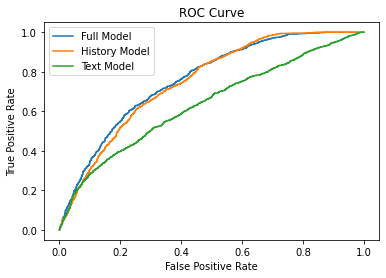

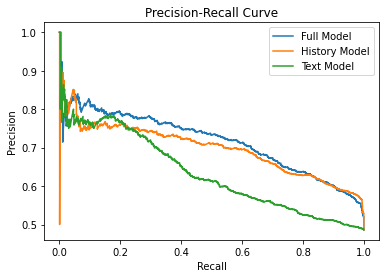

Full Model AUC: 0.7608589606534577 and average precision: 0.7163007768032069
History Model AUC: 0.7506703062131764 and average precision: 0.697196033749834
Text Model AUC: 0.6369628962961535 and average precision: 0.633302137691037

Full Model Separation Plot:


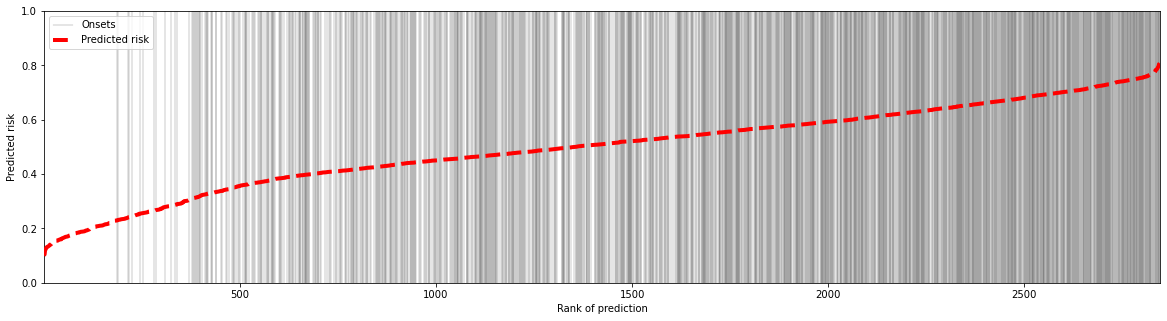

In [24]:
produce_stats('ons_target_f{}'.format(forward),'ons_target_f{}'.format(forward),0)

Observations: 3740


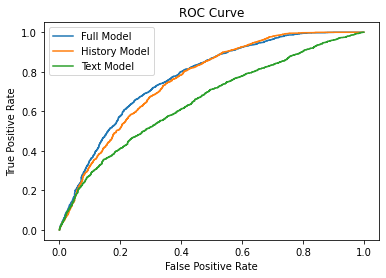

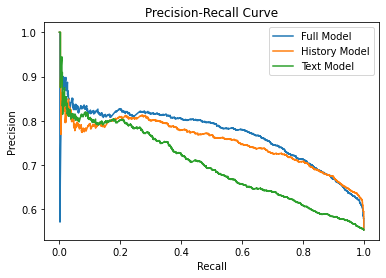

Full Model AUC: 0.7709841663486667 and average precision: 0.7696347573589523
History Model AUC: 0.7587232051853624 and average precision: 0.7530063716447335
Text Model AUC: 0.6537276591140342 and average precision: 0.6979982214646155

Full Model Separation Plot:


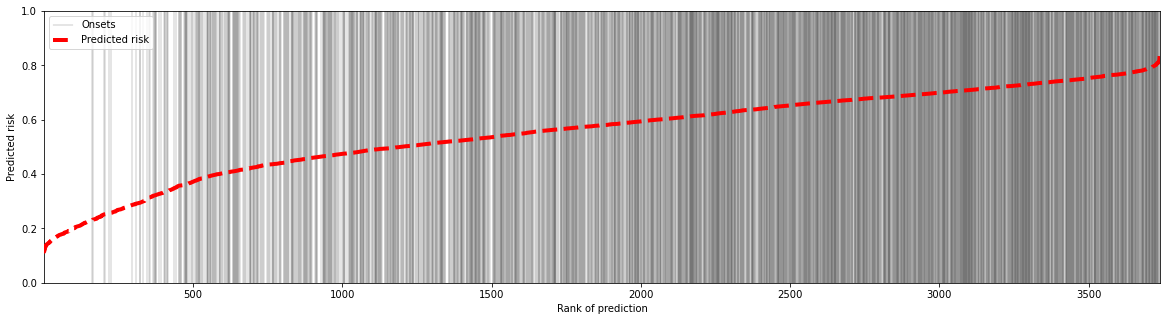

In [25]:
produce_stats('target_f{}'.format(forward),'target_f{}'.format(forward),0)

As we can see in the performance result, History Model performs better than text model, which make sense. Perhaps, additional text features can improve the performance as I only create 6 columns to signal devaluation. Full model has the higher performance, which also make sense as I added text model to the history model to make the predictions. However, there is not a big difference between the full model and the history model, so we can say that historical data on price weight much more when forecasting a devaluation jump than text (in this case). 

# Decision Making

In this context, let's say a company based in Argentina buys raw materials in USD, where the timing to place an order depends on devaluation. In this case, the decision-maker can consider the different meanings for false positives (FP) and false negatives (FN) in their decision-making process. 

A formula that represents the cost minimization objective in the context of a company based in Argentina that buys raw materials in USD, where the timing to place an order depends on devaluation:

Minimize E[Costc] = CostDelay * (FP * E[FPc] + TN * E[TNc]) + CostNoDelay * (FN * E[FNc] + TP * E[TPc])


FP (False Positives): This term represents the false positive prediction of a devaluation, where the company delays the purchase (Delayc) expecting a devaluation to occur, but it does not actually happen. The cost associated with false positives can include increased prices, storage costs, missed business opportunities, or any other costs incurred due to delaying the purchase based on an incorrect prediction.

E[FPc] (Expected Number of False Positives): This term represents the expected number of false positive predictions made by the company. It considers historical data, economic indicators, or any other factors that help estimate the likelihood of false positives occurring.

TN (True Negatives): This term represents the true negative prediction of no devaluation, where the company does not delay the purchase (NoDelayc) because no devaluation is predicted, and in reality, no devaluation occurs. The term TN captures the potential cost savings or avoided costs associated with correctly predicting the absence of devaluations.

E[TNc] (Expected Number of True Negatives): This term represents the expected number of true negative predictions made by the company. It considers historical data and other factors to estimate the likelihood of true negatives occurring.

FN (False Negatives): This term represents the false negative prediction of no devaluation, where the company does not delay the purchase (NoDelayc) despite the occurrence of a devaluation. The cost associated with false negatives can include additional costs due to unfavorable exchange rates, missed cost savings, or any other costs incurred by not delaying the purchase when a devaluation actually occurs.

E[FNc] (Expected Number of False Negatives): This term represents the expected number of false negative predictions made by the company. It considers historical data and other factors to estimate the likelihood of false negatives occurring.

TP (True Positives): This term represents the true positive prediction of a devaluation, where the company delays the purchase (Delayc) based on an accurate prediction, and a devaluation actually occurs. The term TP captures the potential cost savings or benefits associated with correctly predicting and taking advantage of devaluations.

E[TPc] (Expected Number of True Positives): This term represents the expected number of true positive predictions made by the company. It considers historical data, economic indicators, or any other factors to estimate the likelihood of true positives occurring.

In [59]:
# Example: Set a threshold for classifying the predictions
threshold = 0.5

# Calculate the predicted labels based on the threshold
combined['predicted_labels'] = combined['target_f4_pred_top'] >= threshold

# Calculate TP, TN, FP, FN
TP = sum((combined['predicted_labels'] == True) & (combined['target_f4'] == 1))
TN = sum((combined['predicted_labels'] == False) & (combined['target_f4'] == 0))
FP = sum((combined['predicted_labels'] == True) & (combined['target_f4'] == 0))
FN = sum((combined['predicted_labels'] == False) & (combined['target_f4'] == 1))

# Print the results
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)

True Positives (TP): 1427
True Negatives (TN): 1109
False Positives (FP): 797
False Negatives (FN): 947


False Positive (FP) prediction:

FP occurs when the model predicts a devaluation, but it does not actually happen.
FP implies that the company might place an order for raw materials prematurely, expecting a devaluation that does not occur.
The cost associated with FP can be related to the potential loss or extra expenses incurred due to early ordering, such as additional storage costs, currency exchange fees, or lost opportunities to benefit from a lower exchange rate.

False Negative (FN) prediction:

FN occurs when the model fails to predict a devaluation, but it actually happens.
FN implies that the company might delay placing an order, expecting no devaluation, but a devaluation does occur.
The cost associated with FN can be related to the potential loss or negative impact on the company's operations due to delayed ordering, such as higher purchasing costs, supply chain disruptions, production delays, or missed market opportunities.

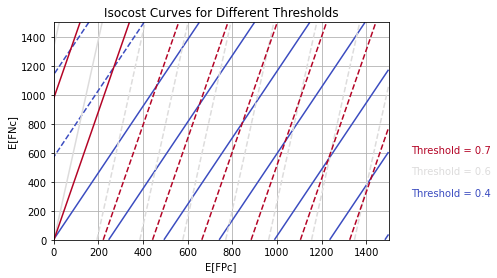

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Define the cost coefficients
CostDelay = 40.0
CostNoDelay = 10.0

FPc_values = np.linspace(0, 1500, 100)
FNc_values = np.linspace(0, 1500, 100)

# Create a grid of FPc and FNc values
FPc_grid, FNc_grid = np.meshgrid(FPc_values, FNc_values)

# Set a list of threshold values
#thresholds = [0.4, 0.5, 0.6 ,0.7]  # Add any other thresholds you want to visualize
thresholds = [0.4, 0.6 ,0.7]
# Calculate the cost for each combination of FPc and FNc for each threshold
costs = []
for threshold in thresholds:
    # Calculate the predicted labels based on the threshold
    predicted_labels = combined['target_f4_pred_top'] >= threshold
    
    # Calculate TP, TN, FP, FN
    TP = sum((predicted_labels == True) & (combined['target_f4'] == 1))
    TN = sum((predicted_labels == False) & (combined['target_f4'] == 0))
    FP = sum((predicted_labels == True) & (combined['target_f4'] == 0))
    FN = sum((predicted_labels == False) & (combined['target_f4'] == 1))
    
    # Calculate the cost for each combination of FPc and FNc using the current threshold
    cost = (
        CostDelay * (FP * FPc_grid + TN * (1 - FPc_grid))
        + CostNoDelay * (FN * FNc_grid + TP * (1 - FNc_grid))
    )
    costs.append(cost)

# Choose a colormap for the isocost curves
colormap = 'coolwarm'

# Plot the isocost curves with different colors for each threshold
colors = plt.cm.get_cmap(colormap)(np.linspace(0, 1, len(thresholds)))
for i, cost in enumerate(costs):
    plt.contour(FPc_grid, FNc_grid, cost, levels=10, colors=[colors[i][:3]])
    # Add the threshold value as text outside the graph
    plt.text(1600, 300 + i * 150, f'Threshold = {thresholds[i]}', color=colors[i])

plt.xlabel('E[FPc]')
plt.ylabel('E[FNc]')
plt.title('Isocost Curves for Different Thresholds')
plt.grid(True)
plt.show()

In [61]:
import pandas as pd

# Define the list of thresholds
thresholds = [0.4, 0.5, 0.6, 0.7]

# Create an empty DataFrame to store the results
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Calculate evaluation metrics for each threshold
for threshold in thresholds:
    # Calculate the predicted labels based on the threshold
    predicted_labels = combined['target_f4_pred_top'] >= threshold
    
    # Calculate TP, TN, FP, FN
    TP = sum((predicted_labels == True) & (combined['target_f4'] == 1))
    TN = sum((predicted_labels == False) & (combined['target_f4'] == 0))
    FP = sum((predicted_labels == True) & (combined['target_f4'] == 0))
    FN = sum((predicted_labels == False) & (combined['target_f4'] == 1))
    
    # Calculate evaluation metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Append the results to the DataFrame
    results = results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }, ignore_index=True)

# Display the results table
print(results)

   Threshold  Accuracy  Precision    Recall  F1 Score
0        0.4  0.570093   0.582204  0.796546  0.672714
1        0.5  0.592523   0.641637  0.601095  0.620705
2        0.6  0.564486   0.728495  0.342460  0.465903
3        0.7  0.519626   0.802281  0.177759  0.291034


<ipython-input-61-3665a796cfb9>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-61-3665a796cfb9>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-61-3665a796cfb9>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-61-3665a796cfb9>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [62]:
import pandas as pd

# Define the values
thresholds = results['Threshold'].tolist()
accuracy_values = results['Accuracy'].tolist()
precision_values = results['Precision'].tolist()
recall_values = results['Recall'].tolist()
f1_score_values = results['F1 Score'].tolist()
cost_delay = 40.0
cost_no_delay = 10.0

# Calculate the expected cost for each threshold
FPc = 10  # Example value for False Positive Cost
TNc = 0  # Example value for True Negative Cost
FNc = 20  # Example value for False Negative Cost
TPc = 0  # Example value for True Positive Cost

expected_costs = []
for i in range(len(thresholds)):
    FP = 1 - precision_values[i]  # False Positives
    FN = 1 - recall_values[i]  # False Negatives
    TN = 1 - FP  # True Negatives
    TP = recall_values[i]  # True Positives
    
    expected_cost = (
        cost_delay * (FP * FPc + TN * TNc) + cost_no_delay * (FN * FNc + TP * TPc)
    )
    expected_costs.append(expected_cost)



# Create a DataFrame to store the results
results = pd.DataFrame({
    'Threshold': thresholds,
    'Expected Cost': expected_costs
})

# Display the results
print(results)

   Threshold  Expected Cost
0        0.4     207.809044
1        0.5     223.126284
2        0.6     240.110154
3        0.7     243.535641


As the threshold increases from 0.4 to 0.7, the expected cost also increases, indicating a higher overall cost for the model.
The accuracy, precision, recall, and F1 score values vary across different thresholds, reflecting the trade-off between different performance metrics.
Lower thresholds (0.4 and 0.5) result in higher recall values, meaning more positive instances are correctly classified, but at the expense of higher false positive rates and overall cost.
Higher thresholds (0.6 and 0.7) lead to higher precision values, indicating a lower false positive rate, but at the cost of lower recall and overall model performance.

Considering these factors, a higher threshold would result in a higher false negative rate, meaning more positive instances would be incorrectly classified as negative. This would lead to higher costs because of the higher FNc value (cost of false negatives).

On the other hand, a lower threshold would result in a higher false positive rate, meaning more negative instances would be incorrectly classified as positive. This would lead to higher costs because of the higher FPc value (cost of false positives).

Therefore, from a cost perspective, it is likely that a higher threshold would result in higher costs, given the higher FNc value. However, the specific trade-off between false positives and false negatives should be carefully considered based on the context and requirements of the problem. It ultimately depends on the relative importance and associated costs of different types of prediction errors in the specific application. In this specific case, I would prioritize a higher recall (meaning being more flexible in terms of the probability of having a devaluation, so lower threshold) because of the inputs I chose. A delay is usually more expensive in a supply chain perspective, as it is usually higher in terms of costs a supply chain disruptions or production delays rather than additional storage costs or exchange fees.  